# Autonomous Driving System With Real Time Testing

## VEHICLE DETECTION USING HOG/SVM


### Libraries

In [89]:
import cv2
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog 
import os
import warnings
import glob
import random
import pandas as pd
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [79]:
import sys
import os
import cv2
import datetime
# import imutils
import numpy as np
from pathlib import Path
import random
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from zipfile import ZipFile

import pickle

## Loading Data

In [4]:
#import training dataset of vehicles/non-vehicles

car = glob.glob('data/car/**/*.png')
no_car = glob.glob('data/no car/**/*.png')


In [5]:
len(car)

8792

In [6]:
len(no_car)

8968

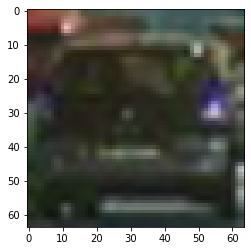

In [7]:
image_color = cv2.imread(car[300]) 
plt.imshow(image_color)

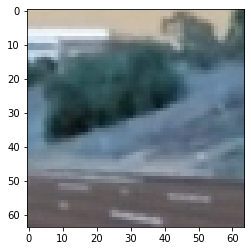

In [8]:
image_color_no = cv2.imread(no_car[300]) 
plt.imshow(image_color_no)

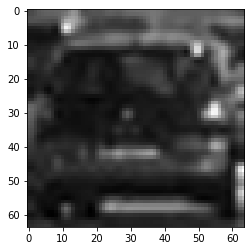

In [9]:
image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap = 'gray')

## GETTING HOG FEATURES

In [10]:

features, hog_image = hog(image_gray, 
                          orientations = 11, 
                          pixels_per_cell = (16, 16), 
                          cells_per_block = (2, 2), 
                          transform_sqrt = False, 
                          visualize = True, 
                          feature_vector = True)

features.shape 

(396,)

In [11]:
hog_image.shape

(64, 64)

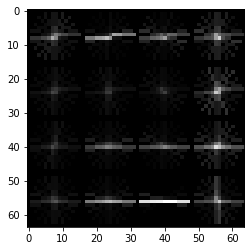

In [12]:
plt.imshow(hog_image, cmap = 'gray')


# HOG FEATURE EXTRACTION AND TRAINING DATASET CREATION

In [13]:
car_hog_accum = []

for i in car:
    image_color = mpimg.imread(i)
    image_gray  = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    car_hog_feature, car_hog_img = hog(image_color[:,:,0], 
                                    orientations = 11, 
                                    pixels_per_cell = (16, 16), 
                                    cells_per_block = (2, 2), 
                                    transform_sqrt = False, 
                                    visualize = True, 
                                    feature_vector = True)
                
    car_hog_accum.append(car_hog_feature)


In [14]:
X_car = np.vstack(car_hog_accum).astype(np.float64)  
y_car = np.ones(len(X_car))

In [15]:
X_car.shape

(8792, 396)

In [16]:
y_car.shape

(8792,)

In [17]:
y_car

array([1., 1., 1., ..., 1., 1., 1.])

In [18]:
nocar_hog_accum = []

for i in no_car:
    image_color = mpimg.imread(i)
    image_gray  = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    nocar_hog_feature, car_hog_img = hog(image_color[:,:,0], 
                                    orientations = 11, 
                                    pixels_per_cell = (16, 16), 
                                    cells_per_block = (2, 2), 
                                    transform_sqrt = False, 
                                    visualize = True, 
                                    feature_vector = True)
                
    nocar_hog_accum.append(nocar_hog_feature)


In [19]:
X_nocar = np.vstack(nocar_hog_accum).astype(np.float64)  
y_nocar = np.zeros(len(X_nocar))



In [20]:
X_nocar.shape

(8968, 396)

In [21]:
y_nocar.shape

(8968,)

In [22]:
X = np.vstack((X_car, X_nocar))
X.shape

(17760, 396)

In [23]:
y = np.hstack((y_car, y_nocar))
y.shape

(17760,)

# SVM MODEL CLASSIFIER TRAINING 

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)


In [25]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix
svc_model = LinearSVC()
svc_model.fit(X_train,y_train)

LinearSVC()

<AxesSubplot:>

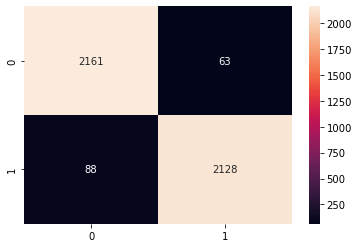

In [26]:
y_predict = svc_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_predict)

sns.heatmap(cm, annot=True, fmt="d")

In [27]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      2224
         1.0       0.97      0.96      0.97      2216

    accuracy                           0.97      4440
   macro avg       0.97      0.97      0.97      4440
weighted avg       0.97      0.97      0.97      4440



In [28]:
Model_prediction = svc_model.predict(X_test[0:50])
Model_prediction


array([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.])

In [29]:
Model_TrueLabel = y_test[0:50]
Model_TrueLabel

array([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.])

# Hyperparameter Tuning

In [30]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']} 

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)
grid.best_params_
grid.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.966 total time=  22.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.970 total time=  23.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.968 total time=  22.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.964 total time=  23.6s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.968 total time=  22.9s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.963 total time=  16.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.967 total time=  16.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.967 total time=  15.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.959 total time=  15.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.968 total time=  14.7s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.929 total time=  32.9s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;

SVC(C=10, gamma=1)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2224
         1.0       0.99      0.99      0.99      2216

    accuracy                           0.99      4440
   macro avg       0.99      0.99      0.99      4440
weighted avg       0.99      0.99      0.99      4440



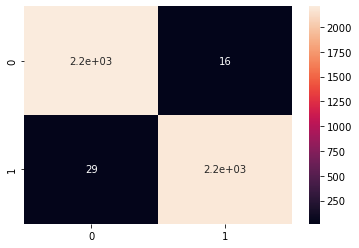

In [32]:
grid_predictions = grid.predict(X_test)
cm = confusion_matrix(y_test, grid_predictions)
sns.heatmap(cm, annot=True)
print(classification_report(y_test,grid_predictions))

# TEST THE MODEL (FIND CARS)!

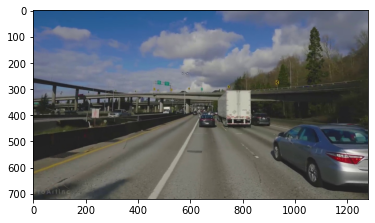

In [33]:
test_image = mpimg.imread('frame4.jpg')
plt.imshow(test_image)
test_image = test_image.astype(np.float32)/255

(350, 1280, 3)

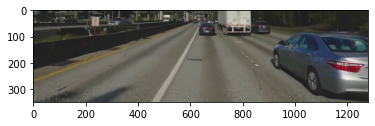

In [34]:
h_start = 350
h_stop = 700

pixels_in_cell = 16
HOG_orientations = 11
cells_in_block = 3
cells_in_step = 3 


masked_region = test_image[h_start:h_stop,:,:]
plt.imshow(masked_region)
masked_region.shape


In [35]:
resizing_factor = 2
masked_region_shape = masked_region.shape
L = masked_region_shape[1]/resizing_factor
W = masked_region_shape[0]/resizing_factor

(175, 640, 3)


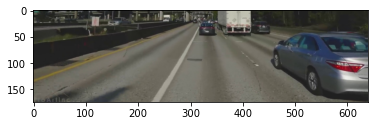

In [36]:
masked_region_resized = cv2.resize(masked_region, (int(L), int(W)))
masked_region_resized_R = masked_region_resized[:,:,0]

print(masked_region_resized.shape)
plt.imshow(masked_region_resized)


In [37]:
    
print(masked_region_resized_R.shape)    
masked_region_hog_feature_all, hog_img = hog(masked_region_resized_R, orientations = 11, pixels_per_cell = (16, 16), cells_per_block = (2, 2), transform_sqrt = False, visualize = True, feature_vector = False)
 

(175, 640)


In [38]:
n_blocks_x = (masked_region_resized_R.shape[1] // pixels_in_cell)+1  
n_blocks_y = (masked_region_resized_R.shape[0] // pixels_in_cell)+1

#nfeat_per_block = orientations * cells_in_block **2 
blocks_in_window = (64 // pixels_in_cell)-1 
    
steps_x = (n_blocks_x - blocks_in_window) // cells_in_step
steps_y = (n_blocks_y - blocks_in_window) // cells_in_step

rectangles_found = []

for xb in range(steps_x):
    for yb in range(steps_y):
        y_position = yb*cells_in_step
        x_position = xb*cells_in_step
            
        hog_feat_sample = masked_region_hog_feature_all[y_position : y_position + blocks_in_window, x_position : x_position + blocks_in_window].ravel()
        x_left = x_position * pixels_in_cell
        y_top = y_position * pixels_in_cell
        print(hog_feat_sample.shape)  
        
        # predict using trained SVM
        test_prediction = svc_model.predict(hog_feat_sample.reshape(1,-1))
        # test_prediction = grid.predict(hog_feat_sample.reshape(1,-1))
        
        if test_prediction == 1: 
            rectangle_x_left = int(x_left * resizing_factor)
            rectangle_y_top = int(y_top * resizing_factor)
            window_dim = int(64 * resizing_factor)
            rectangles_found.append(((rectangle_x_left, rectangle_y_top + h_start),(rectangle_x_left + window_dim, rectangle_y_top + window_dim + h_start)))
                

(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)


In [39]:
rectangles_found

[((96, 350), (224, 478)),
 ((192, 350), (320, 478)),
 ((288, 350), (416, 478)),
 ((384, 350), (512, 478)),
 ((576, 446), (704, 574)),
 ((768, 350), (896, 478))]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


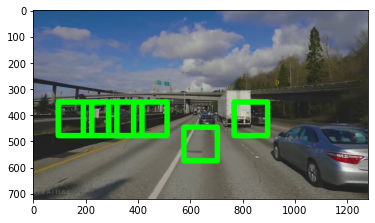

In [40]:
Image_with_Rectangles_Drawn = np.copy(test_image)
    
for rectangle in rectangles_found:
    cv2.rectangle(Image_with_Rectangles_Drawn, rectangle[0], rectangle[1], (0, 255, 0), 20)

plt.imshow(Image_with_Rectangles_Drawn)
        

In [41]:
h_start = 350
h_stop = 700

pixels_in_cell = 16
HOG_orientations = 11
cells_in_block = 2
cells_in_step = 3 
resizing_factor = 2

## Applying on Youtube Video

In [42]:
for images in os.listdir('frames/'):
    test_image = mpimg.imread('frames/'+images)
    t_image=test_image
    print(images)
    test_image = test_image.astype(np.float32)/255
    h_start = 350
    h_stop = 700
    pixels_in_cell = 16
    HOG_orientations = 11
    cells_in_block = 3
    cells_in_step = 3 
    masked_region = test_image[h_start:h_stop,:,:]
    masked_region_shape = masked_region.shape
    
    L = masked_region_shape[1]/resizing_factor
    W = masked_region_shape[0]/resizing_factor
    masked_region_resized = cv2.resize(masked_region, (int(L), int(W)))
    masked_region_resized_R = masked_region_resized[:,:,0]
    print(masked_region_resized_R.shape)
    print(masked_region_resized.shape)
    masked_region_hog_feature_all, hog_img = hog(masked_region_resized_R, orientations = 11, pixels_per_cell = (16, 16), cells_per_block = (2, 2), transform_sqrt = False, visualize = True, feature_vector = False)
    n_blocks_x = (masked_region_resized_R.shape[1] // pixels_in_cell)+1  
    n_blocks_y = (masked_region_resized_R.shape[0] // pixels_in_cell)+1
    blocks_in_window = (64 // pixels_in_cell)-1 
    steps_x = (n_blocks_x - blocks_in_window) // cells_in_step
    steps_y = (n_blocks_y - blocks_in_window) // cells_in_step
    rectangles_found = []
    for xb in range(steps_x):
        for yb in range(steps_y):
            y_position = yb*cells_in_step
            x_position = xb*cells_in_step
            
            hog_feat_sample = masked_region_hog_feature_all[y_position : y_position + blocks_in_window, x_position : x_position + blocks_in_window].ravel()
            x_left = x_position * pixels_in_cell
            y_top = y_position * pixels_in_cell
        #print(hog_feat_sample.shape)  
        
        # predict using trained SVM
            test_prediction = grid.predict(hog_feat_sample.reshape(1,-1))
        # test_prediction = grid.predict(hog_feat_sample.reshape(1,-1))
        
            if test_prediction == 1: 
                rectangle_x_left = int(x_left * resizing_factor)
                rectangle_y_top = int(y_top * resizing_factor)
                window_dim = int(64 * resizing_factor)
                rectangles_found.append(((rectangle_x_left, rectangle_y_top + h_start),(rectangle_x_left + window_dim, rectangle_y_top + window_dim + h_start)))
    print(rectangles_found)    
    Image_with_Rectangles_Drawn = np.copy(t_image)
    for rectangle in rectangles_found:
        cv2.rectangle(Image_with_Rectangles_Drawn, rectangle[0], rectangle[1], (0, 255, 0), 20)
    cv2.imwrite('fra/'+images,Image_with_Rectangles_Drawn)
    
    
    

frame0.jpg
(175, 640)
(175, 640, 3)
[]
frame1.jpg
(175, 640)
(175, 640, 3)
[]
frame10.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478))]
frame100.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame1000.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame1001.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame1002.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame1003.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((672, 350), (800, 478))]
frame1004.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((672, 350), (800, 478))]
frame1005.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((672, 350), (800, 478))]
frame1006.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame1007.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame1008.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame1009.jpg
(175

[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame1095.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame1096.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame1097.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame1098.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame1099.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame11.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478))]
frame110.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame1100.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame1101.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame1102.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame1103.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame1104.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
fra

frame1208.jpg
(175, 640)
(175, 640, 3)
[]
frame1209.jpg
(175, 640)
(175, 640, 3)
[]
frame121.jpg
(175, 640)
(175, 640, 3)
[]
frame1210.jpg
(175, 640)
(175, 640, 3)
[]
frame1211.jpg
(175, 640)
(175, 640, 3)
[]
frame1212.jpg
(175, 640)
(175, 640, 3)
[]
frame1213.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame1214.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame1215.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame1216.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame1217.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame1218.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame1219.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame122.jpg
(175, 640)
(175, 640, 3)
[]
frame1220.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame1221.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame1222.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame1223.jpg
(175, 640)
(175, 640, 3)
[((0

[((480, 350), (608, 478))]
frame1346.jpg
(175, 640)
(175, 640, 3)
[]
frame1347.jpg
(175, 640)
(175, 640, 3)
[]
frame1348.jpg
(175, 640)
(175, 640, 3)
[]
frame1349.jpg
(175, 640)
(175, 640, 3)
[]
frame135.jpg
(175, 640)
(175, 640, 3)
[]
frame1350.jpg
(175, 640)
(175, 640, 3)
[]
frame1351.jpg
(175, 640)
(175, 640, 3)
[]
frame1352.jpg
(175, 640)
(175, 640, 3)
[]
frame1353.jpg
(175, 640)
(175, 640, 3)
[]
frame1354.jpg
(175, 640)
(175, 640, 3)
[]
frame1355.jpg
(175, 640)
(175, 640, 3)
[]
frame1356.jpg
(175, 640)
(175, 640, 3)
[]
frame1357.jpg
(175, 640)
(175, 640, 3)
[]
frame1358.jpg
(175, 640)
(175, 640, 3)
[]
frame1359.jpg
(175, 640)
(175, 640, 3)
[]
frame136.jpg
(175, 640)
(175, 640, 3)
[]
frame1360.jpg
(175, 640)
(175, 640, 3)
[]
frame1361.jpg
(175, 640)
(175, 640, 3)
[]
frame1362.jpg
(175, 640)
(175, 640, 3)
[]
frame1363.jpg
(175, 640)
(175, 640, 3)
[]
frame1364.jpg
(175, 640)
(175, 640, 3)
[]
frame1365.jpg
(175, 640)
(175, 640, 3)
[]
frame1366.jpg
(175, 640)
(175, 640, 3)
[]
frame1367

[]
frame1483.jpg
(175, 640)
(175, 640, 3)
[]
frame1484.jpg
(175, 640)
(175, 640, 3)
[]
frame1485.jpg
(175, 640)
(175, 640, 3)
[]
frame1486.jpg
(175, 640)
(175, 640, 3)
[]
frame1487.jpg
(175, 640)
(175, 640, 3)
[]
frame1488.jpg
(175, 640)
(175, 640, 3)
[]
frame1489.jpg
(175, 640)
(175, 640, 3)
[]
frame149.jpg
(175, 640)
(175, 640, 3)
[((960, 446), (1088, 574))]
frame1490.jpg
(175, 640)
(175, 640, 3)
[]
frame1491.jpg
(175, 640)
(175, 640, 3)
[]
frame1492.jpg
(175, 640)
(175, 640, 3)
[]
frame1493.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame1494.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame1495.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame1496.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame1497.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame1498.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame1499.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame15.jpg
(175, 640)
(175, 640, 3)
[((0, 350), 

frame1591.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((864, 350), (992, 478))]
frame1592.jpg
(175, 640)
(175, 640, 3)
[((864, 350), (992, 478))]
frame1593.jpg
(175, 640)
(175, 640, 3)
[((0, 446), (128, 574)), ((864, 350), (992, 478))]
frame1594.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((864, 350), (992, 478))]
frame1595.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((96, 446), (224, 574)), ((192, 350), (320, 478)), ((864, 350), (992, 478))]
frame1596.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((96, 446), (224, 574)), ((864, 350), (992, 478))]
frame1597.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((864, 350), (992, 478))]
frame1598.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((96, 446), (224, 574)), ((192, 350), (320, 478)), ((864, 350), (992, 478)), ((1056, 350), (1184, 478))]
frame1599.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((96, 446), (224, 574)), ((864, 350), (992, 478)), ((1056, 350), (1184, 478))

[((0, 350), (128, 478))]
frame1673.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((384, 350), (512, 478))]
frame1674.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((384, 350), (512, 478))]
frame1675.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame1676.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame1677.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame1678.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478))]
frame1679.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame168.jpg
(175, 640)
(175, 640, 3)
[]
frame1680.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame1681.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame1682.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478))]
frame1683.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478))]
frame1684.jpg
(175, 640)
(175, 6

[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((768, 350), (896, 478))]
frame180.jpg
(175, 640)
(175, 640, 3)
[]
frame1800.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame1801.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame1802.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame1803.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame1804.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame1805.jpg
(175, 640)
(175, 640, 3)
[]
frame1806.jpg
(175, 640)
(175, 640, 3)
[]
frame1807.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame1808.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame1809.jpg
(175, 640)
(175, 640, 3)
[]
frame181.jpg
(175, 640)
(175, 640, 3)
[]
frame1810.jpg
(175, 640)
(175, 640, 3)
[]
frame1811.jpg
(175, 640)
(175, 640, 3)
[]
frame1812.jpg
(175, 640)
(175, 640, 3)
[]
frame1813.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame1814.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame

[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame190.jpg
(175, 640)
(175, 640, 3)
[]
frame1900.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame1901.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame1902.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame1903.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame1904.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame1905.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame1906.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame1907.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame1908.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame1909.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame191.jpg
(175, 640)
(175, 640, 3)
[]
frame1910.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame1911.jp

frame2.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478))]
frame20.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame200.jpg
(175, 640)
(175, 640, 3)
[]
frame2000.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((864, 350), (992, 478))]
frame2001.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((864, 350), (992, 478))]
frame2002.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((864, 350), (992, 478))]
frame2003.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((864, 350), (992, 478))]
frame2004.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame2005.jpg
(175, 640)
(175, 640, 3)
[((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame2006.jpg
(175, 640)
(175, 640, 3)
[((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame2007.jpg
(175, 640)
(175, 640, 3)
[((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame2008.jpg
(175, 640)
(175, 640, 3)
[((

frame2087.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478)), ((960, 350), (1088, 478))]
frame2088.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame2089.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((960, 350), (1088, 478))]
frame209.jpg
(175, 640)
(175, 640, 3)
[]
frame2090.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((1056, 350), (1184, 478))]
frame2091.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((1056, 350), (1184, 478))]
frame2092.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame2093.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame2094.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame2095.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame2096.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame2097.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame2098.jpg
(175, 640)
(175

[((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame2174.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame2175.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame2176.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478)), ((864, 350), (992, 478))]
frame2177.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478)), ((864, 350), (992, 478))]
frame2178.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame2179.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((864, 350), (992, 478))]
frame218.jpg
(175, 640)
(175, 640, 3)
[((96, 446), (224, 574)), ((192, 446), (320, 574))]
frame2180.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((864, 350), (992, 478))]
frame2181.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame2182.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame2183.jpg
(175, 640)
(175

[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((1056, 446), (1184, 574))]
frame2259.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((1056, 446), (1184, 574))]
frame226.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574))]
frame2260.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((1056, 446), (1184, 574))]
frame2261.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((1056, 446), (1184, 574))]
frame2262.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((1056, 446), (1184, 574))]
frame2263.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((1056, 446), (1184, 574))]
frame2264.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((1056, 446), (1184, 574))]
frame2265.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((1056, 446), (1184, 574))]
frame2266.jpg
(175, 640)
(175, 640, 3

frame2332.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478))]
frame2333.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478)), ((960, 446), (1088, 574))]
frame2334.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478)), ((960, 446), (1088, 574))]
frame2335.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478))]
frame2336.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((960, 446), (1088, 574))]
frame2337.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame2338.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((960, 446), (1088, 574))]
frame2339.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((960, 446), (1088, 574))]
frame234.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame2340.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((960, 446), (1088, 574))]
frame2341.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((960, 446), (1088,

frame2406.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((1056, 350), (1184, 478))]
frame2407.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((1056, 350), (1184, 478))]
frame2408.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame2409.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((672, 350), (800, 478))]
frame241.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame2410.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame2411.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame2412.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame2413.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((672, 350), (800, 478))]
frame2414.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((672, 350), (800, 478))]
frame2415.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame2416.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame2417.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame2418.j

[((288, 350), (416, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame2493.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574)), ((384, 350), (512, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame2494.jpg
(175, 640)
(175, 640, 3)
[((288, 446), (416, 574)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame2495.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((288, 446), (416, 574)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame2496.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame2497.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame2498.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame2499.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416,

frame2544.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame2545.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame2546.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame2547.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame2548.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame2549.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((576, 350), (704, 478))]
frame255.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2550.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((576, 350), (704, 478))]
frame2551.jpg
(175, 

frame2647.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478))]
frame2648.jpg
(175, 640)
(175, 640, 3)
[]
frame2649.jpg
(175, 640)
(175, 640, 3)
[((0, 446), (128, 574))]
frame265.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2650.jpg
(175, 640)
(175, 640, 3)
[]
frame2651.jpg
(175, 640)
(175, 640, 3)
[((0, 446), (128, 574))]
frame2652.jpg
(175, 640)
(175, 640, 3)
[((0, 446), (128, 574))]
frame2653.jpg
(175, 640)
(175, 640, 3)
[]
frame2654.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478))]
frame2655.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478))]
frame2656.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478))]
frame2657.jpg
(175, 640)
(175, 640, 3)
[((96, 446), (224, 574)), ((288, 350), (416, 478))]
frame2658.jpg
(175, 640)
(175, 640, 3)
[((0, 446), (128, 574)), ((96, 446), (224, 574)), ((288, 350), (416, 478))]
frame2659.jpg
(175, 640)
(175, 640, 3)
[((0, 446), (128, 574)), ((96, 446), (224, 574))]
frame266.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 

[((480, 350), (608, 478))]
frame2765.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2766.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2767.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2768.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2769.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame277.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2770.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2771.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2772.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2773.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2774.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2775.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2776.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2777.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame2778.jpg
(175, 640)
(175, 640, 3)
[((0, 350),

(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame2865.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame2866.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame2867.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame2868.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame2869.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame287.jpg
(175, 640)
(175, 640, 3)
[]
frame2870.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame2871.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame2872.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame2873.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478))]
frame2874.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame2875.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame2876.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame2877.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame2878.jpg
(175, 640)


[((192, 446), (320, 574)), ((576, 350), (704, 478)), ((768, 350), (896, 478)), ((960, 350), (1088, 478))]
frame2957.jpg
(175, 640)
(175, 640, 3)
[((192, 446), (320, 574)), ((576, 350), (704, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame2958.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame2959.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame296.jpg
(175, 640)
(175, 640, 3)
[]
frame2960.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame2961.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame2962.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame2963.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((960, 350), (1088, 478))]


frame302.jpg
(175, 640)
(175, 640, 3)
[]
frame3020.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3021.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3022.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3023.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3024.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3025.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3026.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3027.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3028.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3029.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame303.jpg
(175, 640)
(175, 640, 3)
[]
frame3030.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3031.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3032.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3033.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 4

[]
frame3110.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame3111.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3112.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3113.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3114.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3115.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3116.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3117.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3118.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3119.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame312.jpg
(175, 640)
(175, 640, 3)
[]
frame3120.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3121.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3122.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3123.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame

[((576, 350), (704, 478))]
frame3227.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3228.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3229.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame323.jpg
(175, 640)
(175, 640, 3)
[]
frame3230.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3231.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3232.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3233.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3234.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3235.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3236.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3237.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3238.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3239.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame324.jpg
(175, 640)
(175, 640, 3)
[]
frame3240.jpg
(175, 640)
(175, 64

frame3374.jpg
(175, 640)
(175, 640, 3)
[((1056, 446), (1184, 574))]
frame3375.jpg
(175, 640)
(175, 640, 3)
[((1056, 446), (1184, 574))]
frame3376.jpg
(175, 640)
(175, 640, 3)
[((960, 446), (1088, 574)), ((1056, 446), (1184, 574))]
frame3377.jpg
(175, 640)
(175, 640, 3)
[((960, 446), (1088, 574))]
frame3378.jpg
(175, 640)
(175, 640, 3)
[]
frame3379.jpg
(175, 640)
(175, 640, 3)
[]
frame338.jpg
(175, 640)
(175, 640, 3)
[]
frame3380.jpg
(175, 640)
(175, 640, 3)
[]
frame3381.jpg
(175, 640)
(175, 640, 3)
[]
frame3382.jpg
(175, 640)
(175, 640, 3)
[((960, 446), (1088, 574))]
frame3383.jpg
(175, 640)
(175, 640, 3)
[((960, 446), (1088, 574))]
frame3384.jpg
(175, 640)
(175, 640, 3)
[((960, 446), (1088, 574))]
frame3385.jpg
(175, 640)
(175, 640, 3)
[((960, 446), (1088, 574))]
frame3386.jpg
(175, 640)
(175, 640, 3)
[((960, 446), (1088, 574))]
frame3387.jpg
(175, 640)
(175, 640, 3)
[]
frame3388.jpg
(175, 640)
(175, 640, 3)
[]
frame3389.jpg
(175, 640)
(175, 640, 3)
[]
frame339.jpg
(175, 640)
(175, 64

frame3509.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((768, 350), (896, 478))]
frame351.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3510.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((768, 350), (896, 478))]
frame3511.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame3512.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame3513.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame3514.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame3515.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame3516.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame3517.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame3518.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame3519.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame352.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame3520.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame3521.jpg
(175, 640)
(

[((576, 350), (704, 478))]
frame362.jpg
(175, 640)
(175, 640, 3)
[]
frame3620.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame3621.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((576, 350), (704, 478))]
frame3622.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((576, 350), (704, 478))]
frame3623.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((576, 350), (704, 478))]
frame3624.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((576, 350), (704, 478))]
frame3625.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((576, 350), (704, 478)), ((864, 350), (992, 478))]
frame3626.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 446), (224, 574)), ((192, 350), (320, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((864, 350), (992, 4

frame3698.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((576, 350), (704, 478)), ((1056, 350), (1184, 478))]
frame3699.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((576, 350), (704, 478)), ((1056, 350), (1184, 478))]
frame37.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame370.jpg
(175, 640)
(175, 640, 3)
[]
frame3700.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((1056, 350), (1184, 478))]
frame3701.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((1056, 350), (1184, 478))]
frame3702.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((1056, 350), (1184, 478))]
frame3703.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478)), ((1056, 350), (1184, 478))]
frame3704.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((1056, 350), (1184, 478))]
frame3705.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((1056, 350), (1184, 478))]
frame3706.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), (

frame3762.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3763.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3764.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3765.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3766.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3767.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3768.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3769.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame377.jpg
(175, 640)
(175, 640, 3)
[]
frame3770.jpg
(

frame3822.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame3823.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame3824.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame3825.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame3826.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame3827.jpg
(17

[]
frame3870.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3871.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3872.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((672, 350), (800, 478))]
frame3873.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3874.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3875.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3876.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3877.jpg
(175, 640)
(175, 640, 3)
[(

frame3927.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame3928.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame3929.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((960, 350), (1088, 478))]
frame393.jpg
(175, 640)
(175, 640, 3)
[]
frame3930.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3931.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((960, 350), (1088, 478))]
frame3932.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame3933.jpg
(1

[((192, 350), (320, 478))]
frame4016.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((864, 350), (992, 478))]
frame4017.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((864, 350), (992, 478))]
frame4018.jpg
(175, 640)
(175, 640, 3)
[((864, 350), (992, 478))]
frame4019.jpg
(175, 640)
(175, 640, 3)
[((864, 350), (992, 478))]
frame402.jpg
(175, 640)
(175, 640, 3)
[]
frame4020.jpg
(175, 640)
(175, 640, 3)
[((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame4021.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((672, 350), (800, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame4022.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((672, 350), (800, 478)), ((864, 350), (992, 478))]
frame4023.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((864, 350), (992, 478))]
frame4024.jpg
(175, 640)
(175, 640, 3)
[((864, 350), (992, 478))]
frame4025.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478)), ((672, 350), (8

[((1056, 350), (1184, 478))]
frame4121.jpg
(175, 640)
(175, 640, 3)
[]
frame4122.jpg
(175, 640)
(175, 640, 3)
[]
frame4123.jpg
(175, 640)
(175, 640, 3)
[]
frame4124.jpg
(175, 640)
(175, 640, 3)
[]
frame4125.jpg
(175, 640)
(175, 640, 3)
[]
frame4126.jpg
(175, 640)
(175, 640, 3)
[]
frame4127.jpg
(175, 640)
(175, 640, 3)
[]
frame4128.jpg
(175, 640)
(175, 640, 3)
[]
frame4129.jpg
(175, 640)
(175, 640, 3)
[]
frame413.jpg
(175, 640)
(175, 640, 3)
[]
frame4130.jpg
(175, 640)
(175, 640, 3)
[]
frame4131.jpg
(175, 640)
(175, 640, 3)
[]
frame4132.jpg
(175, 640)
(175, 640, 3)
[]
frame4133.jpg
(175, 640)
(175, 640, 3)
[]
frame4134.jpg
(175, 640)
(175, 640, 3)
[]
frame4135.jpg
(175, 640)
(175, 640, 3)
[((960, 350), (1088, 478))]
frame4136.jpg
(175, 640)
(175, 640, 3)
[]
frame4137.jpg
(175, 640)
(175, 640, 3)
[((960, 350), (1088, 478))]
frame4138.jpg
(175, 640)
(175, 640, 3)
[((960, 350), (1088, 478))]
frame4139.jpg
(175, 640)
(175, 640, 3)
[((960, 350), (1088, 478))]
frame414.jpg
(175, 640)
(175, 64

frame4235.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame4236.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame4237.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((1056, 350), (1184, 478))]
frame4238.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame4239.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame424.jpg
(175, 640)
(175, 640, 3)
[]
frame4240.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((1056, 350), (1184, 478))]
frame4241.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((672, 350), (800, 478))]
frame4242.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((672, 350), (800, 478))]
frame4243.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((672, 350), (800, 478))]
frame4244.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((672, 350), (800, 478))]
frame4245.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((672, 350), (800, 478))]
frame4246.jpg
(175, 640)
(175, 640, 3)
[((480, 

(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame4328.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame4329.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame433.jpg
(175, 640)
(175, 640, 3)
[]
frame4330.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame4331.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame4332.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame4333.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame4334.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame4335.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame4336.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame4337.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4338.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4339.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame434.jpg
(175, 640)
(175, 640, 3)
[]
frame4340.jpg
(175, 64

[((768, 350), (896, 478))]
frame4438.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4439.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame444.jpg
(175, 640)
(175, 640, 3)
[]
frame4440.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4441.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4442.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4443.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4444.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4445.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4446.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4447.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4448.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4449.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame445.jpg
(175, 640)
(175, 640, 3)
[]
frame4450.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame4451.jpg
(175, 640)
(175, 64

frame4522.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame4523.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame4524.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame4525.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame4526.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574)), ((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame4527.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame4528.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame4529.jpg
(175

[((192, 350), (320, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame458.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame4580.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame4581.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame4582.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame4583.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame4584.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((384, 350), (512, 478)), ((480, 35

frame4627.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((288, 350), (416, 478))]
frame4628.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478))]
frame4629.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((864, 446), (992, 574))]
frame463.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame4630.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((864, 446), (992, 574))]
frame4631.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478))]
frame4632.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478))]
frame4633.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478))]
frame4634.jpg
(175, 640)
(

(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574)), ((384, 350), (512, 478)), ((1056, 446), (1184, 574))]
frame4718.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((1056, 446), (1184, 574))]
frame4719.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478)), ((1056, 446), (1184, 574))]
frame472.jpg
(175, 640)
(175, 640, 3)
[]
frame4720.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((1056, 446), (1184, 574))]
frame4721.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574)), ((1056, 446), (1184, 574))]
frame4722.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574)), ((1056, 446), (1184, 574))]
frame4723.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574)), ((1056, 446), (1184, 574))]
frame4724.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574))]
frame4725.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), (

frame4797.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478))]
frame4798.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478))]
frame4799.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478))]
frame48.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 446), (224, 574)), ((192, 446), (320, 574)), ((768, 350), (896, 478))]
frame480.jpg
(175, 640)
(175, 640, 3)
[]
frame4800.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478))]
frame4801.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478))]
frame4802.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478))]
frame4803.jpg
(1

frame4873.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame4874.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame4875.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478))]
frame4876.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478))]
frame4877.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478))]
frame4878.jpg
(175, 640)
(175, 640, 3)
[]
frame4879.jpg
(175, 640)
(175, 640, 3)
[]
frame488.jpg
(175, 640)
(175, 640, 3)
[]
frame4880.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame4881.jpg
(175, 640)
(175, 640, 3)
[((576, 446), (704, 574))]
frame4882.jpg
(175, 640)
(175, 640, 3)
[((576, 446), (704, 574))]
frame4883.jpg
(175, 640)
(175, 640, 3)
[]
frame4884.jpg
(175, 640)
(175, 640, 3)
[]
frame4885.jpg
(175, 640)
(175, 640, 3)
[]
frame4886.jpg
(175, 640)
(175, 640, 3)
[]
frame4887.jpg
(175, 640)
(175, 640, 3)
[]
frame4888.jpg
(175, 640)
(175, 640, 3)
[]
frame4889.jpg
(175, 640)
(175, 640, 3)
[]
frame489.j

(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame5007.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame5008.jpg
(175, 640)
(175, 640, 3)
[]
frame5009.jpg
(175, 640)
(175, 640, 3)
[]
frame501.jpg
(175, 640)
(175, 640, 3)
[]
frame5010.jpg
(175, 640)
(175, 640, 3)
[]
frame5011.jpg
(175, 640)
(175, 640, 3)
[]
frame5012.jpg
(175, 640)
(175, 640, 3)
[]
frame5013.jpg
(175, 640)
(175, 640, 3)
[]
frame5014.jpg
(175, 640)
(175, 640, 3)
[]
frame5015.jpg
(175, 640)
(175, 640, 3)
[]
frame5016.jpg
(175, 640)
(175, 640, 3)
[]
frame5017.jpg
(175, 640)
(175, 640, 3)
[]
frame5018.jpg
(175, 640)
(175, 640, 3)
[]
frame5019.jpg
(175, 640)
(175, 640, 3)
[]
frame502.jpg
(175, 640)
(175, 640, 3)
[]
frame5020.jpg
(175, 640)
(175, 640, 3)
[]
frame5021.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478))]
frame5022.jpg
(175, 640)
(175, 640, 3)
[]
frame5023.jpg
(175, 640)
(175, 640, 3)
[]
frame5024.jpg
(175, 640)
(175, 640, 3)
[]
frame5025.jpg
(175, 640)
(175, 640, 3)
[]
frame5026.jpg
(175, 640)

(175, 640)
(175, 640, 3)
[((96, 446), (224, 574)), ((960, 446), (1088, 574))]
frame5106.jpg
(175, 640)
(175, 640, 3)
[((960, 446), (1088, 574))]
frame5107.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((960, 446), (1088, 574))]
frame5108.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((960, 446), (1088, 574))]
frame5109.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((960, 446), (1088, 574))]
frame511.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame5110.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((960, 446), (1088, 574))]
frame5111.jpg
(175, 640)
(175, 640, 3)
[((96, 446), (224, 574)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((960, 446), (1088, 574))]
frame5112.jpg
(175, 640)
(175, 640, 3)
[((96, 446), (224, 574)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((960, 446), (1088, 574))]


[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame5153.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame5154.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame5155.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame5156.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame5157.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478))]
frame5158.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))

frame5208.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame5209.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame521.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame5210.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame5211.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame5212.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame5213.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame5214.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame5215.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((480, 350), (608, 478))]
frame5216.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((480, 350), (608, 478))]
frame5217.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame5218.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96

[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((480, 350), (608, 478)), ((768, 350), (896, 478))]
frame5272.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame5273.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((480, 350), (608, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame5274.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((480, 350), (608, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame5275.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((480, 350), (608, 478)), ((768, 350), (896, 478))]
frame5276.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((480, 350), (608, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame5277.jpg
(175, 640)
(175, 640, 3

(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478)), ((1056, 350), (1184, 478))]
frame534.jpg
(175, 640)
(175, 640, 3)
[]
frame5340.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame5341.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame5342.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame5343.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((960, 350), (1088, 478))]
frame5344.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((960, 350), (1088, 478))]
frame5345.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((960, 350), (1088, 478))]
frame5346.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350),

frame5416.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478)), ((864, 350), (992, 478))]
frame5417.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478)), ((864, 350), (992, 478))]
frame5418.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478)), ((864, 350), (992, 478))]
frame5419.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame542.jpg
(175, 640)
(175, 640, 3)
[]
frame5420.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478)), ((864, 350), (992, 478))]
frame5421.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478)), ((864, 350), (992, 478))]
frame5422.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((8

[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((672, 350), (800, 478))]
frame5475.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((672, 350), (800, 478))]
frame5476.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478)), ((672, 350), (800, 478))]
frame5477.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame5478.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((672, 350), (800, 478))]
frame5479.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame548.jpg
(175, 640)
(175, 640, 3)
[]
frame5480.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (51

[]
frame5520.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame5521.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame5522.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame5523.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((480, 350), (608, 478))]
frame5524.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((288, 350), (416, 478)), ((480, 350), (608, 478))]
frame5525.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame5526.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((2

(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((576, 350), (704, 478))]
frame5576.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame5577.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((576, 350), (704, 478))]
frame5578.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((576, 350), (704, 478))]
frame5579.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((576, 350), (704, 478))]
frame558.jpg
(175, 640)
(175, 640, 3)
[]
frame5580.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((576, 350), (704, 478))]
frame5581.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((192, 350), (320, 478)), ((576, 350), (704, 478))]
frame5582.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478

frame5641.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478)), ((192, 446), (320, 574))]
frame5642.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478)), ((192, 446), (320, 574)), ((288, 350), (416, 478))]
frame5643.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478)), ((192, 446), (320, 574))]
frame5644.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((96, 446), (224, 574)), ((192, 350), (320, 478)), ((288, 350), (416, 478))]
frame5645.jpg
(175, 640)
(175, 640, 3)
[((96, 446), (224, 574)), ((192, 350), (320, 478)), ((288, 350), (416, 478))]
frame5646.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478))]
frame5647.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478))]
frame5648.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478))]
frame5649.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478))

frame5734.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478))]
frame5735.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478))]
frame5736.jpg
(175, 640)
(175, 640, 3)
[]
frame5737.jpg
(175, 640)
(175, 640, 3)
[]
frame5738.jpg
(175, 640)
(175, 640, 3)
[]
frame5739.jpg
(175, 640)
(175, 640, 3)
[]
frame574.jpg
(175, 640)
(175, 640, 3)
[]
frame5740.jpg
(175, 640)
(175, 640, 3)
[]
frame5741.jpg
(175, 640)
(175, 640, 3)
[]
frame5742.jpg
(175, 640)
(175, 640, 3)
[]
frame5743.jpg
(175, 640)
(175, 640, 3)
[]
frame5744.jpg
(175, 640)
(175, 640, 3)
[]
frame5745.jpg
(175, 640)
(175, 640, 3)
[]
frame5746.jpg
(175, 640)
(175, 640, 3)
[]
frame5747.jpg
(175, 640)
(175, 640, 3)
[]
frame5748.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((192, 350), (320, 478))]
frame5749.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478))]
frame575.jpg
(175, 640)
(175, 640, 3)
[]
frame5750.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame5751.j

[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame5858.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((576, 350), (704, 478))]
frame5859.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame586.jpg
(175, 640)
(175, 640, 3)
[]
frame5860.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame5861.jpg
(175, 640)
(175, 640, 3)
[]
frame5862.jpg
(175, 640)
(175, 640, 3)
[]
frame5863.jpg
(175, 640)
(175, 640, 3)
[]
frame5864.jpg
(175, 640)
(175, 640, 3)
[]
frame5865.jpg
(175, 640)
(175, 640, 3)
[]
frame5866.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame5867.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame5868.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame5869.jpg
(175, 640)
(175, 640, 3)
[]
frame587.jpg
(175, 640)
(175, 640, 3)
[]
frame5870.jpg
(175, 640)
(175, 640, 3)
[((1056, 350), (1184, 478))]
frame5871.jpg
(175, 640)
(175, 640, 3)
[]
frame5872.jpg
(175, 640)
(175, 640, 3)
[]
fra

[]
frame5980.jpg
(175, 640)
(175, 640, 3)
[]
frame5981.jpg
(175, 640)
(175, 640, 3)
[]
frame5982.jpg
(175, 640)
(175, 640, 3)
[]
frame5983.jpg
(175, 640)
(175, 640, 3)
[]
frame5984.jpg
(175, 640)
(175, 640, 3)
[]
frame5985.jpg
(175, 640)
(175, 640, 3)
[]
frame5986.jpg
(175, 640)
(175, 640, 3)
[]
frame5987.jpg
(175, 640)
(175, 640, 3)
[]
frame5988.jpg
(175, 640)
(175, 640, 3)
[]
frame5989.jpg
(175, 640)
(175, 640, 3)
[]
frame599.jpg
(175, 640)
(175, 640, 3)
[]
frame5990.jpg
(175, 640)
(175, 640, 3)
[]
frame5991.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame5992.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame5993.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame5994.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame5995.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame5996.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame5997.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame5998.jpg
(175, 640)
(175, 6

[((288, 350), (416, 478)), ((288, 446), (416, 574)), ((576, 350), (704, 478))]
frame6097.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574)), ((576, 350), (704, 478))]
frame6098.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((288, 446), (416, 574)), ((576, 350), (704, 478))]
frame6099.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((288, 350), (416, 478)), ((576, 350), (704, 478))]
frame61.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((768, 350), (896, 478))]
frame610.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame6100.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478)), ((288, 350), (416, 478)), ((576, 350), (704, 478))]
frame6101.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478)), ((576, 350), (704, 478))]
frame6102.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((192, 350), (320, 478)), ((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame6103

[((96, 350), (224, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame6154.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame6155.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame6156.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame6157.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame6158.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame6159.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame616.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame6160.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame6161.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478

[((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame6237.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame6238.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame6239.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame624.jpg
(175, 640)
(175, 640, 3)
[]
frame6240.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame6241.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame6242.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame6243.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame6244.jpg
(175, 640)
(175, 640, 3)
[((576,

frame6338.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame6339.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame634.jpg
(175, 640)
(175, 640, 3)
[]
frame6340.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6341.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6342.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame6343.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6344.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6345.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6346.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6347.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6348.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6349.jpg
(175, 640)


frame6416.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame6417.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame6418.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame6419.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame642.jpg
(175, 640)
(175, 640, 3)
[]
frame6420.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame6421.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame6422.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame6423.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((86

[((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame6482.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame6483.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame6484.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame6485.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame6486.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((960, 350), (1088, 478))]
frame6487.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame6488.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame6489.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame649.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478))]
frame6490.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame6491.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((1056, 350), (1184, 478))]
frame6492.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704,

frame6557.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame6558.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame6559.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame656.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame6560.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame6561.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame6562.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame6563.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame6564.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame6565.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame6566.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame6567.jpg
(175, 640)
(175, 640, 3)
[(

frame6631.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame6632.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6633.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6634.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6635.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6636.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6637.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6638.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478)), ((864, 350), (992, 478))]
frame6639.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (51

[((576, 350), (704, 478)), ((672, 350), (800, 478)), ((864, 350), (992, 478)), ((1056, 350), (1184, 478))]
frame6695.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478)), ((864, 350), (992, 478)), ((1056, 350), (1184, 478))]
frame6696.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478)), ((864, 350), (992, 478)), ((1056, 350), (1184, 478))]
frame6697.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((864, 350), (992, 478)), ((1056, 350), (1184, 478))]
frame6698.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((864, 350), (992, 478)), ((1056, 350), (1184, 478))]
frame6699.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478)), ((864, 350), (992, 478)), ((1056, 350), (1184, 478))]
frame67.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((768, 350), (896, 47

frame6750.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame6751.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame6752.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((960, 446), (1088, 574))]
frame6753.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame6754.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame6755.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame6756.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((864, 350), (992, 478))]
frame6757.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((5

frame68.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((768, 350), (896, 478))]
frame680.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame6800.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((672, 350), (800, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame6801.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame6802.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame6803.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame6804.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame6805.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((672, 350), (800, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame6806.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), (

[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame6845.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((864, 350), (992, 478)), ((960, 350), (1088, 478))]
frame6846.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478)), ((864, 350), (992, 478))]
frame6847.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((864, 350), (992, 478))]
frame6848.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((864, 350), (992, 478))]
frame6849.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((864, 350), (992, 478))]
frame685.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
fram

frame6903.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6904.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((0, 446), (128, 574)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6905.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((0, 446), (128, 574)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame6906.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((768, 350), (896, 478))]
frame6907.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((0, 446), (128, 574)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((768, 350), (896, 478))]
frame6908.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((0, 446), (128, 574)), ((480, 350), (608, 478)), ((768, 350), (896, 478))]

(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame696.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((768, 350), (896, 478))]
frame6960.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame6961.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame6962.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame6963.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame6964.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame6965.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame6966.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame6967.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame6968.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame6969.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame697.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((384, 350), (512, 478)), ((768, 350), (896, 478))]
frame6970.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame6971.jpg
(

frame7047.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((576, 350), (704, 478))]
frame7048.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((576, 350), (704, 478))]
frame7049.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame705.jpg
(175, 640)
(175, 640, 3)
[]
frame7050.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7051.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7052.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((576, 350), (704, 478))]
frame7053.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7054.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7055.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478))]
frame7056.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7057.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7058.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7059.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]


[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7147.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7148.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7149.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame715.jpg
(175, 640)
(175, 640, 3)
[]
frame7150.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478)), ((960, 350), (1088, 478))]
frame7151.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame7152.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame7153.jpg
(175, 640)
(175, 640, 3)
[((4

[((288, 350), (416, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478)), ((864, 350), (992, 478))]
frame7196.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478)), ((864, 350), (992, 478))]
frame7197.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478)), ((288, 350), (416, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478)), ((864, 350), (992, 478))]
frame7198.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478)), ((864, 350), (992, 478))]
frame7199.jpg
(175, 640)
(175, 640, 3)
[((96, 446), (224, 574)), ((288, 350), (416, 478)), ((480, 350), (608, 478)), ((576, 3

frame7255.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame7256.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((768, 350), (896, 478))]
frame7257.jpg
(175, 640)
(175, 640, 3)
[((192, 446), (320, 574)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame7258.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame7259.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame726.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((864, 350), (992, 478))]
frame7260.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame7261.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame7262.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame7263.jpg
(17

frame7317.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame7318.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame7319.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame732.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((864, 350), (992, 478))]
frame7320.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame7321.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame7322.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame7323.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame7324.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704

frame7377.jpg
(175, 640)
(175, 640, 3)
[((192, 446), (320, 574)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7378.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7379.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame738.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((864, 350), (992, 478))]
frame7380.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7381.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7382.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7383.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7384.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704

[((576, 350), (704, 478))]
frame7457.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((1056, 350), (1184, 478))]
frame7458.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7459.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((1056, 350), (1184, 478))]
frame746.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((864, 350), (992, 478))]
frame7460.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7461.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame7462.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame7463.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame7464.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame7465.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame7466.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478))]
frame7467.

[((576, 350), (704, 478)), ((768, 350), (896, 478)), ((1056, 350), (1184, 478))]
frame7535.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7536.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478))]
frame7537.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7538.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7539.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame754.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((864, 350), (992, 478))]
frame7540.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7541.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7542.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7543.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7544.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7545.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((768, 350), (896, 478))]
frame7546.jpg
(175, 640)
(175, 640, 3)
[((576, 350),

[((384, 350), (512, 478)), ((576, 350), (704, 478))]
frame763.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((960, 350), (1088, 478))]
frame7630.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478))]
frame7631.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7632.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((576, 350), (704, 478))]
frame7633.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7634.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame7635.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478))]
frame7636.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((480, 350), (608, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478)), ((768, 350), (896, 478))]
fra

(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478))]
frame77.jpg
(175, 640)
(175, 640, 3)
[((384, 350), (512, 478)), ((768, 350), (896, 478))]
frame770.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478)), ((960, 350), (1088, 478))]
frame7700.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((384, 350), (512, 478)), ((576, 350), (704, 478))]
frame7701.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478))]
frame7702.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478))]
frame7703.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((576, 350), (704, 478))]
frame7704.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((288, 350), (416, 478)), ((576, 350), (704, 478))]
frame7705.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((288, 350), (416, 478)), ((576, 350), (704, 478))]
frame7706.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7707.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704,

(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7777.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7778.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7779.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame778.jpg
(175, 640)
(175, 640, 3)
[((960, 350), (1088, 478))]
frame7780.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7781.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7782.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7783.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7784.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7785.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7786.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (

(175, 640, 3)
[((576, 350), (704, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame7860.jpg
(175, 640)
(175, 640, 3)
[((288, 446), (416, 574)), ((576, 350), (704, 478)), ((1056, 350), (1184, 478))]
frame7861.jpg
(175, 640)
(175, 640, 3)
[((288, 446), (416, 574)), ((576, 350), (704, 478))]
frame7862.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((576, 350), (704, 478))]
frame7863.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((576, 350), (704, 478))]
frame7864.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((576, 350), (704, 478)), ((1056, 350), (1184, 478))]
frame7865.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((576, 350), (704, 478)), ((672, 350), (800, 478))]
frame7866.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7867.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7868.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7869.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame787.j

[]
frame7958.jpg
(175, 640)
(175, 640, 3)
[]
frame7959.jpg
(175, 640)
(175, 640, 3)
[]
frame796.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7960.jpg
(175, 640)
(175, 640, 3)
[]
frame7961.jpg
(175, 640)
(175, 640, 3)
[]
frame7962.jpg
(175, 640)
(175, 640, 3)
[]
frame7963.jpg
(175, 640)
(175, 640, 3)
[]
frame7964.jpg
(175, 640)
(175, 640, 3)
[]
frame7965.jpg
(175, 640)
(175, 640, 3)
[]
frame7966.jpg
(175, 640)
(175, 640, 3)
[((0, 446), (128, 574))]
frame7967.jpg
(175, 640)
(175, 640, 3)
[]
frame7968.jpg
(175, 640)
(175, 640, 3)
[]
frame7969.jpg
(175, 640)
(175, 640, 3)
[]
frame797.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame7970.jpg
(175, 640)
(175, 640, 3)
[]
frame7971.jpg
(175, 640)
(175, 640, 3)
[]
frame7972.jpg
(175, 640)
(175, 640, 3)
[]
frame7973.jpg
(175, 640)
(175, 640, 3)
[]
frame7974.jpg
(175, 640)
(175, 640, 3)
[((0, 446), (128, 574))]
frame7975.jpg
(175, 640)
(175, 640, 3)
[]
frame7976.jpg
(175, 640)
(175, 640, 3)
[]
frame7977.jpg
(175, 640)


[((576, 350), (704, 478))]
frame8080.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame8081.jpg
(175, 640)
(175, 640, 3)
[]
frame8082.jpg
(175, 640)
(175, 640, 3)
[]
frame8083.jpg
(175, 640)
(175, 640, 3)
[]
frame8084.jpg
(175, 640)
(175, 640, 3)
[]
frame8085.jpg
(175, 640)
(175, 640, 3)
[]
frame8086.jpg
(175, 640)
(175, 640, 3)
[]
frame8087.jpg
(175, 640)
(175, 640, 3)
[]
frame8088.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478))]
frame8089.jpg
(175, 640)
(175, 640, 3)
[]
frame809.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame8090.jpg
(175, 640)
(175, 640, 3)
[]
frame8091.jpg
(175, 640)
(175, 640, 3)
[]
frame8092.jpg
(175, 640)
(175, 640, 3)
[]
frame8093.jpg
(175, 640)
(175, 640, 3)
[]
frame8094.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame8095.jpg
(175, 640)
(175, 640, 3)
[]
frame8096.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478))]
frame8097.jpg
(175, 640)
(175, 640, 3)
[]
frame8098.jpg
(175, 640)
(175, 640, 3)


frame8208.jpg
(175, 640)
(175, 640, 3)
[]
frame8209.jpg
(175, 640)
(175, 640, 3)
[]
frame821.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame8210.jpg
(175, 640)
(175, 640, 3)
[]
frame8211.jpg
(175, 640)
(175, 640, 3)
[]
frame8212.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame8213.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame8214.jpg
(175, 640)
(175, 640, 3)
[]
frame8215.jpg
(175, 640)
(175, 640, 3)
[]
frame8216.jpg
(175, 640)
(175, 640, 3)
[]
frame8217.jpg
(175, 640)
(175, 640, 3)
[]
frame8218.jpg
(175, 640)
(175, 640, 3)
[]
frame8219.jpg
(175, 640)
(175, 640, 3)
[]
frame822.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame8220.jpg
(175, 640)
(175, 640, 3)
[]
frame8221.jpg
(175, 640)
(175, 640, 3)
[]
frame8222.jpg
(175, 640)
(175, 640, 3)
[]
frame8223.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame8224.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame8225.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)

(175, 640)
(175, 640, 3)
[((1056, 350), (1184, 478))]
frame836.jpg
(175, 640)
(175, 640, 3)
[]
frame8360.jpg
(175, 640)
(175, 640, 3)
[]
frame8361.jpg
(175, 640)
(175, 640, 3)
[]
frame8362.jpg
(175, 640)
(175, 640, 3)
[]
frame8363.jpg
(175, 640)
(175, 640, 3)
[]
frame8364.jpg
(175, 640)
(175, 640, 3)
[]
frame8365.jpg
(175, 640)
(175, 640, 3)
[]
frame8366.jpg
(175, 640)
(175, 640, 3)
[]
frame8367.jpg
(175, 640)
(175, 640, 3)
[]
frame8368.jpg
(175, 640)
(175, 640, 3)
[]
frame8369.jpg
(175, 640)
(175, 640, 3)
[]
frame837.jpg
(175, 640)
(175, 640, 3)
[]
frame8370.jpg
(175, 640)
(175, 640, 3)
[]
frame8371.jpg
(175, 640)
(175, 640, 3)
[]
frame8372.jpg
(175, 640)
(175, 640, 3)
[]
frame8373.jpg
(175, 640)
(175, 640, 3)
[]
frame8374.jpg
(175, 640)
(175, 640, 3)
[]
frame8375.jpg
(175, 640)
(175, 640, 3)
[]
frame8376.jpg
(175, 640)
(175, 640, 3)
[]
frame8377.jpg
(175, 640)
(175, 640, 3)
[]
frame8378.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame8379.jpg
(175, 640)
(175, 640, 3)
[((9

frame8492.jpg
(175, 640)
(175, 640, 3)
[]
frame8493.jpg
(175, 640)
(175, 640, 3)
[]
frame8494.jpg
(175, 640)
(175, 640, 3)
[]
frame8495.jpg
(175, 640)
(175, 640, 3)
[]
frame8496.jpg
(175, 640)
(175, 640, 3)
[]
frame8497.jpg
(175, 640)
(175, 640, 3)
[]
frame8498.jpg
(175, 640)
(175, 640, 3)
[]
frame8499.jpg
(175, 640)
(175, 640, 3)
[]
frame85.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame850.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame8500.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame8501.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478)), ((1056, 446), (1184, 574))]
frame8502.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame8503.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame8504.jpg
(175, 640)
(175, 640, 3)
[((576, 350), (704, 478))]
frame8505.jpg
(175, 640)
(175, 640, 3)
[]
frame8506.jpg
(175, 640)
(175, 640, 3)
[]
frame8507.jpg
(175, 640)
(175, 640, 3)
[]
frame8508.jpg
(175, 640)
(175, 640, 3)
[]
frame8509

(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame8596.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478))]
frame8597.jpg
(175, 640)
(175, 640, 3)
[((1056, 350), (1184, 478))]
frame8598.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame8599.jpg
(175, 640)
(175, 640, 3)
[]
frame86.jpg
(175, 640)
(175, 640, 3)
[((768, 350), (896, 478))]
frame860.jpg
(175, 640)
(175, 640, 3)
[]
frame8600.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((1056, 350), (1184, 478))]
frame8601.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((1056, 350), (1184, 478))]
frame8602.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((1056, 350), (1184, 478))]
frame8603.jpg
(175, 640)
(175, 640, 3)
[((96, 350), (224, 478)), ((1056, 350), (1184, 478))]
frame8604.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((960, 350), (1088, 478)), ((1056, 350), (1184, 478))]
frame8605.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((96, 350), (224, 478

frame870.jpg
(175, 640)
(175, 640, 3)
[((1056, 350), (1184, 478))]
frame8700.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478))]
frame8701.jpg
(175, 640)
(175, 640, 3)
[]
frame8702.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478))]
frame8703.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478))]
frame8704.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478))]
frame8705.jpg
(175, 640)
(175, 640, 3)
[((192, 350), (320, 478))]
frame8706.jpg
(175, 640)
(175, 640, 3)
[]
frame8707.jpg
(175, 640)
(175, 640, 3)
[]
frame8708.jpg
(175, 640)
(175, 640, 3)
[]
frame8709.jpg
(175, 640)
(175, 640, 3)
[]
frame871.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((1056, 350), (1184, 478))]
frame8710.jpg
(175, 640)
(175, 640, 3)
[]
frame8711.jpg
(175, 640)
(175, 640, 3)
[]
frame8712.jpg
(175, 640)
(175, 640, 3)
[]
frame8713.jpg
(175, 640)
(175, 640, 3)
[]
frame8714.jpg
(175, 640)
(175, 640, 3)
[]
frame8715.jpg
(175, 640)
(175, 640, 3)
[]
frame8716.jpg
(175, 640)
(175, 640, 3)
[]
frame871

frame8851.jpg
(175, 640)
(175, 640, 3)
[]
frame8852.jpg
(175, 640)
(175, 640, 3)
[]
frame8853.jpg
(175, 640)
(175, 640, 3)
[]
frame8854.jpg
(175, 640)
(175, 640, 3)
[]
frame8855.jpg
(175, 640)
(175, 640, 3)
[]
frame8856.jpg
(175, 640)
(175, 640, 3)
[]
frame8857.jpg
(175, 640)
(175, 640, 3)
[]
frame8858.jpg
(175, 640)
(175, 640, 3)
[]
frame8859.jpg
(175, 640)
(175, 640, 3)
[]
frame886.jpg
(175, 640)
(175, 640, 3)
[]
frame8860.jpg
(175, 640)
(175, 640, 3)
[]
frame8861.jpg
(175, 640)
(175, 640, 3)
[]
frame8862.jpg
(175, 640)
(175, 640, 3)
[]
frame8863.jpg
(175, 640)
(175, 640, 3)
[]
frame8864.jpg
(175, 640)
(175, 640, 3)
[]
frame8865.jpg
(175, 640)
(175, 640, 3)
[]
frame8866.jpg
(175, 640)
(175, 640, 3)
[]
frame8867.jpg
(175, 640)
(175, 640, 3)
[]
frame8868.jpg
(175, 640)
(175, 640, 3)
[]
frame8869.jpg
(175, 640)
(175, 640, 3)
[]
frame887.jpg
(175, 640)
(175, 640, 3)
[((288, 350), (416, 478)), ((1056, 350), (1184, 478))]
frame8870.jpg
(175, 640)
(175, 640, 3)
[]
frame8871.jpg
(175, 640)
(

[((0, 350), (128, 478)), ((96, 350), (224, 478)), ((1056, 350), (1184, 478))]
frame917.jpg
(175, 640)
(175, 640, 3)
[((1056, 350), (1184, 478))]
frame918.jpg
(175, 640)
(175, 640, 3)
[((0, 350), (128, 478)), ((1056, 350), (1184, 478))]
frame919.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((1056, 350), (1184, 478))]
frame92.jpg
(175, 640)
(175, 640, 3)
[((480, 350), (608, 478))]
frame920.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((1056, 350), (1184, 478))]
frame921.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((1056, 350), (1184, 478))]
frame922.jpg
(175, 640)
(175, 640, 3)
[((1056, 350), (1184, 478))]
frame923.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((1056, 350), (1184, 478))]
frame924.jpg
(175, 640)
(175, 640, 3)
[((1056, 350), (1184, 478))]
frame925.jpg
(175, 640)
(175, 640, 3)
[((1056, 350), (1184, 478))]
frame926.jpg
(175, 640)
(175, 640, 3)
[((672, 350), (800, 478)), ((1056, 350), (1184, 478))]
frame927.jpg
(175, 640)
(175, 640,

In [43]:
image_frame=[]

In [45]:
for images in os.listdir('frames/'):
    image_frame.append(images)

In [50]:
len(image_frame)

8992

In [102]:
car_no=[]

In [103]:
for images in os.listdir('frames/'):
    test_image = mpimg.imread('frames/'+images)
    t_image=test_image
    print(images)
    test_image = test_image.astype(np.float32)/255
    h_start = 350
    h_stop = 700
    pixels_in_cell = 16
    HOG_orientations = 11
    cells_in_block = 3
    cells_in_step = 3 
    masked_region = test_image[h_start:h_stop,:,:]
    masked_region_shape = masked_region.shape
    #print(masked_region_resized.shape)
    L = masked_region_shape[1]/resizing_factor
    W = masked_region_shape[0]/resizing_factor
    masked_region_resized = cv2.resize(masked_region, (int(L), int(W)))
    masked_region_resized_R = masked_region_resized[:,:,0]
    #print(masked_region_resized_R.shape)
    masked_region_hog_feature_all, hog_img = hog(masked_region_resized_R, orientations = 11, pixels_per_cell = (16, 16), cells_per_block = (2, 2), transform_sqrt = False, visualize = True, feature_vector = False)
    n_blocks_x = (masked_region_resized_R.shape[1] // pixels_in_cell)+1  
    n_blocks_y = (masked_region_resized_R.shape[0] // pixels_in_cell)+1
    blocks_in_window = (64 // pixels_in_cell)-1 
    steps_x = (n_blocks_x - blocks_in_window) // cells_in_step
    steps_y = (n_blocks_y - blocks_in_window) // cells_in_step
    rectangles_found = []
    k=[]
    for xb in range(steps_x):
        for yb in range(steps_y):
            y_position = yb*cells_in_step
            x_position = xb*cells_in_step
            
            hog_feat_sample = masked_region_hog_feature_all[y_position : y_position + blocks_in_window, x_position : x_position + blocks_in_window].ravel()
            x_left = x_position * pixels_in_cell
            y_top = y_position * pixels_in_cell
        #print(hog_feat_sample.shape)  
        
        # predict using trained SVM
            test_prediction = grid.predict(hog_feat_sample.reshape(1,-1))
            if test_prediction==1:
                k.append('1')
            elif test_prediction==0:
                pass
    print(len(k))
    car_no.append(len(k))
        


frame0.jpg
0
frame1.jpg
0
frame10.jpg
2
frame100.jpg
1
frame1000.jpg
2
frame1001.jpg
2
frame1002.jpg
1
frame1003.jpg
2
frame1004.jpg
2
frame1005.jpg
2
frame1006.jpg
1
frame1007.jpg
1
frame1008.jpg
2
frame1009.jpg
3
frame101.jpg
1
frame1010.jpg
3
frame1011.jpg
4
frame1012.jpg
4
frame1013.jpg
4
frame1014.jpg
4
frame1015.jpg
3
frame1016.jpg
3
frame1017.jpg
3
frame1018.jpg
3
frame1019.jpg
3
frame102.jpg
1
frame1020.jpg
3
frame1021.jpg
2
frame1022.jpg
3
frame1023.jpg
3
frame1024.jpg
2
frame1025.jpg
2
frame1026.jpg
2
frame1027.jpg
2
frame1028.jpg
2
frame1029.jpg
2
frame103.jpg
1
frame1030.jpg
2
frame1031.jpg
2
frame1032.jpg
2
frame1033.jpg
2
frame1034.jpg
2
frame1035.jpg
0
frame1036.jpg
1
frame1037.jpg
1
frame1038.jpg
1
frame1039.jpg
1
frame104.jpg
1
frame1040.jpg
1
frame1041.jpg
1
frame1042.jpg
1
frame1043.jpg
0
frame1044.jpg
0
frame1045.jpg
0
frame1046.jpg
0
frame1047.jpg
0
frame1048.jpg
0
frame1049.jpg
0
frame105.jpg
1
frame1050.jpg
0
frame1051.jpg
0
frame1052.jpg
0
frame1053.jpg
1
frame1

1
frame1463.jpg
1
frame1464.jpg
1
frame1465.jpg
1
frame1466.jpg
1
frame1467.jpg
1
frame1468.jpg
1
frame1469.jpg
1
frame147.jpg
0
frame1470.jpg
1
frame1471.jpg
1
frame1472.jpg
1
frame1473.jpg
1
frame1474.jpg
1
frame1475.jpg
0
frame1476.jpg
0
frame1477.jpg
0
frame1478.jpg
0
frame1479.jpg
0
frame148.jpg
1
frame1480.jpg
0
frame1481.jpg
0
frame1482.jpg
0
frame1483.jpg
0
frame1484.jpg
0
frame1485.jpg
0
frame1486.jpg
0
frame1487.jpg
0
frame1488.jpg
0
frame1489.jpg
0
frame149.jpg
1
frame1490.jpg
0
frame1491.jpg
0
frame1492.jpg
0
frame1493.jpg
1
frame1494.jpg
1
frame1495.jpg
1
frame1496.jpg
1
frame1497.jpg
1
frame1498.jpg
1
frame1499.jpg
1
frame15.jpg
4
frame150.jpg
1
frame1500.jpg
1
frame1501.jpg
1
frame1502.jpg
1
frame1503.jpg
1
frame1504.jpg
2
frame1505.jpg
2
frame1506.jpg
2
frame1507.jpg
2
frame1508.jpg
2
frame1509.jpg
2
frame151.jpg
1
frame1510.jpg
2
frame1511.jpg
2
frame1512.jpg
2
frame1513.jpg
2
frame1514.jpg
2
frame1515.jpg
2
frame1516.jpg
2
frame1517.jpg
2
frame1518.jpg
2
frame1519.jpg

1
frame1928.jpg
0
frame1929.jpg
0
frame193.jpg
0
frame1930.jpg
1
frame1931.jpg
1
frame1932.jpg
1
frame1933.jpg
1
frame1934.jpg
1
frame1935.jpg
1
frame1936.jpg
1
frame1937.jpg
1
frame1938.jpg
1
frame1939.jpg
1
frame194.jpg
0
frame1940.jpg
1
frame1941.jpg
1
frame1942.jpg
1
frame1943.jpg
1
frame1944.jpg
1
frame1945.jpg
1
frame1946.jpg
1
frame1947.jpg
1
frame1948.jpg
1
frame1949.jpg
1
frame195.jpg
0
frame1950.jpg
2
frame1951.jpg
2
frame1952.jpg
2
frame1953.jpg
2
frame1954.jpg
2
frame1955.jpg
2
frame1956.jpg
2
frame1957.jpg
2
frame1958.jpg
2
frame1959.jpg
2
frame196.jpg
0
frame1960.jpg
2
frame1961.jpg
2
frame1962.jpg
2
frame1963.jpg
3
frame1964.jpg
3
frame1965.jpg
3
frame1966.jpg
2
frame1967.jpg
3
frame1968.jpg
2
frame1969.jpg
2
frame197.jpg
0
frame1970.jpg
2
frame1971.jpg
2
frame1972.jpg
2
frame1973.jpg
1
frame1974.jpg
2
frame1975.jpg
2
frame1976.jpg
2
frame1977.jpg
3
frame1978.jpg
3
frame1979.jpg
2
frame198.jpg
0
frame1980.jpg
3
frame1981.jpg
2
frame1982.jpg
2
frame1983.jpg
3
frame1984.jp

3
frame2392.jpg
4
frame2393.jpg
3
frame2394.jpg
2
frame2395.jpg
2
frame2396.jpg
2
frame2397.jpg
4
frame2398.jpg
5
frame2399.jpg
3
frame24.jpg
2
frame240.jpg
1
frame2400.jpg
3
frame2401.jpg
3
frame2402.jpg
3
frame2403.jpg
2
frame2404.jpg
2
frame2405.jpg
3
frame2406.jpg
2
frame2407.jpg
2
frame2408.jpg
1
frame2409.jpg
2
frame241.jpg
1
frame2410.jpg
1
frame2411.jpg
1
frame2412.jpg
1
frame2413.jpg
2
frame2414.jpg
2
frame2415.jpg
1
frame2416.jpg
1
frame2417.jpg
1
frame2418.jpg
1
frame2419.jpg
1
frame242.jpg
2
frame2420.jpg
1
frame2421.jpg
1
frame2422.jpg
1
frame2423.jpg
1
frame2424.jpg
1
frame2425.jpg
1
frame2426.jpg
1
frame2427.jpg
1
frame2428.jpg
0
frame2429.jpg
1
frame243.jpg
2
frame2430.jpg
1
frame2431.jpg
1
frame2432.jpg
1
frame2433.jpg
1
frame2434.jpg
0
frame2435.jpg
0
frame2436.jpg
0
frame2437.jpg
0
frame2438.jpg
0
frame2439.jpg
0
frame244.jpg
2
frame2440.jpg
2
frame2441.jpg
1
frame2442.jpg
1
frame2443.jpg
2
frame2444.jpg
2
frame2445.jpg
2
frame2446.jpg
2
frame2447.jpg
2
frame2448.jpg

1
frame2857.jpg
1
frame2858.jpg
1
frame2859.jpg
1
frame286.jpg
1
frame2860.jpg
2
frame2861.jpg
1
frame2862.jpg
1
frame2863.jpg
1
frame2864.jpg
1
frame2865.jpg
1
frame2866.jpg
1
frame2867.jpg
1
frame2868.jpg
1
frame2869.jpg
1
frame287.jpg
0
frame2870.jpg
1
frame2871.jpg
1
frame2872.jpg
1
frame2873.jpg
2
frame2874.jpg
1
frame2875.jpg
1
frame2876.jpg
1
frame2877.jpg
1
frame2878.jpg
2
frame2879.jpg
2
frame288.jpg
1
frame2880.jpg
1
frame2881.jpg
1
frame2882.jpg
1
frame2883.jpg
1
frame2884.jpg
1
frame2885.jpg
1
frame2886.jpg
1
frame2887.jpg
1
frame2888.jpg
2
frame2889.jpg
3
frame289.jpg
0
frame2890.jpg
1
frame2891.jpg
2
frame2892.jpg
2
frame2893.jpg
2
frame2894.jpg
1
frame2895.jpg
1
frame2896.jpg
1
frame2897.jpg
2
frame2898.jpg
1
frame2899.jpg
1
frame29.jpg
3
frame290.jpg
0
frame2900.jpg
0
frame2901.jpg
0
frame2902.jpg
0
frame2903.jpg
0
frame2904.jpg
1
frame2905.jpg
1
frame2906.jpg
0
frame2907.jpg
0
frame2908.jpg
0
frame2909.jpg
0
frame291.jpg
0
frame2910.jpg
0
frame2911.jpg
1
frame2912.jpg


0
frame3320.jpg
0
frame3321.jpg
0
frame3322.jpg
0
frame3323.jpg
0
frame3324.jpg
0
frame3325.jpg
0
frame3326.jpg
0
frame3327.jpg
0
frame3328.jpg
0
frame3329.jpg
0
frame333.jpg
0
frame3330.jpg
0
frame3331.jpg
0
frame3332.jpg
0
frame3333.jpg
0
frame3334.jpg
0
frame3335.jpg
0
frame3336.jpg
0
frame3337.jpg
0
frame3338.jpg
0
frame3339.jpg
0
frame334.jpg
0
frame3340.jpg
0
frame3341.jpg
0
frame3342.jpg
0
frame3343.jpg
0
frame3344.jpg
0
frame3345.jpg
0
frame3346.jpg
0
frame3347.jpg
0
frame3348.jpg
0
frame3349.jpg
0
frame335.jpg
0
frame3350.jpg
0
frame3351.jpg
0
frame3352.jpg
0
frame3353.jpg
0
frame3354.jpg
0
frame3355.jpg
0
frame3356.jpg
0
frame3357.jpg
0
frame3358.jpg
0
frame3359.jpg
0
frame336.jpg
0
frame3360.jpg
0
frame3361.jpg
0
frame3362.jpg
0
frame3363.jpg
0
frame3364.jpg
0
frame3365.jpg
0
frame3366.jpg
1
frame3367.jpg
1
frame3368.jpg
1
frame3369.jpg
1
frame337.jpg
0
frame3370.jpg
0
frame3371.jpg
1
frame3372.jpg
1
frame3373.jpg
1
frame3374.jpg
1
frame3375.jpg
1
frame3376.jpg
2
frame3377.j

3
frame3786.jpg
3
frame3787.jpg
3
frame3788.jpg
3
frame3789.jpg
4
frame379.jpg
0
frame3790.jpg
3
frame3791.jpg
3
frame3792.jpg
4
frame3793.jpg
3
frame3794.jpg
4
frame3795.jpg
4
frame3796.jpg
4
frame3797.jpg
4
frame3798.jpg
4
frame3799.jpg
4
frame38.jpg
1
frame380.jpg
0
frame3800.jpg
4
frame3801.jpg
3
frame3802.jpg
5
frame3803.jpg
5
frame3804.jpg
5
frame3805.jpg
4
frame3806.jpg
5
frame3807.jpg
4
frame3808.jpg
5
frame3809.jpg
6
frame381.jpg
0
frame3810.jpg
5
frame3811.jpg
5
frame3812.jpg
4
frame3813.jpg
4
frame3814.jpg
4
frame3815.jpg
4
frame3816.jpg
3
frame3817.jpg
5
frame3818.jpg
5
frame3819.jpg
5
frame382.jpg
0
frame3820.jpg
5
frame3821.jpg
5
frame3822.jpg
6
frame3823.jpg
5
frame3824.jpg
7
frame3825.jpg
6
frame3826.jpg
6
frame3827.jpg
8
frame3828.jpg
8
frame3829.jpg
7
frame383.jpg
0
frame3830.jpg
6
frame3831.jpg
7
frame3832.jpg
8
frame3833.jpg
5
frame3834.jpg
5
frame3835.jpg
6
frame3836.jpg
6
frame3837.jpg
5
frame3838.jpg
5
frame3839.jpg
5
frame384.jpg
0
frame3840.jpg
4
frame3841.jpg


2
frame425.jpg
0
frame4250.jpg
2
frame4251.jpg
2
frame4252.jpg
2
frame4253.jpg
2
frame4254.jpg
2
frame4255.jpg
2
frame4256.jpg
2
frame4257.jpg
2
frame4258.jpg
2
frame4259.jpg
2
frame426.jpg
0
frame4260.jpg
2
frame4261.jpg
2
frame4262.jpg
2
frame4263.jpg
2
frame4264.jpg
2
frame4265.jpg
1
frame4266.jpg
1
frame4267.jpg
1
frame4268.jpg
1
frame4269.jpg
2
frame427.jpg
0
frame4270.jpg
2
frame4271.jpg
2
frame4272.jpg
2
frame4273.jpg
2
frame4274.jpg
2
frame4275.jpg
1
frame4276.jpg
2
frame4277.jpg
2
frame4278.jpg
2
frame4279.jpg
2
frame428.jpg
0
frame4280.jpg
3
frame4281.jpg
3
frame4282.jpg
2
frame4283.jpg
1
frame4284.jpg
2
frame4285.jpg
2
frame4286.jpg
3
frame4287.jpg
2
frame4288.jpg
1
frame4289.jpg
2
frame429.jpg
0
frame4290.jpg
1
frame4291.jpg
2
frame4292.jpg
3
frame4293.jpg
2
frame4294.jpg
2
frame4295.jpg
2
frame4296.jpg
2
frame4297.jpg
2
frame4298.jpg
2
frame4299.jpg
2
frame43.jpg
3
frame430.jpg
0
frame4300.jpg
2
frame4301.jpg
1
frame4302.jpg
1
frame4303.jpg
1
frame4304.jpg
1
frame4305.jpg


4
frame4714.jpg
3
frame4715.jpg
4
frame4716.jpg
4
frame4717.jpg
4
frame4718.jpg
2
frame4719.jpg
3
frame472.jpg
0
frame4720.jpg
2
frame4721.jpg
3
frame4722.jpg
3
frame4723.jpg
3
frame4724.jpg
2
frame4725.jpg
2
frame4726.jpg
2
frame4727.jpg
2
frame4728.jpg
2
frame4729.jpg
3
frame473.jpg
0
frame4730.jpg
1
frame4731.jpg
1
frame4732.jpg
1
frame4733.jpg
1
frame4734.jpg
1
frame4735.jpg
1
frame4736.jpg
2
frame4737.jpg
2
frame4738.jpg
1
frame4739.jpg
2
frame474.jpg
0
frame4740.jpg
3
frame4741.jpg
2
frame4742.jpg
2
frame4743.jpg
2
frame4744.jpg
2
frame4745.jpg
2
frame4746.jpg
3
frame4747.jpg
3
frame4748.jpg
3
frame4749.jpg
3
frame475.jpg
0
frame4750.jpg
3
frame4751.jpg
2
frame4752.jpg
3
frame4753.jpg
3
frame4754.jpg
3
frame4755.jpg
3
frame4756.jpg
3
frame4757.jpg
3
frame4758.jpg
2
frame4759.jpg
2
frame476.jpg
0
frame4760.jpg
2
frame4761.jpg
2
frame4762.jpg
2
frame4763.jpg
2
frame4764.jpg
2
frame4765.jpg
2
frame4766.jpg
2
frame4767.jpg
2
frame4768.jpg
2
frame4769.jpg
2
frame477.jpg
0
frame4770.jp

3
frame5179.jpg
4
frame518.jpg
1
frame5180.jpg
4
frame5181.jpg
3
frame5182.jpg
4
frame5183.jpg
5
frame5184.jpg
5
frame5185.jpg
5
frame5186.jpg
5
frame5187.jpg
5
frame5188.jpg
4
frame5189.jpg
4
frame519.jpg
1
frame5190.jpg
5
frame5191.jpg
4
frame5192.jpg
4
frame5193.jpg
4
frame5194.jpg
3
frame5195.jpg
4
frame5196.jpg
4
frame5197.jpg
3
frame5198.jpg
4
frame5199.jpg
4
frame52.jpg
2
frame520.jpg
0
frame5200.jpg
2
frame5201.jpg
2
frame5202.jpg
3
frame5203.jpg
3
frame5204.jpg
3
frame5205.jpg
4
frame5206.jpg
2
frame5207.jpg
2
frame5208.jpg
2
frame5209.jpg
2
frame521.jpg
1
frame5210.jpg
2
frame5211.jpg
2
frame5212.jpg
2
frame5213.jpg
2
frame5214.jpg
1
frame5215.jpg
2
frame5216.jpg
2
frame5217.jpg
2
frame5218.jpg
3
frame5219.jpg
3
frame522.jpg
1
frame5220.jpg
2
frame5221.jpg
2
frame5222.jpg
2
frame5223.jpg
1
frame5224.jpg
2
frame5225.jpg
2
frame5226.jpg
3
frame5227.jpg
2
frame5228.jpg
3
frame5229.jpg
3
frame523.jpg
0
frame5230.jpg
3
frame5231.jpg
2
frame5232.jpg
3
frame5233.jpg
4
frame5234.jpg


4
frame5643.jpg
3
frame5644.jpg
4
frame5645.jpg
3
frame5646.jpg
2
frame5647.jpg
2
frame5648.jpg
2
frame5649.jpg
3
frame565.jpg
0
frame5650.jpg
3
frame5651.jpg
3
frame5652.jpg
3
frame5653.jpg
1
frame5654.jpg
1
frame5655.jpg
2
frame5656.jpg
3
frame5657.jpg
3
frame5658.jpg
3
frame5659.jpg
3
frame566.jpg
0
frame5660.jpg
3
frame5661.jpg
3
frame5662.jpg
3
frame5663.jpg
4
frame5664.jpg
1
frame5665.jpg
1
frame5666.jpg
1
frame5667.jpg
1
frame5668.jpg
1
frame5669.jpg
1
frame567.jpg
0
frame5670.jpg
2
frame5671.jpg
2
frame5672.jpg
3
frame5673.jpg
2
frame5674.jpg
2
frame5675.jpg
2
frame5676.jpg
3
frame5677.jpg
2
frame5678.jpg
3
frame5679.jpg
3
frame568.jpg
0
frame5680.jpg
3
frame5681.jpg
1
frame5682.jpg
1
frame5683.jpg
3
frame5684.jpg
1
frame5685.jpg
2
frame5686.jpg
2
frame5687.jpg
1
frame5688.jpg
1
frame5689.jpg
1
frame569.jpg
1
frame5690.jpg
2
frame5691.jpg
1
frame5692.jpg
1
frame5693.jpg
1
frame5694.jpg
1
frame5695.jpg
1
frame5696.jpg
1
frame5697.jpg
1
frame5698.jpg
1
frame5699.jpg
1
frame57.jpg

3
frame6107.jpg
2
frame6108.jpg
4
frame6109.jpg
4
frame611.jpg
2
frame6110.jpg
4
frame6111.jpg
4
frame6112.jpg
3
frame6113.jpg
4
frame6114.jpg
4
frame6115.jpg
6
frame6116.jpg
5
frame6117.jpg
5
frame6118.jpg
4
frame6119.jpg
5
frame612.jpg
1
frame6120.jpg
5
frame6121.jpg
5
frame6122.jpg
4
frame6123.jpg
5
frame6124.jpg
5
frame6125.jpg
3
frame6126.jpg
3
frame6127.jpg
3
frame6128.jpg
3
frame6129.jpg
2
frame613.jpg
2
frame6130.jpg
3
frame6131.jpg
4
frame6132.jpg
3
frame6133.jpg
3
frame6134.jpg
3
frame6135.jpg
3
frame6136.jpg
4
frame6137.jpg
3
frame6138.jpg
6
frame6139.jpg
5
frame614.jpg
2
frame6140.jpg
5
frame6141.jpg
4
frame6142.jpg
3
frame6143.jpg
4
frame6144.jpg
4
frame6145.jpg
4
frame6146.jpg
3
frame6147.jpg
4
frame6148.jpg
3
frame6149.jpg
3
frame615.jpg
1
frame6150.jpg
3
frame6151.jpg
3
frame6152.jpg
3
frame6153.jpg
3
frame6154.jpg
4
frame6155.jpg
2
frame6156.jpg
4
frame6157.jpg
2
frame6158.jpg
2
frame6159.jpg
3
frame616.jpg
2
frame6160.jpg
2
frame6161.jpg
2
frame6162.jpg
3
frame6163.jp

3
frame6573.jpg
3
frame6574.jpg
3
frame6575.jpg
3
frame6576.jpg
3
frame6577.jpg
3
frame6578.jpg
4
frame6579.jpg
4
frame658.jpg
2
frame6580.jpg
4
frame6581.jpg
3
frame6582.jpg
3
frame6583.jpg
2
frame6584.jpg
2
frame6585.jpg
2
frame6586.jpg
2
frame6587.jpg
3
frame6588.jpg
4
frame6589.jpg
4
frame659.jpg
2
frame6590.jpg
3
frame6591.jpg
3
frame6592.jpg
4
frame6593.jpg
4
frame6594.jpg
3
frame6595.jpg
3
frame6596.jpg
3
frame6597.jpg
3
frame6598.jpg
2
frame6599.jpg
2
frame66.jpg
2
frame660.jpg
3
frame6600.jpg
2
frame6601.jpg
3
frame6602.jpg
3
frame6603.jpg
3
frame6604.jpg
3
frame6605.jpg
1
frame6606.jpg
1
frame6607.jpg
1
frame6608.jpg
1
frame6609.jpg
1
frame661.jpg
3
frame6610.jpg
1
frame6611.jpg
1
frame6612.jpg
1
frame6613.jpg
1
frame6614.jpg
1
frame6615.jpg
1
frame6616.jpg
1
frame6617.jpg
1
frame6618.jpg
2
frame6619.jpg
1
frame662.jpg
2
frame6620.jpg
2
frame6621.jpg
3
frame6622.jpg
2
frame6623.jpg
3
frame6624.jpg
4
frame6625.jpg
3
frame6626.jpg
2
frame6627.jpg
2
frame6628.jpg
2
frame6629.jpg

1
frame7037.jpg
1
frame7038.jpg
1
frame7039.jpg
1
frame704.jpg
0
frame7040.jpg
2
frame7041.jpg
2
frame7042.jpg
2
frame7043.jpg
2
frame7044.jpg
2
frame7045.jpg
2
frame7046.jpg
2
frame7047.jpg
2
frame7048.jpg
2
frame7049.jpg
1
frame705.jpg
0
frame7050.jpg
1
frame7051.jpg
1
frame7052.jpg
2
frame7053.jpg
1
frame7054.jpg
1
frame7055.jpg
2
frame7056.jpg
1
frame7057.jpg
1
frame7058.jpg
1
frame7059.jpg
1
frame706.jpg
0
frame7060.jpg
1
frame7061.jpg
1
frame7062.jpg
1
frame7063.jpg
1
frame7064.jpg
1
frame7065.jpg
0
frame7066.jpg
1
frame7067.jpg
1
frame7068.jpg
0
frame7069.jpg
0
frame707.jpg
0
frame7070.jpg
1
frame7071.jpg
1
frame7072.jpg
1
frame7073.jpg
1
frame7074.jpg
2
frame7075.jpg
2
frame7076.jpg
3
frame7077.jpg
3
frame7078.jpg
3
frame7079.jpg
3
frame708.jpg
0
frame7080.jpg
2
frame7081.jpg
3
frame7082.jpg
3
frame7083.jpg
3
frame7084.jpg
3
frame7085.jpg
2
frame7086.jpg
1
frame7087.jpg
1
frame7088.jpg
2
frame7089.jpg
2
frame709.jpg
0
frame7090.jpg
1
frame7091.jpg
2
frame7092.jpg
1
frame7093.jp

1
frame7501.jpg
1
frame7502.jpg
2
frame7503.jpg
3
frame7504.jpg
3
frame7505.jpg
3
frame7506.jpg
2
frame7507.jpg
2
frame7508.jpg
3
frame7509.jpg
4
frame751.jpg
2
frame7510.jpg
3
frame7511.jpg
2
frame7512.jpg
2
frame7513.jpg
2
frame7514.jpg
2
frame7515.jpg
2
frame7516.jpg
3
frame7517.jpg
3
frame7518.jpg
3
frame7519.jpg
4
frame752.jpg
2
frame7520.jpg
2
frame7521.jpg
3
frame7522.jpg
2
frame7523.jpg
4
frame7524.jpg
5
frame7525.jpg
3
frame7526.jpg
2
frame7527.jpg
1
frame7528.jpg
1
frame7529.jpg
1
frame753.jpg
1
frame7530.jpg
1
frame7531.jpg
1
frame7532.jpg
1
frame7533.jpg
1
frame7534.jpg
3
frame7535.jpg
1
frame7536.jpg
2
frame7537.jpg
1
frame7538.jpg
1
frame7539.jpg
1
frame754.jpg
2
frame7540.jpg
1
frame7541.jpg
1
frame7542.jpg
1
frame7543.jpg
1
frame7544.jpg
1
frame7545.jpg
2
frame7546.jpg
2
frame7547.jpg
2
frame7548.jpg
1
frame7549.jpg
1
frame755.jpg
1
frame7550.jpg
1
frame7551.jpg
1
frame7552.jpg
1
frame7553.jpg
2
frame7554.jpg
1
frame7555.jpg
0
frame7556.jpg
1
frame7557.jpg
1
frame7558.j

1
frame7967.jpg
0
frame7968.jpg
0
frame7969.jpg
0
frame797.jpg
1
frame7970.jpg
0
frame7971.jpg
0
frame7972.jpg
0
frame7973.jpg
0
frame7974.jpg
1
frame7975.jpg
0
frame7976.jpg
0
frame7977.jpg
0
frame7978.jpg
0
frame7979.jpg
0
frame798.jpg
1
frame7980.jpg
0
frame7981.jpg
0
frame7982.jpg
0
frame7983.jpg
0
frame7984.jpg
0
frame7985.jpg
0
frame7986.jpg
1
frame7987.jpg
0
frame7988.jpg
0
frame7989.jpg
0
frame799.jpg
1
frame7990.jpg
0
frame7991.jpg
0
frame7992.jpg
0
frame7993.jpg
0
frame7994.jpg
0
frame7995.jpg
0
frame7996.jpg
0
frame7997.jpg
0
frame7998.jpg
0
frame7999.jpg
0
frame8.jpg
2
frame80.jpg
1
frame800.jpg
1
frame8000.jpg
0
frame8001.jpg
0
frame8002.jpg
0
frame8003.jpg
0
frame8004.jpg
0
frame8005.jpg
1
frame8006.jpg
1
frame8007.jpg
1
frame8008.jpg
0
frame8009.jpg
0
frame801.jpg
1
frame8010.jpg
1
frame8011.jpg
1
frame8012.jpg
1
frame8013.jpg
2
frame8014.jpg
1
frame8015.jpg
1
frame8016.jpg
1
frame8017.jpg
2
frame8018.jpg
3
frame8019.jpg
2
frame802.jpg
1
frame8020.jpg
2
frame8021.jpg
2
f

2
frame8430.jpg
0
frame8431.jpg
0
frame8432.jpg
0
frame8433.jpg
1
frame8434.jpg
0
frame8435.jpg
0
frame8436.jpg
1
frame8437.jpg
1
frame8438.jpg
1
frame8439.jpg
1
frame844.jpg
3
frame8440.jpg
1
frame8441.jpg
0
frame8442.jpg
0
frame8443.jpg
0
frame8444.jpg
0
frame8445.jpg
0
frame8446.jpg
0
frame8447.jpg
0
frame8448.jpg
0
frame8449.jpg
0
frame845.jpg
3
frame8450.jpg
0
frame8451.jpg
0
frame8452.jpg
0
frame8453.jpg
0
frame8454.jpg
0
frame8455.jpg
0
frame8456.jpg
0
frame8457.jpg
1
frame8458.jpg
1
frame8459.jpg
1
frame846.jpg
3
frame8460.jpg
1
frame8461.jpg
1
frame8462.jpg
1
frame8463.jpg
1
frame8464.jpg
1
frame8465.jpg
1
frame8466.jpg
1
frame8467.jpg
1
frame8468.jpg
0
frame8469.jpg
1
frame847.jpg
1
frame8470.jpg
0
frame8471.jpg
0
frame8472.jpg
0
frame8473.jpg
0
frame8474.jpg
0
frame8475.jpg
0
frame8476.jpg
0
frame8477.jpg
0
frame8478.jpg
0
frame8479.jpg
0
frame848.jpg
0
frame8480.jpg
1
frame8481.jpg
0
frame8482.jpg
0
frame8483.jpg
1
frame8484.jpg
1
frame8485.jpg
0
frame8486.jpg
0
frame8487.j

0
frame8896.jpg
0
frame8897.jpg
0
frame8898.jpg
0
frame8899.jpg
0
frame89.jpg
0
frame890.jpg
0
frame8900.jpg
0
frame8901.jpg
0
frame8902.jpg
0
frame8903.jpg
0
frame8904.jpg
0
frame8905.jpg
0
frame8906.jpg
0
frame8907.jpg
0
frame8908.jpg
0
frame8909.jpg
0
frame891.jpg
0
frame8910.jpg
0
frame8911.jpg
0
frame8912.jpg
0
frame8913.jpg
0
frame8914.jpg
0
frame8915.jpg
0
frame8916.jpg
0
frame8917.jpg
0
frame8918.jpg
0
frame8919.jpg
0
frame892.jpg
1
frame8920.jpg
0
frame8921.jpg
0
frame8922.jpg
0
frame8923.jpg
0
frame8924.jpg
0
frame8925.jpg
0
frame8926.jpg
0
frame8927.jpg
0
frame8928.jpg
0
frame8929.jpg
0
frame893.jpg
0
frame8930.jpg
0
frame8931.jpg
0
frame8932.jpg
0
frame8933.jpg
0
frame8934.jpg
0
frame8935.jpg
0
frame8936.jpg
0
frame8937.jpg
0
frame8938.jpg
0
frame8939.jpg
0
frame894.jpg
1
frame8940.jpg
0
frame8941.jpg
0
frame8942.jpg
0
frame8943.jpg
0
frame8944.jpg
0
frame8945.jpg
0
frame8946.jpg
0
frame8947.jpg
0
frame8948.jpg
0
frame8949.jpg
0
frame895.jpg
0
frame8950.jpg
0
frame8951.jpg


In [49]:
len(car_no)

8992

## Lane Detection

In [51]:
def RGB_color_selection(image):

    lower_threshold = np.uint8([120,120,120])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    

    lower_threshold = np.uint8([130, 130,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    

    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

In [52]:
image=cv2.imread('frame0.jpg')

In [53]:
masked_image=RGB_color_selection(image)

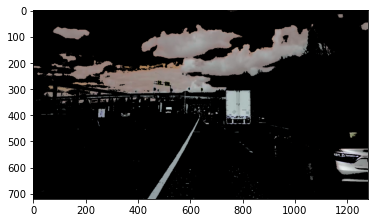

In [54]:
plt.imshow(masked_image)

In [55]:
def gaussian_smoothing(image, kernel_size = 13):

    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [56]:
gauss_image=gaussian_smoothing(masked_image)

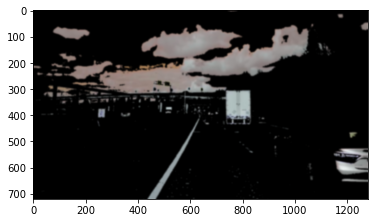

In [57]:
plt.imshow(gauss_image)

In [58]:
def canny_detector(image, low_threshold = 50, high_threshold = 150):

    return cv2.Canny(image, low_threshold, high_threshold)

In [59]:
edge_image=canny_detector(gauss_image)

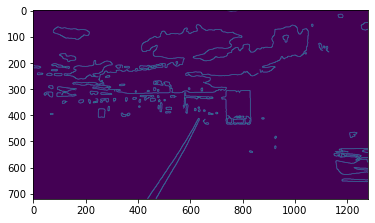

In [60]:
plt.imshow(edge_image)

In [61]:
def region_selection(image):

    mask = np.zeros_like(image)   
    #Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #We could have used fixed numbers as the vertices of the polygon,
    #but they will not be applicable to images with different dimesnions.
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [62]:
maskreg_image=region_selection(edge_image)

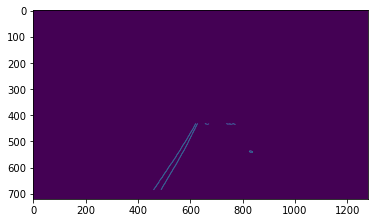

In [63]:
plt.imshow(maskreg_image)

(720, 1280)

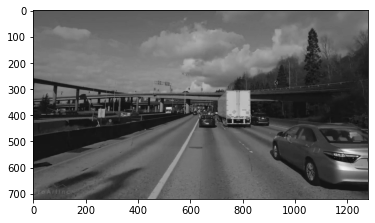

In [64]:
image_g = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(image_g, cmap = 'gray')  
image_g.shape

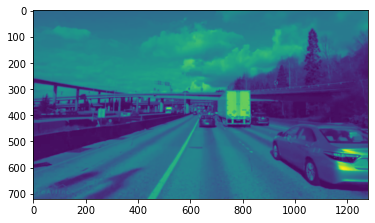

In [65]:
image_blurred = cv2.GaussianBlur(image_g, (7, 7), 0)
plt.imshow(image_blurred)  

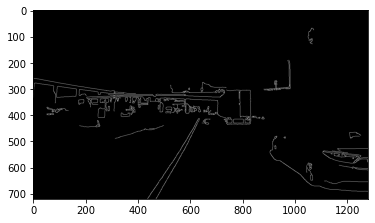

In [66]:
threshold_low = 10
threshold_high = 200

image_canny = cv2.Canny(image_blurred, threshold_low, threshold_high)
plt.imshow(image_canny, cmap = 'gray')  

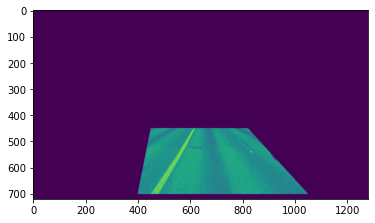

In [67]:
vertices = np.array([[(400,700),(450, 450), (820, 450), (1050,700)]], dtype=np.int32)    
mask = np.zeros_like(image_g)   
cv2.fillPoly(mask, vertices, 255)
masked_image = cv2.bitwise_and(image_g, mask)
plt.figure()
plt.imshow(masked_image)

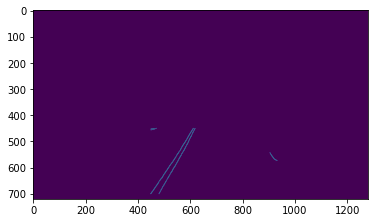

In [68]:
masked_image = cv2.bitwise_and(image_canny, mask)
plt.figure()
plt.imshow(masked_image)

In [69]:
rho = 2            # distance resolution in pixels 
theta = np.pi/180  # angular resolution in radians 
threshold = 40     # minimum number of votes 
min_line_len = 100  # minimum number of pixels making up a line
max_line_gap = 50  # maximum gap in pixels between connectable line segments    
lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
# Create an empty black image
line_image = np.zeros((masked_image.shape[0], masked_image.shape[1], 3), dtype=np.uint8)
    
for line in lines:
    for x1,y1,x2,y2 in line:      
        cv2.line(line_image, (x1, y1), (x2, y2), [255, 0, 0], 20)
lines 

array([[[481, 698, 593, 503]],

       [[450, 699, 566, 527]],

       [[530, 583, 613, 450]],

       [[548, 585, 616, 457]],

       [[457, 690, 563, 533]]], dtype=int32)

In [70]:
α = 1
β = 1
γ = 0    

# Resultant weighted image is calculated as follows: original_img * α + img * β + γ
Image_with_lines = cv2.addWeighted(image, α, line_image, β, γ)


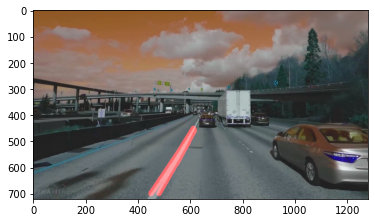

In [72]:
plt.figure()
plt.imshow(Image_with_lines)

In [73]:
def RGB_color_selection(image):
    """
    Apply color selection to RGB images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #White color mask
    lower_threshold = np.uint8([150, 150, 150])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([180, 180,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

## Applying on youtube data

In [74]:
lines1=[]

In [75]:
for images in os.listdir('fra/'):
    test_image = mpimg.imread('fra/'+images)
    t_image=test_image
    print(images)
    colorsel_image=RGB_color_selection(test_image)
    image_g = cv2.cvtColor(colorsel_image, cv2.COLOR_RGB2GRAY)
    image_blurred = cv2.GaussianBlur(image_g, (7, 7), 0)
    threshold_low = 20
    threshold_high =  200
    image_canny = cv2.Canny(image_blurred, threshold_low, threshold_high)
    vertices = np.array([[(400,700),(450, 450), (820, 450), (1050,700)]], dtype=np.int32)    
    mask = np.zeros_like(image_g)   
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(image_g, mask)
    masked_image = cv2.bitwise_and(image_canny, mask)
    rho = 2            # distance resolution in pixels 
    theta = np.pi/180  # angular resolution in radians 
    threshold = 40     # minimum number of votes 
    min_line_len = 100  # minimum number of pixels making up a line
    max_line_gap = 50  # maximum gap in pixels between connectable line segments    
    lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    print(lines)
    line_image = np.zeros((masked_image.shape[0], masked_image.shape[1], 3), dtype=np.uint8)
# Create an empty black image
    #line_image = np.zeros((masked_image.shape[0], masked_image.shape[1], 3), dtype=np.uint8)
    ref=[]
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:      
                cv2.line(line_image, (x1, y1), (x2, y2), [255, 0, 0], 20)
        print(lines)
   
        α = 1
        β = 1
        γ = 0    

# Resultant weighted image is calculated as follows: original_img * α + img * β + γ
        Image_with_lines = cv2.addWeighted(t_image, α, line_image, β, γ)
        cv2.imwrite('lanes/'+images,Image_with_lines)
    if lines is not None:
        lines1.append(1)
    else:
        lines1.append(0) 

frame0.jpg
[[[529 612 618 452]]

 [[478 677 614 450]]

 [[476 677 593 483]]

 [[477 669 613 451]]

 [[486 677 578 529]]

 [[483 676 577 530]]

 [[520 627 589 508]]

 [[479 662 571 520]]

 [[506 636 567 527]]]
[[[529 612 618 452]]

 [[478 677 614 450]]

 [[476 677 593 483]]

 [[477 669 613 451]]

 [[486 677 578 529]]

 [[483 676 577 530]]

 [[520 627 589 508]]

 [[479 662 571 520]]

 [[506 636 567 527]]]
frame1.jpg
[[[475 674 614 450]]

 [[538 598 601 484]]

 [[456 700 520 598]]

 [[453 698 540 594]]

 [[485 672 567 525]]

 [[473 681 561 539]]

 [[480 687 576 533]]

 [[473 683 610 456]]]
[[[475 674 614 450]]

 [[538 598 601 484]]

 [[456 700 520 598]]

 [[453 698 540 594]]

 [[485 672 567 525]]

 [[473 681 561 539]]

 [[480 687 576 533]]

 [[473 683 610 456]]]
frame10.jpg
[[[474 682 613 450]]

 [[482 697 542 589]]

 [[471 685 610 454]]

 [[521 629 588 508]]]
[[[474 682 613 450]]

 [[482 697 542 589]]

 [[471 685 610 454]]

 [[521 629 588 508]]]
frame100.jpg
[[[455 686 583 496]]

 [[428 

[[[401 695 604 453]]

 [[867 573 997 694]]

 [[433 699 610 456]]

 [[858 574 983 695]]

 [[432 700 610 455]]

 [[401 693 603 453]]

 [[868 573 988 685]]]
frame1026.jpg
[[[ 433  700  608  459]]

 [[ 401  695  603  454]]

 [[ 864  581  987  700]]

 [[ 877  583 1003  700]]

 [[ 484  628  609  455]]

 [[ 893  596 1004  700]]]
[[[ 433  700  608  459]]

 [[ 401  695  603  454]]

 [[ 864  581  987  700]]

 [[ 877  583 1003  700]]

 [[ 484  628  609  455]]

 [[ 893  596 1004  700]]]
frame1027.jpg
[[[ 401  695  601  456]]

 [[ 433  700  608  459]]

 [[ 872  590  986  700]]

 [[ 884  589 1003  700]]

 [[ 873  588  976  691]]

 [[ 401  696  602  456]]

 [[ 436  695  608  458]]

 [[ 901  604 1004  700]]]
[[[ 401  695  601  456]]

 [[ 433  700  608  459]]

 [[ 872  590  986  700]]

 [[ 884  589 1003  700]]

 [[ 873  588  976  691]]

 [[ 401  696  602  456]]

 [[ 436  695  608  458]]

 [[ 901  604 1004  700]]]
frame1028.jpg
[[[ 403  692  596  462]]

 [[ 433  700  607  460]]

 [[ 881  599  986  700]]

[[[401 700 511 568]]

 [[436 700 535 563]]

 [[414 685 542 528]]

 [[493 619 574 508]]

 [[417 686 500 580]]

 [[440 689 539 557]]]
[[[401 700 511 568]]

 [[436 700 535 563]]

 [[414 685 542 528]]

 [[493 619 574 508]]

 [[417 686 500 580]]

 [[440 689 539 557]]]
frame1056.jpg
[[[400 700 562 507]]

 [[459 670 571 511]]

 [[404 698 542 528]]

 [[489 626 571 512]]]
[[[400 700 562 507]]

 [[459 670 571 511]]

 [[404 698 542 528]]

 [[489 626 571 512]]]
frame1057.jpg
[[[401 699 560 510]]

 [[437 700 569 512]]

 [[419 680 547 522]]

 [[437 699 509 599]]]
[[[401 699 560 510]]

 [[437 700 569 512]]

 [[419 680 547 522]]

 [[437 699 509 599]]]
frame1058.jpg
[[[402 696 555 513]]

 [[445 689 567 515]]

 [[467 619 556 513]]]
[[[402 696 555 513]]

 [[445 689 567 515]]

 [[467 619 556 513]]]
frame1059.jpg
[[[469 655 564 520]]

 [[421 673 553 516]]

 [[446 644 554 516]]]
[[[469 655 564 520]]

 [[421 673 553 516]]

 [[446 644 554 516]]]
frame106.jpg
[[[434 685 577 494]]

 [[444 686 549 551]]

 [[444 

[[[466 626 572 490]]

 [[492 625 583 490]]

 [[464 625 595 463]]]
frame1126.jpg
[[[454 638 594 465]]

 [[489 630 584 490]]

 [[455 640 537 536]]]
[[[454 638 594 465]]

 [[489 630 584 490]]

 [[455 640 537 536]]]
frame1127.jpg
[[[442 652 595 463]]

 [[488 632 584 490]]

 [[443 655 570 493]]

 [[504 610 585 490]]]
[[[442 652 595 463]]

 [[488 632 584 490]]

 [[443 655 570 493]]

 [[504 610 585 490]]]
frame1128.jpg
[[[430 667 594 465]]

 [[452 681 585 492]]

 [[430 671 531 542]]

 [[486 635 584 490]]]
[[[430 667 594 465]]

 [[452 681 585 492]]

 [[430 671 531 542]]

 [[486 635 584 490]]]
frame1129.jpg
[[[412 689 594 464]]

 [[446 691 542 554]]

 [[511 597 584 492]]]
[[[412 689 594 464]]

 [[446 691 542 554]]

 [[511 597 584 492]]]
frame113.jpg
[[[486 646 613 450]]

 [[498 602 608 451]]

 [[474 663 612 451]]

 [[459 676 542 538]]

 [[467 655 568 504]]]
[[[486 646 613 450]]

 [[498 602 608 451]]

 [[474 663 612 451]]

 [[459 676 542 538]]

 [[467 655 568 504]]]
frame1130.jpg
[[[458 676 584 

[[[401 693 591 466]]

 [[471 646 598 470]]

 [[401 695 523 545]]]
frame1156.jpg
[[[441 644 603 450]]

 [[466 653 582 493]]]
[[[441 644 603 450]]

 [[466 653 582 493]]]
frame1157.jpg
[[[443 642 604 450]]

 [[470 647 604 462]]

 [[453 672 562 521]]

 [[428 661 589 469]]

 [[500 601 582 492]]]
[[[443 642 604 450]]

 [[470 647 604 462]]

 [[453 672 562 521]]

 [[428 661 589 469]]

 [[500 601 582 492]]]
frame1158.jpg
[[[427 661 604 450]]

 [[458 664 609 455]]

 [[451 674 570 510]]]
[[[427 661 604 450]]

 [[458 664 609 455]]

 [[451 674 570 510]]]
frame1159.jpg
[[[401 694 599 457]]

 [[456 666 611 452]]

 [[435 697 586 488]]

 [[413 678 604 450]]]
[[[401 694 599 457]]

 [[456 666 611 452]]

 [[435 697 586 488]]

 [[413 678 604 450]]]
frame116.jpg
[[[461 651 607 450]]

 [[498 626 578 506]]

 [[446 698 520 589]]

 [[530 559 605 453]]

 [[445 693 548 550]]

 [[446 700 556 537]]]
[[[461 651 607 450]]

 [[498 626 578 506]]

 [[446 698 520 589]]

 [[530 559 605 453]]

 [[445 693 548 550]]

 [[446 

frame1189.jpg
[[[ 425  670  604  450]]

 [[ 436  700  611  450]]

 [[ 908  609 1009  700]]

 [[ 437  699  612  450]]

 [[ 428  669  521  550]]]
[[[ 425  670  604  450]]

 [[ 436  700  611  450]]

 [[ 908  609 1009  700]]

 [[ 437  699  612  450]]

 [[ 428  669  521  550]]]
frame119.jpg
[[[455 685 611 454]]

 [[430 695 608 450]]

 [[466 673 540 563]]

 [[446 690 612 452]]

 [[431 695 590 476]]

 [[432 699 613 450]]

 [[443 700 567 522]]

 [[444 699 521 566]]

 [[465 673 601 471]]

 [[445 698 588 486]]

 [[495 603 604 453]]]
[[[455 685 611 454]]

 [[430 695 608 450]]

 [[466 673 540 563]]

 [[446 690 612 452]]

 [[431 695 590 476]]

 [[432 699 613 450]]

 [[443 700 567 522]]

 [[444 699 521 566]]

 [[465 673 601 471]]

 [[445 698 588 486]]

 [[495 603 604 453]]]
frame1190.jpg
[[[414 685 604 450]]

 [[436 700 611 450]]

 [[437 699 612 450]]

 [[400 699 517 555]]

 [[415 688 496 581]]]
[[[414 685 604 450]]

 [[436 700 611 450]]

 [[437 699 612 450]]

 [[400 699 517 555]]

 [[415 688 496 58

[[[440 698 614 450]]

 [[404 700 607 450]]

 [[735 453 894 612]]

 [[738 451 909 616]]

 [[405 700 544 528]]

 [[462 666 612 452]]

 [[745 459 891 610]]

 [[780 497 910 614]]]
[[[440 698 614 450]]

 [[404 700 607 450]]

 [[735 453 894 612]]

 [[738 451 909 616]]

 [[405 700 544 528]]

 [[462 666 612 452]]

 [[745 459 891 610]]

 [[780 497 910 614]]]
frame122.jpg
[[[451 664 607 450]]

 [[458 680 611 453]]

 [[466 672 569 519]]

 [[455 670 599 464]]

 [[456 680 611 451]]

 [[456 664 600 465]]

 [[456 678 579 489]]

 [[457 671 612 450]]

 [[457 680 534 570]]

 [[456 671 583 490]]

 [[456 667 548 530]]]
[[[451 664 607 450]]

 [[458 680 611 453]]

 [[466 672 569 519]]

 [[455 670 599 464]]

 [[456 680 611 451]]

 [[456 664 600 465]]

 [[456 678 579 489]]

 [[457 671 612 450]]

 [[457 680 534 570]]

 [[456 671 583 490]]

 [[456 667 548 530]]]
frame1220.jpg
[[[411 690 587 473]]

 [[438 700 613 450]]

 [[735 452 908 625]]

 [[737 451 860 569]]]
[[[411 690 587 473]]

 [[438 700 613 450]]

 [[73

frame1237.jpg
[[[437 695 610 457]]

 [[411 691 594 465]]

 [[409 689 505 571]]

 [[413 700 521 561]]

 [[415 691 508 568]]

 [[422 699 501 597]]

 [[438 700 519 580]]

 [[463 624 599 461]]

 [[423 691 520 562]]

 [[418 679 515 567]]

 [[425 697 524 561]]

 [[413 699 514 561]]

 [[416 686 515 568]]

 [[414 700 525 563]]

 [[420 685 521 564]]]
[[[437 695 610 457]]

 [[411 691 594 465]]

 [[409 689 505 571]]

 [[413 700 521 561]]

 [[415 691 508 568]]

 [[422 699 501 597]]

 [[438 700 519 580]]

 [[463 624 599 461]]

 [[423 691 520 562]]

 [[418 679 515 567]]

 [[425 697 524 561]]

 [[413 699 514 561]]

 [[416 686 515 568]]

 [[414 700 525 563]]

 [[420 685 521 564]]]
frame1238.jpg
[[[427 668 564 504]]

 [[438 699 600 469]]

 [[506 573 596 463]]

 [[452 675 611 456]]

 [[414 699 502 587]]

 [[421 697 504 587]]

 [[419 698 500 590]]

 [[439 699 513 590]]

 [[429 670 526 547]]

 [[415 699 495 585]]

 [[411 699 499 587]]

 [[413 698 500 587]]]
[[[427 668 564 504]]

 [[438 699 600 469]]

 [[5

[[[408 697 608 450]]

 [[442 698 616 450]]

 [[425 700 524 564]]

 [[413 699 596 465]]

 [[412 697 560 508]]

 [[431 695 526 564]]

 [[436 696 516 582]]

 [[424 700 545 528]]]
frame1253.jpg
[[[407 700 609 450]]

 [[443 697 616 450]]

 [[446 692 615 451]]

 [[420 700 557 512]]

 [[424 696 522 570]]

 [[413 699 514 565]]

 [[435 689 524 571]]

 [[419 697 515 570]]

 [[425 696 517 570]]

 [[413 700 513 573]]

 [[411 693 608 450]]]
[[[407 700 609 450]]

 [[443 697 616 450]]

 [[446 692 615 451]]

 [[420 700 557 512]]

 [[424 696 522 570]]

 [[413 699 514 565]]

 [[435 689 524 571]]

 [[419 697 515 570]]

 [[425 696 517 570]]

 [[413 700 513 573]]

 [[411 693 608 450]]]
frame1254.jpg
[[[407 698 607 451]]

 [[442 697 615 450]]

 [[414 697 513 566]]

 [[406 700 546 527]]]
[[[407 698 607 451]]

 [[442 697 615 450]]

 [[414 697 513 566]]

 [[406 700 546 527]]]
frame1255.jpg
[[[440 700 615 450]]

 [[405 700 608 450]]

 [[423 698 526 552]]

 [[424 691 502 580]]

 [[416 700 493 591]]]
[[[440 700 6

frame1274.jpg
[[[436 700 611 450]]

 [[413 685 603 450]]

 [[409 700 492 594]]

 [[468 655 587 485]]

 [[415 685 519 556]]

 [[413 682 521 553]]

 [[418 685 600 453]]]
[[[436 700 611 450]]

 [[413 685 603 450]]

 [[409 700 492 594]]

 [[468 655 587 485]]

 [[415 685 519 556]]

 [[413 682 521 553]]

 [[418 685 600 453]]]
frame1275.jpg
[[[437 698 611 450]]

 [[401 700 604 450]]

 [[443 691 553 534]]

 [[403 699 590 468]]

 [[409 699 514 560]]]
[[[437 698 611 450]]

 [[401 700 604 450]]

 [[443 691 553 534]]

 [[403 699 590 468]]

 [[409 699 514 560]]]
frame1276.jpg
[[[407 691 600 453]]

 [[436 699 611 450]]

 [[409 694 537 531]]

 [[412 696 493 592]]

 [[414 695 554 510]]

 [[435 700 504 593]]

 [[410 688 541 526]]

 [[480 638 583 491]]

 [[415 699 496 592]]]
[[[407 691 600 453]]

 [[436 699 611 450]]

 [[409 694 537 531]]

 [[412 696 493 592]]

 [[414 695 554 510]]

 [[435 700 504 593]]

 [[410 688 541 526]]

 [[480 638 583 491]]

 [[415 699 496 592]]]
frame1277.jpg
[[[438 696 611 450]]

frame1297.jpg
[[[401 696 576 480]]

 [[464 656 609 450]]

 [[407 696 570 488]]

 [[406 689 542 521]]

 [[402 700 486 596]]]
[[[401 696 576 480]]

 [[464 656 609 450]]

 [[407 696 570 488]]

 [[406 689 542 521]]

 [[402 700 486 596]]]
frame1298.jpg
[[[432 700 601 460]]

 [[411 685 600 452]]

 [[453 630 540 530]]]
[[[432 700 601 460]]

 [[411 685 600 452]]

 [[453 630 540 530]]]
frame1299.jpg
[[[436 695 607 452]]

 [[401 696 592 461]]

 [[411 700 576 481]]

 [[402 693 485 591]]

 [[427 687 580 476]]

 [[406 697 594 472]]

 [[403 696 521 551]]

 [[410 700 496 594]]

 [[527 564 609 450]]

 [[421 682 552 509]]]
[[[436 695 607 452]]

 [[401 696 592 461]]

 [[411 700 576 481]]

 [[402 693 485 591]]

 [[427 687 580 476]]

 [[406 697 594 472]]

 [[403 696 521 551]]

 [[410 700 496 594]]

 [[527 564 609 450]]

 [[421 682 552 509]]]
frame13.jpg
[[[484 661 571 521]]

 [[534 604 616 456]]

 [[487 663 579 504]]

 [[496 665 571 540]]

 [[485 661 555 544]]

 [[540 599 592 497]]]
[[[484 661 571 521]]



frame1311.jpg
[[[404 693 601 450]]

 [[434 693 588 481]]

 [[431 700 542 546]]

 [[453 629 591 464]]]
[[[404 693 601 450]]

 [[434 693 588 481]]

 [[431 700 542 546]]

 [[453 629 591 464]]]
frame1312.jpg
[[[445 643 601 450]]

 [[460 661 608 450]]

 [[445 639 588 468]]

 [[434 696 518 577]]]
[[[445 643 601 450]]

 [[460 661 608 450]]

 [[445 639 588 468]]

 [[434 696 518 577]]]
frame1313.jpg
[[[507 595 609 450]]

 [[435 651 588 468]]

 [[435 650 593 461]]

 [[516 582 608 450]]]
[[[507 595 609 450]]

 [[435 651 588 468]]

 [[435 650 593 461]]

 [[516 582 608 450]]]
frame1314.jpg
[[[474 640 607 451]]

 [[422 666 583 474]]

 [[494 579 601 451]]

 [[430 700 568 509]]]
[[[474 640 607 451]]

 [[422 666 583 474]]

 [[494 579 601 451]]

 [[430 700 568 509]]]
frame1315.jpg
[[[406 685 582 475]]

 [[473 642 608 450]]

 [[406 684 593 461]]

 [[459 659 570 506]]]
[[[406 685 582 475]]

 [[473 642 608 450]]

 [[406 684 593 461]]

 [[459 659 570 506]]]
frame1316.jpg
[[[462 658 608 450]]

 [[402 690 590

[[[435 697 579 492]]

 [[414 681 595 457]]

 [[465 624 554 506]]

 [[419 674 595 456]]]
frame1345.jpg
[[[404 691 595 456]]

 [[456 667 579 492]]

 [[401 694 491 586]]

 [[403 695 592 461]]

 [[431 700 521 576]]]
[[[404 691 595 456]]

 [[456 667 579 492]]

 [[401 694 491 586]]

 [[403 695 592 461]]

 [[431 700 521 576]]]
frame1346.jpg
[[[403 694 601 450]]

 [[435 697 608 450]]

 [[849 559 950 656]]

 [[433 684 529 537]]

 [[845 557 950 655]]

 [[412 686 536 528]]

 [[839 557 939 657]]]
[[[403 694 601 450]]

 [[435 697 608 450]]

 [[849 559 950 656]]

 [[433 684 529 537]]

 [[845 557 950 655]]

 [[412 686 536 528]]

 [[839 557 939 657]]]
frame1347.jpg
[[[403 694 601 450]]

 [[433 699 608 450]]

 [[845 565 952 672]]

 [[851 563 966 670]]

 [[402 700 545 517]]

 [[432 700 514 586]]]
[[[403 694 601 450]]

 [[433 699 608 450]]

 [[845 565 952 672]]

 [[851 563 966 670]]

 [[402 700 545 517]]

 [[432 700 514 586]]]
frame1348.jpg
[[[439 692 609 450]]

 [[401 696 599 452]]

 [[860 571 977 680]]

frame1370.jpg
[[[407 677 597 450]]

 [[422 700 604 450]]

 [[409 675 499 565]]

 [[407 689 500 578]]

 [[417 688 506 578]]

 [[424 695 537 544]]

 [[411 689 501 578]]

 [[403 685 496 578]]

 [[408 689 498 581]]

 [[423 688 560 512]]

 [[402 690 499 578]]]
[[[407 677 597 450]]

 [[422 700 604 450]]

 [[409 675 499 565]]

 [[407 689 500 578]]

 [[417 688 506 578]]

 [[424 695 537 544]]

 [[411 689 501 578]]

 [[403 685 496 578]]

 [[408 689 498 581]]

 [[423 688 560 512]]

 [[402 690 499 578]]]
frame1371.jpg
[[[407 675 561 492]]

 [[425 696 604 450]]

 [[422 700 557 514]]

 [[402 689 575 476]]

 [[404 697 502 572]]

 [[404 689 498 573]]

 [[410 698 505 573]]

 [[416 698 507 573]]

 [[427 682 506 573]]

 [[404 681 593 455]]

 [[418 698 509 573]]]
[[[407 675 561 492]]

 [[425 696 604 450]]

 [[422 700 557 514]]

 [[402 689 575 476]]

 [[404 697 502 572]]

 [[404 689 498 573]]

 [[410 698 505 573]]

 [[416 698 507 573]]

 [[427 682 506 573]]

 [[404 681 593 455]]

 [[418 698 509 573]]]
fram

frame1388.jpg
[[[406 670 597 450]]

 [[415 700 604 450]]

 [[405 678 593 455]]

 [[403 690 528 530]]

 [[415 695 569 498]]

 [[412 695 506 556]]

 [[416 662 520 539]]

 [[408 696 526 555]]]
[[[406 670 597 450]]

 [[415 700 604 450]]

 [[405 678 593 455]]

 [[403 690 528 530]]

 [[415 695 569 498]]

 [[412 695 506 556]]

 [[416 662 520 539]]

 [[408 696 526 555]]]
frame1389.jpg
[[[408 668 596 452]]

 [[414 697 566 502]]

 [[405 696 491 590]]

 [[402 693 488 590]]

 [[418 696 522 558]]

 [[403 693 519 564]]]
[[[408 668 596 452]]

 [[414 697 566 502]]

 [[405 696 491 590]]

 [[402 693 488 590]]

 [[418 696 522 558]]

 [[403 693 519 564]]]
frame139.jpg
[[[464 644 605 450]]

 [[470 658 572 512]]

 [[438 697 611 450]]

 [[440 696 602 464]]

 [[430 699 610 451]]

 [[456 652 594 463]]

 [[438 684 595 468]]

 [[440 700 590 485]]

 [[433 699 533 561]]

 [[456 651 589 486]]]
[[[464 644 605 450]]

 [[470 658 572 512]]

 [[438 697 611 450]]

 [[440 696 602 464]]

 [[430 699 610 451]]

 [[456 652 59

frame1407.jpg
[[[430 625 588 450]]

 [[413 684 596 450]]

 [[410 650 568 474]]

 [[424 637 557 499]]

 [[401 697 587 459]]

 [[410 648 587 452]]

 [[409 656 517 537]]

 [[403 688 500 572]]

 [[406 672 528 536]]

 [[411 675 498 574]]

 [[408 660 553 504]]

 [[411 662 519 537]]

 [[410 656 515 540]]

 [[407 675 498 566]]

 [[408 672 499 564]]

 [[402 696 595 450]]]
[[[430 625 588 450]]

 [[413 684 596 450]]

 [[410 650 568 474]]

 [[424 637 557 499]]

 [[401 697 587 459]]

 [[410 648 587 452]]

 [[409 656 517 537]]

 [[403 688 500 572]]

 [[406 672 528 536]]

 [[411 675 498 574]]

 [[408 660 553 504]]

 [[411 662 519 537]]

 [[410 656 515 540]]

 [[407 675 498 566]]

 [[408 672 499 564]]

 [[402 696 595 450]]]
frame1408.jpg
[[[410 649 584 455]]

 [[436 653 595 450]]

 [[401 695 515 550]]

 [[411 648 561 482]]

 [[402 695 525 520]]

 [[408 668 523 531]]

 [[413 651 521 531]]

 [[404 679 553 489]]

 [[411 674 521 534]]

 [[409 657 563 492]]

 [[403 690 479 589]]

 [[405 679 512 542]]

 [[4

[[[403 684 543 517]]

 [[412 646 589 450]]

 [[411 650 520 533]]

 [[403 687 595 451]]

 [[411 645 501 545]]

 [[412 650 525 524]]

 [[414 651 571 482]]

 [[410 650 590 450]]

 [[407 675 556 485]]

 [[408 677 521 533]]

 [[415 651 561 494]]

 [[421 650 526 537]]

 [[416 651 507 550]]]
[[[403 684 543 517]]

 [[412 646 589 450]]

 [[411 650 520 533]]

 [[403 687 595 451]]

 [[411 645 501 545]]

 [[412 650 525 524]]

 [[414 651 571 482]]

 [[410 650 590 450]]

 [[407 675 556 485]]

 [[408 677 521 533]]

 [[415 651 561 494]]

 [[421 650 526 537]]

 [[416 651 507 550]]]
frame1423.jpg
[[[413 639 589 450]]

 [[403 686 582 466]]

 [[421 637 547 511]]

 [[419 636 515 533]]

 [[404 678 499 548]]

 [[405 679 597 450]]

 [[410 650 541 519]]

 [[407 665 525 520]]

 [[403 684 533 529]]

 [[413 640 537 524]]

 [[419 640 510 539]]

 [[409 665 543 516]]]
[[[413 639 589 450]]

 [[403 686 582 466]]

 [[421 637 547 511]]

 [[419 636 515 533]]

 [[404 678 499 548]]

 [[405 679 597 450]]

 [[410 650 541 519

frame144.jpg
[[[436 677 606 452]]

 [[505 610 611 453]]

 [[442 686 608 457]]

 [[452 685 599 459]]

 [[435 686 612 451]]

 [[450 686 547 531]]

 [[440 686 598 460]]

 [[434 685 597 461]]

 [[451 686 571 515]]

 [[466 642 585 485]]]
[[[436 677 606 452]]

 [[505 610 611 453]]

 [[442 686 608 457]]

 [[452 685 599 459]]

 [[435 686 612 451]]

 [[450 686 547 531]]

 [[440 686 598 460]]

 [[434 685 597 461]]

 [[451 686 571 515]]

 [[466 642 585 485]]]
frame1440.jpg
[[[402 688 506 560]]

 [[444 606 592 452]]

 [[416 663 597 454]]

 [[410 649 561 482]]

 [[410 653 505 548]]

 [[409 665 506 549]]

 [[411 664 507 549]]

 [[408 674 537 525]]

 [[403 686 492 576]]

 [[410 658 503 551]]

 [[418 661 507 550]]

 [[412 653 545 500]]

 [[410 648 536 526]]]
[[[402 688 506 560]]

 [[444 606 592 452]]

 [[416 663 597 454]]

 [[410 649 561 482]]

 [[410 653 505 548]]

 [[409 665 506 549]]

 [[411 664 507 549]]

 [[408 674 537 525]]

 [[403 686 492 576]]

 [[410 658 503 551]]

 [[418 661 507 550]]

 [[41

frame1457.jpg
[[[427 627 598 450]]

 [[402 689 599 455]]

 [[411 673 605 450]]

 [[427 626 597 450]]

 [[417 672 499 550]]

 [[405 678 492 567]]

 [[407 665 487 563]]

 [[418 642 524 532]]

 [[438 645 549 513]]]
[[[427 627 598 450]]

 [[402 689 599 455]]

 [[411 673 605 450]]

 [[427 626 597 450]]

 [[417 672 499 550]]

 [[405 678 492 567]]

 [[407 665 487 563]]

 [[418 642 524 532]]

 [[438 645 549 513]]]
frame1458.jpg
[[[413 671 605 450]]

 [[411 643 579 469]]

 [[411 676 525 544]]

 [[414 647 598 450]]

 [[410 649 562 487]]

 [[416 654 524 534]]

 [[411 644 524 531]]

 [[408 676 510 541]]

 [[420 641 524 533]]

 [[419 653 519 530]]]
[[[413 671 605 450]]

 [[411 643 579 469]]

 [[411 676 525 544]]

 [[414 647 598 450]]

 [[410 649 562 487]]

 [[416 654 524 534]]

 [[411 644 524 531]]

 [[408 676 510 541]]

 [[420 641 524 533]]

 [[419 653 519 530]]]
frame1459.jpg
[[[411 675 606 450]]

 [[413 643 599 450]]

 [[415 671 566 497]]

 [[410 653 528 531]]

 [[411 644 598 450]]

 [[409 661 5

[[[418 674 606 450]]

 [[405 688 603 453]]

 [[414 643 600 450]]

 [[410 649 587 465]]]
[[[418 674 606 450]]

 [[405 688 603 453]]

 [[414 643 600 450]]

 [[410 649 587 465]]]
frame1474.jpg
[[[431 659 607 450]]

 [[416 645 550 501]]

 [[401 693 604 452]]

 [[431 637 599 450]]

 [[404 684 494 573]]

 [[407 671 545 507]]

 [[409 654 596 454]]

 [[406 685 494 576]]

 [[405 684 486 569]]]
[[[431 659 607 450]]

 [[416 645 550 501]]

 [[401 693 604 452]]

 [[431 637 599 450]]

 [[404 684 494 573]]

 [[407 671 545 507]]

 [[409 654 596 454]]

 [[406 685 494 576]]

 [[405 684 486 569]]]
frame1475.jpg
[[[401 694 606 450]]

 [[413 648 539 513]]

 [[411 652 600 450]]

 [[402 692 554 511]]

 [[408 659 550 502]]

 [[404 685 509 546]]

 [[409 668 533 521]]

 [[405 678 504 551]]]
[[[401 694 606 450]]

 [[413 648 539 513]]

 [[411 652 600 450]]

 [[402 692 554 511]]

 [[408 659 550 502]]

 [[404 685 509 546]]

 [[409 668 533 521]]

 [[405 678 504 551]]]
frame1476.jpg
[[[404 691 607 450]]

 [[416 642 5

[[[406 689 596 463]]

 [[410 649 597 456]]

 [[404 691 494 580]]

 [[409 677 512 554]]

 [[411 664 512 551]]

 [[409 669 502 565]]

 [[411 652 509 550]]

 [[409 661 509 554]]

 [[403 685 505 564]]

 [[409 657 511 551]]

 [[406 686 568 499]]

 [[410 652 590 459]]

 [[409 671 512 553]]

 [[404 685 503 567]]]
[[[406 689 596 463]]

 [[410 649 597 456]]

 [[404 691 494 580]]

 [[409 677 512 554]]

 [[411 664 512 551]]

 [[409 669 502 565]]

 [[411 652 509 550]]

 [[409 661 509 554]]

 [[403 685 505 564]]

 [[409 657 511 551]]

 [[406 686 568 499]]

 [[410 652 590 459]]

 [[409 671 512 553]]

 [[404 685 503 567]]]
frame1494.jpg
[[[423 636 597 455]]

 [[407 686 550 521]]

 [[412 651 595 455]]

 [[409 656 510 551]]

 [[401 695 518 556]]

 [[455 614 594 455]]

 [[410 681 532 541]]

 [[410 651 597 457]]]
[[[423 636 597 455]]

 [[407 686 550 521]]

 [[412 651 595 455]]

 [[409 656 510 551]]

 [[401 695 518 556]]

 [[455 614 594 455]]

 [[410 681 532 541]]

 [[410 651 597 457]]]
frame1495.jpg
[[[4

[[[403 698 576 492]]

 [[854 584 966 699]]

 [[408 660 596 459]]

 [[847 583 946 696]]

 [[430 671 575 492]]

 [[402 698 499 573]]

 [[416 664 542 514]]

 [[853 584 957 691]]

 [[421 664 549 507]]

 [[409 695 501 560]]

 [[413 691 492 587]]

 [[402 691 499 571]]

 [[410 659 589 467]]

 [[404 700 489 587]]

 [[401 698 485 587]]

 [[415 664 529 528]]]
frame1508.jpg
[[[408 664 589 464]]

 [[407 700 575 492]]

 [[854 594 950 700]]

 [[862 594 960 695]]

 [[407 683 499 573]]

 [[407 664 543 513]]

 [[404 678 502 565]]

 [[459 623 537 520]]

 [[408 698 487 598]]

 [[406 678 499 571]]]
[[[408 664 589 464]]

 [[407 700 575 492]]

 [[854 594 950 700]]

 [[862 594 960 695]]

 [[407 683 499 573]]

 [[407 664 543 513]]

 [[404 678 502 565]]

 [[459 623 537 520]]

 [[408 698 487 598]]

 [[406 678 499 571]]]
frame1509.jpg
[[[406 700 574 493]]

 [[411 661 565 490]]

 [[409 661 554 501]]

 [[441 658 566 504]]

 [[407 698 493 588]]

 [[408 687 499 574]]

 [[400 700 491 588]]

 [[403 687 498 574]]

 [[4

frame1523.jpg
[[[408 691 610 450]]

 [[411 655 594 459]]

 [[403 700 490 597]]

 [[411 654 582 471]]

 [[408 674 511 556]]

 [[406 669 509 555]]

 [[408 692 609 452]]

 [[404 689 501 573]]

 [[412 675 511 557]]

 [[405 689 501 574]]

 [[408 660 539 533]]

 [[407 690 498 560]]

 [[408 669 510 555]]

 [[412 658 507 556]]]
[[[408 691 610 450]]

 [[411 655 594 459]]

 [[403 700 490 597]]

 [[411 654 582 471]]

 [[408 674 511 556]]

 [[406 669 509 555]]

 [[408 692 609 452]]

 [[404 689 501 573]]

 [[412 675 511 557]]

 [[405 689 501 574]]

 [[408 660 539 533]]

 [[407 690 498 560]]

 [[408 669 510 555]]

 [[412 658 507 556]]]
frame1524.jpg
[[[414 651 583 470]]

 [[404 700 555 514]]

 [[408 696 585 478]]

 [[414 667 501 567]]

 [[426 655 520 535]]

 [[400 700 502 555]]]
[[[414 651 583 470]]

 [[404 700 555 514]]

 [[408 696 585 478]]

 [[414 667 501 567]]

 [[426 655 520 535]]

 [[400 700 502 555]]]
frame1525.jpg
[[[403 700 597 461]]

 [[408 696 597 463]]

 [[419 645 563 491]]

 [[420 646 5

frame1537.jpg
[[[409 664 604 455]]

 [[461 638 612 452]]

 [[413 665 605 452]]

 [[411 697 536 526]]

 [[408 664 607 450]]

 [[408 700 490 599]]

 [[410 675 536 535]]

 [[404 687 534 537]]

 [[404 679 534 535]]

 [[404 690 535 535]]

 [[411 664 560 515]]

 [[408 661 572 502]]

 [[422 684 545 516]]

 [[405 690 516 571]]]
[[[409 664 604 455]]

 [[461 638 612 452]]

 [[413 665 605 452]]

 [[411 697 536 526]]

 [[408 664 607 450]]

 [[408 700 490 599]]

 [[410 675 536 535]]

 [[404 687 534 537]]

 [[404 679 534 535]]

 [[404 690 535 535]]

 [[411 664 560 515]]

 [[408 661 572 502]]

 [[422 684 545 516]]

 [[405 690 516 571]]]
frame1538.jpg
[[[446 656 613 450]]

 [[408 664 608 450]]

 [[407 664 607 450]]

 [[402 696 528 546]]

 [[409 668 526 546]]

 [[437 666 609 454]]

 [[406 700 518 561]]

 [[408 668 522 546]]

 [[404 700 505 561]]

 [[411 691 524 546]]

 [[408 700 506 560]]

 [[434 667 517 549]]

 [[402 700 497 570]]]
[[[446 656 613 450]]

 [[408 664 608 450]]

 [[407 664 607 450]]

 [[4

frame155.jpg
[[[462 643 600 460]]

 [[480 652 557 538]]

 [[455 683 558 536]]

 [[424 697 518 572]]

 [[426 699 599 460]]

 [[482 651 562 528]]

 [[449 679 552 521]]]
[[[462 643 600 460]]

 [[480 652 557 538]]

 [[455 683 558 536]]

 [[424 697 518 572]]

 [[426 699 599 460]]

 [[482 651 562 528]]

 [[449 679 552 521]]]
frame1550.jpg
[[[414 700 608 460]]

 [[407 669 606 455]]

 [[411 671 505 570]]

 [[402 691 509 572]]

 [[405 700 504 583]]

 [[406 691 500 583]]

 [[414 696 505 584]]

 [[413 697 509 574]]

 [[414 671 507 571]]

 [[414 691 502 586]]

 [[422 652 610 450]]

 [[404 686 505 574]]

 [[419 697 609 455]]

 [[408 671 505 571]]

 [[408 691 499 586]]

 [[416 699 517 571]]

 [[412 691 503 583]]]
[[[414 700 608 460]]

 [[407 669 606 455]]

 [[411 671 505 570]]

 [[402 691 509 572]]

 [[405 700 504 583]]

 [[406 691 500 583]]

 [[414 696 505 584]]

 [[413 697 509 574]]

 [[414 671 507 571]]

 [[414 691 502 586]]

 [[422 652 610 450]]

 [[404 686 505 574]]

 [[419 697 609 455]]

 [[40

frame1561.jpg
[[[416 695 608 450]]

 [[418 655 602 450]]

 [[415 695 603 455]]

 [[401 699 506 564]]

 [[407 670 502 564]]

 [[404 700 555 500]]

 [[442 658 563 492]]

 [[411 697 531 543]]

 [[408 670 503 564]]

 [[401 700 531 540]]

 [[423 651 550 505]]

 [[407 699 529 543]]

 [[409 675 505 564]]]
[[[416 695 608 450]]

 [[418 655 602 450]]

 [[415 695 603 455]]

 [[401 699 506 564]]

 [[407 670 502 564]]

 [[404 700 555 500]]

 [[442 658 563 492]]

 [[411 697 531 543]]

 [[408 670 503 564]]

 [[401 700 531 540]]

 [[423 651 550 505]]

 [[407 699 529 543]]

 [[409 675 505 564]]]
frame1562.jpg
[[[416 656 600 452]]

 [[430 676 605 453]]

 [[416 693 597 461]]

 [[403 697 511 564]]

 [[407 696 529 529]]

 [[404 697 515 545]]

 [[409 696 508 564]]

 [[410 696 513 564]]

 [[408 696 536 521]]]
[[[416 656 600 452]]

 [[430 676 605 453]]

 [[416 693 597 461]]

 [[403 697 511 564]]

 [[407 696 529 529]]

 [[404 697 515 545]]

 [[409 696 508 564]]

 [[410 696 513 564]]

 [[408 696 536 521]]]
fram

[[[414 700 595 469]]

 [[425 648 573 484]]

 [[836 570 935 672]]

 [[408 677 605 450]]

 [[412 700 586 470]]

 [[405 676 558 501]]

 [[419 677 525 547]]

 [[409 699 515 563]]

 [[414 699 583 483]]

 [[409 677 613 450]]

 [[425 650 612 450]]

 [[424 677 526 546]]

 [[415 676 523 547]]

 [[417 700 506 557]]]
frame1575.jpg
[[[415 699 590 475]]

 [[849 575 967 689]]

 [[416 658 586 470]]

 [[844 578 955 693]]

 [[419 659 607 457]]

 [[417 659 612 450]]

 [[408 699 590 466]]

 [[410 700 605 450]]

 [[427 660 552 506]]

 [[857 581 967 691]]

 [[401 699 582 475]]

 [[841 576 954 693]]

 [[405 699 520 553]]

 [[416 699 540 535]]

 [[422 660 602 453]]

 [[413 700 566 490]]

 [[465 602 610 452]]]
[[[415 699 590 475]]

 [[849 575 967 689]]

 [[416 658 586 470]]

 [[844 578 955 693]]

 [[419 659 607 457]]

 [[417 659 612 450]]

 [[408 699 590 466]]

 [[410 700 605 450]]

 [[427 660 552 506]]

 [[857 581 967 691]]

 [[401 699 582 475]]

 [[841 576 954 693]]

 [[405 699 520 553]]

 [[416 699 540 535

[[[407 700 590 475]]

 [[405 697 542 516]]

 [[409 696 558 499]]

 [[417 657 580 476]]

 [[459 641 542 532]]

 [[414 696 582 474]]

 [[428 658 532 535]]

 [[404 697 523 550]]

 [[409 700 612 450]]

 [[429 658 599 456]]

 [[417 654 539 519]]

 [[407 696 539 533]]

 [[413 697 501 588]]

 [[404 691 521 552]]

 [[421 657 527 539]]]
frame1587.jpg
[[[425 684 579 488]]

 [[412 678 528 540]]

 [[474 591 584 472]]

 [[416 690 533 540]]

 [[419 678 531 540]]

 [[421 678 612 450]]

 [[416 691 535 539]]

 [[406 678 523 543]]

 [[404 700 526 554]]

 [[413 678 519 556]]

 [[489 573 583 473]]

 [[423 686 500 567]]

 [[418 673 529 540]]

 [[455 647 537 538]]

 [[405 673 522 544]]

 [[422 681 498 569]]]
[[[425 684 579 488]]

 [[412 678 528 540]]

 [[474 591 584 472]]

 [[416 690 533 540]]

 [[419 678 531 540]]

 [[421 678 612 450]]

 [[416 691 535 539]]

 [[406 678 523 543]]

 [[404 700 526 554]]

 [[413 678 519 556]]

 [[489 573 583 473]]

 [[423 686 500 567]]

 [[418 673 529 540]]

 [[455 647 537 538

[[[403 699 551 523]]

 [[450 614 603 450]]

 [[411 680 511 565]]

 [[410 684 569 500]]

 [[414 688 531 548]]

 [[404 681 508 565]]

 [[400 699 512 565]]

 [[410 680 510 565]]

 [[405 681 509 565]]

 [[408 700 522 538]]]
[[[403 699 551 523]]

 [[450 614 603 450]]

 [[411 680 511 565]]

 [[410 684 569 500]]

 [[414 688 531 548]]

 [[404 681 508 565]]

 [[400 699 512 565]]

 [[410 680 510 565]]

 [[405 681 509 565]]

 [[408 700 522 538]]]
frame1603.jpg
[[[440 628 535 523]]

 [[403 700 552 522]]

 [[416 663 576 479]]

 [[426 664 611 451]]

 [[419 660 588 466]]

 [[404 700 527 553]]

 [[402 699 530 529]]

 [[427 660 517 552]]

 [[426 671 550 507]]

 [[412 695 473 590]]

 [[400 699 507 572]]

 [[438 629 533 527]]

 [[417 664 516 550]]]
[[[440 628 535 523]]

 [[403 700 552 522]]

 [[416 663 576 479]]

 [[426 664 611 451]]

 [[419 660 588 466]]

 [[404 700 527 553]]

 [[402 699 530 529]]

 [[427 660 517 552]]

 [[426 671 550 507]]

 [[412 695 473 590]]

 [[400 699 507 572]]

 [[438 629 533 527

frame1617.jpg
[[[418 658 591 466]]

 [[412 697 612 450]]

 [[408 697 551 508]]

 [[459 608 563 496]]

 [[419 658 510 557]]

 [[413 697 531 551]]

 [[405 698 516 561]]

 [[403 697 523 538]]

 [[426 658 516 558]]

 [[425 658 515 554]]

 [[409 692 526 537]]

 [[411 697 502 577]]

 [[416 655 518 546]]

 [[421 658 516 556]]]
[[[418 658 591 466]]

 [[412 697 612 450]]

 [[408 697 551 508]]

 [[459 608 563 496]]

 [[419 658 510 557]]

 [[413 697 531 551]]

 [[405 698 516 561]]

 [[403 697 523 538]]

 [[426 658 516 558]]

 [[425 658 515 554]]

 [[409 692 526 537]]

 [[411 697 502 577]]

 [[416 655 518 546]]

 [[421 658 516 556]]]
frame1618.jpg
[[[414 694 612 450]]

 [[431 641 575 482]]

 [[414 696 524 560]]

 [[408 678 511 559]]

 [[406 673 516 551]]

 [[417 687 504 575]]

 [[418 678 512 562]]

 [[417 678 512 561]]

 [[417 685 503 575]]

 [[412 678 512 559]]

 [[404 678 563 496]]

 [[407 678 510 559]]

 [[464 628 613 450]]]
[[[414 694 612 450]]

 [[431 641 575 482]]

 [[414 696 524 560]]

 [[4

[[[404 699 549 526]]

 [[414 658 595 458]]

 [[425 653 588 466]]

 [[437 653 581 487]]

 [[426 678 585 482]]

 [[420 653 603 450]]

 [[402 690 510 565]]

 [[413 658 529 529]]

 [[424 679 609 450]]]
frame1634.jpg
[[[407 667 597 456]]

 [[411 695 608 452]]

 [[412 695 610 450]]

 [[409 674 497 572]]

 [[432 640 603 450]]

 [[409 694 490 594]]

 [[408 691 504 572]]

 [[402 690 501 572]]

 [[410 674 489 573]]

 [[419 688 497 564]]

 [[408 694 492 570]]

 [[412 674 500 572]]]
[[[407 667 597 456]]

 [[411 695 608 452]]

 [[412 695 610 450]]

 [[409 674 497 572]]

 [[432 640 603 450]]

 [[409 694 490 594]]

 [[408 691 504 572]]

 [[402 690 501 572]]

 [[410 674 489 573]]

 [[419 688 497 564]]

 [[408 694 492 570]]

 [[412 674 500 572]]]
frame1635.jpg
[[[409 699 610 451]]

 [[413 658 531 528]]

 [[417 658 604 450]]

 [[440 659 607 453]]

 [[401 693 562 495]]

 [[406 699 550 508]]

 [[411 656 603 450]]

 [[409 698 610 450]]

 [[422 658 528 532]]

 [[409 696 510 566]]

 [[426 659 537 522]]

 [[4

frame1654.jpg
[[[414 695 573 492]]

 [[419 652 601 450]]

 [[414 696 603 455]]

 [[459 606 588 463]]]
[[[414 695 573 492]]

 [[419 652 601 450]]

 [[414 696 603 455]]

 [[459 606 588 463]]]
frame1655.jpg
[[[405 700 607 450]]

 [[442 624 570 482]]

 [[435 670 518 561]]

 [[413 661 560 492]]

 [[417 653 554 501]]

 [[412 689 509 574]]]
[[[405 700 607 450]]

 [[442 624 570 482]]

 [[435 670 518 561]]

 [[413 661 560 492]]

 [[417 653 554 501]]

 [[412 689 509 574]]]
frame1656.jpg
[[[433 633 559 493]]

 [[429 676 605 451]]

 [[406 669 547 507]]

 [[408 700 525 551]]

 [[406 668 519 538]]

 [[431 674 508 573]]]
[[[433 633 559 493]]

 [[429 676 605 451]]

 [[406 669 547 507]]

 [[408 700 525 551]]

 [[406 668 519 538]]

 [[431 674 508 573]]]
frame1657.jpg
[[[419 648 570 481]]

 [[410 699 599 458]]

 [[410 698 569 495]]

 [[411 658 518 539]]]
[[[419 648 570 481]]

 [[410 699 599 458]]

 [[410 698 569 495]]

 [[411 658 518 539]]]
frame1658.jpg
[[[431 670 574 488]]

 [[435 627 564 489]]

 [[440

frame168.jpg
[[[439 669 603 452]]

 [[478 643 578 500]]

 [[439 667 535 540]]

 [[519 568 606 453]]

 [[427 700 577 501]]

 [[443 665 585 489]]

 [[520 568 604 452]]

 [[501 600 593 477]]

 [[522 568 602 461]]

 [[442 671 578 484]]

 [[430 698 568 514]]

 [[440 659 606 454]]

 [[479 643 567 517]]]
[[[439 669 603 452]]

 [[478 643 578 500]]

 [[439 667 535 540]]

 [[519 568 606 453]]

 [[427 700 577 501]]

 [[443 665 585 489]]

 [[520 568 604 452]]

 [[501 600 593 477]]

 [[522 568 602 461]]

 [[442 671 578 484]]

 [[430 698 568 514]]

 [[440 659 606 454]]

 [[479 643 567 517]]]
frame1680.jpg
[[[415 679 594 459]]

 [[412 646 595 450]]

 [[407 684 603 450]]

 [[403 687 483 581]]

 [[407 688 526 541]]

 [[403 688 483 582]]

 [[431 623 545 505]]]
[[[415 679 594 459]]

 [[412 646 595 450]]

 [[407 684 603 450]]

 [[403 687 483 581]]

 [[407 688 526 541]]

 [[403 688 483 582]]

 [[431 623 545 505]]]
frame1681.jpg
[[[413 644 574 472]]

 [[401 695 563 496]]

 [[401 694 523 544]]

 [[408 666 53

frame171.jpg
[[[440 669 601 456]]

 [[434 695 550 541]]

 [[433 694 603 460]]

 [[475 645 601 452]]

 [[439 668 603 450]]

 [[477 644 575 504]]

 [[441 670 602 456]]

 [[511 584 595 472]]

 [[510 583 584 481]]

 [[453 669 586 486]]

 [[518 574 607 451]]

 [[434 689 497 588]]]
[[[440 669 601 456]]

 [[434 695 550 541]]

 [[433 694 603 460]]

 [[475 645 601 452]]

 [[439 668 603 450]]

 [[477 644 575 504]]

 [[441 670 602 456]]

 [[511 584 595 472]]

 [[510 583 584 481]]

 [[453 669 586 486]]

 [[518 574 607 451]]

 [[434 689 497 588]]]
frame1710.jpg
[[[463 595 589 450]]

 [[430 607 582 450]]

 [[421 612 547 490]]]
[[[463 595 589 450]]

 [[430 607 582 450]]

 [[421 612 547 490]]]
frame1711.jpg
[[[412 648 590 450]]

 [[417 615 582 450]]

 [[438 622 575 464]]

 [[477 557 575 456]]

 [[468 589 589 450]]]
[[[412 648 590 450]]

 [[417 615 582 450]]

 [[438 622 575 464]]

 [[477 557 575 456]]

 [[468 589 589 450]]]
frame1712.jpg
[[[410 652 550 496]]

 [[417 616 583 450]]

 [[424 610 567 467]]


frame1744.jpg
[[[419 647 603 450]]

 [[427 613 596 450]]

 [[845 592 945 699]]

 [[837 594 927 697]]

 [[418 620 546 500]]

 [[437 627 535 525]]]
[[[419 647 603 450]]

 [[427 613 596 450]]

 [[845 592 945 699]]

 [[837 594 927 697]]

 [[418 620 546 500]]

 [[437 627 535 525]]]
frame1745.jpg
[[[426 615 597 450]]

 [[415 652 604 450]]

 [[483 581 605 450]]

 [[434 608 598 450]]]
[[[426 615 597 450]]

 [[415 652 604 450]]

 [[483 581 605 450]]

 [[434 608 598 450]]]
frame1746.jpg
[[[414 628 598 450]]

 [[412 657 605 450]]

 [[411 655 538 524]]]
[[[414 628 598 450]]

 [[412 657 605 450]]

 [[411 655 538 524]]]
frame1747.jpg
[[[414 629 599 450]]

 [[419 651 607 450]]

 [[411 656 547 515]]]
[[[414 629 599 450]]

 [[419 651 607 450]]

 [[411 656 547 515]]]
frame1748.jpg
[[[410 662 607 450]]

 [[414 631 601 450]]

 [[414 630 600 450]]

 [[411 662 580 480]]]
[[[410 662 607 450]]

 [[414 631 601 450]]

 [[414 630 600 450]]

 [[411 662 580 480]]]
frame1749.jpg
[[[426 621 553 498]]

 [[409 664 608

[[[439 634 605 450]]

 [[415 637 591 454]]

 [[477 569 596 450]]

 [[440 634 541 522]]

 [[429 634 513 534]]

 [[411 646 519 546]]

 [[450 607 564 496]]]
[[[439 634 605 450]]

 [[415 637 591 454]]

 [[477 569 596 450]]

 [[440 634 541 522]]

 [[429 634 513 534]]

 [[411 646 519 546]]

 [[450 607 564 496]]]
frame1768.jpg
[[[415 632 597 450]]

 [[437 642 604 450]]

 [[414 642 530 534]]

 [[435 639 591 466]]

 [[416 653 597 459]]

 [[413 645 515 550]]

 [[412 641 542 520]]

 [[419 653 533 530]]]
[[[415 632 597 450]]

 [[437 642 604 450]]

 [[414 642 530 534]]

 [[435 639 591 466]]

 [[416 653 597 459]]

 [[413 645 515 550]]

 [[412 641 542 520]]

 [[419 653 533 530]]]
frame1769.jpg
[[[454 622 604 450]]

 [[415 632 597 450]]

 [[408 664 571 489]]

 [[408 662 508 555]]

 [[439 635 606 450]]

 [[414 643 550 511]]

 [[411 647 514 551]]]
[[[454 622 604 450]]

 [[415 632 597 450]]

 [[408 664 571 489]]

 [[408 662 508 555]]

 [[439 635 606 450]]

 [[414 643 550 511]]

 [[411 647 514 551]]]
fram

frame1795.jpg
[[[411 643 569 480]]

 [[410 678 567 497]]

 [[422 634 599 450]]

 [[403 683 502 569]]

 [[428 659 543 523]]

 [[403 684 553 512]]

 [[411 644 588 461]]]
[[[411 643 569 480]]

 [[410 678 567 497]]

 [[422 634 599 450]]

 [[403 683 502 569]]

 [[428 659 543 523]]

 [[403 684 553 512]]

 [[411 644 588 461]]]
frame1796.jpg
[[[411 643 561 488]]

 [[504 570 604 451]]

 [[409 680 500 572]]

 [[413 671 503 571]]

 [[420 635 576 473]]

 [[407 671 529 540]]

 [[405 681 606 450]]]
[[[411 643 561 488]]

 [[504 570 604 451]]

 [[409 680 500 572]]

 [[413 671 503 571]]

 [[420 635 576 473]]

 [[407 671 529 540]]

 [[405 681 606 450]]]
frame1797.jpg
[[[411 643 568 480]]

 [[482 595 604 450]]

 [[403 686 559 506]]

 [[442 612 575 474]]

 [[404 682 494 578]]

 [[411 678 496 577]]]
[[[411 643 568 480]]

 [[482 595 604 450]]

 [[403 686 559 506]]

 [[442 612 575 474]]

 [[404 682 494 578]]

 [[411 678 496 577]]]
frame1798.jpg
[[[412 641 575 473]]

 [[450 632 603 450]]

 [[410 676 606 451]]

frame182.jpg
[[[469 661 605 459]]

 [[474 631 602 454]]

 [[438 698 590 480]]

 [[435 697 548 535]]

 [[492 608 604 454]]

 [[463 666 544 547]]

 [[432 694 548 534]]

 [[471 660 563 523]]

 [[474 629 591 468]]

 [[436 696 524 554]]]
[[[469 661 605 459]]

 [[474 631 602 454]]

 [[438 698 590 480]]

 [[435 697 548 535]]

 [[492 608 604 454]]

 [[463 666 544 547]]

 [[432 694 548 534]]

 [[471 660 563 523]]

 [[474 629 591 468]]

 [[436 696 524 554]]]
frame1820.jpg
[[[414 630 594 450]]

 [[406 672 599 450]]

 [[416 643 529 513]]

 [[410 664 494 560]]

 [[406 671 593 456]]

 [[409 660 493 560]]

 [[414 631 520 542]]]
[[[414 630 594 450]]

 [[406 672 599 450]]

 [[416 643 529 513]]

 [[410 664 494 560]]

 [[406 671 593 456]]

 [[409 660 493 560]]

 [[414 631 520 542]]]
frame1821.jpg
[[[406 671 594 455]]

 [[415 629 562 482]]

 [[409 668 599 450]]

 [[450 592 592 450]]

 [[414 637 527 516]]

 [[415 628 593 450]]]
[[[406 671 594 455]]

 [[415 629 562 482]]

 [[409 668 599 450]]

 [[450 592 59

frame1835.jpg
[[[412 663 604 450]]

 [[420 630 571 474]]

 [[411 663 601 452]]

 [[410 648 505 546]]

 [[408 661 509 545]]

 [[410 663 509 537]]

 [[414 649 507 546]]

 [[409 663 512 545]]

 [[410 649 506 546]]]
[[[412 663 604 450]]

 [[420 630 571 474]]

 [[411 663 601 452]]

 [[410 648 505 546]]

 [[408 661 509 545]]

 [[410 663 509 537]]

 [[414 649 507 546]]

 [[409 663 512 545]]

 [[410 649 506 546]]]
frame1836.jpg
[[[839 566 944 675]]

 [[831 567 930 677]]

 [[425 651 558 498]]

 [[489 555 589 458]]

 [[416 647 563 495]]

 [[406 669 507 552]]

 [[417 651 573 484]]

 [[425 626 591 454]]

 [[408 667 544 516]]

 [[417 655 533 512]]

 [[848 575 943 677]]]
[[[839 566 944 675]]

 [[831 567 930 677]]

 [[425 651 558 498]]

 [[489 555 589 458]]

 [[416 647 563 495]]

 [[406 669 507 552]]

 [[417 651 573 484]]

 [[425 626 591 454]]

 [[408 667 544 516]]

 [[417 655 533 512]]

 [[848 575 943 677]]]
frame1837.jpg
[[[417 651 604 450]]

 [[846 574 966 698]]

 [[480 563 597 450]]

 [[840 574 9

[[[412 663 598 457]]

 [[421 630 555 492]]

 [[423 630 520 529]]

 [[415 663 606 450]]

 [[426 630 559 488]]

 [[408 664 576 471]]

 [[409 664 552 505]]

 [[430 631 599 450]]

 [[419 628 572 475]]

 [[420 630 569 491]]

 [[411 659 605 451]]

 [[414 660 592 456]]]
[[[412 663 598 457]]

 [[421 630 555 492]]

 [[423 630 520 529]]

 [[415 663 606 450]]

 [[426 630 559 488]]

 [[408 664 576 471]]

 [[409 664 552 505]]

 [[430 631 599 450]]

 [[419 628 572 475]]

 [[420 630 569 491]]

 [[411 659 605 451]]

 [[414 660 592 456]]]
frame1855.jpg
[[[434 618 585 462]]

 [[431 647 587 468]]

 [[433 618 556 491]]

 [[420 648 605 450]]

 [[414 648 530 523]]

 [[427 648 606 450]]

 [[413 644 526 527]]

 [[426 648 542 515]]

 [[423 644 540 515]]

 [[419 648 593 455]]

 [[479 590 598 458]]]
[[[434 618 585 462]]

 [[431 647 587 468]]

 [[433 618 556 491]]

 [[420 648 605 450]]

 [[414 648 530 523]]

 [[427 648 606 450]]

 [[413 644 526 527]]

 [[426 648 542 515]]

 [[423 644 540 515]]

 [[419 648 593 455

frame1872.jpg
[[[867 590 974 700]]

 [[420 651 576 483]]

 [[858 591 956 700]]

 [[412 651 606 450]]

 [[415 651 547 514]]

 [[426 651 537 527]]

 [[424 652 547 505]]

 [[422 652 572 486]]

 [[429 650 532 528]]

 [[423 652 543 514]]]
[[[867 590 974 700]]

 [[420 651 576 483]]

 [[858 591 956 700]]

 [[412 651 606 450]]

 [[415 651 547 514]]

 [[426 651 537 527]]

 [[424 652 547 505]]

 [[422 652 572 486]]

 [[429 650 532 528]]

 [[423 652 543 514]]]
frame1873.jpg
[[[867 600 957 700]]

 [[412 670 598 457]]

 [[407 671 534 520]]

 [[409 672 504 559]]

 [[407 669 532 520]]

 [[431 637 606 450]]

 [[441 636 537 518]]

 [[442 620 596 460]]]
[[[867 600 957 700]]

 [[412 670 598 457]]

 [[407 671 534 520]]

 [[409 672 504 559]]

 [[407 669 532 520]]

 [[431 637 606 450]]

 [[441 636 537 518]]

 [[442 620 596 460]]]
frame1874.jpg
[[[421 654 605 450]]

 [[422 654 605 451]]

 [[426 654 539 519]]

 [[416 652 600 454]]

 [[419 654 537 518]]]
[[[421 654 605 450]]

 [[422 654 605 451]]

 [[426 654 5

frame1893.jpg
[[[413 662 610 451]]

 [[505 547 605 450]]

 [[484 591 611 450]]

 [[411 662 566 496]]

 [[481 591 564 489]]

 [[422 662 563 489]]

 [[496 565 594 460]]]
[[[413 662 610 451]]

 [[505 547 605 450]]

 [[484 591 611 450]]

 [[411 662 566 496]]

 [[481 591 564 489]]

 [[422 662 563 489]]

 [[496 565 594 460]]]
frame1894.jpg
[[[405 680 612 450]]

 [[420 646 595 459]]

 [[424 646 528 542]]

 [[423 646 606 450]]

 [[416 665 577 486]]

 [[426 646 568 494]]

 [[427 646 601 453]]

 [[405 682 568 495]]

 [[468 591 592 471]]

 [[419 646 578 476]]

 [[416 646 554 513]]]
[[[405 680 612 450]]

 [[420 646 595 459]]

 [[424 646 528 542]]

 [[423 646 606 450]]

 [[416 665 577 486]]

 [[426 646 568 494]]

 [[427 646 601 453]]

 [[405 682 568 495]]

 [[468 591 592 471]]

 [[419 646 578 476]]

 [[416 646 554 513]]]
frame1895.jpg
[[[418 666 612 450]]

 [[434 633 603 452]]

 [[411 666 609 453]]

 [[408 666 570 493]]

 [[433 633 590 465]]

 [[417 666 572 482]]

 [[420 662 597 459]]]
[[[418 666 6

frame1909.jpg
[[[428 659 616 450]]

 [[414 659 605 455]]

 [[415 659 610 450]]

 [[414 677 589 483]]

 [[418 659 588 477]]

 [[408 658 590 470]]

 [[424 659 586 480]]

 [[400 698 604 464]]

 [[410 659 520 545]]

 [[416 659 611 450]]

 [[445 644 560 502]]

 [[414 676 617 450]]]
[[[428 659 616 450]]

 [[414 659 605 455]]

 [[415 659 610 450]]

 [[414 677 589 483]]

 [[418 659 588 477]]

 [[408 658 590 470]]

 [[424 659 586 480]]

 [[400 698 604 464]]

 [[410 659 520 545]]

 [[416 659 611 450]]

 [[445 644 560 502]]

 [[414 676 617 450]]]
frame191.jpg
[[[498 592 604 451]]

 [[488 630 609 450]]

 [[497 596 607 450]]

 [[443 681 574 488]]

 [[490 628 579 496]]

 [[496 614 569 509]]]
[[[498 592 604 451]]

 [[488 630 609 450]]

 [[497 596 607 450]]

 [[443 681 574 488]]

 [[490 628 579 496]]

 [[496 614 569 509]]]
frame1910.jpg
[[[411 679 617 450]]

 [[503 557 610 450]]

 [[408 679 591 476]]

 [[406 679 609 453]]

 [[406 674 566 497]]

 [[421 641 582 490]]

 [[473 616 590 476]]

 [[427 643 57

frame1923.jpg
[[[494 598 600 472]]

 [[416 656 615 450]]

 [[420 658 621 450]]

 [[459 628 580 484]]

 [[417 658 603 465]]

 [[463 628 605 459]]

 [[478 613 607 465]]

 [[430 658 605 470]]

 [[416 658 594 474]]

 [[481 612 583 482]]

 [[402 692 553 512]]]
[[[494 598 600 472]]

 [[416 656 615 450]]

 [[420 658 621 450]]

 [[459 628 580 484]]

 [[417 658 603 465]]

 [[463 628 605 459]]

 [[478 613 607 465]]

 [[430 658 605 470]]

 [[416 658 594 474]]

 [[481 612 583 482]]

 [[402 692 553 512]]]
frame1924.jpg
[[[463 607 615 450]]

 [[409 678 622 450]]

 [[483 609 605 464]]

 [[473 617 605 470]]

 [[404 678 561 504]]

 [[407 678 611 460]]

 [[405 678 602 467]]

 [[475 617 619 452]]

 [[476 614 583 482]]

 [[406 674 531 535]]

 [[470 617 552 513]]

 [[406 678 584 481]]]
[[[463 607 615 450]]

 [[409 678 622 450]]

 [[483 609 605 464]]

 [[473 617 605 470]]

 [[404 678 561 504]]

 [[407 678 611 460]]

 [[405 678 602 467]]

 [[475 617 619 452]]

 [[476 614 583 482]]

 [[406 674 531 535]]

 [[4

frame1938.jpg
[[[455 619 575 490]]

 [[422 687 620 450]]

 [[456 619 576 490]]

 [[404 685 623 450]]

 [[407 685 586 493]]

 [[404 681 582 490]]

 [[424 686 551 535]]

 [[423 682 584 490]]

 [[417 686 577 495]]

 [[432 647 578 490]]

 [[414 681 580 490]]]
[[[455 619 575 490]]

 [[422 687 620 450]]

 [[456 619 576 490]]

 [[404 685 623 450]]

 [[407 685 586 493]]

 [[404 681 582 490]]

 [[424 686 551 535]]

 [[423 682 584 490]]

 [[417 686 577 495]]

 [[432 647 578 490]]

 [[414 681 580 490]]]
frame1939.jpg
[[[414 670 576 490]]

 [[441 670 584 493]]

 [[433 670 579 490]]

 [[466 610 578 490]]

 [[417 670 540 547]]

 [[434 670 580 490]]

 [[416 670 569 511]]

 [[439 670 585 490]]

 [[429 670 517 553]]

 [[415 670 620 450]]

 [[423 671 521 558]]

 [[435 670 586 490]]

 [[430 670 548 520]]]
[[[414 670 576 490]]

 [[441 670 584 493]]

 [[433 670 579 490]]

 [[466 610 578 490]]

 [[417 670 540 547]]

 [[434 670 580 490]]

 [[416 670 569 511]]

 [[439 670 585 490]]

 [[429 670 517 553]]

 [[4

frame1953.jpg
[[[424 691 626 450]]

 [[466 615 581 491]]

 [[416 691 621 455]]

 [[422 691 585 490]]

 [[403 687 575 496]]

 [[429 686 564 525]]

 [[402 689 574 511]]

 [[414 690 622 450]]

 [[405 690 518 565]]

 [[489 587 621 450]]

 [[430 691 548 541]]

 [[407 690 569 517]]]
[[[424 691 626 450]]

 [[466 615 581 491]]

 [[416 691 621 455]]

 [[422 691 585 490]]

 [[403 687 575 496]]

 [[429 686 564 525]]

 [[402 689 574 511]]

 [[414 690 622 450]]

 [[405 690 518 565]]

 [[489 587 621 450]]

 [[430 691 548 541]]

 [[407 690 569 517]]]
frame1954.jpg
[[[416 674 581 491]]

 [[442 676 622 454]]

 [[435 676 621 454]]

 [[419 675 588 493]]

 [[418 675 532 549]]

 [[468 613 582 491]]

 [[423 671 561 528]]

 [[433 676 620 453]]

 [[460 642 564 509]]

 [[427 675 547 527]]

 [[445 675 584 490]]

 [[416 675 540 542]]

 [[426 675 622 450]]]
[[[416 674 581 491]]

 [[442 676 622 454]]

 [[435 676 621 454]]

 [[419 675 588 493]]

 [[418 675 532 549]]

 [[468 613 582 491]]

 [[423 671 561 528]]

 [[4

[[[ 402  689  581  490]]

 [[ 463  655  620  453]]

 [[ 898  602 1000  700]]

 [[ 408  692  623  453]]

 [[ 454  655  622  455]]

 [[ 402  692  525  555]]

 [[ 406  692  520  566]]

 [[ 410  692  587  495]]

 [[ 418  693  548  548]]

 [[ 439  655  547  527]]

 [[ 429  693  619  450]]

 [[ 886  592  998  697]]

 [[ 413  693  567  504]]

 [[ 420  692  621  453]]

 [[ 416  693  586  490]]

 [[ 462  655  620  452]]]
frame1967.jpg
[[[461 624 582 490]]

 [[445 678 620 454]]

 [[417 674 578 507]]

 [[440 677 623 451]]

 [[438 677 620 452]]

 [[422 677 573 498]]

 [[433 677 624 450]]

 [[426 677 620 453]]

 [[423 677 519 566]]

 [[417 675 520 560]]

 [[421 672 568 520]]]
[[[461 624 582 490]]

 [[445 678 620 454]]

 [[417 674 578 507]]

 [[440 677 623 451]]

 [[438 677 620 452]]

 [[422 677 573 498]]

 [[433 677 624 450]]

 [[426 677 620 453]]

 [[423 677 519 566]]

 [[417 675 520 560]]

 [[421 672 568 520]]]
frame1968.jpg
[[[477 606 582 490]]

 [[417 698 624 451]]

 [[427 700 620 453]]

 [[431

frame1981.jpg
[[[426 670 617 450]]

 [[452 671 624 450]]

 [[426 668 610 457]]

 [[444 671 621 453]]

 [[437 671 580 506]]

 [[434 671 537 552]]

 [[426 671 583 502]]

 [[429 671 541 559]]

 [[469 624 580 505]]

 [[462 636 562 529]]]
[[[426 670 617 450]]

 [[452 671 624 450]]

 [[426 668 610 457]]

 [[444 671 621 453]]

 [[437 671 580 506]]

 [[434 671 537 552]]

 [[426 671 583 502]]

 [[429 671 541 559]]

 [[469 624 580 505]]

 [[462 636 562 529]]]
frame1982.jpg
[[[402 696 611 456]]

 [[430 697 620 454]]

 [[432 697 579 508]]

 [[412 696 562 529]]

 [[403 696 518 568]]

 [[418 697 535 553]]

 [[410 696 495 595]]

 [[425 697 531 561]]

 [[429 697 608 468]]

 [[415 697 520 567]]

 [[410 691 514 571]]

 [[423 697 534 555]]]
[[[402 696 611 456]]

 [[430 697 620 454]]

 [[432 697 579 508]]

 [[412 696 562 529]]

 [[403 696 518 568]]

 [[418 697 535 553]]

 [[410 696 495 595]]

 [[425 697 531 561]]

 [[429 697 608 468]]

 [[415 697 520 567]]

 [[410 691 514 571]]

 [[423 697 534 555]]]
fram

frame1995.jpg
[[[ 455  673  558  536]]

 [[ 485  605  606  461]]

 [[ 448  673  620  454]]

 [[ 888  599  993  700]]

 [[ 898  596 1010  700]]

 [[ 445  674  538  550]]

 [[ 441  674  537  551]]

 [[ 435  674  534  552]]

 [[ 407  700  506  582]]

 [[ 452  673  540  552]]

 [[ 451  669  540  551]]

 [[ 513  569  617  450]]

 [[ 888  597  992  698]]

 [[ 437  674  537  550]]

 [[ 899  596 1011  700]]

 [[ 450  674  559  534]]

 [[ 431  674  571  518]]]
[[[ 455  673  558  536]]

 [[ 485  605  606  461]]

 [[ 448  673  620  454]]

 [[ 888  599  993  700]]

 [[ 898  596 1010  700]]

 [[ 445  674  538  550]]

 [[ 441  674  537  551]]

 [[ 435  674  534  552]]

 [[ 407  700  506  582]]

 [[ 452  673  540  552]]

 [[ 451  669  540  551]]

 [[ 513  569  617  450]]

 [[ 888  597  992  698]]

 [[ 437  674  537  550]]

 [[ 899  596 1011  700]]

 [[ 450  674  559  534]]

 [[ 431  674  571  518]]]
frame1996.jpg
[[[405 699 589 480]]

 [[428 700 623 450]]

 [[427 700 539 551]]

 [[415 700 536 551]]



[[[436 693 613 459]]

 [[428 669 595 470]]

 [[484 621 613 451]]

 [[436 672 529 561]]

 [[433 694 567 522]]

 [[442 674 590 491]]

 [[442 672 532 561]]

 [[444 671 600 465]]

 [[529 557 622 450]]

 [[499 614 577 490]]

 [[460 642 555 537]]]
frame2008.jpg
[[[435 694 609 464]]

 [[493 589 613 451]]

 [[441 651 615 450]]

 [[436 694 618 453]]

 [[429 671 563 506]]]
[[[435 694 609 464]]

 [[493 589 613 451]]

 [[441 651 615 450]]

 [[436 694 618 453]]

 [[429 671 563 506]]]
frame2009.jpg
[[[485 601 599 466]]

 [[466 655 619 452]]

 [[521 556 608 456]]

 [[435 673 622 450]]

 [[485 603 612 452]]

 [[464 653 567 512]]

 [[467 656 595 480]]

 [[444 674 529 562]]]
[[[485 601 599 466]]

 [[466 655 619 452]]

 [[521 556 608 456]]

 [[435 673 622 450]]

 [[485 603 612 452]]

 [[464 653 567 512]]

 [[467 656 595 480]]

 [[444 674 529 562]]]
frame201.jpg
[[[454 682 597 462]]

 [[420 700 564 503]]

 [[429 685 537 537]]

 [[429 686 613 450]]

 [[446 688 581 481]]

 [[447 668 605 451]]

 [[435 700 60

frame2025.jpg
[[[456 665 618 450]]

 [[484 596 611 450]]

 [[445 642 610 452]]

 [[457 665 619 450]]

 [[437 653 549 541]]

 [[430 662 542 550]]

 [[437 663 540 553]]

 [[464 649 576 505]]

 [[471 653 537 534]]]
[[[456 665 618 450]]

 [[484 596 611 450]]

 [[445 642 610 452]]

 [[457 665 619 450]]

 [[437 653 549 541]]

 [[430 662 542 550]]

 [[437 663 540 553]]

 [[464 649 576 505]]

 [[471 653 537 534]]]
frame2026.jpg
[[[411 681 607 455]]

 [[446 677 614 454]]

 [[432 663 545 524]]

 [[459 624 547 522]]

 [[448 673 604 466]]]
[[[411 681 607 455]]

 [[446 677 614 454]]

 [[432 663 545 524]]

 [[459 624 547 522]]

 [[448 673 604 466]]]
frame2027.jpg
[[[496 581 610 450]]

 [[456 665 618 450]]

 [[411 683 501 580]]

 [[427 661 609 452]]

 [[415 683 501 581]]

 [[418 678 528 568]]

 [[454 664 603 467]]

 [[413 684 564 522]]]
[[[496 581 610 450]]

 [[456 665 618 450]]

 [[411 683 501 580]]

 [[427 661 609 452]]

 [[415 683 501 581]]

 [[418 678 528 568]]

 [[454 664 603 467]]

 [[413 684 5

frame2047.jpg
[[[446 632 604 451]]

 [[424 699 611 451]]

 [[410 681 571 495]]

 [[850 553 952 648]]

 [[420 699 573 496]]

 [[462 613 596 459]]

 [[505 574 606 450]]

 [[472 625 599 457]]

 [[407 679 575 499]]

 [[849 553 952 649]]

 [[439 641 548 535]]

 [[462 625 605 460]]

 [[425 698 612 450]]]
[[[446 632 604 451]]

 [[424 699 611 451]]

 [[410 681 571 495]]

 [[850 553 952 648]]

 [[420 699 573 496]]

 [[462 613 596 459]]

 [[505 574 606 450]]

 [[472 625 599 457]]

 [[407 679 575 499]]

 [[849 553 952 649]]

 [[439 641 548 535]]

 [[462 625 605 460]]

 [[425 698 612 450]]]
frame2048.jpg
[[[422 699 601 462]]

 [[423 657 593 462]]

 [[853 564 963 670]]

 [[459 643 605 450]]

 [[863 563 975 668]]

 [[423 659 566 511]]

 [[861 562 974 671]]

 [[423 660 612 450]]

 [[422 697 572 497]]

 [[429 657 591 477]]

 [[423 658 601 454]]

 [[458 646 555 526]]

 [[859 562 976 671]]

 [[424 698 579 477]]

 [[429 655 559 520]]]
[[[422 699 601 462]]

 [[423 657 593 462]]

 [[853 564 963 670]]

 [[4

frame2060.jpg
[[[433 679 612 450]]

 [[424 666 596 468]]

 [[462 649 590 467]]

 [[448 628 548 513]]

 [[404 680 584 473]]

 [[422 700 597 468]]

 [[405 684 555 511]]

 [[426 697 606 458]]

 [[423 666 595 468]]

 [[420 700 561 506]]

 [[406 679 605 451]]

 [[419 700 607 450]]]
[[[433 679 612 450]]

 [[424 666 596 468]]

 [[462 649 590 467]]

 [[448 628 548 513]]

 [[404 680 584 473]]

 [[422 700 597 468]]

 [[405 684 555 511]]

 [[426 697 606 458]]

 [[423 666 595 468]]

 [[420 700 561 506]]

 [[406 679 605 451]]

 [[419 700 607 450]]]
frame2061.jpg
[[[495 573 606 450]]

 [[420 698 614 450]]

 [[406 679 613 450]]

 [[460 613 594 469]]

 [[422 700 595 463]]

 [[405 682 543 529]]

 [[420 700 517 576]]

 [[407 683 593 476]]

 [[488 606 595 469]]

 [[433 679 533 555]]

 [[437 641 607 458]]

 [[454 620 566 512]]

 [[420 663 526 537]]

 [[484 614 582 475]]]
[[[495 573 606 450]]

 [[420 698 614 450]]

 [[406 679 613 450]]

 [[460 613 594 469]]

 [[422 700 595 463]]

 [[405 682 543 529]]

 [[4

frame2074.jpg
[[[473 628 609 459]]

 [[405 680 567 494]]

 [[407 681 496 579]]

 [[423 700 582 490]]

 [[430 657 542 528]]

 [[423 695 598 463]]

 [[510 569 604 465]]

 [[423 698 610 450]]

 [[404 678 520 553]]

 [[408 681 616 450]]

 [[423 699 560 518]]

 [[434 677 549 535]]

 [[406 677 538 526]]]
[[[473 628 609 459]]

 [[405 680 567 494]]

 [[407 681 496 579]]

 [[423 700 582 490]]

 [[430 657 542 528]]

 [[423 695 598 463]]

 [[510 569 604 465]]

 [[423 698 610 450]]

 [[404 678 520 553]]

 [[408 681 616 450]]

 [[423 699 560 518]]

 [[434 677 549 535]]

 [[406 677 538 526]]]
frame2075.jpg
[[[478 629 600 468]]

 [[414 667 609 450]]

 [[407 681 615 450]]

 [[419 700 603 456]]

 [[423 700 526 559]]

 [[406 679 560 502]]

 [[489 614 591 469]]

 [[406 680 551 519]]

 [[518 577 610 456]]

 [[410 681 570 491]]

 [[476 631 584 477]]

 [[409 681 551 523]]]
[[[478 629 600 468]]

 [[414 667 609 450]]

 [[407 681 615 450]]

 [[419 700 603 456]]

 [[423 700 526 559]]

 [[406 679 560 502]]

 [[4

[[[523 570 602 466]]

 [[441 637 609 450]]

 [[428 688 549 528]]

 [[453 662 580 494]]

 [[415 672 544 528]]

 [[443 675 550 528]]

 [[416 672 546 528]]

 [[429 691 586 475]]

 [[441 638 542 530]]

 [[475 609 598 473]]

 [[431 690 547 531]]

 [[413 672 556 508]]]
frame2089.jpg
[[[445 632 608 451]]

 [[426 694 550 535]]

 [[461 643 615 452]]

 [[412 670 576 500]]

 [[425 694 547 531]]

 [[441 638 584 490]]

 [[430 658 543 532]]

 [[516 570 616 450]]

 [[431 683 534 555]]

 [[427 658 536 537]]

 [[428 695 568 496]]

 [[437 674 536 547]]

 [[419 666 589 471]]

 [[427 659 580 495]]]
[[[445 632 608 451]]

 [[426 694 550 535]]

 [[461 643 615 452]]

 [[412 670 576 500]]

 [[425 694 547 531]]

 [[441 638 584 490]]

 [[430 658 543 532]]

 [[516 570 616 450]]

 [[431 683 534 555]]

 [[427 658 536 537]]

 [[428 695 568 496]]

 [[437 674 536 547]]

 [[419 666 589 471]]

 [[427 659 580 495]]]
frame209.jpg
[[[435 676 606 450]]

 [[431 699 608 455]]

 [[423 682 605 450]]

 [[447 663 605 453]]

 [[43

frame2104.jpg
[[[437 682 618 450]]

 [[451 630 613 450]]

 [[741 459 908 615]]

 [[437 684 543 548]]

 [[440 677 540 544]]

 [[441 648 583 496]]

 [[440 643 553 517]]

 [[742 457 892 612]]

 [[440 685 565 501]]

 [[440 648 564 520]]

 [[453 629 566 516]]

 [[438 646 533 545]]

 [[444 679 539 544]]

 [[438 647 559 508]]]
[[[437 682 618 450]]

 [[451 630 613 450]]

 [[741 459 908 615]]

 [[437 684 543 548]]

 [[440 677 540 544]]

 [[441 648 583 496]]

 [[440 643 553 517]]

 [[742 457 892 612]]

 [[440 685 565 501]]

 [[440 648 564 520]]

 [[453 629 566 516]]

 [[438 646 533 545]]

 [[444 679 539 544]]

 [[438 647 559 508]]]
frame2105.jpg
[[[437 686 586 489]]

 [[466 613 612 450]]

 [[743 458 923 631]]

 [[435 683 538 546]]

 [[449 635 591 472]]

 [[449 634 553 534]]

 [[462 618 555 512]]

 [[435 684 581 497]]

 [[742 460 925 631]]]
[[[437 686 586 489]]

 [[466 613 612 450]]

 [[743 458 923 631]]

 [[435 683 538 546]]

 [[449 635 591 472]]

 [[449 634 553 534]]

 [[462 618 555 512]]

 [[4

frame2123.jpg
[[[414 700 605 455]]

 [[417 656 597 456]]

 [[418 662 545 531]]

 [[412 700 515 564]]

 [[406 671 559 513]]

 [[407 672 551 523]]

 [[499 563 604 450]]

 [[448 650 605 456]]

 [[406 676 511 560]]

 [[416 696 514 562]]

 [[465 636 606 450]]]
[[[414 700 605 455]]

 [[417 656 597 456]]

 [[418 662 545 531]]

 [[412 700 515 564]]

 [[406 671 559 513]]

 [[407 672 551 523]]

 [[499 563 604 450]]

 [[448 650 605 456]]

 [[406 676 511 560]]

 [[416 696 514 562]]

 [[465 636 606 450]]]
frame2124.jpg
[[[423 648 596 456]]

 [[416 696 608 450]]

 [[405 674 548 526]]

 [[414 696 514 563]]

 [[410 668 555 517]]

 [[410 700 513 563]]

 [[409 672 509 562]]

 [[414 700 515 570]]

 [[412 671 511 562]]]
[[[423 648 596 456]]

 [[416 696 608 450]]

 [[405 674 548 526]]

 [[414 696 514 563]]

 [[410 668 555 517]]

 [[410 700 513 563]]

 [[409 672 509 562]]

 [[414 700 515 570]]

 [[412 671 511 562]]]
frame2125.jpg
[[[408 665 594 458]]

 [[421 688 607 451]]

 [[412 697 539 535]]

 [[406 675 5

frame2137.jpg
[[[419 677 602 451]]

 [[415 645 597 450]]

 [[867 591 964 696]]

 [[418 672 512 556]]

 [[428 630 595 451]]

 [[417 676 514 556]]

 [[417 674 503 568]]

 [[477 606 576 484]]]
[[[419 677 602 451]]

 [[415 645 597 450]]

 [[867 591 964 696]]

 [[418 672 512 556]]

 [[428 630 595 451]]

 [[417 676 514 556]]

 [[417 674 503 568]]

 [[477 606 576 484]]]
frame2138.jpg
[[[437 654 600 453]]

 [[409 653 592 456]]

 [[408 661 541 508]]

 [[419 678 505 564]]

 [[440 629 550 498]]

 [[424 666 507 564]]

 [[408 658 500 553]]

 [[419 677 603 450]]

 [[410 650 596 450]]

 [[425 664 504 564]]]
[[[437 654 600 453]]

 [[409 653 592 456]]

 [[408 661 541 508]]

 [[419 678 505 564]]

 [[440 629 550 498]]

 [[424 666 507 564]]

 [[408 658 500 553]]

 [[419 677 603 450]]

 [[410 650 596 450]]

 [[425 664 504 564]]]
frame2139.jpg
[[[424 634 590 456]]

 [[417 679 602 451]]

 [[415 677 505 565]]

 [[416 679 598 455]]

 [[414 646 597 450]]]
[[[424 634 590 456]]

 [[417 679 602 451]]

 [[415 677 5

frame2155.jpg
[[[434 635 592 460]]

 [[469 576 595 450]]

 [[405 678 551 504]]

 [[728 450 845 585]]

 [[405 675 562 482]]

 [[724 452 858 586]]

 [[405 682 527 526]]

 [[412 668 502 564]]

 [[466 601 542 501]]

 [[476 575 575 469]]]
[[[434 635 592 460]]

 [[469 576 595 450]]

 [[405 678 551 504]]

 [[728 450 845 585]]

 [[405 675 562 482]]

 [[724 452 858 586]]

 [[405 682 527 526]]

 [[412 668 502 564]]

 [[466 601 542 501]]

 [[476 575 575 469]]]
frame2156.jpg
[[[405 678 596 450]]

 [[452 592 592 452]]

 [[727 450 851 592]]

 [[728 450 869 601]]

 [[411 663 603 450]]

 [[454 597 575 480]]

 [[449 596 582 472]]

 [[450 599 545 497]]

 [[761 490 869 598]]

 [[405 677 572 471]]

 [[764 486 860 601]]]
[[[405 678 596 450]]

 [[452 592 592 452]]

 [[727 450 851 592]]

 [[728 450 869 601]]

 [[411 663 603 450]]

 [[454 597 575 480]]

 [[449 596 582 472]]

 [[450 599 545 497]]

 [[761 490 869 598]]

 [[405 677 572 471]]

 [[764 486 860 601]]]
frame2157.jpg
[[[439 605 592 452]]

 [[410 664 6

frame2177.jpg
[[[421 654 583 475]]

 [[414 630 597 453]]

 [[413 638 515 549]]

 [[424 652 587 471]]

 [[412 638 529 517]]

 [[422 650 516 546]]

 [[420 653 494 551]]

 [[436 629 536 526]]

 [[433 637 527 536]]

 [[413 636 522 541]]]
[[[421 654 583 475]]

 [[414 630 597 453]]

 [[413 638 515 549]]

 [[424 652 587 471]]

 [[412 638 529 517]]

 [[422 650 516 546]]

 [[420 653 494 551]]

 [[436 629 536 526]]

 [[433 637 527 536]]

 [[413 636 522 541]]]
frame2178.jpg
[[[414 630 594 456]]

 [[453 612 609 450]]

 [[420 625 601 450]]

 [[424 647 599 459]]

 [[439 630 568 492]]]
[[[414 630 594 456]]

 [[453 612 609 450]]

 [[420 625 601 450]]

 [[424 647 599 459]]

 [[439 630 568 492]]]
frame2179.jpg
[[[416 628 591 459]]

 [[427 646 544 517]]

 [[414 630 599 452]]

 [[434 632 609 450]]]
[[[416 628 591 459]]

 [[427 646 544 517]]

 [[414 630 599 452]]

 [[434 632 609 450]]]
frame218.jpg
[[[420 700 603 457]]

 [[456 675 597 473]]

 [[442 692 583 476]]

 [[435 694 601 466]]

 [[454 648 595 467]]


frame220.jpg
[[[472 627 601 462]]

 [[435 700 592 483]]

 [[430 695 599 470]]

 [[424 699 602 463]]

 [[437 700 598 462]]

 [[432 699 599 469]]

 [[423 699 590 477]]

 [[473 624 609 450]]

 [[433 700 598 473]]

 [[430 697 582 481]]

 [[429 695 577 505]]]
[[[472 627 601 462]]

 [[435 700 592 483]]

 [[430 695 599 470]]

 [[424 699 602 463]]

 [[437 700 598 462]]

 [[432 699 599 469]]

 [[423 699 590 477]]

 [[473 624 609 450]]

 [[433 700 598 473]]

 [[430 697 582 481]]

 [[429 695 577 505]]]
frame2200.jpg
[[[427 652 609 450]]

 [[412 639 601 450]]

 [[413 637 600 450]]

 [[501 569 608 450]]

 [[411 647 525 544]]]
[[[427 652 609 450]]

 [[412 639 601 450]]

 [[413 637 600 450]]

 [[501 569 608 450]]

 [[411 647 525 544]]]
frame2201.jpg
[[[420 632 602 450]]

 [[431 649 610 450]]

 [[457 621 582 482]]

 [[434 649 522 529]]]
[[[420 632 602 450]]

 [[431 649 610 450]]

 [[457 621 582 482]]

 [[434 649 522 529]]]
frame2202.jpg
[[[413 642 517 534]]

 [[438 647 609 450]]

 [[414 639 603 450]]


frame2225.jpg
[[[407 664 568 491]]

 [[411 695 581 493]]

 [[407 665 570 490]]

 [[405 700 580 491]]

 [[408 674 534 548]]

 [[428 669 565 511]]]
[[[407 664 568 491]]

 [[411 695 581 493]]

 [[407 665 570 490]]

 [[405 700 580 491]]

 [[408 674 534 548]]

 [[428 669 565 511]]]
frame2226.jpg
[[[407 664 568 491]]

 [[408 700 581 493]]

 [[430 668 548 532]]

 [[409 663 570 490]]

 [[407 668 507 581]]]
[[[407 664 568 491]]

 [[408 700 581 493]]

 [[430 668 548 532]]

 [[409 663 570 490]]

 [[407 668 507 581]]]
frame2227.jpg
[[[406 700 580 493]]

 [[407 664 500 564]]

 [[426 675 510 567]]

 [[411 700 580 491]]

 [[425 668 512 568]]

 [[412 681 512 567]]]
[[[406 700 580 493]]

 [[407 664 500 564]]

 [[426 675 510 567]]

 [[411 700 580 491]]

 [[425 668 512 568]]

 [[412 681 512 567]]]
frame2228.jpg
[[[407 664 568 491]]

 [[412 698 580 491]]

 [[409 663 570 490]]

 [[408 700 499 588]]

 [[411 698 580 490]]

 [[407 700 495 570]]]
[[[407 664 568 491]]

 [[412 698 580 491]]

 [[409 663 570 490]]

frame2251.jpg
[[[419 700 532 560]]

 [[479 595 611 453]]

 [[419 698 613 459]]

 [[415 698 550 537]]]
[[[419 700 532 560]]

 [[479 595 611 453]]

 [[419 698 613 459]]

 [[415 698 550 537]]]
frame2252.jpg
[[[419 699 619 453]]

 [[494 579 613 451]]

 [[418 699 598 477]]

 [[404 683 500 573]]]
[[[419 699 619 453]]

 [[494 579 613 451]]

 [[418 699 598 477]]

 [[404 683 500 573]]]
frame2253.jpg
[[[428 688 619 453]]

 [[403 683 593 472]]

 [[509 563 612 453]]

 [[428 692 566 516]]

 [[417 700 500 598]]

 [[424 695 503 595]]]
[[[428 688 619 453]]

 [[403 683 593 472]]

 [[509 563 612 453]]

 [[428 692 566 516]]

 [[417 700 500 598]]

 [[424 695 503 595]]]
frame2254.jpg
[[[421 698 622 450]]

 [[405 679 572 494]]

 [[424 698 570 511]]

 [[403 683 567 501]]

 [[537 552 621 452]]]
[[[421 698 622 450]]

 [[405 679 572 494]]

 [[424 698 570 511]]

 [[403 683 567 501]]

 [[537 552 621 452]]]
frame2255.jpg
[[[422 697 622 450]]

 [[415 669 569 498]]

 [[422 698 532 562]]

 [[403 684 596 470]]]
[[[422

frame2279.jpg
[[[437 698 623 451]]

 [[491 597 606 461]]

 [[403 700 575 496]]

 [[438 698 545 555]]]
[[[437 698 623 451]]

 [[491 597 606 461]]

 [[403 700 575 496]]

 [[438 698 545 555]]]
frame228.jpg
[[[452 683 585 492]]

 [[419 698 593 475]]

 [[437 688 587 488]]

 [[420 700 590 482]]

 [[490 606 607 451]]

 [[441 688 572 514]]

 [[439 689 593 477]]

 [[448 682 547 550]]

 [[433 687 565 523]]

 [[490 605 592 475]]

 [[416 700 548 548]]

 [[472 657 596 458]]

 [[455 682 599 450]]]
[[[452 683 585 492]]

 [[419 698 593 475]]

 [[437 688 587 488]]

 [[420 700 590 482]]

 [[490 606 607 451]]

 [[441 688 572 514]]

 [[439 689 593 477]]

 [[448 682 547 550]]

 [[433 687 565 523]]

 [[490 605 592 475]]

 [[416 700 548 548]]

 [[472 657 596 458]]

 [[455 682 599 450]]]
frame2280.jpg
[[[436 698 623 451]]

 [[462 631 602 465]]

 [[403 700 579 491]]

 [[438 698 513 598]]

 [[536 563 624 450]]]
[[[436 698 623 451]]

 [[462 631 602 465]]

 [[403 700 579 491]]

 [[438 698 513 598]]

 [[536 563 62

frame2303.jpg
[[[444 699 614 465]]

 [[450 651 618 451]]

 [[413 697 537 544]]

 [[463 671 588 499]]]
[[[444 699 614 465]]

 [[450 651 618 451]]

 [[413 697 537 544]]

 [[463 671 588 499]]]
frame2304.jpg
[[[444 700 526 587]]

 [[412 700 572 503]]

 [[448 689 543 563]]

 [[445 698 525 588]]]
[[[444 700 526 587]]

 [[412 700 572 503]]

 [[448 689 543 563]]

 [[445 698 525 588]]]
frame2305.jpg
[[[444 700 617 462]]

 [[479 615 600 471]]

 [[435 669 610 460]]

 [[450 687 534 575]]

 [[445 700 518 599]]]
[[[444 700 617 462]]

 [[479 615 600 471]]

 [[435 669 610 460]]

 [[450 687 534 575]]

 [[445 700 518 599]]]
frame2306.jpg
[[[445 699 624 453]]

 [[415 697 576 499]]

 [[413 698 538 544]]

 [[445 700 519 598]]

 [[503 615 627 450]]]
[[[445 699 624 453]]

 [[415 697 576 499]]

 [[413 698 538 544]]

 [[445 700 519 598]]

 [[503 615 627 450]]]
frame2307.jpg
[[[445 699 624 453]]

 [[413 697 509 579]]

 [[415 697 584 489]]

 [[534 574 627 450]]

 [[412 700 566 510]]

 [[445 700 532 577]]]
[[[445

frame233.jpg
[[[420 700 584 490]]

 [[500 618 597 451]]

 [[439 700 552 539]]

 [[420 698 607 450]]

 [[437 700 583 492]]

 [[434 699 604 456]]

 [[436 699 599 465]]

 [[466 643 590 459]]

 [[433 699 587 470]]

 [[473 657 550 543]]

 [[453 660 583 468]]

 [[439 699 605 452]]

 [[475 650 591 458]]]
[[[420 700 584 490]]

 [[500 618 597 451]]

 [[439 700 552 539]]

 [[420 698 607 450]]

 [[437 700 583 492]]

 [[434 699 604 456]]

 [[436 699 599 465]]

 [[466 643 590 459]]

 [[433 699 587 470]]

 [[473 657 550 543]]

 [[453 660 583 468]]

 [[439 699 605 452]]

 [[475 650 591 458]]]
frame2330.jpg
[[[502 590 601 468]]

 [[542 565 613 464]]

 [[412 700 502 592]]

 [[448 699 525 592]]

 [[417 698 538 544]]

 [[417 696 615 452]]]
[[[502 590 601 468]]

 [[542 565 613 464]]

 [[412 700 502 592]]

 [[448 699 525 592]]

 [[417 698 538 544]]

 [[417 696 615 452]]]
frame2331.jpg
[[[422 694 590 480]]

 [[467 677 592 493]]

 [[469 632 614 453]]

 [[529 587 609 469]]]
[[[422 694 590 480]]

 [[467 677 59

frame2355.jpg
[[[ 455  699  623  451]]

 [[ 421  700  614  453]]

 [[ 933  607 1044  700]]

 [[ 925  607 1028  700]]

 [[ 454  700  523  595]]

 [[ 422  700  617  450]]

 [[ 938  610 1045  700]]]
[[[ 455  699  623  451]]

 [[ 421  700  614  453]]

 [[ 933  607 1044  700]]

 [[ 925  607 1028  700]]

 [[ 454  700  523  595]]

 [[ 422  700  617  450]]

 [[ 938  610 1045  700]]]
frame2356.jpg
[[[422 699 617 450]]

 [[454 700 620 455]]

 [[429 689 612 455]]]
[[[422 699 617 450]]

 [[454 700 620 455]]

 [[429 689 612 455]]]
frame2357.jpg
[[[455 700 624 450]]

 [[421 700 615 452]]

 [[455 699 622 452]]

 [[422 700 516 579]]

 [[454 700 613 464]]]
[[[455 700 624 450]]

 [[421 700 615 452]]

 [[455 699 622 452]]

 [[422 700 516 579]]

 [[454 700 613 464]]]
frame2358.jpg
[[[455 698 611 467]]

 [[421 700 614 453]]

 [[422 700 544 543]]

 [[454 700 622 452]]]
[[[455 698 611 467]]

 [[421 700 614 453]]

 [[422 700 544 543]]

 [[454 700 622 452]]]
frame2359.jpg
[[[454 700 618 457]]

 [[424 695 615 4

frame2382.jpg
[[[461 633 602 458]]

 [[459 677 578 506]]

 [[416 690 535 543]]

 [[534 568 607 463]]

 [[444 700 524 585]]

 [[414 695 545 528]]]
[[[461 633 602 458]]

 [[459 677 578 506]]

 [[416 690 535 543]]

 [[534 568 607 463]]

 [[444 700 524 585]]

 [[414 695 545 528]]]
frame2383.jpg
[[[413 697 606 450]]

 [[446 699 614 450]]

 [[486 604 607 450]]

 [[507 610 613 453]]]
[[[413 697 606 450]]

 [[446 699 614 450]]

 [[486 604 607 450]]

 [[507 610 613 453]]]
frame2384.jpg
[[[414 696 606 450]]

 [[443 699 570 517]]

 [[514 596 591 485]]

 [[414 697 502 580]]

 [[445 698 526 579]]]
[[[414 696 606 450]]

 [[443 699 570 517]]

 [[514 596 591 485]]

 [[414 697 502 580]]

 [[445 698 526 579]]]
frame2385.jpg
[[[481 646 613 451]]

 [[413 696 605 450]]

 [[414 693 560 506]]

 [[494 626 566 522]]

 [[414 694 604 451]]]
[[[481 646 613 451]]

 [[413 696 605 450]]

 [[414 693 560 506]]

 [[494 626 566 522]]

 [[414 694 604 451]]]
frame2386.jpg
[[[412 694 569 494]]

 [[479 648 612 451]]

 [[412

frame2411.jpg
[[[423 650 591 450]]

 [[440 669 599 450]]

 [[412 666 514 544]]

 [[439 669 597 452]]

 [[406 676 568 476]]]
[[[423 650 591 450]]

 [[440 669 599 450]]

 [[412 666 514 544]]

 [[439 669 597 452]]

 [[406 676 568 476]]]
frame2412.jpg
[[[420 695 598 450]]

 [[420 653 589 452]]

 [[423 655 572 471]]

 [[410 672 491 569]]

 [[440 669 599 450]]]
[[[420 695 598 450]]

 [[420 653 589 452]]

 [[423 655 572 471]]

 [[410 672 491 569]]

 [[440 669 599 450]]]
frame2413.jpg
[[[417 698 598 450]]

 [[408 668 591 450]]

 [[417 656 590 450]]

 [[415 699 585 466]]]
[[[417 698 598 450]]

 [[408 668 591 450]]

 [[417 656 590 450]]

 [[415 699 585 466]]]
frame2414.jpg
[[[414 700 584 467]]

 [[406 669 589 451]]

 [[448 655 597 451]]

 [[407 668 590 450]]]
[[[414 700 584 467]]

 [[406 669 589 451]]

 [[448 655 597 451]]

 [[407 668 590 450]]]
frame2415.jpg
[[[410 662 573 468]]

 [[413 700 581 470]]

 [[449 653 594 454]]

 [[406 668 583 457]]]
[[[410 662 573 468]]

 [[413 700 581 470]]

 [[449

frame2444.jpg
[[[409 655 600 450]]

 [[407 695 507 575]]

 [[465 624 550 522]]

 [[430 635 557 495]]

 [[413 690 575 491]]

 [[404 700 575 489]]]
[[[409 655 600 450]]

 [[407 695 507 575]]

 [[465 624 550 522]]

 [[430 635 557 495]]

 [[413 690 575 491]]

 [[404 700 575 489]]]
frame2445.jpg
[[[412 652 600 450]]

 [[405 700 608 450]]

 [[404 700 594 466]]

 [[408 659 517 538]]]
[[[412 652 600 450]]

 [[405 700 608 450]]

 [[404 700 594 466]]

 [[408 659 517 538]]]
frame2446.jpg
[[[405 700 608 450]]

 [[467 593 596 455]]

 [[471 590 602 450]]]
[[[405 700 608 450]]

 [[467 593 596 455]]

 [[471 590 602 450]]]
frame2447.jpg
[[[406 700 608 451]]

 [[468 592 594 457]]

 [[416 649 602 450]]

 [[497 587 608 450]]]
[[[406 700 608 451]]

 [[468 592 594 457]]

 [[416 649 602 450]]

 [[497 587 608 450]]]
frame2448.jpg
[[[405 700 608 450]]

 [[408 660 539 515]]

 [[730 452 832 554]]

 [[433 630 600 450]]

 [[731 450 834 550]]

 [[730 450 830 554]]

 [[733 450 827 551]]]
[[[405 700 608 450]]

 [[408

[[[422 683 555 518]]

 [[407 664 600 450]]

 [[481 609 576 491]]

 [[412 659 599 452]]

 [[733 450 833 550]]

 [[738 452 839 549]]

 [[410 700 527 551]]]
[[[422 683 555 518]]

 [[407 664 600 450]]

 [[481 609 576 491]]

 [[412 659 599 452]]

 [[733 450 833 550]]

 [[738 452 839 549]]

 [[410 700 527 551]]]
frame2475.jpg
[[[407 663 552 502]]

 [[413 697 605 452]]

 [[734 450 844 560]]

 [[491 599 604 455]]

 [[408 662 500 560]]]
[[[407 663 552 502]]

 [[413 697 605 452]]

 [[734 450 844 560]]

 [[491 599 604 455]]

 [[408 662 500 560]]]
frame2476.jpg
[[[412 698 605 451]]

 [[407 664 599 450]]

 [[733 450 854 571]]

 [[413 658 600 450]]

 [[460 638 604 454]]]
[[[412 698 605 451]]

 [[407 664 599 450]]

 [[733 450 854 571]]

 [[413 658 600 450]]

 [[460 638 604 454]]]
frame2477.jpg
[[[409 700 524 557]]

 [[412 658 599 450]]

 [[733 450 865 582]]

 [[440 663 605 452]]

 [[407 664 600 450]]

 [[412 698 543 531]]]
[[[409 700 524 557]]

 [[412 658 599 450]]

 [[733 450 865 582]]

 [[440 663 6

frame2504.jpg
[[[408 700 603 450]]

 [[460 604 553 498]]

 [[409 661 516 539]]

 [[419 687 605 450]]]
[[[408 700 603 450]]

 [[460 604 553 498]]

 [[409 661 516 539]]

 [[419 687 605 450]]]
frame2505.jpg
[[[407 700 601 452]]

 [[429 635 595 450]]

 [[732 452 904 613]]

 [[732 453 890 611]]

 [[408 662 496 561]]

 [[743 458 890 610]]]
[[[407 700 601 452]]

 [[429 635 595 450]]

 [[732 452 904 613]]

 [[732 453 890 611]]

 [[408 662 496 561]]

 [[743 458 890 610]]]
frame2506.jpg
[[[408 659 596 450]]

 [[411 695 603 450]]

 [[406 700 598 454]]

 [[408 698 600 453]]]
[[[408 659 596 450]]

 [[411 695 603 450]]

 [[406 700 598 454]]

 [[408 698 600 453]]]
frame2507.jpg
[[[408 658 595 450]]

 [[412 690 515 562]]

 [[843 557 944 654]]

 [[411 654 545 505]]

 [[407 698 507 571]]]
[[[408 658 595 450]]

 [[412 690 515 562]]

 [[843 557 944 654]]

 [[411 654 545 505]]

 [[407 698 507 571]]]
frame2508.jpg
[[[406 698 552 512]]

 [[845 568 957 680]]

 [[409 656 540 510]]

 [[851 567 970 678]]

 [[410

[[[470 604 595 455]]

 [[412 638 587 457]]

 [[414 634 588 454]]

 [[475 598 597 452]]

 [[413 636 565 479]]]
frame2545.jpg
[[[456 621 592 459]]

 [[412 638 588 456]]

 [[470 604 596 454]]]
[[[456 621 592 459]]

 [[412 638 588 456]]

 [[470 604 596 454]]]
frame2546.jpg
[[[412 639 588 456]]

 [[422 661 599 450]]

 [[449 630 590 462]]]
[[[412 639 588 456]]

 [[422 661 599 450]]

 [[449 630 590 462]]]
frame2547.jpg
[[[412 640 587 458]]

 [[405 680 521 546]]

 [[447 631 543 520]]

 [[448 603 591 450]]]
[[[412 640 587 458]]

 [[405 680 521 546]]

 [[447 631 543 520]]

 [[448 603 591 450]]]
frame2548.jpg
[[[408 679 599 452]]

 [[428 625 592 450]]

 [[403 684 598 452]]

 [[465 585 588 457]]]
[[[408 679 599 452]]

 [[428 625 592 450]]

 [[403 684 598 452]]

 [[465 585 588 457]]]
frame2549.jpg
[[[403 685 597 454]]

 [[430 621 594 451]]

 [[412 640 595 451]]

 [[403 684 509 561]]

 [[488 585 597 451]]]
[[[403 685 597 454]]

 [[430 621 594 451]]

 [[412 640 595 451]]

 [[403 684 509 561]]

 [[488

frame2579.jpg
[[[403 697 603 450]]

 [[410 651 573 476]]

 [[740 459 892 611]]

 [[458 628 567 497]]

 [[415 682 513 556]]]
[[[403 697 603 450]]

 [[410 651 573 476]]

 [[740 459 892 611]]

 [[458 628 567 497]]

 [[415 682 513 556]]]
frame258.jpg
[[[424 657 585 466]]

 [[497 610 605 451]]

 [[488 614 581 481]]

 [[427 660 575 478]]

 [[496 602 596 455]]

 [[495 611 591 469]]

 [[491 613 560 510]]

 [[432 647 571 481]]

 [[432 650 563 514]]

 [[465 629 554 527]]]
[[[424 657 585 466]]

 [[497 610 605 451]]

 [[488 614 581 481]]

 [[427 660 575 478]]

 [[496 602 596 455]]

 [[495 611 591 469]]

 [[491 613 560 510]]

 [[432 647 571 481]]

 [[432 650 563 514]]

 [[465 629 554 527]]]
frame2580.jpg
[[[509 566 603 450]]

 [[430 630 554 497]]

 [[400 699 504 566]]]
[[[509 566 603 450]]

 [[430 630 554 497]]

 [[400 699 504 566]]]
frame2581.jpg
[[[500 577 603 450]]

 [[844 555 947 651]]

 [[423 641 595 450]]

 [[480 575 577 471]]

 [[841 554 947 653]]

 [[519 556 601 451]]]
[[[500 577 603 450]]


frame2608.jpg
[[[408 698 577 482]]

 [[870 584 989 695]]

 [[456 606 584 459]]

 [[863 587 976 700]]

 [[436 628 526 528]]

 [[863 586 977 700]]]
[[[408 698 577 482]]

 [[870 584 989 695]]

 [[456 606 584 459]]

 [[863 587 976 700]]

 [[436 628 526 528]]

 [[863 586 977 700]]]
frame2609.jpg
[[[455 607 583 460]]

 [[494 591 581 476]]

 [[884 599 993 700]]

 [[885 599 994 700]]]
[[[455 607 583 460]]

 [[494 591 581 476]]

 [[884 599 993 700]]

 [[885 599 994 700]]]
frame261.jpg
[[[404 681 587 464]]

 [[448 663 596 466]]

 [[480 634 551 532]]

 [[452 658 577 493]]

 [[404 680 563 491]]

 [[407 683 596 465]]

 [[425 686 597 459]]

 [[451 670 548 536]]

 [[403 692 559 519]]

 [[520 566 594 456]]

 [[421 687 595 456]]

 [[448 668 559 520]]

 [[406 686 515 551]]

 [[421 686 522 552]]

 [[450 670 597 460]]

 [[425 685 573 496]]]
[[[404 681 587 464]]

 [[448 663 596 466]]

 [[480 634 551 532]]

 [[452 658 577 493]]

 [[404 680 563 491]]

 [[407 683 596 465]]

 [[425 686 597 459]]

 [[451 670 54

frame2632.jpg
[[[409 660 562 484]]

 [[408 700 527 547]]

 [[874 592 990 700]]

 [[866 593 973 700]]

 [[510 570 594 451]]

 [[502 555 585 453]]

 [[444 622 531 519]]]
[[[409 660 562 484]]

 [[408 700 527 547]]

 [[874 592 990 700]]

 [[866 593 973 700]]

 [[510 570 594 451]]

 [[502 555 585 453]]

 [[444 622 531 519]]]
frame2633.jpg
[[[408 662 547 502]]

 [[414 694 576 479]]

 [[433 670 568 491]]

 [[502 555 587 450]]

 [[408 661 565 480]]]
[[[408 662 547 502]]

 [[414 694 576 479]]

 [[433 670 568 491]]

 [[502 555 587 450]]

 [[408 661 565 480]]]
frame2634.jpg
[[[407 663 555 492]]

 [[412 694 541 528]]

 [[408 660 566 478]]]
[[[407 663 555 492]]

 [[412 694 541 528]]

 [[408 660 566 478]]]
frame2635.jpg
[[[408 661 555 492]]

 [[410 699 575 480]]

 [[467 625 562 499]]

 [[408 660 571 472]]]
[[[408 661 555 492]]

 [[410 699 575 480]]

 [[467 625 562 499]]

 [[408 660 571 472]]]
frame2636.jpg
[[[411 660 586 452]]

 [[476 614 595 450]]

 [[409 662 493 562]]

 [[409 700 493 592]]]
[[[411

frame2658.jpg
[[[410 651 551 494]]

 [[402 699 583 467]]

 [[458 596 576 464]]

 [[401 699 489 587]]

 [[494 583 591 455]]]
[[[410 651 551 494]]

 [[402 699 583 467]]

 [[458 596 576 464]]

 [[401 699 489 587]]

 [[494 583 591 455]]]
frame2659.jpg
[[[410 650 568 474]]

 [[421 675 576 477]]

 [[418 678 588 460]]

 [[467 588 587 450]]]
[[[410 650 568 474]]

 [[421 675 576 477]]

 [[418 678 588 460]]

 [[467 588 587 450]]]
frame266.jpg
[[[406 676 531 528]]

 [[442 671 574 490]]

 [[407 679 564 492]]

 [[432 692 577 492]]

 [[418 700 576 490]]

 [[401 695 537 522]]

 [[401 700 560 497]]

 [[444 670 575 490]]

 [[476 637 577 493]]

 [[415 700 512 551]]

 [[416 700 523 553]]

 [[405 677 568 490]]

 [[406 699 520 553]]

 [[402 689 542 516]]

 [[407 700 522 553]]

 [[410 700 564 509]]

 [[422 660 509 553]]

 [[402 700 517 553]]]
[[[406 676 531 528]]

 [[442 671 574 490]]

 [[407 679 564 492]]

 [[432 692 577 492]]

 [[418 700 576 490]]

 [[401 695 537 522]]

 [[401 700 560 497]]

 [[444 670 57

[[[422 686 591 462]]

 [[408 661 529 526]]

 [[507 552 590 450]]

 [[473 620 574 486]]

 [[451 614 565 483]]

 [[449 616 574 472]]]
frame2686.jpg
[[[407 664 580 465]]

 [[415 694 491 594]]

 [[511 571 599 450]]

 [[506 577 598 450]]

 [[476 587 591 450]]]
[[[407 664 580 465]]

 [[415 694 491 594]]

 [[511 571 599 450]]

 [[506 577 598 450]]

 [[476 587 591 450]]]
frame2687.jpg
[[[407 664 499 561]]

 [[459 638 588 467]]

 [[497 563 588 455]]

 [[461 633 549 520]]

 [[494 565 591 450]]]
[[[407 664 499 561]]

 [[459 638 588 467]]

 [[497 563 588 455]]

 [[461 633 549 520]]

 [[494 565 591 450]]]
frame2688.jpg
[[[411 700 533 543]]

 [[408 664 569 479]]

 [[492 597 599 450]]]
[[[411 700 533 543]]

 [[408 664 569 479]]

 [[492 597 599 450]]]
frame2689.jpg
[[[415 656 581 465]]

 [[475 619 567 497]]

 [[416 695 596 456]]

 [[407 664 502 558]]

 [[421 686 539 534]]]
[[[415 656 581 465]]

 [[475 619 567 497]]

 [[416 695 596 456]]

 [[407 664 502 558]]

 [[421 686 539 534]]]
frame269.jpg
[[[422 

frame2713.jpg
[[[405 674 582 462]]

 [[432 682 576 484]]

 [[726 453 846 557]]

 [[726 450 839 559]]

 [[409 671 579 468]]

 [[725 450 838 559]]

 [[497 595 597 452]]]
[[[405 674 582 462]]

 [[432 682 576 484]]

 [[726 453 846 557]]

 [[726 450 839 559]]

 [[409 671 579 468]]

 [[725 450 838 559]]

 [[497 595 597 452]]]
frame2714.jpg
[[[406 674 579 468]]

 [[419 700 578 481]]

 [[405 675 577 470]]

 [[730 456 840 552]]

 [[725 450 845 566]]

 [[408 670 581 463]]

 [[758 484 860 570]]

 [[492 602 595 455]]]
[[[406 674 579 468]]

 [[419 700 578 481]]

 [[405 675 577 470]]

 [[730 456 840 552]]

 [[725 450 845 566]]

 [[408 670 581 463]]

 [[758 484 860 570]]

 [[492 602 595 455]]]
frame2715.jpg
[[[432 682 583 474]]

 [[406 673 579 467]]

 [[405 673 575 470]]

 [[720 450 876 585]]

 [[764 483 868 587]]

 [[443 668 560 507]]

 [[726 450 850 570]]

 [[729 452 877 585]]]
[[[432 682 583 474]]

 [[406 673 579 467]]

 [[405 673 575 470]]

 [[720 450 876 585]]

 [[764 483 868 587]]

 [[443 668 5

frame2740.jpg
[[[406 671 586 456]]

 [[417 700 591 461]]

 [[858 571 985 686]]

 [[852 573 976 693]]

 [[851 573 974 692]]

 [[856 570 990 691]]

 [[405 673 539 514]]

 [[417 699 592 458]]]
[[[406 671 586 456]]

 [[417 700 591 461]]

 [[858 571 985 686]]

 [[852 573 976 693]]

 [[851 573 974 692]]

 [[856 570 990 691]]

 [[405 673 539 514]]

 [[417 699 592 458]]]
frame2741.jpg
[[[ 405  673  587  456]]

 [[ 417  700  590  462]]

 [[ 867  588  983  700]]

 [[ 876  587  983  684]]

 [[ 873  586  999  700]]

 [[ 867  589  982  700]]

 [[ 416  700  591  459]]

 [[ 875  587 1000  700]]

 [[ 409  669  494  565]]]
[[[ 405  673  587  456]]

 [[ 417  700  590  462]]

 [[ 867  588  983  700]]

 [[ 876  587  983  684]]

 [[ 873  586  999  700]]

 [[ 867  589  982  700]]

 [[ 416  700  591  459]]

 [[ 875  587 1000  700]]

 [[ 409  669  494  565]]]
frame2742.jpg
[[[ 405  673  587  455]]

 [[ 422  694  580  477]]

 [[ 417  700  590  461]]

 [[ 894  604 1000  700]]

 [[ 892  604  999  700]]

 [[ 432 

[[[427 687 541 536]]

 [[408 671 594 450]]

 [[877 591 990 700]]

 [[878 583 980 675]]

 [[523 559 598 452]]

 [[525 556 597 453]]

 [[416 700 562 506]]

 [[882 597 989 700]]

 [[877 583 983 678]]]
frame2763.jpg
[[[405 675 574 474]]

 [[431 685 582 477]]

 [[896 601 999 693]]

 [[889 603 989 700]]

 [[431 684 518 565]]

 [[430 647 541 515]]

 [[530 551 598 451]]]
[[[405 675 574 474]]

 [[431 685 582 477]]

 [[896 601 999 693]]

 [[889 603 989 700]]

 [[431 684 518 565]]

 [[430 647 541 515]]

 [[530 551 598 451]]]
frame2764.jpg
[[[405 675 492 574]]

 [[435 679 571 492]]

 [[491 575 589 454]]

 [[417 700 552 521]]

 [[491 605 596 455]]]
[[[405 675 492 574]]

 [[435 679 571 492]]

 [[491 575 589 454]]

 [[417 700 552 521]]

 [[491 605 596 455]]]
frame2765.jpg
[[[435 680 572 492]]

 [[405 677 562 490]]

 [[405 676 581 466]]

 [[425 693 524 561]]

 [[520 566 596 453]]]
[[[435 680 572 492]]

 [[405 677 562 490]]

 [[405 676 581 466]]

 [[425 693 524 561]]

 [[520 566 596 453]]]
frame2766.jp

frame279.jpg
[[[409 668 597 459]]

 [[421 685 577 492]]

 [[404 684 595 456]]

 [[409 670 568 505]]

 [[417 685 597 463]]

 [[415 662 514 549]]

 [[401 695 597 461]]

 [[792 512 892 598]]

 [[416 685 597 462]]

 [[407 684 518 552]]

 [[403 684 539 522]]

 [[422 685 577 493]]

 [[421 675 597 457]]

 [[420 674 518 545]]

 [[419 685 596 466]]]
[[[409 668 597 459]]

 [[421 685 577 492]]

 [[404 684 595 456]]

 [[409 670 568 505]]

 [[417 685 597 463]]

 [[415 662 514 549]]

 [[401 695 597 461]]

 [[792 512 892 598]]

 [[416 685 597 462]]

 [[407 684 518 552]]

 [[403 684 539 522]]

 [[422 685 577 493]]

 [[421 675 597 457]]

 [[420 674 518 545]]

 [[419 685 596 466]]]
frame2790.jpg
[[[423 700 570 490]]

 [[446 629 578 466]]

 [[485 580 577 466]]

 [[474 626 561 505]]]
[[[423 700 570 490]]

 [[446 629 578 466]]

 [[485 580 577 466]]

 [[474 626 561 505]]]
frame2791.jpg
[[[405 675 581 466]]

 [[425 696 568 493]]

 [[404 678 509 552]]]
[[[405 675 581 466]]

 [[425 696 568 493]]

 [[404 678 50

[[[408 699 558 493]]

 [[408 658 549 490]]

 [[409 656 568 466]]]
[[[408 699 558 493]]

 [[408 658 549 490]]

 [[409 656 568 466]]]
frame2815.jpg
[[[409 656 568 466]]

 [[408 698 558 492]]

 [[453 604 578 450]]

 [[431 668 559 492]]]
[[[409 656 568 466]]

 [[408 698 558 492]]

 [[453 604 578 450]]

 [[431 668 559 492]]]
frame2816.jpg
[[[405 700 583 455]]

 [[409 653 567 465]]

 [[503 568 586 450]]

 [[409 654 546 491]]]
[[[405 700 583 455]]

 [[409 653 567 465]]

 [[503 568 586 450]]

 [[409 654 546 491]]]
frame2817.jpg
[[[410 651 571 459]]

 [[481 594 557 492]]

 [[404 700 585 451]]

 [[409 653 566 466]]

 [[445 646 556 493]]]
[[[410 651 571 459]]

 [[481 594 557 492]]

 [[404 700 585 451]]

 [[409 653 566 466]]

 [[445 646 556 493]]]
frame2818.jpg
[[[435 658 575 465]]

 [[415 644 566 465]]

 [[402 700 527 533]]

 [[483 591 585 450]]]
[[[435 658 575 465]]

 [[415 644 566 465]]

 [[402 700 527 533]]

 [[483 591 585 450]]]
frame2819.jpg
[[[480 596 555 493]]

 [[446 607 565 466]]

 [[402

frame2846.jpg
[[[414 628 538 490]]

 [[405 674 521 530]]

 [[407 673 550 490]]

 [[414 629 535 495]]]
[[[414 628 538 490]]

 [[405 674 521 530]]

 [[407 673 550 490]]

 [[414 629 535 495]]]
frame2847.jpg
[[[414 629 536 493]]

 [[405 673 551 492]]

 [[405 674 516 537]]]
[[[414 629 536 493]]

 [[405 673 551 492]]

 [[405 674 516 537]]]
frame2848.jpg
[[[405 673 548 496]]

 [[414 628 530 499]]

 [[405 675 512 542]]]
[[[405 673 548 496]]

 [[414 628 530 499]]

 [[405 675 512 542]]]
frame2849.jpg
[[[406 671 545 499]]

 [[414 628 563 462]]

 [[443 595 565 464]]]
[[[406 671 545 499]]

 [[414 628 563 462]]

 [[443 595 565 464]]]
frame285.jpg
[[[405 674 599 459]]

 [[476 622 601 462]]

 [[409 679 591 462]]

 [[414 679 557 503]]

 [[420 679 573 484]]

 [[428 679 543 532]]

 [[443 651 590 476]]

 [[408 674 540 542]]

 [[405 679 512 560]]

 [[430 679 600 461]]

 [[426 679 504 576]]

 [[427 679 588 466]]

 [[411 665 551 529]]

 [[408 679 520 567]]]
[[[405 674 599 459]]

 [[476 622 601 462]]

 [[409 

frame2881.jpg
[[[405 700 569 489]]

 [[429 634 589 450]]

 [[855 557 969 663]]

 [[850 559 956 665]]

 [[409 656 557 486]]

 [[407 696 495 587]]

 [[449 646 597 450]]]
[[[405 700 569 489]]

 [[429 634 589 450]]

 [[855 557 969 663]]

 [[850 559 956 665]]

 [[409 656 557 486]]

 [[407 696 495 587]]

 [[449 646 597 450]]]
frame2882.jpg
[[[413 654 588 453]]

 [[859 568 980 689]]

 [[477 611 597 452]]

 [[865 566 995 687]]

 [[413 653 589 451]]

 [[880 578 995 689]]]
[[[413 654 588 453]]

 [[859 568 980 689]]

 [[477 611 597 452]]

 [[865 566 995 687]]

 [[413 653 589 451]]

 [[880 578 995 689]]]
frame2883.jpg
[[[ 408  659  589  451]]

 [[ 409  698  524  551]]

 [[ 879  576  998  691]]

 [[ 869  577  992  700]]

 [[ 869  576  993  700]]

 [[ 473  614  568  492]]

 [[ 440  623  588  453]]

 [[ 877  576 1008  698]]]
[[[ 408  659  589  451]]

 [[ 409  698  524  551]]

 [[ 879  576  998  691]]

 [[ 869  577  992  700]]

 [[ 869  576  993  700]]

 [[ 473  614  568  492]]

 [[ 440  623  588  453

frame2910.jpg
[[[437 649 573 481]]

 [[447 679 577 493]]

 [[431 700 590 473]]

 [[404 689 584 467]]]
[[[437 649 573 481]]

 [[447 679 577 493]]

 [[431 700 590 473]]

 [[404 689 584 467]]]
frame2911.jpg
[[[403 689 595 452]]

 [[433 698 591 472]]

 [[402 689 522 546]]

 [[406 687 584 467]]

 [[505 598 604 450]]

 [[435 696 571 502]]]
[[[403 689 595 452]]

 [[433 698 591 472]]

 [[402 689 522 546]]

 [[406 687 584 467]]

 [[505 598 604 450]]

 [[435 696 571 502]]]
frame2912.jpg
[[[432 700 589 475]]

 [[401 693 598 450]]

 [[476 640 603 452]]

 [[433 700 569 506]]

 [[475 604 596 450]]

 [[511 560 597 450]]]
[[[432 700 589 475]]

 [[401 693 598 450]]

 [[476 640 603 452]]

 [[433 700 569 506]]

 [[475 604 596 450]]

 [[511 560 597 450]]]
frame2913.jpg
[[[433 700 570 504]]

 [[401 694 585 466]]

 [[416 677 548 514]]

 [[535 556 604 450]]

 [[447 681 536 554]]]
[[[433 700 570 504]]

 [[401 694 585 466]]

 [[416 677 548 514]]

 [[535 556 604 450]]

 [[447 681 536 554]]]
frame2914.jpg
[[[488

[[[427 661 588 455]]

 [[442 684 593 460]]

 [[531 555 596 455]]

 [[469 607 587 461]]]
[[[427 661 588 455]]

 [[442 684 593 460]]

 [[531 555 596 455]]

 [[469 607 587 461]]]
frame2937.jpg
[[[465 613 588 456]]

 [[430 700 508 589]]

 [[429 700 559 514]]

 [[416 674 515 548]]

 [[535 550 598 450]]]
[[[465 613 588 456]]

 [[430 700 508 589]]

 [[429 700 559 514]]

 [[416 674 515 548]]

 [[535 550 598 450]]]
frame2938.jpg
[[[466 609 587 459]]

 [[443 682 592 461]]

 [[403 688 587 461]]

 [[460 658 572 492]]

 [[403 690 510 557]]

 [[521 559 588 456]]]
[[[466 609 587 459]]

 [[443 682 592 461]]

 [[403 688 587 461]]

 [[460 658 572 492]]

 [[403 690 510 557]]

 [[521 559 588 456]]]
frame2939.jpg
[[[418 669 587 460]]

 [[435 690 555 519]]

 [[430 700 533 552]]

 [[412 677 508 562]]

 [[463 615 552 502]]]
[[[418 669 587 460]]

 [[435 690 555 519]]

 [[430 700 533 552]]

 [[412 677 508 562]]

 [[463 615 552 502]]]
frame294.jpg
[[[417 670 578 477]]

 [[438 671 577 493]]

 [[416 669 563 494]]


[[[ 403  685  587  457]]

 [[ 457  659  592  458]]

 [[ 898  592 1022  700]]

 [[ 887  591 1004  700]]

 [[ 409  679  494  574]]

 [[ 509  584  596  450]]

 [[ 888  591 1005  700]]

 [[ 513  550  589  450]]

 [[ 427  700  539  540]]]
[[[ 403  685  587  457]]

 [[ 457  659  592  458]]

 [[ 898  592 1022  700]]

 [[ 887  591 1004  700]]

 [[ 409  679  494  574]]

 [[ 509  584  596  450]]

 [[ 888  591 1005  700]]

 [[ 513  550  589  450]]

 [[ 427  700  539  540]]]
frame2966.jpg
[[[ 443  679  592  458]]

 [[ 406  684  589  450]]

 [[ 906  599 1022  700]]

 [[ 897  599 1005  700]]

 [[ 897  600 1000  696]]

 [[ 522  565  596  451]]

 [[ 489  579  587  458]]

 [[ 907  599 1015  693]]

 [[ 515  575  596  450]]]
[[[ 443  679  592  458]]

 [[ 406  684  589  450]]

 [[ 906  599 1022  700]]

 [[ 897  599 1005  700]]

 [[ 897  600 1000  696]]

 [[ 522  565  596  451]]

 [[ 489  579  587  458]]

 [[ 907  599 1015  693]]

 [[ 515  575  596  450]]]
frame2967.jpg
[[[ 466  609  588  453]]

 [[ 449  6

frame2994.jpg
[[[401 698 588 459]]

 [[508 592 596 457]]

 [[432 700 511 587]]

 [[400 698 588 458]]]
[[[401 698 588 459]]

 [[508 592 596 457]]

 [[432 700 511 587]]

 [[400 698 588 458]]]
frame2995.jpg
[[[435 655 588 460]]

 [[476 639 576 492]]

 [[433 700 596 458]]

 [[461 660 575 492]]

 [[485 591 588 459]]]
[[[435 655 588 460]]

 [[476 639 576 492]]

 [[433 700 596 458]]

 [[461 660 575 492]]

 [[485 591 588 459]]]
frame2996.jpg
[[[400 699 590 455]]

 [[469 649 575 493]]

 [[433 700 593 463]]

 [[500 573 593 450]]

 [[401 695 505 566]]]
[[[400 699 590 455]]

 [[469 649 575 493]]

 [[433 700 593 463]]

 [[500 573 593 450]]

 [[401 695 505 566]]]
frame2997.jpg
[[[400 699 589 457]]

 [[437 696 575 492]]

 [[433 700 593 464]]

 [[425 700 500 593]]

 [[424 700 497 596]]

 [[428 700 502 594]]

 [[400 698 488 586]]]
[[[400 699 589 457]]

 [[437 696 575 492]]

 [[433 700 593 464]]

 [[425 700 500 593]]

 [[424 700 497 596]]

 [[428 700 502 594]]

 [[400 698 488 586]]]
frame2998.jpg
[[[434

frame3014.jpg
[[[ 401  695  518  550]]

 [[ 431  699  560  515]]

 [[ 905  603 1006  691]]

 [[ 504  567  593  450]]

 [[ 427  695  513  584]]

 [[ 401  693  587  463]]

 [[ 904  603 1011  696]]]
[[[ 401  695  518  550]]

 [[ 431  699  560  515]]

 [[ 905  603 1006  691]]

 [[ 504  567  593  450]]

 [[ 427  695  513  584]]

 [[ 401  693  587  463]]

 [[ 904  603 1011  696]]]
frame3015.jpg
[[[ 434  655  588  458]]

 [[ 431  699  565  507]]

 [[ 915  612 1016  700]]

 [[ 448  678  591  466]]

 [[ 428  687  527  564]]

 [[ 916  612 1017  700]]

 [[ 478  600  588  463]]]
[[[ 434  655  588  458]]

 [[ 431  699  565  507]]

 [[ 915  612 1016  700]]

 [[ 448  678  591  466]]

 [[ 428  687  527  564]]

 [[ 916  612 1017  700]]

 [[ 478  600  588  463]]]
frame3016.jpg
[[[401 694 599 450]]

 [[431 698 564 508]]

 [[419 700 496 598]]

 [[494 580 592 450]]

 [[427 663 533 528]]]
[[[401 694 599 450]]

 [[431 698 564 508]]

 [[419 700 496 598]]

 [[494 580 592 450]]

 [[427 663 533 528]]]
frame3017.

[[[452 636 588 462]]

 [[461 664 577 492]]

 [[447 684 577 490]]

 [[404 696 484 594]]]
[[[452 636 588 462]]

 [[461 664 577 492]]

 [[447 684 577 490]]

 [[404 696 484 594]]]
frame3046.jpg
[[[439 652 588 462]]

 [[437 698 577 491]]]
[[[439 652 588 462]]

 [[437 698 577 491]]]
frame3047.jpg
[[[438 653 588 462]]

 [[464 659 575 494]]

 [[454 673 577 491]]

 [[419 700 516 584]]]
[[[438 653 588 462]]

 [[464 659 575 494]]

 [[454 673 577 491]]

 [[419 700 516 584]]]
frame3048.jpg
[[[464 621 588 463]]

 [[494 616 602 450]]

 [[413 684 588 461]]]
[[[464 621 588 463]]

 [[494 616 602 450]]

 [[413 684 588 461]]]
frame3049.jpg
[[[400 699 526 543]]

 [[435 700 576 491]]

 [[463 660 574 496]]

 [[400 700 495 582]]]
[[[400 699 526 543]]

 [[435 700 576 491]]

 [[463 660 574 496]]

 [[400 700 495 582]]]
frame305.jpg
[[[405 675 545 514]]

 [[411 697 557 516]]

 [[404 678 547 514]]

 [[417 697 556 519]]

 [[406 678 549 514]]

 [[418 700 511 550]]

 [[419 700 552 516]]

 [[405 678 556 516]]

 [[427 

frame3066.jpg
[[[431 700 596 454]]

 [[408 683 590 450]]

 [[444 638 587 455]]

 [[423 697 517 563]]

 [[409 700 514 561]]

 [[469 644 591 463]]

 [[422 686 516 562]]

 [[422 697 512 563]]]
[[[431 700 596 454]]

 [[408 683 590 450]]

 [[444 638 587 455]]

 [[423 697 517 563]]

 [[409 700 514 561]]

 [[469 644 591 463]]

 [[422 686 516 562]]

 [[422 697 512 563]]]
frame3067.jpg
[[[429 700 527 559]]

 [[402 690 492 579]]

 [[422 699 518 562]]

 [[423 681 553 520]]

 [[502 563 588 456]]

 [[498 602 597 450]]

 [[417 689 531 553]]

 [[433 680 514 560]]

 [[402 691 589 452]]

 [[410 700 515 565]]]
[[[429 700 527 559]]

 [[402 690 492 579]]

 [[422 699 518 562]]

 [[423 681 553 520]]

 [[502 563 588 456]]

 [[498 602 597 450]]

 [[417 689 531 553]]

 [[433 680 514 560]]

 [[402 691 589 452]]

 [[410 700 515 565]]]
frame3068.jpg
[[[446 676 593 458]]

 [[410 680 590 450]]

 [[408 700 513 561]]

 [[421 700 517 562]]

 [[409 697 513 564]]

 [[402 688 518 544]]

 [[428 700 531 553]]

 [[420 700 4

[[[404 681 588 454]]

 [[424 700 590 463]]

 [[422 692 512 567]]

 [[416 686 511 565]]]
frame3085.jpg
[[[404 680 588 453]]

 [[442 675 570 492]]

 [[419 698 512 565]]

 [[423 673 505 571]]

 [[430 691 591 461]]

 [[416 667 588 454]]

 [[422 700 504 575]]

 [[405 699 510 564]]

 [[419 697 502 582]]

 [[408 694 509 565]]]
[[[404 680 588 453]]

 [[442 675 570 492]]

 [[419 698 512 565]]

 [[423 673 505 571]]

 [[430 691 591 461]]

 [[416 667 588 454]]

 [[422 700 504 575]]

 [[405 699 510 564]]

 [[419 697 502 582]]

 [[408 694 509 565]]]
frame3086.jpg
[[[404 681 588 453]]

 [[428 686 514 564]]

 [[461 649 554 516]]

 [[416 682 513 562]]

 [[433 687 591 461]]

 [[419 698 511 562]]

 [[423 658 588 455]]

 [[405 697 503 576]]]
[[[404 681 588 453]]

 [[428 686 514 564]]

 [[461 649 554 516]]

 [[416 682 513 562]]

 [[433 687 591 461]]

 [[419 698 511 562]]

 [[423 658 588 455]]

 [[405 697 503 576]]]
frame3087.jpg
[[[404 680 588 453]]

 [[424 700 590 463]]

 [[418 700 512 566]]

 [[413 684 5

frame3101.jpg
[[[ 418  666  588  457]]

 [[ 428  696  591  463]]

 [[ 875  576 1005  693]]

 [[ 868  576  969  674]]

 [[ 418  700  500  584]]

 [[ 404  700  497  582]]

 [[ 876  576 1009  696]]

 [[ 443  676  570  495]]

 [[ 409  698  498  581]]

 [[ 424  693  502  582]]

 [[ 430  651  588  455]]]
[[[ 418  666  588  457]]

 [[ 428  696  591  463]]

 [[ 875  576 1005  693]]

 [[ 868  576  969  674]]

 [[ 418  700  500  584]]

 [[ 404  700  497  582]]

 [[ 876  576 1009  696]]

 [[ 443  676  570  495]]

 [[ 409  698  498  581]]

 [[ 424  693  502  582]]

 [[ 430  651  588  455]]]
frame3102.jpg
[[[ 403  684  588  455]]

 [[ 430  694  572  492]]

 [[ 886  585 1014  700]]

 [[ 875  585  998  700]]

 [[ 405  698  487  594]]

 [[ 880  589  992  694]]

 [[ 405  700  489  593]]

 [[ 420  700  491  594]]

 [[ 475  597  588  453]]

 [[ 459  654  572  493]]

 [[ 881  583  988  676]]]
[[[ 403  684  588  455]]

 [[ 430  694  572  492]]

 [[ 886  585 1014  700]]

 [[ 875  585  998  700]]

 [[ 405  6

frame312.jpg
[[[405 673 499 569]]

 [[430 686 514 574]]

 [[404 680 508 572]]

 [[405 674 502 570]]

 [[425 686 506 575]]

 [[431 685 510 572]]

 [[408 674 506 569]]

 [[405 686 501 568]]

 [[406 680 513 573]]

 [[418 686 514 576]]

 [[423 686 507 570]]]
[[[405 673 499 569]]

 [[430 686 514 574]]

 [[404 680 508 572]]

 [[405 674 502 570]]

 [[425 686 506 575]]

 [[431 685 510 572]]

 [[408 674 506 569]]

 [[405 686 501 568]]

 [[406 680 513 573]]

 [[418 686 514 576]]

 [[423 686 507 570]]]
frame3120.jpg
[[[403 683 591 451]]

 [[427 696 571 491]]

 [[401 700 511 563]]

 [[415 700 513 565]]

 [[492 574 591 456]]

 [[486 615 591 460]]

 [[416 697 513 564]]

 [[402 696 510 563]]

 [[407 679 591 452]]

 [[426 697 499 597]]]
[[[403 683 591 451]]

 [[427 696 571 491]]

 [[401 700 511 563]]

 [[415 700 513 565]]

 [[492 574 591 456]]

 [[486 615 591 460]]

 [[416 697 513 564]]

 [[402 696 510 563]]

 [[407 679 591 452]]

 [[426 697 499 597]]]
frame3121.jpg
[[[421 662 590 454]]

 [[439 680 57

frame3139.jpg
[[[454 656 543 529]]

 [[404 679 564 481]]

 [[409 697 507 571]]

 [[401 694 561 503]]

 [[422 668 563 500]]

 [[408 699 498 571]]

 [[443 671 565 497]]

 [[422 683 504 574]]

 [[405 692 499 571]]]
[[[454 656 543 529]]

 [[404 679 564 481]]

 [[409 697 507 571]]

 [[401 694 561 503]]

 [[422 668 563 500]]

 [[408 699 498 571]]

 [[443 671 565 497]]

 [[422 683 504 574]]

 [[405 692 499 571]]]
frame314.jpg
[[[420 698 493 598]]

 [[418 699 478 599]]]
[[[420 698 493 598]]

 [[418 699 478 599]]]
frame3140.jpg
[[[433 686 543 529]]

 [[414 667 565 481]]

 [[409 699 550 518]]

 [[401 696 513 557]]

 [[404 679 564 481]]

 [[412 680 509 560]]

 [[418 685 501 578]]

 [[443 649 558 507]]

 [[409 684 563 500]]

 [[416 688 530 547]]]
[[[433 686 543 529]]

 [[414 667 565 481]]

 [[409 699 550 518]]

 [[401 696 513 557]]

 [[404 679 564 481]]

 [[412 680 509 560]]

 [[418 685 501 578]]

 [[443 649 558 507]]

 [[409 684 563 500]]

 [[416 688 530 547]]]
frame3141.jpg
[[[424 698 564 498]]


frame3155.jpg
[[[407 672 591 452]]

 [[422 700 514 569]]

 [[407 695 490 593]]

 [[509 578 591 457]]

 [[450 620 591 451]]

 [[401 695 506 570]]

 [[408 700 489 592]]

 [[402 692 505 569]]

 [[427 694 565 498]]]
[[[407 672 591 452]]

 [[422 700 514 569]]

 [[407 695 490 593]]

 [[509 578 591 457]]

 [[450 620 591 451]]

 [[401 695 506 570]]

 [[408 700 489 592]]

 [[402 692 505 569]]

 [[427 694 565 498]]]
frame3156.jpg
[[[405 675 592 452]]

 [[425 696 591 459]]

 [[410 695 592 454]]

 [[402 692 590 460]]

 [[421 700 501 587]]

 [[432 668 591 457]]

 [[415 685 592 450]]

 [[407 695 488 595]]

 [[520 563 591 458]]

 [[463 604 587 456]]]
[[[405 675 592 452]]

 [[425 696 591 459]]

 [[410 695 592 454]]

 [[402 692 590 460]]

 [[421 700 501 587]]

 [[432 668 591 457]]

 [[415 685 592 450]]

 [[407 695 488 595]]

 [[520 563 591 458]]

 [[463 604 587 456]]]
frame3157.jpg
[[[405 675 592 452]]

 [[421 700 535 542]]

 [[424 679 501 570]]

 [[471 629 569 493]]

 [[408 697 504 574]]

 [[405 695 4

frame318.jpg
None
frame3180.jpg
[[[401 693 588 462]]

 [[432 700 569 504]]

 [[431 700 576 492]]

 [[729 450 871 569]]

 [[733 453 864 571]]

 [[436 652 588 465]]

 [[432 699 572 499]]

 [[734 450 869 567]]]
[[[401 693 588 462]]

 [[432 700 569 504]]

 [[431 700 576 492]]

 [[729 450 871 569]]

 [[733 453 864 571]]

 [[436 652 588 465]]

 [[432 699 572 499]]

 [[734 450 869 567]]]
frame3181.jpg
[[[403 692 569 487]]

 [[432 700 573 498]]

 [[729 450 871 578]]

 [[736 452 879 577]]

 [[736 455 874 579]]

 [[401 694 547 514]]]
[[[403 692 569 487]]

 [[432 700 573 498]]

 [[729 450 871 578]]

 [[736 452 879 577]]

 [[736 455 874 579]]

 [[401 694 547 514]]]
frame3182.jpg
[[[433 699 569 505]]

 [[401 695 570 487]]

 [[733 450 889 586]]

 [[729 450 880 586]]

 [[433 700 565 511]]

 [[735 450 888 583]]

 [[401 694 546 515]]

 [[734 450 877 584]]

 [[459 653 540 549]]]
[[[433 699 569 505]]

 [[401 695 570 487]]

 [[733 450 889 586]]

 [[729 450 880 586]]

 [[433 700 565 511]]

 [[735 450 888 5

[[[448 655 591 466]]

 [[501 621 606 453]]

 [[446 700 543 556]]

 [[461 637 607 450]]]
[[[448 655 591 466]]

 [[501 621 606 453]]

 [[446 700 543 556]]

 [[461 637 607 450]]]
frame3207.jpg
[[[439 667 590 467]]

 [[458 685 577 502]]

 [[448 700 582 493]]

 [[419 690 535 541]]

 [[484 606 589 466]]]
[[[439 667 590 467]]

 [[458 685 577 502]]

 [[448 700 582 493]]

 [[419 690 535 541]]

 [[484 606 589 466]]]
frame3208.jpg
[[[413 700 590 465]]

 [[448 700 582 494]]

 [[494 595 599 451]]

 [[447 700 582 492]]

 [[455 646 591 466]]]
[[[413 700 590 465]]

 [[448 700 582 494]]

 [[494 595 599 451]]

 [[447 700 582 492]]

 [[455 646 591 466]]]
frame3209.jpg
[[[418 695 590 467]]

 [[448 700 576 503]]

 [[448 699 582 493]]

 [[448 655 590 466]]]
[[[418 695 590 467]]

 [[448 700 576 503]]

 [[448 699 582 493]]

 [[448 655 590 466]]]
frame321.jpg
None
frame3210.jpg
[[[414 700 590 466]]

 [[448 700 579 498]]

 [[535 569 607 450]]

 [[494 595 599 451]]]
[[[414 700 590 466]]

 [[448 700 579 498]]

 [

frame3239.jpg
[[[452 700 557 537]]

 [[416 700 593 466]]

 [[416 699 591 466]]

 [[540 563 606 450]]]
[[[452 700 557 537]]

 [[416 700 593 466]]

 [[416 699 591 466]]

 [[540 563 606 450]]]
frame324.jpg
None
frame3240.jpg
[[[479 657 573 511]]

 [[417 700 533 546]]

 [[481 654 559 534]]

 [[493 597 605 453]]

 [[506 579 606 450]]]
[[[479 657 573 511]]

 [[417 700 533 546]]

 [[481 654 559 534]]

 [[493 597 605 453]]

 [[506 579 606 450]]]
frame3241.jpg
[[[486 650 584 493]]

 [[416 700 575 489]]

 [[439 672 591 463]]

 [[470 674 584 492]]

 [[499 592 591 466]]]
[[[486 650 584 493]]

 [[416 700 575 489]]

 [[439 672 591 463]]

 [[470 674 584 492]]

 [[499 592 591 466]]]
frame3242.jpg
[[[416 700 592 466]]

 [[486 650 584 493]]

 [[432 682 590 465]]

 [[465 682 584 492]]]
[[[416 700 592 466]]

 [[486 650 584 493]]

 [[432 682 590 465]]

 [[465 682 584 492]]]
frame3243.jpg
[[[420 700 590 466]]

 [[467 679 557 539]]

 [[419 700 495 596]]

 [[542 564 606 450]]

 [[457 697 585 492]]]
[[[420 700

frame3276.jpg
[[[ 441  700  592  477]]

 [[ 922  604 1036  700]]

 [[ 931  602 1045  695]]

 [[ 476  700  573  531]]

 [[ 508  604  595  469]]

 [[ 922  603 1037  700]]

 [[ 479  697  540  588]]

 [[ 933  603 1044  693]]

 [[ 441  699  518  589]]]
[[[ 441  700  592  477]]

 [[ 922  604 1036  700]]

 [[ 931  602 1045  695]]

 [[ 476  700  573  531]]

 [[ 508  604  595  469]]

 [[ 922  603 1037  700]]

 [[ 479  697  540  588]]

 [[ 933  603 1044  693]]

 [[ 441  699  518  589]]]
frame3277.jpg
[[[ 442  700  591  479]]

 [[ 479  698  597  485]]

 [[ 944  612 1044  693]]

 [[ 934  613 1038  700]]

 [[ 937  616 1037  700]]]
[[[ 442  700  591  479]]

 [[ 479  698  597  485]]

 [[ 944  612 1044  693]]

 [[ 934  613 1038  700]]

 [[ 937  616 1037  700]]]
frame3278.jpg
[[[442 700 590 481]]

 [[478 700 597 486]]

 [[528 613 608 463]]

 [[443 700 591 481]]]
[[[442 700 590 481]]

 [[478 700 597 486]]

 [[528 613 608 463]]

 [[443 700 591 481]]]
frame3279.jpg
[[[444 698 589 483]]

 [[494 673 586 507

frame3311.jpg
[[[ 492  681  608  463]]

 [[ 445  700  602  458]]

 [[ 890  573 1038  692]]

 [[ 900  573 1020  667]]

 [[ 448  697  592  475]]

 [[ 490  684  543  576]]

 [[ 891  574 1034  690]]]
[[[ 492  681  608  463]]

 [[ 445  700  602  458]]

 [[ 890  573 1038  692]]

 [[ 900  573 1020  667]]

 [[ 448  697  592  475]]

 [[ 490  684  543  576]]

 [[ 891  574 1034  690]]]
frame3312.jpg
[[[ 482  700  608  463]]

 [[ 902  583 1046  700]]

 [[ 446  699  601  460]]

 [[ 902  582 1047  700]]

 [[ 913  583 1018  665]]

 [[ 514  642  600  480]]

 [[ 446  700  587  483]]

 [[ 911  582 1021  668]]]
[[[ 482  700  608  463]]

 [[ 902  583 1046  700]]

 [[ 446  699  601  460]]

 [[ 902  582 1047  700]]

 [[ 913  583 1018  665]]

 [[ 514  642  600  480]]

 [[ 446  700  587  483]]

 [[ 911  582 1021  668]]]
frame3313.jpg
[[[ 446  698  544  547]]

 [[ 486  691  613  452]]

 [[ 912  590 1048  700]]

 [[ 517  591  591  477]]

 [[ 480  700  559  552]]

 [[ 479  678  559  559]]

 [[ 445  700  523  580

[[[454 677 602 450]]

 [[473 700 609 454]]

 [[866 551 976 640]]

 [[859 553 965 642]]

 [[860 553 966 642]]

 [[437 700 558 520]]

 [[511 634 584 498]]]
[[[454 677 602 450]]

 [[473 700 609 454]]

 [[866 551 976 640]]

 [[859 553 965 642]]

 [[860 553 966 642]]

 [[437 700 558 520]]

 [[511 634 584 498]]]
frame3346.jpg
[[[455 676 602 450]]

 [[872 558 996 658]]

 [[866 559 984 658]]

 [[495 662 569 528]]

 [[473 700 610 452]]

 [[887 568 996 656]]

 [[875 559 996 657]]

 [[469 653 546 538]]]
[[[455 676 602 450]]

 [[872 558 996 658]]

 [[866 559 984 658]]

 [[495 662 569 528]]

 [[473 700 610 452]]

 [[887 568 996 656]]

 [[875 559 996 657]]

 [[469 653 546 538]]]
frame3347.jpg
[[[ 475  645  602  450]]

 [[ 874  567 1004  676]]

 [[ 473  700  611  450]]

 [[ 882  566 1017  675]]

 [[ 438  700  510  590]]

 [[ 880  565 1018  677]]]
[[[ 475  645  602  450]]

 [[ 874  567 1004  676]]

 [[ 473  700  611  450]]

 [[ 882  566 1017  675]]

 [[ 438  700  510  590]]

 [[ 880  565 1018  677]]]


frame3380.jpg
[[[425 700 531 549]]

 [[461 698 598 469]]

 [[434 693 534 545]]

 [[461 699 581 499]]

 [[427 698 533 547]]]
[[[425 700 531 549]]

 [[461 698 598 469]]

 [[434 693 534 545]]

 [[461 699 581 499]]

 [[427 698 533 547]]]
frame3381.jpg
[[[426 699 593 461]]

 [[461 697 605 456]]

 [[473 675 564 529]]

 [[431 694 572 492]]]
[[[426 699 593 461]]

 [[461 697 605 456]]

 [[473 675 564 529]]

 [[431 694 572 492]]]
frame3382.jpg
[[[460 699 600 465]]

 [[426 699 594 459]]

 [[852 551 953 638]]

 [[857 548 963 637]]

 [[460 700 582 497]]

 [[428 699 570 495]]

 [[853 550 954 638]]

 [[855 548 962 638]]

 [[437 682 532 580]]

 [[854 548 961 638]]]
[[[460 699 600 465]]

 [[426 699 594 459]]

 [[852 551 953 638]]

 [[857 548 963 637]]

 [[460 700 582 497]]

 [[428 699 570 495]]

 [[853 550 954 638]]

 [[855 548 962 638]]

 [[437 682 532 580]]

 [[854 548 961 638]]]
frame3383.jpg
[[[460 700 594 476]]

 [[426 699 600 450]]

 [[864 554 983 653]]

 [[860 556 972 653]]

 [[427 700 566 501]]

frame3405.jpg
[[[459 650 604 450]]

 [[480 668 611 450]]

 [[428 697 541 536]]

 [[460 700 601 466]]

 [[429 698 601 453]]

 [[440 690 538 551]]

 [[438 691 503 591]]]
[[[459 650 604 450]]

 [[480 668 611 450]]

 [[428 697 541 536]]

 [[460 700 601 466]]

 [[429 698 601 453]]

 [[440 690 538 551]]

 [[438 691 503 591]]]
frame3406.jpg
[[[424 700 574 493]]

 [[464 695 612 450]]

 [[429 697 587 472]]

 [[475 650 579 484]]

 [[463 695 603 463]]

 [[451 700 538 555]]

 [[476 653 538 553]]

 [[429 700 501 597]]]
[[[424 700 574 493]]

 [[464 695 612 450]]

 [[429 697 587 472]]

 [[475 650 579 484]]

 [[463 695 603 463]]

 [[451 700 538 555]]

 [[476 653 538 553]]

 [[429 700 501 597]]]
frame3407.jpg
[[[426 696 605 450]]

 [[457 700 612 451]]

 [[458 700 578 507]]

 [[426 700 538 552]]

 [[422 700 604 450]]

 [[439 687 536 553]]

 [[463 663 538 555]]

 [[458 665 534 560]]

 [[441 686 537 554]]]
[[[426 696 605 450]]

 [[457 700 612 451]]

 [[458 700 578 507]]

 [[426 700 538 552]]

 [[422 700 6

frame3424.jpg
[[[429 699 609 451]]

 [[478 673 617 450]]

 [[432 697 573 523]]

 [[477 672 557 544]]

 [[479 670 550 531]]

 [[433 700 608 451]]

 [[433 691 569 529]]]
[[[429 699 609 451]]

 [[478 673 617 450]]

 [[432 697 573 523]]

 [[477 672 557 544]]

 [[479 670 550 531]]

 [[433 700 608 451]]

 [[433 691 569 529]]]
frame3425.jpg
[[[430 697 609 450]]

 [[497 644 617 451]]

 [[436 689 521 576]]

 [[431 696 560 542]]

 [[440 691 609 451]]

 [[447 683 531 568]]

 [[446 687 535 565]]

 [[461 663 553 528]]

 [[482 651 555 550]]]
[[[430 697 609 450]]

 [[497 644 617 451]]

 [[436 689 521 576]]

 [[431 696 560 542]]

 [[440 691 609 451]]

 [[447 683 531 568]]

 [[446 687 535 565]]

 [[461 663 553 528]]

 [[482 651 555 550]]]
frame3426.jpg
[[[429 700 610 450]]

 [[501 636 617 450]]

 [[442 689 533 564]]

 [[441 689 532 555]]

 [[518 611 607 468]]

 [[441 682 551 555]]]
[[[429 700 610 450]]

 [[501 636 617 450]]

 [[442 689 533 564]]

 [[441 689 532 555]]

 [[518 611 607 468]]

 [[441 682 5

frame3447.jpg
[[[490 664 592 494]]

 [[448 682 610 450]]

 [[433 700 515 584]]

 [[448 686 534 572]]

 [[470 692 540 576]]

 [[470 691 560 547]]]
[[[490 664 592 494]]

 [[448 682 610 450]]

 [[433 700 515 584]]

 [[448 686 534 572]]

 [[470 692 540 576]]

 [[470 691 560 547]]]
frame3448.jpg
[[[474 692 572 529]]

 [[436 700 520 580]]

 [[439 694 609 451]]

 [[540 576 608 467]]

 [[444 683 568 535]]

 [[467 700 533 593]]

 [[436 696 509 592]]

 [[470 688 554 558]]

 [[440 691 572 528]]

 [[451 680 557 553]]

 [[485 668 536 554]]]
[[[474 692 572 529]]

 [[436 700 520 580]]

 [[439 694 609 451]]

 [[540 576 608 467]]

 [[444 683 568 535]]

 [[467 700 533 593]]

 [[436 696 509 592]]

 [[470 688 554 558]]

 [[440 691 572 528]]

 [[451 680 557 553]]

 [[485 668 536 554]]]
frame3449.jpg
[[[436 699 610 450]]

 [[467 700 618 450]]

 [[438 694 605 456]]

 [[467 699 545 574]]

 [[434 696 556 555]]

 [[464 700 543 569]]

 [[445 681 559 550]]

 [[432 699 546 572]]]
[[[436 699 610 450]]

 [[467 700 6

frame3466.jpg
[[[429 700 599 466]]

 [[498 646 616 450]]

 [[432 697 554 529]]

 [[432 699 534 569]]

 [[487 663 588 495]]

 [[482 663 558 521]]

 [[448 678 531 568]]

 [[433 700 573 521]]]
[[[429 700 599 466]]

 [[498 646 616 450]]

 [[432 697 554 529]]

 [[432 699 534 569]]

 [[487 663 588 495]]

 [[482 663 558 521]]

 [[448 678 531 568]]

 [[433 700 573 521]]]
frame3467.jpg
[[[480 668 617 450]]

 [[429 700 609 451]]

 [[479 669 557 549]]

 [[460 667 580 490]]

 [[477 668 556 550]]

 [[430 699 542 545]]

 [[434 697 568 531]]

 [[437 691 571 525]]

 [[477 666 562 513]]]
[[[480 668 617 450]]

 [[429 700 609 451]]

 [[479 669 557 549]]

 [[460 667 580 490]]

 [[477 668 556 550]]

 [[430 699 542 545]]

 [[434 697 568 531]]

 [[437 691 571 525]]

 [[477 666 562 513]]]
frame3468.jpg
[[[435 697 608 450]]

 [[470 684 616 450]]

 [[431 700 563 512]]

 [[442 692 522 578]]

 [[469 684 539 571]]

 [[474 684 551 556]]

 [[441 692 522 576]]

 [[447 673 609 450]]

 [[433 694 533 574]]

 [[443 680 5

frame3485.jpg
[[[ 454  699  607  455]]

 [[ 880  582 1015  700]]

 [[ 429  689  603  450]]

 [[ 887  580 1030  700]]

 [[ 423  700  601  455]]

 [[ 472  668  604  464]]

 [[ 426  697  612  450]]

 [[ 438  700  605  452]]

 [[ 449  673  611  450]]

 [[ 453  688  527  586]]

 [[ 441  699  524  576]]

 [[ 421  697  538  541]]

 [[ 880  580 1010  697]]

 [[ 481  659  605  453]]]
[[[ 454  699  607  455]]

 [[ 880  582 1015  700]]

 [[ 429  689  603  450]]

 [[ 887  580 1030  700]]

 [[ 423  700  601  455]]

 [[ 472  668  604  464]]

 [[ 426  697  612  450]]

 [[ 438  700  605  452]]

 [[ 449  673  611  450]]

 [[ 453  688  527  586]]

 [[ 441  699  524  576]]

 [[ 421  697  538  541]]

 [[ 880  580 1010  697]]

 [[ 481  659  605  453]]]
frame3486.jpg
[[[ 423  697  603  450]]

 [[ 457  695  610  451]]

 [[ 891  591 1016  700]]

 [[ 899  590 1029  699]]

 [[ 926  610 1027  697]]

 [[ 448  693  526  573]]

 [[ 450  693  600  470]]

 [[ 450  670  520  569]]

 [[ 426  696  520  572]]

 [[ 453  7

frame3499.jpg
[[[416 695 601 450]]

 [[450 693 608 450]]

 [[445 687 594 466]]

 [[431 686 602 450]]

 [[444 699 593 469]]

 [[421 692 597 459]]

 [[449 694 544 523]]

 [[432 686 596 461]]

 [[417 689 564 501]]

 [[453 688 550 538]]

 [[442 693 519 582]]

 [[415 695 558 530]]

 [[501 603 596 462]]

 [[517 593 600 461]]

 [[448 694 540 528]]]
[[[416 695 601 450]]

 [[450 693 608 450]]

 [[445 687 594 466]]

 [[431 686 602 450]]

 [[444 699 593 469]]

 [[421 692 597 459]]

 [[449 694 544 523]]

 [[432 686 596 461]]

 [[417 689 564 501]]

 [[453 688 550 538]]

 [[442 693 519 582]]

 [[415 695 558 530]]

 [[501 603 596 462]]

 [[517 593 600 461]]

 [[448 694 540 528]]]
frame35.jpg
[[[474 659 609 450]]

 [[526 603 593 490]]

 [[451 697 601 466]]

 [[487 673 613 454]]

 [[453 700 542 563]]

 [[500 652 588 500]]

 [[451 696 541 563]]

 [[452 700 530 580]]]
[[[474 659 609 450]]

 [[526 603 593 490]]

 [[451 697 601 466]]

 [[487 673 613 454]]

 [[453 700 542 563]]

 [[500 652 588 500]]

 [[451

frame3514.jpg
[[[432 698 563 511]]

 [[856 575 961 676]]

 [[865 574 995 691]]

 [[428 695 586 477]]

 [[476 600 597 450]]

 [[429 693 568 495]]

 [[435 690 604 450]]

 [[434 655 577 478]]

 [[860 578 984 694]]

 [[863 574 993 692]]

 [[436 652 577 489]]

 [[428 696 568 496]]

 [[862 573 993 691]]

 [[437 686 531 556]]

 [[464 656 545 511]]

 [[436 690 538 520]]

 [[503 591 590 458]]

 [[432 700 526 565]]]
[[[432 698 563 511]]

 [[856 575 961 676]]

 [[865 574 995 691]]

 [[428 695 586 477]]

 [[476 600 597 450]]

 [[429 693 568 495]]

 [[435 690 604 450]]

 [[434 655 577 478]]

 [[860 578 984 694]]

 [[863 574 993 692]]

 [[436 652 577 489]]

 [[428 696 568 496]]

 [[862 573 993 691]]

 [[437 686 531 556]]

 [[464 656 545 511]]

 [[436 690 538 520]]

 [[503 591 590 458]]

 [[432 700 526 565]]]
frame3515.jpg
[[[ 428  694  601  455]]

 [[ 866  583  986  699]]

 [[ 432  698  549  531]]

 [[ 426  700  560  515]]

 [[ 874  583  997  694]]

 [[ 872  583 1002  700]]

 [[ 482  601  596  450]]

[[[455 669 609 450]]

 [[427 697 555 507]]

 [[429 700 581 475]]

 [[432 700 599 453]]

 [[450 675 557 505]]

 [[428 693 548 515]]

 [[427 692 537 529]]

 [[431 700 590 464]]

 [[428 700 549 514]]

 [[427 700 501 572]]

 [[457 641 533 533]]

 [[456 667 532 554]]

 [[440 682 569 491]]

 [[511 591 609 451]]]
frame3532.jpg
[[[435 693 609 453]]

 [[487 593 603 450]]

 [[434 692 536 552]]

 [[450 676 558 504]]

 [[433 684 532 552]]

 [[426 698 513 590]]

 [[457 646 540 539]]

 [[427 700 529 560]]

 [[470 649 608 453]]

 [[454 671 608 451]]

 [[426 691 531 552]]

 [[425 700 530 539]]

 [[432 691 533 552]]

 [[426 690 501 578]]

 [[522 555 598 455]]

 [[455 644 541 537]]]
[[[435 693 609 453]]

 [[487 593 603 450]]

 [[434 692 536 552]]

 [[450 676 558 504]]

 [[433 684 532 552]]

 [[426 698 513 590]]

 [[457 646 540 539]]

 [[427 700 529 560]]

 [[470 649 608 453]]

 [[454 671 608 451]]

 [[426 691 531 552]]

 [[425 700 530 539]]

 [[432 691 533 552]]

 [[426 690 501 578]]

 [[522 555 598 455

[[[431 700 608 456]]

 [[438 661 574 487]]

 [[439 698 591 481]]

 [[477 622 590 467]]

 [[444 687 600 456]]

 [[474 621 601 453]]

 [[437 699 605 450]]

 [[491 606 612 450]]

 [[436 660 584 478]]

 [[457 641 611 451]]]
[[[431 700 608 456]]

 [[438 661 574 487]]

 [[439 698 591 481]]

 [[477 622 590 467]]

 [[444 687 600 456]]

 [[474 621 601 453]]

 [[437 699 605 450]]

 [[491 606 612 450]]

 [[436 660 584 478]]

 [[457 641 611 451]]]
frame3547.jpg
[[[438 698 611 451]]

 [[437 660 529 546]]

 [[437 695 590 476]]

 [[435 659 603 452]]

 [[476 622 586 480]]

 [[461 668 591 476]]

 [[474 622 588 476]]

 [[436 699 609 452]]

 [[438 692 595 460]]

 [[493 616 587 476]]

 [[438 695 603 450]]

 [[410 700 531 540]]

 [[503 608 589 476]]

 [[478 622 571 490]]]
[[[438 698 611 451]]

 [[437 660 529 546]]

 [[437 695 590 476]]

 [[435 659 603 452]]

 [[476 622 586 480]]

 [[461 668 591 476]]

 [[474 622 588 476]]

 [[436 699 609 452]]

 [[438 692 595 460]]

 [[493 616 587 476]]

 [[438 695 603 450

frame3561.jpg
[[[435 700 608 452]]

 [[459 625 601 450]]

 [[431 699 546 534]]

 [[440 691 609 450]]

 [[457 638 559 507]]

 [[459 642 552 523]]

 [[475 620 561 506]]

 [[457 629 601 451]]

 [[433 698 599 453]]

 [[457 641 559 510]]]
[[[435 700 608 452]]

 [[459 625 601 450]]

 [[431 699 546 534]]

 [[440 691 609 450]]

 [[457 638 559 507]]

 [[459 642 552 523]]

 [[475 620 561 506]]

 [[457 629 601 451]]

 [[433 698 599 453]]

 [[457 641 559 510]]]
frame3562.jpg
[[[451 636 599 453]]

 [[434 693 583 488]]

 [[438 696 558 524]]

 [[407 699 608 450]]

 [[411 697 604 458]]

 [[437 696 587 466]]

 [[457 627 606 455]]

 [[489 605 577 496]]

 [[434 695 557 525]]

 [[459 623 557 503]]

 [[407 698 579 493]]

 [[451 635 601 450]]

 [[407 697 562 505]]]
[[[451 636 599 453]]

 [[434 693 583 488]]

 [[438 696 558 524]]

 [[407 699 608 450]]

 [[411 697 604 458]]

 [[437 696 587 466]]

 [[457 627 606 455]]

 [[489 605 577 496]]

 [[434 695 557 525]]

 [[459 623 557 503]]

 [[407 698 579 493]]

 [[4

[[[435 695 606 450]]

 [[449 633 597 450]]

 [[434 689 557 500]]

 [[428 700 539 535]]

 [[441 649 586 464]]

 [[452 642 587 463]]

 [[456 644 536 534]]

 [[442 650 563 511]]

 [[421 700 558 518]]

 [[425 697 529 549]]

 [[430 698 539 537]]

 [[450 632 577 491]]

 [[430 692 527 537]]

 [[458 645 539 534]]]
frame3575.jpg
[[[445 679 606 450]]

 [[448 631 584 468]]

 [[429 697 591 457]]

 [[440 641 533 530]]

 [[421 695 541 529]]

 [[441 649 556 507]]

 [[435 692 540 536]]

 [[458 638 553 503]]

 [[428 692 569 484]]

 [[440 649 556 505]]

 [[431 696 540 535]]

 [[425 700 577 475]]

 [[456 638 539 529]]

 [[419 700 531 556]]]
[[[445 679 606 450]]

 [[448 631 584 468]]

 [[429 697 591 457]]

 [[440 641 533 530]]

 [[421 695 541 529]]

 [[441 649 556 507]]

 [[435 692 540 536]]

 [[458 638 553 503]]

 [[428 692 569 484]]

 [[440 649 556 505]]

 [[431 696 540 535]]

 [[425 700 577 475]]

 [[456 638 539 529]]

 [[419 700 531 556]]]
frame3576.jpg
[[[435 694 606 450]]

 [[440 645 598 450]]

 [[4

frame359.jpg
None
frame3590.jpg
[[[435 698 608 451]]

 [[448 638 600 450]]

 [[443 685 522 564]]

 [[448 637 597 453]]

 [[431 696 522 566]]

 [[445 663 562 508]]

 [[431 697 519 550]]

 [[451 639 549 534]]

 [[454 637 600 463]]

 [[447 665 522 565]]]
[[[435 698 608 451]]

 [[448 638 600 450]]

 [[443 685 522 564]]

 [[448 637 597 453]]

 [[431 696 522 566]]

 [[445 663 562 508]]

 [[431 697 519 550]]

 [[451 639 549 534]]

 [[454 637 600 463]]

 [[447 665 522 565]]]
frame3591.jpg
[[[434 697 593 471]]

 [[441 646 600 450]]

 [[435 676 516 572]]

 [[436 681 515 576]]

 [[428 695 575 499]]

 [[435 677 512 571]]

 [[428 696 509 592]]

 [[428 700 604 457]]

 [[441 645 587 465]]

 [[435 679 515 574]]]
[[[434 697 593 471]]

 [[441 646 600 450]]

 [[435 676 516 572]]

 [[436 681 515 576]]

 [[428 695 575 499]]

 [[435 677 512 571]]

 [[428 696 509 592]]

 [[428 700 604 457]]

 [[441 645 587 465]]

 [[435 679 515 574]]]
frame3592.jpg
[[[447 680 609 450]]

 [[441 647 600 450]]

 [[431 697 516 5

frame3614.jpg
[[[440 693 582 490]]

 [[440 648 600 450]]

 [[404 697 482 597]]

 [[413 690 503 571]]

 [[442 671 508 566]]

 [[519 553 598 452]]]
[[[440 693 582 490]]

 [[440 648 600 450]]

 [[404 697 482 597]]

 [[413 690 503 571]]

 [[442 671 508 566]]

 [[519 553 598 452]]]
frame3615.jpg
[[[441 692 579 494]]

 [[466 618 589 466]]

 [[444 685 608 451]]

 [[432 700 503 573]]

 [[490 623 579 492]]

 [[431 700 514 557]]

 [[482 596 600 450]]]
[[[441 692 579 494]]

 [[466 618 589 466]]

 [[444 685 608 451]]

 [[432 700 503 573]]

 [[490 623 579 492]]

 [[431 700 514 557]]

 [[482 596 600 450]]]
frame3616.jpg
[[[434 700 580 492]]

 [[461 623 601 450]]

 [[437 700 505 600]]

 [[436 692 529 568]]

 [[461 626 608 451]]

 [[474 648 606 452]]

 [[461 625 591 464]]

 [[464 626 579 490]]

 [[448 672 527 541]]

 [[448 673 593 458]]

 [[452 677 537 530]]]
[[[434 700 580 492]]

 [[461 623 601 450]]

 [[437 700 505 600]]

 [[436 692 529 568]]

 [[461 626 608 451]]

 [[474 648 606 452]]

 [[461 625 5

[[[479 700 594 491]]

 [[456 690 586 490]]

 [[452 693 528 577]]

 [[462 683 564 547]]

 [[474 700 551 571]]

 [[454 694 587 490]]

 [[474 688 546 572]]

 [[478 699 515 598]]]
frame3656.jpg
[[[488 684 593 493]]

 [[448 695 602 467]]

 [[450 694 610 457]]

 [[452 697 521 595]]

 [[477 700 545 578]]

 [[448 700 536 595]]

 [[468 676 578 500]]]
[[[488 684 593 493]]

 [[448 695 602 467]]

 [[450 694 610 457]]

 [[452 697 521 595]]

 [[477 700 545 578]]

 [[448 700 536 595]]

 [[468 676 578 500]]]
frame3657.jpg
[[[447 700 547 546]]

 [[477 700 611 458]]

 [[459 687 551 540]]

 [[473 671 564 520]]

 [[448 699 580 517]]

 [[483 679 578 521]]

 [[484 687 545 572]]

 [[473 700 542 571]]

 [[448 700 585 490]]]
[[[447 700 547 546]]

 [[477 700 611 458]]

 [[459 687 551 540]]

 [[473 671 564 520]]

 [[448 699 580 517]]

 [[483 679 578 521]]

 [[484 687 545 572]]

 [[473 700 542 571]]

 [[448 700 585 490]]]
frame3658.jpg
[[[447 700 605 456]]

 [[486 683 610 460]]

 [[452 694 607 456]]

 [[487 683 5

frame3688.jpg
[[[ 515  603  608  454]]

 [[ 494  602  566  500]]

 [[ 914  610 1021  700]]

 [[ 901  609 1006  700]]

 [[ 511  605  584  492]]

 [[ 901  610 1005  700]]]
[[[ 515  603  608  454]]

 [[ 494  602  566  500]]

 [[ 914  610 1021  700]]

 [[ 901  609 1006  700]]

 [[ 511  605  584  492]]

 [[ 901  610 1005  700]]]
frame3689.jpg
[[[518 598 598 466]]

 [[495 599 603 450]]

 [[539 565 601 462]]

 [[497 597 604 450]]]
[[[518 598 598 466]]

 [[495 599 603 450]]

 [[539 565 601 462]]

 [[497 597 604 450]]]
frame369.jpg
None
frame3690.jpg
[[[497 596 603 450]]

 [[517 599 610 450]]

 [[516 599 609 450]]

 [[500 593 604 450]]]
[[[497 596 603 450]]

 [[517 599 610 450]]

 [[516 599 609 450]]

 [[500 593 604 450]]]
frame3691.jpg
[[[499 594 603 450]]

 [[518 593 608 454]]

 [[517 593 610 450]]]
[[[499 594 603 450]]

 [[518 593 608 454]]

 [[517 593 610 450]]]
frame3692.jpg
[[[501 591 603 450]]

 [[525 586 597 467]]

 [[500 590 593 466]]

 [[518 592 610 450]]]
[[[501 591 603 450]]

 [[525

frame3734.jpg
[[[441 651 604 450]]

 [[466 657 611 450]]

 [[442 651 605 450]]

 [[443 655 581 491]]

 [[461 657 558 514]]

 [[445 655 577 497]]

 [[447 649 595 467]]]
[[[441 651 604 450]]

 [[466 657 611 450]]

 [[442 651 605 450]]

 [[443 655 581 491]]

 [[461 657 558 514]]

 [[445 655 577 497]]

 [[447 649 595 467]]]
frame3735.jpg
[[[468 653 608 453]]

 [[430 665 604 450]]

 [[430 666 605 450]]

 [[452 647 611 451]]

 [[432 668 581 490]]

 [[466 650 575 489]]

 [[433 668 521 559]]

 [[466 654 598 466]]]
[[[468 653 608 453]]

 [[430 665 604 450]]

 [[430 666 605 450]]

 [[452 647 611 451]]

 [[432 668 581 490]]

 [[466 650 575 489]]

 [[433 668 521 559]]

 [[466 654 598 466]]]
frame3736.jpg
[[[440 652 600 455]]

 [[464 659 609 452]]

 [[440 654 605 450]]

 [[444 654 581 490]]

 [[497 601 582 492]]

 [[447 654 594 466]]

 [[446 652 601 454]]

 [[458 633 572 506]]

 [[462 657 575 489]]]
[[[440 652 600 455]]

 [[464 659 609 452]]

 [[440 654 605 450]]

 [[444 654 581 490]]

 [[497 601 5

[[[ 440  686  612  450]]

 [[ 864  585  986  699]]

 [[ 424  668  594  466]]

 [[ 869  584 1002  699]]

 [[ 426  670  553  529]]

 [[ 458  644  605  450]]

 [[ 455  670  542  547]]

 [[ 430  662  594  467]]

 [[ 428  667  581  491]]

 [[ 438  684  595  467]]

 [[ 441  681  597  467]]

 [[ 454  671  540  533]]

 [[ 425  665  606  450]]

 [[ 864  587  989  700]]

 [[ 441  686  524  548]]

 [[ 427  670  548  540]]

 [[ 425  669  576  489]]

 [[ 459  664  581  490]]]
[[[ 440  686  612  450]]

 [[ 864  585  986  699]]

 [[ 424  668  594  466]]

 [[ 869  584 1002  699]]

 [[ 426  670  553  529]]

 [[ 458  644  605  450]]

 [[ 455  670  542  547]]

 [[ 430  662  594  467]]

 [[ 428  667  581  491]]

 [[ 438  684  595  467]]

 [[ 441  681  597  467]]

 [[ 454  671  540  533]]

 [[ 425  665  606  450]]

 [[ 864  587  989  700]]

 [[ 441  686  524  548]]

 [[ 427  670  548  540]]

 [[ 425  669  576  489]]

 [[ 459  664  581  490]]]
frame375.jpg
None
frame3750.jpg
[[[ 443  684  608  457]]

 [[ 42

frame3764.jpg
[[[403 690 591 466]]

 [[405 693 609 450]]

 [[461 654 608 452]]

 [[461 652 602 450]]

 [[464 654 553 528]]

 [[411 683 592 467]]

 [[464 646 597 456]]

 [[468 622 559 513]]

 [[477 635 560 513]]

 [[456 640 565 515]]

 [[417 677 564 514]]]
[[[403 690 591 466]]

 [[405 693 609 450]]

 [[461 654 608 452]]

 [[461 652 602 450]]

 [[464 654 553 528]]

 [[411 683 592 467]]

 [[464 646 597 456]]

 [[468 622 559 513]]

 [[477 635 560 513]]

 [[456 640 565 515]]

 [[417 677 564 514]]]
frame3765.jpg
[[[427 700 609 450]]

 [[404 688 603 450]]

 [[404 691 560 512]]

 [[425 700 591 463]]

 [[406 692 563 512]]

 [[444 679 565 513]]

 [[449 673 512 560]]

 [[408 689 549 516]]

 [[425 661 526 541]]

 [[440 673 606 453]]

 [[455 641 550 515]]

 [[445 677 530 555]]

 [[421 672 537 543]]]
[[[427 700 609 450]]

 [[404 688 603 450]]

 [[404 691 560 512]]

 [[425 700 591 463]]

 [[406 692 563 512]]

 [[444 679 565 513]]

 [[449 673 512 560]]

 [[408 689 549 516]]

 [[425 661 526 541]]

 [[4

frame378.jpg
None
frame3780.jpg
[[[ 404  689  604  451]]

 [[ 431  698  610  451]]

 [[ 881  592  991  691]]

 [[ 872  592  988  700]]

 [[ 405  692  509  568]]

 [[ 872  593  987  700]]

 [[ 429  698  513  573]]

 [[ 401  698  505  579]]

 [[ 460  639  596  459]]

 [[ 429  696  556  521]]

 [[ 401  694  592  466]]

 [[ 430  698  608  453]]

 [[ 880  592 1004  700]]

 [[ 406  692  595  467]]

 [[ 431  699  574  502]]]
[[[ 404  689  604  451]]

 [[ 431  698  610  451]]

 [[ 881  592  991  691]]

 [[ 872  592  988  700]]

 [[ 405  692  509  568]]

 [[ 872  593  987  700]]

 [[ 429  698  513  573]]

 [[ 401  698  505  579]]

 [[ 460  639  596  459]]

 [[ 429  696  556  521]]

 [[ 401  694  592  466]]

 [[ 430  698  608  453]]

 [[ 880  592 1004  700]]

 [[ 406  692  595  467]]

 [[ 431  699  574  502]]]
frame3781.jpg
[[[450 664 611 451]]

 [[401 700 490 590]]

 [[403 691 605 450]]

 [[894 605 999 699]]

 [[433 696 610 453]]

 [[432 694 600 463]]

 [[401 695 553 532]]

 [[432 692 517 574]]

frame3796.jpg
[[[403 695 571 495]]

 [[438 692 584 492]]

 [[400 700 575 506]]

 [[437 691 575 494]]

 [[404 700 558 529]]

 [[405 693 585 493]]

 [[448 682 547 524]]

 [[450 680 568 499]]

 [[437 690 511 580]]

 [[447 678 582 491]]

 [[400 699 580 492]]

 [[410 695 494 592]]

 [[415 681 572 495]]]
[[[403 695 571 495]]

 [[438 692 584 492]]

 [[400 700 575 506]]

 [[437 691 575 494]]

 [[404 700 558 529]]

 [[405 693 585 493]]

 [[448 682 547 524]]

 [[450 680 568 499]]

 [[437 690 511 580]]

 [[447 678 582 491]]

 [[400 699 580 492]]

 [[410 695 494 592]]

 [[415 681 572 495]]]
frame3797.jpg
[[[401 698 571 495]]

 [[440 692 585 493]]

 [[406 698 507 578]]

 [[438 692 566 502]]

 [[463 636 584 492]]

 [[413 684 558 528]]

 [[455 668 583 492]]

 [[400 700 506 578]]

 [[460 636 581 492]]

 [[439 692 585 492]]

 [[437 690 523 553]]

 [[405 700 494 591]]

 [[410 692 517 560]]

 [[437 691 530 554]]

 [[461 659 578 493]]]
[[[401 698 571 495]]

 [[440 692 585 493]]

 [[406 698 507 578]]

 [[4

frame3813.jpg
[[[411 700 602 464]]

 [[450 687 622 450]]

 [[459 672 619 452]]

 [[416 700 497 600]]

 [[477 634 616 450]]

 [[452 689 607 467]]

 [[489 627 606 460]]

 [[480 616 615 450]]

 [[413 696 545 555]]

 [[416 692 550 548]]]
[[[411 700 602 464]]

 [[450 687 622 450]]

 [[459 672 619 452]]

 [[416 700 497 600]]

 [[477 634 616 450]]

 [[452 689 607 467]]

 [[489 627 606 460]]

 [[480 616 615 450]]

 [[413 696 545 555]]

 [[416 692 550 548]]]
frame3814.jpg
[[[412 699 613 452]]

 [[460 677 609 465]]

 [[416 694 511 585]]

 [[459 677 606 467]]

 [[413 700 491 600]]

 [[415 700 507 586]]

 [[416 692 530 578]]]
[[[412 699 613 452]]

 [[460 677 609 465]]

 [[416 694 511 585]]

 [[459 677 606 467]]

 [[413 700 491 600]]

 [[415 700 507 586]]

 [[416 692 530 578]]]
frame3815.jpg
[[[412 700 615 450]]

 [[461 676 610 464]]

 [[460 675 606 467]]

 [[417 695 510 584]]

 [[412 698 564 511]]

 [[417 697 509 587]]

 [[463 672 527 557]]

 [[420 692 508 587]]

 [[466 668 590 491]]]
[[[412 700 6

frame3834.jpg
[[[416 700 618 450]]

 [[460 689 612 464]]

 [[425 696 516 584]]

 [[452 692 608 461]]

 [[419 699 577 517]]

 [[420 700 548 558]]

 [[454 688 572 525]]

 [[474 644 623 453]]

 [[436 678 557 524]]

 [[457 692 543 544]]

 [[496 635 615 453]]

 [[421 700 560 540]]]
[[[416 700 618 450]]

 [[460 689 612 464]]

 [[425 696 516 584]]

 [[452 692 608 461]]

 [[419 699 577 517]]

 [[420 700 548 558]]

 [[454 688 572 525]]

 [[474 644 623 453]]

 [[436 678 557 524]]

 [[457 692 543 544]]

 [[496 635 615 453]]

 [[421 700 560 540]]]
frame3835.jpg
[[[417 700 619 450]]

 [[453 695 624 450]]

 [[850 557 951 645]]

 [[419 700 517 584]]

 [[454 691 623 451]]

 [[455 695 559 522]]

 [[434 688 561 532]]

 [[458 691 527 580]]

 [[431 685 555 527]]

 [[472 643 593 494]]]
[[[417 700 619 450]]

 [[453 695 624 450]]

 [[850 557 951 645]]

 [[419 700 517 584]]

 [[454 691 623 451]]

 [[455 695 559 522]]

 [[434 688 561 532]]

 [[458 691 527 580]]

 [[431 685 555 527]]

 [[472 643 593 494]]]
fram

[[[535 556 606 455]]

 [[537 554 610 450]]]
frame3850.jpg
[[[481 660 620 453]]

 [[422 700 586 490]]

 [[421 700 579 498]]

 [[424 700 518 584]]

 [[428 697 575 521]]

 [[481 658 620 452]]

 [[429 697 519 582]]]
[[[481 660 620 453]]

 [[422 700 586 490]]

 [[421 700 579 498]]

 [[424 700 518 584]]

 [[428 697 575 521]]

 [[481 658 620 452]]

 [[429 697 519 582]]]
frame3851.jpg
[[[480 660 615 461]]

 [[428 692 617 450]]

 [[427 695 527 576]]

 [[428 697 574 523]]

 [[504 618 598 488]]

 [[481 660 563 518]]

 [[453 665 552 555]]

 [[430 698 518 581]]]
[[[480 660 615 461]]

 [[428 692 617 450]]

 [[427 695 527 576]]

 [[428 697 574 523]]

 [[504 618 598 488]]

 [[481 660 563 518]]

 [[453 665 552 555]]

 [[430 698 518 581]]]
frame3852.jpg
[[[430 692 517 581]]

 [[428 692 617 450]]

 [[481 661 622 452]]

 [[430 697 518 584]]

 [[437 685 544 566]]

 [[443 672 611 457]]

 [[427 695 563 538]]

 [[481 659 614 461]]

 [[428 697 516 584]]]
[[[430 692 517 581]]

 [[428 692 617 450]]

 [[481 661 6

frame3867.jpg
[[[ 469  682  620  450]]

 [[ 889  592 1014  700]]

 [[ 426  698  583  490]]

 [[ 880  593  999  700]]

 [[ 427  700  506  596]]

 [[ 423  698  523  598]]

 [[ 436  681  545  564]]

 [[ 430  696  558  544]]

 [[ 427  698  570  508]]

 [[ 483  655  621  450]]

 [[ 885  592 1011  697]]

 [[ 428  692  532  584]]]
[[[ 469  682  620  450]]

 [[ 889  592 1014  700]]

 [[ 426  698  583  490]]

 [[ 880  593  999  700]]

 [[ 427  700  506  596]]

 [[ 423  698  523  598]]

 [[ 436  681  545  564]]

 [[ 430  696  558  544]]

 [[ 427  698  570  508]]

 [[ 483  655  621  450]]

 [[ 885  592 1011  697]]

 [[ 428  692  532  584]]]
frame3868.jpg
[[[ 424  700  583  490]]

 [[ 457  697  613  458]]

 [[ 902  605 1007  696]]

 [[ 895  607  998  700]]

 [[ 457  700  592  491]]

 [[ 903  605 1013  700]]

 [[ 427  700  506  595]]

 [[ 463  660  555  550]]

 [[ 431  696  520  583]]

 [[ 455  698  525  581]]

 [[ 427  698  567  512]]]
[[[ 424  700  583  490]]

 [[ 457  697  613  458]]

 [[ 902  6

frame3884.jpg
[[[422 692 580 490]]

 [[446 697 590 492]]

 [[427 682 530 579]]

 [[451 696 519 592]]

 [[446 694 520 585]]

 [[424 692 523 561]]

 [[432 675 542 561]]

 [[444 668 540 565]]

 [[446 696 517 594]]

 [[462 661 545 533]]]
[[[422 692 580 490]]

 [[446 697 590 492]]

 [[427 682 530 579]]

 [[451 696 519 592]]

 [[446 694 520 585]]

 [[424 692 523 561]]

 [[432 675 542 561]]

 [[444 668 540 565]]

 [[446 696 517 594]]

 [[462 661 545 533]]]
frame3885.jpg
[[[417 698 580 490]]

 [[450 694 588 490]]

 [[418 698 562 532]]

 [[451 694 589 490]]

 [[426 683 549 551]]

 [[449 693 520 584]]

 [[471 626 581 490]]

 [[416 695 514 582]]

 [[442 689 520 585]]

 [[453 681 573 516]]

 [[453 693 590 490]]

 [[435 682 516 582]]]
[[[417 698 580 490]]

 [[450 694 588 490]]

 [[418 698 562 532]]

 [[451 694 589 490]]

 [[426 683 549 551]]

 [[449 693 520 584]]

 [[471 626 581 490]]

 [[416 695 514 582]]

 [[442 689 520 585]]

 [[453 681 573 516]]

 [[453 693 590 490]]

 [[435 682 516 582]]]
fram

[[[407 700 577 490]]

 [[446 693 586 493]]

 [[408 700 516 566]]

 [[412 698 514 589]]

 [[444 693 515 580]]

 [[413 699 521 587]]

 [[462 651 584 495]]

 [[412 699 561 528]]

 [[444 692 514 580]]]
[[[407 700 577 490]]

 [[446 693 586 493]]

 [[408 700 516 566]]

 [[412 698 514 589]]

 [[444 693 515 580]]

 [[413 699 521 587]]

 [[462 651 584 495]]

 [[412 699 561 528]]

 [[444 692 514 580]]]
frame3901.jpg
[[[411 695 517 564]]

 [[445 692 584 494]]

 [[411 694 575 491]]

 [[413 696 537 562]]

 [[460 669 543 554]]]
[[[411 695 517 564]]

 [[445 692 584 494]]

 [[411 694 575 491]]

 [[413 696 537 562]]

 [[460 669 543 554]]]
frame3902.jpg
[[[406 700 576 490]]

 [[443 694 581 498]]

 [[413 699 526 549]]

 [[411 698 524 581]]

 [[410 698 543 529]]

 [[450 683 541 558]]

 [[410 697 530 544]]]
[[[406 700 576 490]]

 [[443 694 581 498]]

 [[413 699 526 549]]

 [[411 698 524 581]]

 [[410 698 543 529]]

 [[450 683 541 558]]

 [[410 697 530 544]]]
frame3903.jpg
[[[405 700 565 503]]

 [[443 695 5

frame3922.jpg
[[[ 873  592  985  700]]

 [[ 881  592 1001  700]]

 [[ 435  700  582  490]]

 [[ 420  678  539  531]]

 [[ 421  678  567  498]]

 [[ 423  679  517  571]]

 [[ 874  594  980  696]]

 [[ 418  675  566  516]]

 [[ 434  671  518  571]]

 [[ 433  699  519  572]]

 [[ 433  698  511  581]]

 [[ 892  601 1002  700]]

 [[ 436  660  568  513]]

 [[ 433  696  579  496]]

 [[ 433  694  510  584]]]
[[[ 873  592  985  700]]

 [[ 881  592 1001  700]]

 [[ 435  700  582  490]]

 [[ 420  678  539  531]]

 [[ 421  678  567  498]]

 [[ 423  679  517  571]]

 [[ 874  594  980  696]]

 [[ 418  675  566  516]]

 [[ 434  671  518  571]]

 [[ 433  699  519  572]]

 [[ 433  698  511  581]]

 [[ 892  601 1002  700]]

 [[ 436  660  568  513]]

 [[ 433  696  579  496]]

 [[ 433  694  510  584]]]
frame3923.jpg
[[[ 895  605 1001  700]]

 [[ 436  700  583  490]]

 [[ 419  677  576  490]]

 [[ 422  680  533  561]]

 [[ 433  700  520  572]]

 [[ 421  680  520  566]]

 [[ 420  679  520  556]]

 [[ 894  6

frame394.jpg
[[[509 599 614 450]]

 [[412 690 606 450]]

 [[409 691 592 466]]

 [[435 700 527 573]]

 [[412 697 524 577]]

 [[410 689 531 540]]

 [[460 668 605 461]]]
[[[509 599 614 450]]

 [[412 690 606 450]]

 [[409 691 592 466]]

 [[435 700 527 573]]

 [[412 697 524 577]]

 [[410 689 531 540]]

 [[460 668 605 461]]]
frame3940.jpg
[[[445 689 589 491]]

 [[404 699 578 492]]

 [[730 458 854 570]]

 [[409 692 543 553]]

 [[413 696 509 582]]

 [[442 688 589 493]]

 [[408 695 577 494]]

 [[443 689 515 586]]

 [[408 700 506 583]]

 [[444 689 512 581]]

 [[410 690 546 549]]]
[[[445 689 589 491]]

 [[404 699 578 492]]

 [[730 458 854 570]]

 [[409 692 543 553]]

 [[413 696 509 582]]

 [[442 688 589 493]]

 [[408 695 577 494]]

 [[443 689 515 586]]

 [[408 700 506 583]]

 [[444 689 512 581]]

 [[410 690 546 549]]]
frame3941.jpg
[[[408 700 571 499]]

 [[458 670 588 491]]

 [[409 696 509 573]]

 [[731 459 865 580]]

 [[413 697 514 581]]

 [[409 700 507 587]]

 [[735 463 847 571]]

 [[456 669 54

frame3960.jpg
[[[462 669 586 491]]

 [[425 675 580 490]]

 [[439 657 576 494]]

 [[460 674 586 494]]]
[[[462 669 586 491]]

 [[425 675 580 490]]

 [[439 657 576 494]]

 [[460 674 586 494]]]
frame3961.jpg
[[[451 685 588 490]]

 [[426 676 559 512]]

 [[427 677 576 493]]

 [[449 682 586 494]]

 [[449 685 513 569]]

 [[454 677 588 492]]]
[[[451 685 588 490]]

 [[426 676 559 512]]

 [[427 677 576 493]]

 [[449 682 586 494]]

 [[449 685 513 569]]

 [[454 677 588 492]]]
frame3962.jpg
[[[510 601 587 492]]

 [[416 685 580 490]]

 [[473 654 584 490]]

 [[444 690 587 493]]

 [[437 697 519 561]]

 [[444 655 577 491]]]
[[[510 601 587 492]]

 [[416 685 580 490]]

 [[473 654 584 490]]

 [[444 690 587 493]]

 [[437 697 519 561]]

 [[444 655 577 491]]]
frame3963.jpg
[[[426 677 568 502]]

 [[449 686 587 490]]

 [[426 673 578 491]]

 [[446 687 588 492]]]
[[[426 677 568 502]]

 [[449 686 587 490]]

 [[426 673 578 491]]

 [[446 687 588 492]]]
frame3964.jpg
[[[466 660 618 450]]

 [[498 586 611 451]]

 [[456

frame398.jpg
[[[427 672 607 450]]

 [[440 699 615 450]]

 [[890 601 996 700]]

 [[438 700 606 461]]

 [[887 600 998 700]]]
[[[427 672 607 450]]

 [[440 699 615 450]]

 [[890 601 996 700]]

 [[438 700 606 461]]

 [[887 600 998 700]]]
frame3980.jpg
[[[420 684 577 490]]

 [[439 697 562 527]]

 [[428 680 585 492]]

 [[421 684 584 490]]

 [[434 700 581 490]]

 [[418 681 530 547]]

 [[441 682 555 514]]

 [[455 655 580 500]]

 [[438 700 515 593]]

 [[436 696 575 491]]

 [[454 648 582 490]]

 [[457 658 566 519]]

 [[419 684 576 490]]

 [[437 694 526 576]]

 [[442 682 538 559]]

 [[445 660 586 492]]]
[[[420 684 577 490]]

 [[439 697 562 527]]

 [[428 680 585 492]]

 [[421 684 584 490]]

 [[434 700 581 490]]

 [[418 681 530 547]]

 [[441 682 555 514]]

 [[455 655 580 500]]

 [[438 700 515 593]]

 [[436 696 575 491]]

 [[454 648 582 490]]

 [[457 658 566 519]]

 [[419 684 576 490]]

 [[437 694 526 576]]

 [[442 682 538 559]]

 [[445 660 586 492]]]
frame3981.jpg
[[[418 685 604 456]]

 [[427 680 60

frame3998.jpg
[[[426 671 612 450]]

 [[487 630 617 451]]

 [[407 698 604 471]]

 [[464 636 552 528]]

 [[485 629 604 460]]

 [[486 630 588 479]]

 [[407 699 592 486]]]
[[[426 671 612 450]]

 [[487 630 617 451]]

 [[407 698 604 471]]

 [[464 636 552 528]]

 [[485 629 604 460]]

 [[486 630 588 479]]

 [[407 699 592 486]]]
frame3999.jpg
[[[415 683 570 499]]

 [[492 624 618 450]]

 [[842 567 946 661]]

 [[850 566 959 661]]

 [[435 671 548 531]]

 [[488 623 597 468]]

 [[410 699 606 457]]

 [[436 671 560 519]]

 [[488 622 611 459]]

 [[415 684 586 481]]

 [[406 698 608 465]]

 [[491 624 589 484]]]
[[[415 683 570 499]]

 [[492 624 618 450]]

 [[842 567 946 661]]

 [[850 566 959 661]]

 [[435 671 548 531]]

 [[488 623 597 468]]

 [[410 699 606 457]]

 [[436 671 560 519]]

 [[488 622 611 459]]

 [[415 684 586 481]]

 [[406 698 608 465]]

 [[491 624 589 484]]]
frame4.jpg
[[[459 699 614 450]]

 [[515 634 590 504]]

 [[457 700 613 450]]

 [[545 586 618 450]]

 [[550 556 613 451]]

 [[473 697 573 

[[[418 678 608 452]]

 [[502 605 611 456]]

 [[419 680 578 503]]

 [[447 653 548 541]]

 [[501 601 610 450]]

 [[447 652 617 450]]

 [[429 672 588 476]]

 [[427 665 576 505]]

 [[422 679 567 518]]

 [[437 653 541 553]]

 [[418 677 538 557]]

 [[452 635 586 491]]]
frame4018.jpg
[[[418 677 599 462]]

 [[496 615 616 450]]

 [[423 678 585 479]]

 [[418 678 559 527]]

 [[420 680 527 548]]

 [[517 574 595 467]]

 [[467 630 616 452]]

 [[497 614 615 452]]

 [[528 566 607 461]]]
[[[418 677 599 462]]

 [[496 615 616 450]]

 [[423 678 585 479]]

 [[418 678 559 527]]

 [[420 680 527 548]]

 [[517 574 595 467]]

 [[467 630 616 452]]

 [[497 614 615 452]]

 [[528 566 607 461]]]
frame4019.jpg
[[[418 679 611 450]]

 [[499 609 614 450]]

 [[451 649 548 533]]

 [[418 678 532 568]]

 [[421 681 564 522]]

 [[419 681 535 561]]

 [[430 666 579 500]]

 [[425 670 605 456]]

 [[452 650 554 529]]]
[[[418 679 611 450]]

 [[499 609 614 450]]

 [[451 649 548 533]]

 [[418 678 532 568]]

 [[421 681 564 522]]

 [[4

frame4036.jpg
[[[409 692 612 450]]

 [[411 695 556 534]]

 [[412 695 587 493]]

 [[414 694 536 548]]

 [[517 562 604 461]]

 [[409 693 575 508]]

 [[515 591 617 450]]

 [[413 692 558 531]]

 [[409 694 509 574]]]
[[[409 692 612 450]]

 [[411 695 556 534]]

 [[412 695 587 493]]

 [[414 694 536 548]]

 [[517 562 604 461]]

 [[409 693 575 508]]

 [[515 591 617 450]]

 [[413 692 558 531]]

 [[409 694 509 574]]]
frame4037.jpg
[[[408 693 612 450]]

 [[410 695 593 485]]

 [[489 621 618 450]]

 [[487 612 572 496]]

 [[409 695 550 521]]

 [[436 666 566 521]]

 [[443 656 537 548]]

 [[409 694 532 547]]]
[[[408 693 612 450]]

 [[410 695 593 485]]

 [[489 621 618 450]]

 [[487 612 572 496]]

 [[409 695 550 521]]

 [[436 666 566 521]]

 [[443 656 537 548]]

 [[409 694 532 547]]]
frame4038.jpg
[[[410 690 612 450]]

 [[477 637 618 450]]

 [[415 692 532 552]]

 [[432 665 563 525]]

 [[411 692 551 520]]

 [[410 691 554 537]]

 [[475 637 583 498]]

 [[412 692 574 493]]]
[[[410 690 612 450]]

 [[477 637 6

frame4055.jpg
[[[405 696 612 450]]

 [[476 645 617 450]]

 [[404 700 541 553]]

 [[403 700 571 513]]

 [[474 642 566 515]]

 [[476 629 582 484]]

 [[406 699 542 531]]

 [[401 699 582 498]]

 [[474 641 594 470]]

 [[425 674 531 568]]

 [[474 638 564 505]]

 [[473 637 610 461]]]
[[[405 696 612 450]]

 [[476 645 617 450]]

 [[404 700 541 553]]

 [[403 700 571 513]]

 [[474 642 566 515]]

 [[476 629 582 484]]

 [[406 699 542 531]]

 [[401 699 582 498]]

 [[474 641 594 470]]

 [[425 674 531 568]]

 [[474 638 564 505]]

 [[473 637 610 461]]]
frame4056.jpg
[[[410 691 612 450]]

 [[483 627 616 451]]

 [[489 625 611 458]]

 [[413 692 578 488]]

 [[481 624 585 481]]

 [[404 700 568 518]]

 [[401 700 610 451]]

 [[413 689 600 474]]

 [[482 626 576 492]]]
[[[410 691 612 450]]

 [[483 627 616 451]]

 [[489 625 611 458]]

 [[413 692 578 488]]

 [[481 624 585 481]]

 [[404 700 568 518]]

 [[401 700 610 451]]

 [[413 689 600 474]]

 [[482 626 576 492]]]
frame4057.jpg
[[[403 700 555 519]]

 [[461 664 6

frame4076.jpg
[[[427 671 612 450]]

 [[873 588 993 696]]

 [[476 647 619 450]]

 [[868 591 976 692]]

 [[888 600 999 700]]

 [[411 691 613 450]]

 [[411 696 516 575]]

 [[475 647 618 450]]

 [[412 696 516 577]]

 [[866 590 984 700]]

 [[411 695 522 584]]

 [[411 692 512 584]]]
[[[427 671 612 450]]

 [[873 588 993 696]]

 [[476 647 619 450]]

 [[868 591 976 692]]

 [[888 600 999 700]]

 [[411 691 613 450]]

 [[411 696 516 575]]

 [[475 647 618 450]]

 [[412 696 516 577]]

 [[866 590 984 700]]

 [[411 695 522 584]]

 [[411 692 512 584]]]
frame4077.jpg
[[[485 601 600 464]]

 [[476 646 618 450]]

 [[889 602 991 694]]

 [[882 604 982 698]]

 [[427 671 612 450]]

 [[430 674 561 528]]

 [[888 602 990 694]]

 [[427 672 612 452]]

 [[882 605 984 700]]

 [[473 646 548 546]]]
[[[485 601 600 464]]

 [[476 646 618 450]]

 [[889 602 991 694]]

 [[882 604 982 698]]

 [[427 671 612 450]]

 [[430 674 561 528]]

 [[888 602 990 694]]

 [[427 672 612 452]]

 [[882 605 984 700]]

 [[473 646 548 546]]]
fram

frame41.jpg
[[[466 665 582 492]]

 [[466 696 569 531]]

 [[452 689 558 531]]

 [[552 560 613 450]]

 [[542 554 607 450]]

 [[467 696 565 539]]

 [[450 700 566 514]]]
[[[466 665 582 492]]

 [[466 696 569 531]]

 [[452 689 558 531]]

 [[552 560 613 450]]

 [[542 554 607 450]]

 [[467 696 565 539]]

 [[450 700 566 514]]]
frame410.jpg
[[[437 700 613 450]]

 [[402 700 604 450]]

 [[403 700 605 450]]]
[[[437 700 613 450]]

 [[402 700 604 450]]

 [[403 700 605 450]]]
frame4100.jpg
[[[403 698 593 472]]

 [[856 580 981 696]]

 [[441 694 616 453]]

 [[869 582 993 694]]

 [[417 689 594 471]]

 [[442 694 619 450]]

 [[406 700 531 546]]

 [[475 642 538 538]]

 [[862 578 994 693]]

 [[440 694 522 577]]

 [[856 579 976 691]]

 [[440 692 532 545]]]
[[[403 698 593 472]]

 [[856 580 981 696]]

 [[441 694 616 453]]

 [[869 582 993 694]]

 [[417 689 594 471]]

 [[442 694 619 450]]

 [[406 700 531 546]]

 [[475 642 538 538]]

 [[862 578 994 693]]

 [[440 694 522 577]]

 [[856 579 976 691]]

 [[440 692 532 

frame4122.jpg
[[[408 693 612 450]]

 [[464 661 614 454]]

 [[851 568 955 662]]

 [[841 564 942 661]]

 [[408 696 553 540]]

 [[463 661 616 450]]

 [[840 565 943 661]]]
[[[408 693 612 450]]

 [[464 661 614 454]]

 [[851 568 955 662]]

 [[841 564 942 661]]

 [[408 696 553 540]]

 [[463 661 616 450]]

 [[840 565 943 661]]]
frame4123.jpg
[[[467 658 615 454]]

 [[406 697 612 451]]

 [[851 577 974 692]]

 [[859 576 988 692]]

 [[874 589 985 689]]

 [[406 698 523 558]]

 [[408 700 565 505]]

 [[465 662 560 531]]]
[[[467 658 615 454]]

 [[406 697 612 451]]

 [[851 577 974 692]]

 [[859 576 988 692]]

 [[874 589 985 689]]

 [[406 698 523 558]]

 [[408 700 565 505]]

 [[465 662 560 531]]]
frame4124.jpg
[[[456 673 613 456]]

 [[406 696 612 450]]

 [[874 589 998 700]]

 [[406 697 613 450]]

 [[877 592 978 683]]

 [[408 699 493 598]]

 [[455 672 535 562]]

 [[422 679 543 554]]]
[[[456 673 613 456]]

 [[406 696 612 450]]

 [[874 589 998 700]]

 [[406 697 613 450]]

 [[877 592 978 683]]

 [[408 699 4

frame4146.jpg
[[[848 575 950 673]]

 [[425 700 614 450]]

 [[403 692 606 451]]

 [[856 574 981 687]]

 [[429 698 509 592]]

 [[403 691 587 472]]

 [[430 700 601 465]]

 [[867 583 981 689]]

 [[431 700 503 598]]]
[[[848 575 950 673]]

 [[425 700 614 450]]

 [[403 692 606 451]]

 [[856 574 981 687]]

 [[429 698 509 592]]

 [[403 691 587 472]]

 [[430 700 601 465]]

 [[867 583 981 689]]

 [[431 700 503 598]]]
frame4147.jpg
[[[869 587 993 699]]

 [[413 681 602 456]]

 [[430 700 603 463]]

 [[862 588 963 685]]

 [[432 696 570 506]]

 [[413 679 580 480]]

 [[872 588 996 700]]

 [[863 587 971 692]]

 [[431 695 510 564]]

 [[413 680 591 468]]]
[[[869 587 993 699]]

 [[413 681 602 456]]

 [[430 700 603 463]]

 [[862 588 963 685]]

 [[432 696 570 506]]

 [[413 679 580 480]]

 [[872 588 996 700]]

 [[863 587 971 692]]

 [[431 695 510 564]]

 [[413 680 591 468]]]
frame4148.jpg
[[[433 656 579 482]]

 [[460 655 613 452]]

 [[877 605 979 700]]

 [[433 657 592 468]]

 [[528 566 601 466]]

 [[878 603 9

frame4169.jpg
[[[481 595 607 450]]

 [[421 699 597 473]]

 [[863 586 985 700]]

 [[849 584 969 700]]

 [[406 680 501 571]]

 [[499 601 613 450]]

 [[422 696 500 596]]

 [[857 582 983 699]]

 [[405 676 513 582]]

 [[429 690 498 575]]

 [[404 678 505 569]]]
[[[481 595 607 450]]

 [[421 699 597 473]]

 [[863 586 985 700]]

 [[849 584 969 700]]

 [[406 680 501 571]]

 [[499 601 613 450]]

 [[422 696 500 596]]

 [[857 582 983 699]]

 [[405 676 513 582]]

 [[429 690 498 575]]

 [[404 678 505 569]]]
frame417.jpg
[[[463 624 604 450]]

 [[452 678 612 450]]

 [[734 450 878 589]]

 [[436 700 542 549]]

 [[744 456 884 587]]

 [[483 599 567 498]]

 [[740 454 844 558]]]
[[[463 624 604 450]]

 [[452 678 612 450]]

 [[734 450 878 589]]

 [[436 700 542 549]]

 [[744 456 884 587]]

 [[483 599 567 498]]

 [[740 454 844 558]]]
frame4170.jpg
[[[419 700 612 453]]

 [[869 595 981 696]]

 [[497 578 597 463]]

 [[864 598 964 695]]

 [[445 671 534 554]]

 [[416 700 498 596]]

 [[424 698 502 595]]

 [[414 672 60

frame419.jpg
[[[481 599 605 451]]

 [[541 553 614 450]]

 [[400 700 520 553]]

 [[411 697 502 580]]

 [[407 700 546 522]]

 [[420 697 556 510]]

 [[417 697 506 580]]

 [[535 561 612 451]]

 [[416 697 504 580]]

 [[407 698 525 547]]

 [[401 698 483 597]]]
[[[481 599 605 451]]

 [[541 553 614 450]]

 [[400 700 520 553]]

 [[411 697 502 580]]

 [[407 700 546 522]]

 [[420 697 556 510]]

 [[417 697 506 580]]

 [[535 561 612 451]]

 [[416 697 504 580]]

 [[407 698 525 547]]

 [[401 698 483 597]]]
frame4190.jpg
[[[466 604 604 450]]

 [[423 690 610 450]]

 [[419 692 584 481]]

 [[421 697 592 471]]

 [[468 603 581 474]]

 [[406 679 519 566]]

 [[420 668 510 564]]

 [[420 689 511 568]]

 [[409 679 509 564]]

 [[472 622 611 450]]]
[[[466 604 604 450]]

 [[423 690 610 450]]

 [[419 692 584 481]]

 [[421 697 592 471]]

 [[468 603 581 474]]

 [[406 679 519 566]]

 [[420 668 510 564]]

 [[420 689 511 568]]

 [[409 679 509 564]]

 [[472 622 611 450]]]
frame4191.jpg
[[[410 670 582 473]]

 [[419 695 61

frame4210.jpg
[[[414 695 612 450]]

 [[412 665 603 453]]

 [[407 679 524 558]]

 [[450 644 613 450]]

 [[406 679 535 526]]

 [[413 662 583 474]]

 [[465 633 569 501]]]
[[[414 695 612 450]]

 [[412 665 603 453]]

 [[407 679 524 558]]

 [[450 644 613 450]]

 [[406 679 535 526]]

 [[413 662 583 474]]

 [[465 633 569 501]]]
frame4211.jpg
[[[412 662 544 516]]

 [[409 699 577 492]]

 [[412 663 567 491]]

 [[417 667 527 553]]

 [[469 620 577 491]]]
[[[412 662 544 516]]

 [[409 699 577 492]]

 [[412 663 567 491]]

 [[417 667 527 553]]

 [[469 620 577 491]]]
frame4212.jpg
[[[419 656 605 450]]

 [[408 700 611 450]]

 [[412 662 563 495]]

 [[410 697 494 597]]]
[[[419 656 605 450]]

 [[408 700 611 450]]

 [[412 662 563 495]]

 [[410 697 494 597]]]
frame4213.jpg
[[[468 597 605 450]]

 [[437 657 611 450]]

 [[832 563 932 659]]

 [[442 657 526 550]]

 [[425 647 584 471]]

 [[418 658 525 554]]

 [[437 659 608 455]]

 [[438 659 525 555]]]
[[[468 597 605 450]]

 [[437 657 611 450]]

 [[832 563 932 659]]

[[[411 693 597 464]]

 [[416 651 595 459]]

 [[408 663 528 530]]

 [[442 653 557 515]]]
frame4236.jpg
[[[410 694 597 463]]

 [[416 651 595 459]]

 [[830 564 936 663]]

 [[835 565 935 665]]

 [[422 668 525 554]]]
[[[410 694 597 463]]

 [[416 651 595 459]]

 [[830 564 936 663]]

 [[835 565 935 665]]

 [[422 668 525 554]]]
frame4237.jpg
[[[845 576 968 695]]

 [[409 695 597 463]]

 [[838 576 955 697]]

 [[408 660 595 459]]

 [[838 577 954 697]]

 [[406 669 525 554]]

 [[846 576 967 697]]

 [[404 700 511 568]]

 [[420 669 491 569]]]
[[[845 576 968 695]]

 [[409 695 597 463]]

 [[838 576 955 697]]

 [[408 660 595 459]]

 [[838 577 954 697]]

 [[406 669 525 554]]

 [[846 576 967 697]]

 [[404 700 511 568]]

 [[420 669 491 569]]]
frame4238.jpg
[[[411 694 597 464]]

 [[408 660 594 461]]

 [[851 592 956 700]]

 [[858 590 971 700]]

 [[405 673 510 571]]

 [[415 652 595 459]]

 [[851 590 957 700]]

 [[416 686 502 580]]]
[[[411 694 597 464]]

 [[408 660 594 461]]

 [[851 592 956 700]]

 [[858 590 9

[[[400 699 597 465]]

 [[445 615 601 454]]

 [[403 697 601 462]]

 [[408 660 511 546]]]
[[[400 699 597 465]]

 [[445 615 601 454]]

 [[403 697 601 462]]

 [[408 660 511 546]]]
frame4267.jpg
[[[400 700 598 464]]

 [[453 607 604 450]]

 [[413 685 611 450]]

 [[409 658 508 549]]]
[[[400 700 598 464]]

 [[453 607 604 450]]

 [[413 685 611 450]]

 [[409 658 508 549]]]
frame4268.jpg
[[[409 658 595 459]]

 [[409 689 607 454]]

 [[411 689 611 450]]

 [[418 647 560 495]]]
[[[409 658 595 459]]

 [[409 689 607 454]]

 [[411 689 611 450]]

 [[418 647 560 495]]]
frame4269.jpg
[[[400 698 588 475]]

 [[409 657 575 479]]

 [[418 644 521 537]]

 [[476 609 610 450]]]
[[[400 698 588 475]]

 [[409 657 575 479]]

 [[418 644 521 537]]

 [[476 609 610 450]]]
frame427.jpg
[[[465 669 540 562]]

 [[407 700 609 450]]

 [[442 700 616 451]]

 [[408 699 591 473]]]
[[[465 669 540 562]]

 [[407 700 609 450]]

 [[442 700 616 451]]

 [[408 699 591 473]]]
frame4270.jpg
[[[400 699 590 473]]

 [[418 645 517 542]]

 [[409 

frame43.jpg
[[[450 690 527 572]]

 [[464 699 567 534]]

 [[452 696 587 480]]

 [[536 563 607 450]]

 [[502 642 613 450]]

 [[451 696 539 555]]

 [[465 699 543 574]]]
[[[450 690 527 572]]

 [[464 699 567 534]]

 [[452 696 587 480]]

 [[536 563 607 450]]

 [[502 642 613 450]]

 [[451 696 539 555]]

 [[465 699 543 574]]]
frame430.jpg
[[[460 679 609 459]]

 [[409 700 538 540]]

 [[415 690 609 450]]

 [[458 681 562 527]]

 [[419 691 520 561]]]
[[[460 679 609 459]]

 [[409 700 538 540]]

 [[415 690 609 450]]

 [[458 681 562 527]]

 [[419 691 520 561]]]
frame4300.jpg
[[[414 655 593 463]]

 [[485 605 609 453]]

 [[406 700 511 571]]

 [[721 457 840 585]]

 [[407 664 606 450]]

 [[724 456 847 583]]

 [[403 700 486 578]]

 [[517 565 613 450]]]
[[[414 655 593 463]]

 [[485 605 609 453]]

 [[406 700 511 571]]

 [[721 457 840 585]]

 [[407 664 606 450]]

 [[724 456 847 583]]

 [[403 700 486 578]]

 [[517 565 613 450]]]
frame4301.jpg
[[[408 661 600 456]]

 [[440 661 609 453]]

 [[413 691 514 567]]

 

frame4324.jpg
[[[411 694 607 452]]

 [[408 661 604 450]]

 [[723 454 866 592]]

 [[733 464 844 579]]

 [[410 694 503 557]]

 [[507 577 592 469]]

 [[467 603 565 491]]

 [[429 672 507 553]]

 [[412 694 608 452]]]
[[[411 694 607 452]]

 [[408 661 604 450]]

 [[723 454 866 592]]

 [[733 464 844 579]]

 [[410 694 503 557]]

 [[507 577 592 469]]

 [[467 603 565 491]]

 [[429 672 507 553]]

 [[412 694 608 452]]]
frame4325.jpg
[[[412 695 610 450]]

 [[407 663 581 476]]

 [[411 695 609 450]]

 [[408 660 604 450]]

 [[725 456 873 609]]

 [[760 493 882 607]]

 [[409 694 491 589]]

 [[725 457 878 605]]

 [[409 693 488 592]]

 [[736 466 860 586]]

 [[412 685 505 557]]]
[[[412 695 610 450]]

 [[407 663 581 476]]

 [[411 695 609 450]]

 [[408 660 604 450]]

 [[725 456 873 609]]

 [[760 493 882 607]]

 [[409 694 491 589]]

 [[725 457 878 605]]

 [[409 693 488 592]]

 [[736 466 860 586]]

 [[412 685 505 557]]]
frame4326.jpg
[[[408 661 601 454]]

 [[420 685 610 450]]

 [[419 685 607 453]]

 [[431 668 5

frame4346.jpg
[[[416 688 608 450]]

 [[411 661 601 450]]

 [[407 664 594 457]]

 [[409 698 518 563]]

 [[405 700 605 453]]

 [[414 682 491 572]]

 [[404 695 472 591]]]
[[[416 688 608 450]]

 [[411 661 601 450]]

 [[407 664 594 457]]

 [[409 698 518 563]]

 [[405 700 605 453]]

 [[414 682 491 572]]

 [[404 695 472 591]]]
frame4347.jpg
[[[409 696 609 450]]

 [[419 651 599 452]]

 [[423 646 571 482]]]
[[[409 696 609 450]]

 [[419 651 599 452]]

 [[423 646 571 482]]]
frame4348.jpg
[[[411 694 608 450]]

 [[407 664 587 465]]

 [[410 693 507 577]]

 [[435 634 590 462]]]
[[[411 694 608 450]]

 [[407 664 587 465]]

 [[410 693 507 577]]

 [[435 634 590 462]]]
frame4349.jpg
[[[423 679 608 450]]

 [[414 657 594 458]]

 [[408 662 571 482]]]
[[[423 679 608 450]]

 [[414 657 594 458]]

 [[408 662 571 482]]]
frame435.jpg
[[[432 668 582 482]]

 [[445 700 614 450]]

 [[460 632 607 450]]]
[[[432 668 582 482]]

 [[445 700 614 450]]

 [[460 632 607 450]]]
frame4350.jpg
[[[410 694 606 452]]

 [[409 661 572 

frame438.jpg
[[[460 672 603 467]]

 [[424 676 604 453]]

 [[406 699 578 486]]

 [[442 700 529 575]]]
[[[460 672 603 467]]

 [[424 676 604 453]]

 [[406 699 578 486]]

 [[442 700 529 575]]]
frame4380.jpg
[[[429 654 585 475]]

 [[421 699 517 576]]

 [[422 696 614 450]]

 [[480 596 607 450]]

 [[419 700 615 450]]]
[[[429 654 585 475]]

 [[421 699 517 576]]

 [[422 696 614 450]]

 [[480 596 607 450]]

 [[419 700 615 450]]]
frame4381.jpg
[[[426 692 615 450]]

 [[467 611 606 452]]

 [[408 677 497 575]]

 [[461 646 614 450]]

 [[420 698 502 596]]]
[[[426 692 615 450]]

 [[467 611 606 452]]

 [[408 677 497 575]]

 [[461 646 614 450]]

 [[420 698 502 596]]]
frame4382.jpg
[[[425 694 615 450]]

 [[462 618 608 450]]

 [[420 699 506 592]]

 [[405 681 509 565]]

 [[484 592 607 451]]

 [[504 594 599 469]]]
[[[425 694 615 450]]

 [[462 618 608 450]]

 [[420 699 506 592]]

 [[405 681 509 565]]

 [[484 592 607 451]]

 [[504 594 599 469]]]
frame4383.jpg
[[[440 644 609 450]]

 [[523 568 615 450]]

 [[420 

frame4410.jpg
[[[448 700 623 450]]

 [[417 696 600 470]]

 [[415 700 617 450]]

 [[453 695 576 519]]]
[[[448 700 623 450]]

 [[417 696 600 470]]

 [[415 700 617 450]]

 [[453 695 576 519]]]
frame4411.jpg
[[[413 700 581 493]]

 [[447 700 621 452]]

 [[414 700 549 533]]

 [[543 567 619 455]]]
[[[413 700 581 493]]

 [[447 700 621 452]]

 [[414 700 549 533]]

 [[543 567 619 455]]]
frame4412.jpg
[[[448 700 623 450]]

 [[415 700 617 450]]

 [[455 692 581 512]]

 [[416 700 618 450]]

 [[453 694 624 450]]]
[[[448 700 623 450]]

 [[415 700 617 450]]

 [[455 692 581 512]]

 [[416 700 618 450]]

 [[453 694 624 450]]]
frame4413.jpg
[[[425 688 617 450]]

 [[447 700 622 451]]

 [[459 687 578 517]]

 [[453 694 624 450]]

 [[416 700 510 584]]

 [[448 700 623 450]]]
[[[425 688 617 450]]

 [[447 700 622 451]]

 [[459 687 578 517]]

 [[453 694 624 450]]

 [[416 700 510 584]]

 [[448 700 623 450]]]
frame4414.jpg
[[[419 696 618 450]]

 [[449 700 624 450]]

 [[497 598 617 450]]

 [[448 700 623 450]]]
[[[419

frame4437.jpg
[[[425 700 613 450]]

 [[457 700 620 450]]

 [[435 687 614 450]]

 [[458 700 619 452]]]
[[[425 700 613 450]]

 [[457 700 620 450]]

 [[435 687 614 450]]

 [[458 700 619 452]]]
frame4438.jpg
[[[424 700 612 450]]

 [[457 700 619 450]]

 [[459 698 596 487]]]
[[[424 700 612 450]]

 [[457 700 619 450]]

 [[459 698 596 487]]]
frame4439.jpg
[[[432 689 612 450]]

 [[459 696 619 450]]

 [[457 698 618 450]]

 [[475 631 610 452]]]
[[[432 689 612 450]]

 [[459 696 619 450]]

 [[457 698 618 450]]

 [[475 631 610 452]]]
frame444.jpg
[[[424 678 544 530]]

 [[451 691 614 450]]

 [[744 450 893 599]]

 [[420 687 566 500]]

 [[408 700 496 587]]

 [[528 578 611 455]]]
[[[424 678 544 530]]

 [[451 691 614 450]]

 [[744 450 893 599]]

 [[420 687 566 500]]

 [[408 700 496 587]]

 [[528 578 611 455]]]
frame4440.jpg
[[[424 700 612 450]]

 [[457 698 618 450]]

 [[424 698 611 450]]

 [[455 700 617 451]]]
[[[424 700 612 450]]

 [[457 698 618 450]]

 [[424 698 611 450]]

 [[455 700 617 451]]]
frame44

[[[448 698 597 477]]

 [[410 700 508 578]]

 [[864 562 972 659]]

 [[854 560 963 665]]

 [[436 668 605 452]]

 [[446 700 614 450]]

 [[412 698 546 527]]

 [[857 559 961 649]]]
[[[448 698 597 477]]

 [[410 700 508 578]]

 [[864 562 972 659]]

 [[854 560 963 665]]

 [[436 668 605 452]]

 [[446 700 614 450]]

 [[412 698 546 527]]

 [[857 559 961 649]]]
frame4470.jpg
[[[452 700 615 450]]

 [[420 700 607 452]]

 [[426 693 610 450]]

 [[505 620 616 450]]]
[[[452 700 615 450]]

 [[420 700 607 452]]

 [[426 693 610 450]]

 [[505 620 616 450]]]
frame4471.jpg
[[[420 700 608 451]]

 [[452 700 615 450]]

 [[425 694 609 450]]

 [[453 700 615 451]]]
[[[420 700 608 451]]

 [[452 700 615 450]]

 [[425 694 609 450]]

 [[453 700 615 451]]]
frame4472.jpg
[[[427 689 607 451]]

 [[460 686 614 450]]

 [[417 700 521 563]]

 [[451 699 578 504]]

 [[424 692 567 503]]]
[[[427 689 607 451]]

 [[460 686 614 450]]

 [[417 700 521 563]]

 [[451 699 578 504]]

 [[424 692 567 503]]]
frame4473.jpg
[[[422 697 609 450]]

frame4498.jpg
[[[416 700 611 450]]

 [[455 694 610 455]]

 [[737 462 900 599]]

 [[736 465 891 599]]

 [[420 700 508 592]]

 [[535 573 609 455]]

 [[454 673 546 532]]

 [[454 692 509 579]]

 [[456 691 524 587]]

 [[421 698 506 589]]

 [[418 698 498 596]]]
[[[416 700 611 450]]

 [[455 694 610 455]]

 [[737 462 900 599]]

 [[736 465 891 599]]

 [[420 700 508 592]]

 [[535 573 609 455]]

 [[454 673 546 532]]

 [[454 692 509 579]]

 [[456 691 524 587]]

 [[421 698 506 589]]

 [[418 698 498 596]]]
frame4499.jpg
[[[448 700 616 451]]

 [[423 690 611 450]]

 [[783 501 919 615]]

 [[417 700 528 558]]

 [[425 694 540 566]]

 [[419 696 523 592]]

 [[451 700 521 593]]

 [[451 695 519 568]]

 [[424 694 553 546]]

 [[439 683 530 581]]

 [[421 700 533 576]]

 [[470 673 537 543]]]
[[[448 700 616 451]]

 [[423 690 611 450]]

 [[783 501 919 615]]

 [[417 700 528 558]]

 [[425 694 540 566]]

 [[419 696 523 592]]

 [[451 700 521 593]]

 [[451 695 519 568]]

 [[424 694 553 546]]

 [[439 683 530 581]]

 [[4

frame451.jpg
[[[413 699 608 450]]

 [[448 700 590 489]]

 [[456 689 581 504]]]
[[[413 699 608 450]]

 [[448 700 590 489]]

 [[456 689 581 504]]]
frame4510.jpg
[[[418 695 609 451]]

 [[448 700 615 452]]

 [[457 646 615 450]]

 [[421 700 587 495]]

 [[447 698 540 559]]

 [[466 663 540 558]]

 [[421 699 537 555]]

 [[465 658 543 550]]

 [[465 659 542 553]]

 [[447 699 535 573]]

 [[451 666 601 467]]

 [[464 670 569 501]]]
[[[418 695 609 451]]

 [[448 700 615 452]]

 [[457 646 615 450]]

 [[421 700 587 495]]

 [[447 698 540 559]]

 [[466 663 540 558]]

 [[421 699 537 555]]

 [[465 658 543 550]]

 [[465 659 542 553]]

 [[447 699 535 573]]

 [[451 666 601 467]]

 [[464 670 569 501]]]
frame4511.jpg
[[[416 698 610 450]]

 [[467 675 549 549]]

 [[420 700 588 493]]

 [[416 699 609 460]]

 [[464 671 601 467]]

 [[467 676 614 450]]

 [[416 697 613 454]]

 [[421 698 588 492]]

 [[465 672 564 507]]

 [[465 675 581 490]]

 [[464 668 579 490]]

 [[453 667 525 557]]]
[[[416 698 610 450]]

 [[467 675 54

frame4529.jpg
[[[434 699 608 450]]

 [[405 696 514 562]]

 [[400 700 602 450]]

 [[434 688 527 561]]

 [[413 699 521 561]]

 [[421 697 523 562]]

 [[408 698 519 561]]

 [[426 675 522 547]]

 [[432 699 524 562]]

 [[426 698 521 562]]]
[[[434 699 608 450]]

 [[405 696 514 562]]

 [[400 700 602 450]]

 [[434 688 527 561]]

 [[413 699 521 561]]

 [[421 697 523 562]]

 [[408 698 519 561]]

 [[426 675 522 547]]

 [[432 699 524 562]]

 [[426 698 521 562]]]
frame453.jpg
[[[416 695 608 450]]

 [[449 700 580 505]]

 [[414 700 573 496]]

 [[467 672 590 489]]

 [[419 697 526 555]]]
[[[416 695 608 450]]

 [[449 700 580 505]]

 [[414 700 573 496]]

 [[467 672 590 489]]

 [[419 697 526 555]]]
frame4530.jpg
[[[525 568 608 450]]

 [[404 700 568 490]]

 [[434 700 522 570]]

 [[434 699 517 572]]

 [[413 687 548 515]]

 [[432 692 519 572]]

 [[418 690 568 491]]

 [[432 690 514 572]]

 [[418 700 511 572]]]
[[[525 568 608 450]]

 [[404 700 568 490]]

 [[434 700 522 570]]

 [[434 699 517 572]]

 [[413 687 54

[[[405 673 594 456]]

 [[493 598 604 452]]

 [[879 606 979 699]]

 [[415 699 530 547]]

 [[502 586 601 450]]

 [[406 671 557 497]]]
frame456.jpg
[[[413 700 563 508]]

 [[500 626 615 450]]

 [[448 697 523 590]]

 [[524 588 614 450]]

 [[449 656 530 549]]]
[[[413 700 563 508]]

 [[500 626 615 450]]

 [[448 697 523 590]]

 [[524 588 614 450]]

 [[449 656 530 549]]]
frame4560.jpg
[[[451 650 607 450]]

 [[407 669 558 496]]

 [[405 673 596 454]]

 [[414 700 520 560]]]
[[[451 650 607 450]]

 [[407 669 558 496]]

 [[405 673 596 454]]

 [[414 700 520 560]]]
frame4561.jpg
[[[455 645 607 450]]

 [[405 673 589 462]]

 [[406 671 533 525]]

 [[414 700 514 568]]]
[[[455 645 607 450]]

 [[405 673 589 462]]

 [[406 671 533 525]]

 [[414 700 514 568]]]
frame4562.jpg
[[[429 678 604 454]]

 [[504 560 594 457]]

 [[406 671 502 560]]

 [[505 582 608 450]]

 [[405 673 560 495]]]
[[[429 678 604 454]]

 [[504 560 594 457]]

 [[406 671 502 560]]

 [[505 582 608 450]]

 [[405 673 560 495]]]
frame4563.jpg
[[[425 

frame4596.jpg
[[[401 695 573 497]]

 [[432 693 584 498]]

 [[401 696 522 556]]

 [[435 694 571 514]]

 [[448 666 551 520]]

 [[426 690 525 563]]

 [[417 700 565 504]]

 [[410 686 563 527]]

 [[444 676 545 547]]

 [[506 603 583 497]]

 [[418 693 490 591]]

 [[417 690 545 527]]]
[[[401 695 573 497]]

 [[432 693 584 498]]

 [[401 696 522 556]]

 [[435 694 571 514]]

 [[448 666 551 520]]

 [[426 690 525 563]]

 [[417 700 565 504]]

 [[410 686 563 527]]

 [[444 676 545 547]]

 [[506 603 583 497]]

 [[418 693 490 591]]

 [[417 690 545 527]]]
frame4597.jpg
[[[403 696 558 512]]

 [[417 699 580 504]]

 [[427 700 568 520]]

 [[407 696 572 513]]

 [[429 687 562 529]]

 [[406 695 569 500]]

 [[417 691 518 590]]

 [[401 696 535 571]]

 [[406 690 548 548]]

 [[427 697 581 500]]

 [[436 683 579 500]]

 [[408 693 498 582]]

 [[438 665 539 564]]

 [[439 651 556 538]]]
[[[403 696 558 512]]

 [[417 699 580 504]]

 [[427 700 568 520]]

 [[407 696 572 513]]

 [[429 687 562 529]]

 [[406 695 569 500]]

 [[4

[[[450 700 612 452]]

 [[445 663 605 450]]

 [[424 688 589 470]]

 [[449 700 520 595]]]
frame4620.jpg
None
frame4621.jpg
None
frame4622.jpg
None
frame4623.jpg
None
frame4624.jpg
None
frame4625.jpg
None
frame4626.jpg
None
frame4627.jpg
None
frame4628.jpg
None
frame4629.jpg
None
frame463.jpg
[[[459 687 613 451]]

 [[425 687 602 453]]

 [[450 700 601 468]]

 [[431 678 580 481]]]
[[[459 687 613 451]]

 [[425 687 602 453]]

 [[450 700 601 468]]

 [[431 678 580 481]]]
frame4630.jpg
None
frame4631.jpg
None
frame4632.jpg
None
frame4633.jpg
None
frame4634.jpg
None
frame4635.jpg
None
frame4636.jpg
None
frame4637.jpg
None
frame4638.jpg
[[[539 557 618 452]]

 [[525 554 612 450]]

 [[544 555 618 450]]]
[[[539 557 618 452]]

 [[525 554 612 450]]

 [[544 555 618 450]]]
frame4639.jpg
[[[517 565 612 451]]

 [[532 566 619 450]]]
[[[517 565 612 451]]

 [[532 566 619 450]]]
frame464.jpg
[[[418 695 577 485]]

 [[450 700 613 450]]

 [[433 678 605 450]]]
[[[418 695 577 485]]

 [[450 700 613 450]]

 [[433 678

frame4668.jpg
[[[417 698 610 451]]

 [[448 699 616 451]]

 [[468 671 617 450]]

 [[441 668 612 450]]]
[[[417 698 610 451]]

 [[448 699 616 451]]

 [[468 671 617 450]]

 [[441 668 612 450]]]
frame4669.jpg
[[[417 698 611 450]]

 [[449 699 617 450]]

 [[447 700 565 525]]

 [[443 666 612 450]]]
[[[417 698 611 450]]

 [[449 699 617 450]]

 [[447 700 565 525]]

 [[443 666 612 450]]]
frame467.jpg
[[[449 700 596 474]]

 [[479 610 604 450]]

 [[412 700 494 594]]

 [[431 673 605 450]]

 [[448 700 569 514]]]
[[[449 700 596 474]]

 [[479 610 604 450]]

 [[412 700 494 594]]

 [[431 673 605 450]]

 [[448 700 569 514]]]
frame4670.jpg
[[[416 700 611 450]]

 [[448 700 616 451]]

 [[449 699 617 450]]

 [[501 592 612 450]]]
[[[416 700 611 450]]

 [[448 700 616 451]]

 [[449 699 617 450]]

 [[501 592 612 450]]]
frame4671.jpg
[[[415 700 608 453]]

 [[447 700 600 474]]

 [[543 561 618 450]]

 [[451 696 617 450]]]
[[[415 700 608 453]]

 [[447 700 600 474]]

 [[543 561 618 450]]

 [[451 696 617 450]]]
frame46

frame4697.jpg
[[[442 697 615 450]]

 [[409 700 491 596]]

 [[454 645 590 472]]

 [[431 671 609 450]]

 [[498 620 579 500]]]
[[[442 697 615 450]]

 [[409 700 491 596]]

 [[454 645 590 472]]

 [[431 671 609 450]]

 [[498 620 579 500]]]
frame4698.jpg
[[[441 700 614 452]]

 [[409 700 495 594]]

 [[460 635 609 450]]

 [[456 679 554 539]]

 [[409 699 515 568]]]
[[[441 700 614 452]]

 [[409 700 495 594]]

 [[460 635 609 450]]

 [[456 679 554 539]]

 [[409 699 515 568]]]
frame4699.jpg
[[[408 700 547 528]]

 [[441 700 603 468]]

 [[490 597 609 450]]

 [[442 700 550 545]]]
[[[408 700 547 528]]

 [[441 700 603 468]]

 [[490 597 609 450]]

 [[442 700 550 545]]]
frame47.jpg
[[[490 663 613 450]]

 [[448 695 607 450]]

 [[471 687 566 534]]

 [[448 698 602 460]]

 [[443 699 526 572]]

 [[517 615 590 492]]

 [[461 669 557 531]]]
[[[490 663 613 450]]

 [[448 695 607 450]]

 [[471 687 566 534]]

 [[448 698 602 460]]

 [[443 699 526 572]]

 [[517 615 590 492]]

 [[461 669 557 531]]]
frame470.jpg
[[[448 69

frame4726.jpg
[[[444 699 568 521]]

 [[415 696 510 575]]

 [[414 700 609 450]]

 [[722 455 834 552]]

 [[725 455 828 554]]

 [[453 689 563 527]]

 [[413 700 577 490]]

 [[722 457 830 554]]]
[[[444 699 568 521]]

 [[415 696 510 575]]

 [[414 700 609 450]]

 [[722 455 834 552]]

 [[725 455 828 554]]

 [[453 689 563 527]]

 [[413 700 577 490]]

 [[722 457 830 554]]]
frame4727.jpg
[[[497 622 611 458]]

 [[413 699 562 509]]

 [[426 684 609 450]]

 [[496 625 611 455]]

 [[511 604 615 450]]]
[[[497 622 611 458]]

 [[413 699 562 509]]

 [[426 684 609 450]]

 [[496 625 611 455]]

 [[511 604 615 450]]]
frame4728.jpg
[[[413 700 602 459]]

 [[463 675 615 450]]

 [[414 700 610 450]]

 [[445 700 607 461]]]
[[[413 700 602 459]]

 [[463 675 615 450]]

 [[414 700 610 450]]

 [[445 700 607 461]]]
frame4729.jpg
[[[424 686 609 450]]

 [[444 699 568 521]]

 [[730 465 872 585]]

 [[761 494 864 587]]

 [[464 636 610 450]]

 [[462 676 559 532]]

 [[444 700 529 578]]

 [[729 459 871 587]]]
[[[424 686 609 450]]

frame4755.jpg
[[[406 700 607 451]]

 [[438 699 541 552]]

 [[533 566 612 450]]

 [[438 700 612 452]]

 [[407 700 488 597]]]
[[[406 700 607 451]]

 [[438 699 541 552]]

 [[533 566 612 450]]

 [[438 700 612 452]]

 [[407 700 488 597]]]
frame4756.jpg
[[[405 700 608 450]]

 [[437 700 534 561]]

 [[438 700 613 451]]

 [[839 564 939 651]]

 [[425 674 533 545]]

 [[502 584 607 450]]]
[[[405 700 608 450]]

 [[437 700 534 561]]

 [[438 700 613 451]]

 [[839 564 939 651]]

 [[425 674 533 545]]

 [[502 584 607 450]]]
frame4757.jpg
[[[405 700 608 450]]

 [[438 700 613 450]]

 [[847 577 959 681]]

 [[848 574 969 679]]

 [[504 607 614 450]]

 [[845 577 956 680]]

 [[851 575 966 675]]

 [[443 652 552 522]]

 [[456 674 523 574]]

 [[860 583 968 680]]

 [[492 597 572 495]]

 [[418 686 510 573]]]
[[[405 700 608 450]]

 [[438 700 613 450]]

 [[847 577 959 681]]

 [[848 574 969 679]]

 [[504 607 614 450]]

 [[845 577 956 680]]

 [[851 575 966 675]]

 [[443 652 552 522]]

 [[456 674 523 574]]

 [[860 583 9

frame4784.jpg
[[[429 699 610 450]]

 [[472 611 603 450]]

 [[410 686 541 525]]

 [[429 698 527 567]]

 [[447 669 526 568]]]
[[[429 699 610 450]]

 [[472 611 603 450]]

 [[410 686 541 525]]

 [[429 698 527 567]]

 [[447 669 526 568]]]
frame4785.jpg
[[[400 700 602 450]]

 [[429 699 607 454]]

 [[402 696 541 525]]

 [[458 661 556 526]]]
[[[400 700 602 450]]

 [[429 699 607 454]]

 [[402 696 541 525]]

 [[458 661 556 526]]]
frame4786.jpg
[[[434 692 604 458]]

 [[401 693 594 462]]

 [[401 694 510 564]]

 [[485 624 558 521]]]
[[[434 692 604 458]]

 [[401 693 594 462]]

 [[401 694 510 564]]

 [[485 624 558 521]]]
frame4787.jpg
[[[429 700 589 479]]

 [[410 686 556 506]]

 [[487 592 602 450]]

 [[473 641 555 525]]]
[[[429 700 589 479]]

 [[410 686 556 506]]

 [[487 592 602 450]]

 [[473 641 555 525]]]
frame4788.jpg
[[[453 630 596 459]]

 [[430 698 584 486]]

 [[514 558 602 450]]

 [[428 700 565 512]]]
[[[453 630 596 459]]

 [[430 698 584 486]]

 [[514 558 602 450]]

 [[428 700 565 512]]]
frame4

[[[410 695 574 493]]

 [[444 690 563 525]]

 [[474 643 554 537]]]
frame4818.jpg
[[[445 688 577 505]]

 [[410 694 509 572]]

 [[519 562 607 450]]

 [[456 671 599 473]]

 [[411 697 501 582]]]
[[[445 688 577 505]]

 [[410 694 509 572]]

 [[519 562 607 450]]

 [[456 671 599 473]]

 [[411 697 501 582]]]
frame4819.jpg
[[[410 695 575 492]]

 [[437 700 562 527]]

 [[410 697 577 490]]

 [[441 697 537 561]]]
[[[410 695 575 492]]

 [[437 700 562 527]]

 [[410 697 577 490]]

 [[441 697 537 561]]]
frame482.jpg
[[[445 699 613 450]]

 [[437 665 605 450]]

 [[489 636 582 498]]

 [[455 641 555 517]]]
[[[445 699 613 450]]

 [[437 665 605 450]]

 [[489 636 582 498]]

 [[455 641 555 517]]]
frame4820.jpg
[[[413 692 606 454]]

 [[439 700 614 451]]

 [[728 460 840 558]]

 [[440 698 518 587]]

 [[410 697 586 480]]

 [[721 458 827 547]]]
[[[413 692 606 454]]

 [[439 700 614 451]]

 [[728 460 840 558]]

 [[440 698 518 587]]

 [[410 697 586 480]]

 [[721 458 827 547]]]
frame4821.jpg
[[[463 667 608 460]]

 [[411 

[[[449 700 592 487]]

 [[420 693 526 561]]

 [[850 564 955 655]]

 [[842 565 947 656]]

 [[490 609 605 456]]

 [[416 700 514 579]]

 [[488 640 606 465]]

 [[842 564 944 656]]

 [[423 696 518 569]]

 [[512 583 609 450]]

 [[846 563 955 654]]]
frame4849.jpg
[[[417 700 579 492]]

 [[872 583 989 684]]

 [[449 700 591 489]]

 [[857 577 977 685]]

 [[420 695 593 473]]

 [[448 700 597 479]]

 [[859 574 989 683]]

 [[428 699 518 579]]

 [[431 697 518 582]]

 [[855 576 976 685]]]
[[[417 700 579 492]]

 [[872 583 989 684]]

 [[449 700 591 489]]

 [[857 577 977 685]]

 [[420 695 593 473]]

 [[448 700 597 479]]

 [[859 574 989 683]]

 [[428 699 518 579]]

 [[431 697 518 582]]

 [[855 576 976 685]]]
frame485.jpg
[[[409 700 536 543]]

 [[475 659 576 509]]

 [[490 602 600 457]]

 [[410 700 495 595]]]
[[[409 700 536 543]]

 [[475 659 576 509]]

 [[490 602 600 457]]

 [[410 700 495 595]]]
frame4850.jpg
[[[ 449  700  595  483]]

 [[ 418  700  550  531]]

 [[ 877  588 1006  700]]

 [[ 870  589  993  700]

frame4875.jpg
[[[422 699 597 467]]

 [[526 590 607 460]]

 [[455 700 529 582]]

 [[428 698 517 580]]

 [[421 699 501 593]]

 [[428 697 603 456]]]
[[[422 699 597 467]]

 [[526 590 607 460]]

 [[455 700 529 582]]

 [[428 698 517 580]]

 [[421 699 501 593]]

 [[428 697 603 456]]]
frame4876.jpg
[[[428 692 595 470]]

 [[454 700 582 502]]

 [[464 682 603 467]]

 [[420 700 529 556]]

 [[428 696 503 596]]

 [[448 696 515 596]]

 [[426 700 504 596]]

 [[447 699 505 589]]

 [[428 693 502 592]]

 [[424 700 502 596]]]
[[[428 692 595 470]]

 [[454 700 582 502]]

 [[464 682 603 467]]

 [[420 700 529 556]]

 [[428 696 503 596]]

 [[448 696 515 596]]

 [[426 700 504 596]]

 [[447 699 505 589]]

 [[428 693 502 592]]

 [[424 700 502 596]]]
frame4877.jpg
[[[456 696 592 486]]

 [[422 699 594 472]]

 [[424 699 611 450]]

 [[483 658 590 488]]]
[[[456 696 592 486]]

 [[422 699 594 472]]

 [[424 699 611 450]]

 [[483 658 590 488]]]
frame4878.jpg
[[[422 700 611 450]]

 [[454 700 575 513]]

 [[446 699 526 580]]

[[[421 694 580 483]]

 [[449 700 589 484]]

 [[447 698 545 548]]

 [[448 698 546 547]]

 [[444 699 537 551]]

 [[424 697 599 455]]

 [[425 697 535 551]]

 [[425 686 533 552]]

 [[440 683 536 551]]

 [[455 679 543 548]]

 [[498 627 606 454]]

 [[457 677 544 548]]

 [[450 680 541 549]]

 [[419 700 499 595]]]
frame4895.jpg
[[[528 577 596 472]]

 [[432 686 593 464]]

 [[428 686 529 561]]]
[[[528 577 596 472]]

 [[432 686 593 464]]

 [[428 686 529 561]]]
frame4896.jpg
[[[518 595 588 486]]

 [[501 597 578 484]]

 [[436 681 550 523]]

 [[433 679 539 538]]]
[[[518 595 588 486]]

 [[501 597 578 484]]

 [[436 681 550 523]]

 [[433 679 539 538]]]
frame4897.jpg
[[[508 609 584 492]]

 [[502 587 602 450]]

 [[503 591 600 452]]]
[[[508 609 584 492]]

 [[502 587 602 450]]

 [[503 591 600 452]]]
frame4898.jpg
[[[487 609 601 452]]

 [[494 632 584 492]]

 [[537 567 607 450]]

 [[487 607 583 479]]]
[[[487 609 601 452]]

 [[494 632 584 492]]

 [[537 567 607 450]]

 [[487 607 583 479]]]
frame4899.jpg
[[[469

[[[413 692 602 450]]

 [[444 692 520 580]]

 [[526 574 607 450]]

 [[414 697 524 551]]

 [[516 563 601 451]]

 [[405 700 514 565]]]
[[[413 692 602 450]]

 [[444 692 520 580]]

 [[526 574 607 450]]

 [[414 697 524 551]]

 [[516 563 601 451]]

 [[405 700 514 565]]]
frame4926.jpg
[[[426 677 593 463]]

 [[447 688 607 451]]

 [[405 700 607 450]]]
[[[426 677 593 463]]

 [[447 688 607 451]]

 [[405 700 607 450]]]
frame4927.jpg
[[[415 690 602 451]]

 [[449 686 606 453]]

 [[411 698 577 485]]

 [[406 699 499 584]]]
[[[415 690 602 451]]

 [[449 686 606 453]]

 [[411 698 577 485]]

 [[406 699 499 584]]]
frame4928.jpg
[[[415 690 602 451]]

 [[442 695 608 450]]

 [[505 605 602 450]]

 [[515 564 598 459]]

 [[408 696 566 501]]]
[[[415 690 602 451]]

 [[442 695 608 450]]

 [[505 605 602 450]]

 [[515 564 598 459]]

 [[408 696 566 501]]]
frame4929.jpg
[[[422 680 602 450]]

 [[445 691 607 451]]

 [[443 693 521 578]]

 [[406 700 496 585]]

 [[532 565 607 450]]

 [[415 694 495 588]]]
[[[422 680 602 450]]

frame4948.jpg
[[[401 696 491 585]]

 [[459 641 602 458]]

 [[403 698 507 566]]

 [[515 582 607 450]]

 [[401 698 494 583]]

 [[412 696 523 559]]

 [[411 695 569 506]]

 [[401 694 497 579]]]
[[[401 696 491 585]]

 [[459 641 602 458]]

 [[403 698 507 566]]

 [[515 582 607 450]]

 [[401 698 494 583]]

 [[412 696 523 559]]

 [[411 695 569 506]]

 [[401 694 497 579]]]
frame4949.jpg
[[[452 632 583 475]]

 [[412 696 559 520]]

 [[412 695 594 470]]

 [[401 694 545 522]]

 [[458 642 573 500]]

 [[512 570 605 454]]

 [[401 699 550 533]]

 [[526 557 601 450]]

 [[514 584 607 450]]]
[[[452 632 583 475]]

 [[412 696 559 520]]

 [[412 695 594 470]]

 [[401 694 545 522]]

 [[458 642 573 500]]

 [[512 570 605 454]]

 [[401 699 550 533]]

 [[526 557 601 450]]

 [[514 584 607 450]]]
frame495.jpg
[[[410 700 569 490]]

 [[521 582 610 450]]

 [[450 691 527 576]]

 [[432 667 602 450]]

 [[506 606 611 450]]]
[[[410 700 569 490]]

 [[521 582 610 450]]

 [[450 691 527 576]]

 [[432 667 602 450]]

 [[506 606 61

frame4972.jpg
[[[412 679 588 469]]

 [[427 697 519 571]]

 [[402 689 602 450]]

 [[424 697 594 471]]

 [[715 455 829 557]]

 [[402 690 591 465]]

 [[496 606 599 460]]

 [[712 455 825 560]]

 [[712 457 828 558]]]
[[[412 679 588 469]]

 [[427 697 519 571]]

 [[402 689 602 450]]

 [[424 697 594 471]]

 [[715 455 829 557]]

 [[402 690 591 465]]

 [[496 606 599 460]]

 [[712 455 825 560]]

 [[712 457 828 558]]]
frame4973.jpg
[[[402 690 598 456]]

 [[426 700 608 450]]

 [[715 456 840 569]]

 [[402 689 602 450]]

 [[713 456 835 570]]

 [[426 697 499 597]]

 [[472 638 602 459]]]
[[[402 690 598 456]]

 [[426 700 608 450]]

 [[715 456 840 569]]

 [[402 689 602 450]]

 [[713 456 835 570]]

 [[426 697 499 597]]

 [[472 638 602 459]]]
frame4974.jpg
[[[406 685 594 461]]

 [[450 667 608 450]]

 [[402 689 602 450]]

 [[715 458 850 584]]

 [[718 457 855 581]]

 [[484 622 598 465]]

 [[753 493 853 580]]]
[[[406 685 594 461]]

 [[450 667 608 450]]

 [[402 689 602 450]]

 [[715 458 850 584]]

 [[718 457 8

frame4995.jpg
[[[427 700 571 501]]

 [[402 688 589 465]]

 [[419 669 550 513]]

 [[496 600 577 492]]

 [[426 700 513 576]]

 [[432 674 519 562]]]
[[[427 700 571 501]]

 [[402 688 589 465]]

 [[419 669 550 513]]

 [[496 600 577 492]]

 [[426 700 513 576]]

 [[432 674 519 562]]]
frame4996.jpg
[[[406 686 542 524]]

 [[461 656 606 450]]

 [[498 579 594 457]]

 [[425 700 514 577]]

 [[506 594 603 456]]

 [[429 697 576 494]]

 [[430 698 513 576]]]
[[[406 686 542 524]]

 [[461 656 606 450]]

 [[498 579 594 457]]

 [[425 700 514 577]]

 [[506 594 603 456]]

 [[429 697 576 494]]

 [[430 698 513 576]]]
frame4997.jpg
[[[467 647 605 450]]

 [[422 670 601 450]]

 [[424 700 534 554]]

 [[419 699 524 569]]

 [[425 700 500 575]]

 [[428 696 517 579]]

 [[423 699 556 523]]]
[[[467 647 605 450]]

 [[422 670 601 450]]

 [[424 700 534 554]]

 [[419 699 524 569]]

 [[425 700 500 575]]

 [[428 696 517 579]]

 [[423 699 556 523]]]
frame4998.jpg
[[[431 658 600 450]]

 [[498 604 606 450]]

 [[424 666 592 459]]

[[[403 686 597 454]]

 [[425 694 571 500]]

 [[716 460 859 593]]

 [[532 554 605 450]]

 [[404 682 533 533]]

 [[480 623 594 467]]]
frame5023.jpg
[[[406 682 589 464]]

 [[427 694 543 539]]

 [[720 463 868 611]]

 [[764 504 878 610]]

 [[533 552 605 450]]

 [[714 463 876 609]]

 [[495 579 588 465]]]
[[[406 682 589 464]]

 [[427 694 543 539]]

 [[720 463 868 611]]

 [[764 504 878 610]]

 [[533 552 605 450]]

 [[714 463 876 609]]

 [[495 579 588 465]]]
frame5024.jpg
[[[432 653 574 483]]

 [[428 692 545 536]]

 [[719 462 880 623]]

 [[717 461 898 630]]

 [[496 604 604 450]]

 [[435 650 539 526]]

 [[723 465 899 629]]

 [[448 633 580 475]]

 [[426 696 526 563]]

 [[770 508 889 631]]]
[[[432 653 574 483]]

 [[428 692 545 536]]

 [[719 462 880 623]]

 [[717 461 898 630]]

 [[496 604 604 450]]

 [[435 650 539 526]]

 [[723 465 899 629]]

 [[448 633 580 475]]

 [[426 696 526 563]]

 [[770 508 889 631]]]
frame5025.jpg
[[[409 678 596 455]]

 [[424 699 605 450]]

 [[464 646 594 467]]

 [[727 468 9

frame5050.jpg
[[[408 700 602 460]]

 [[443 695 615 450]]

 [[861 592 973 700]]

 [[868 591 988 699]]

 [[435 700 538 563]]

 [[867 591 987 699]]

 [[409 700 510 603]]

 [[409 698 608 452]]]
[[[408 700 602 460]]

 [[443 695 615 450]]

 [[861 592 973 700]]

 [[868 591 988 699]]

 [[435 700 538 563]]

 [[867 591 987 699]]

 [[409 700 510 603]]

 [[409 698 608 452]]]
frame5051.jpg
[[[408 700 606 455]]

 [[441 700 612 455]]

 [[886 607 987 698]]

 [[443 700 550 546]]

 [[883 606 987 699]]

 [[497 592 608 451]]

 [[447 692 592 485]]]
[[[408 700 606 455]]

 [[441 700 612 455]]

 [[886 607 987 698]]

 [[443 700 550 546]]

 [[883 606 987 699]]

 [[497 592 608 451]]

 [[447 692 592 485]]]
frame5052.jpg
[[[409 700 593 472]]

 [[453 687 564 523]]

 [[504 613 614 450]]

 [[414 700 517 593]]

 [[442 663 600 461]]

 [[434 700 490 599]]]
[[[409 700 593 472]]

 [[453 687 564 523]]

 [[504 613 614 450]]

 [[414 700 517 593]]

 [[442 663 600 461]]

 [[434 700 490 599]]]
frame5053.jpg
[[[468 667 615 450]]

frame5079.jpg
[[[427 699 568 512]]

 [[845 566 958 667]]

 [[484 664 603 473]]

 [[842 569 947 667]]

 [[425 700 544 542]]

 [[849 567 958 665]]

 [[430 694 541 574]]

 [[848 567 958 666]]

 [[842 568 948 667]]]
[[[427 699 568 512]]

 [[845 566 958 667]]

 [[484 664 603 473]]

 [[842 569 947 667]]

 [[425 700 544 542]]

 [[849 567 958 665]]

 [[430 694 541 574]]

 [[848 567 958 666]]

 [[842 568 948 667]]]
frame508.jpg
[[[409 692 597 460]]

 [[443 697 583 490]]

 [[410 690 596 460]]

 [[440 700 519 584]]]
[[[409 692 597 460]]

 [[443 697 583 490]]

 [[410 690 596 460]]

 [[440 700 519 584]]]
frame5080.jpg
[[[430 699 610 451]]

 [[484 664 605 470]]

 [[855 580 982 699]]

 [[863 579 995 698]]

 [[433 689 520 577]]

 [[430 700 558 547]]

 [[859 578 995 700]]

 [[512 587 597 470]]

 [[465 654 554 551]]

 [[426 700 536 582]]

 [[854 581 981 699]]]
[[[430 699 610 451]]

 [[484 664 605 470]]

 [[855 580 982 699]]

 [[863 579 995 698]]

 [[433 689 520 577]]

 [[430 700 558 547]]

 [[859 578 99

frame5102.jpg
[[[ 438  700  613  450]]

 [[ 468  700  618  450]]

 [[ 874  588  998  700]]

 [[ 878  584 1012  700]]

 [[ 443  690  553  534]]

 [[ 440  699  519  595]]

 [[ 466  698  609  469]]

 [[ 876  583 1011  700]]

 [[ 469  695  543  549]]

 [[ 435  699  550  566]]]
[[[ 438  700  613  450]]

 [[ 468  700  618  450]]

 [[ 874  588  998  700]]

 [[ 878  584 1012  700]]

 [[ 443  690  553  534]]

 [[ 440  699  519  595]]

 [[ 466  698  609  469]]

 [[ 876  583 1011  700]]

 [[ 469  695  543  549]]

 [[ 435  699  550  566]]]
frame5103.jpg
[[[ 439  700  613  451]]

 [[ 472  690  598  488]]

 [[ 889  601  996  698]]

 [[ 897  600 1011  699]]

 [[ 473  691  560  551]]

 [[ 456  677  541  552]]

 [[ 437  699  556  557]]

 [[ 891  598 1013  700]]

 [[ 894  599  997  688]]]
[[[ 439  700  613  451]]

 [[ 472  690  598  488]]

 [[ 889  601  996  698]]

 [[ 897  600 1011  699]]

 [[ 473  691  560  551]]

 [[ 456  677  541  552]]

 [[ 437  699  556  557]]

 [[ 891  598 1013  700]]

 [[ 894  5

frame5125.jpg
[[[445 700 606 460]]

 [[476 700 602 481]]

 [[478 699 572 536]]

 [[452 694 528 577]]

 [[478 695 553 542]]

 [[469 686 539 578]]

 [[558 560 617 450]]]
[[[445 700 606 460]]

 [[476 700 602 481]]

 [[478 699 572 536]]

 [[452 694 528 577]]

 [[478 695 553 542]]

 [[469 686 539 578]]

 [[558 560 617 450]]]
frame5126.jpg
[[[445 700 603 465]]

 [[478 698 590 503]]

 [[446 700 590 486]]

 [[473 686 539 580]]]
[[[445 700 603 465]]

 [[478 698 590 503]]

 [[446 700 590 486]]

 [[473 686 539 580]]]
frame5127.jpg
[[[447 697 600 470]]

 [[477 698 603 479]]

 [[505 653 617 451]]

 [[453 693 552 542]]

 [[476 697 562 553]]]
[[[447 697 600 470]]

 [[477 698 603 479]]

 [[505 653 617 451]]

 [[453 693 552 542]]

 [[476 697 562 553]]]
frame5128.jpg
[[[449 700 612 450]]

 [[478 697 590 503]]

 [[449 697 521 587]]

 [[479 697 568 543]]

 [[466 687 522 586]]

 [[451 689 541 560]]]
[[[449 700 612 450]]

 [[478 697 590 503]]

 [[449 697 521 587]]

 [[479 697 568 543]]

 [[466 687 522 586]]

frame5152.jpg
[[[442 700 611 450]]

 [[520 619 614 456]]

 [[469 687 617 450]]

 [[468 687 616 450]]

 [[539 560 606 458]]

 [[454 697 541 582]]

 [[519 619 603 467]]]
[[[442 700 611 450]]

 [[520 619 614 456]]

 [[469 687 617 450]]

 [[468 687 616 450]]

 [[539 560 606 458]]

 [[454 697 541 582]]

 [[519 619 603 467]]]
frame5153.jpg
[[[442 700 611 450]]

 [[519 621 612 460]]

 [[509 599 617 450]]

 [[502 609 586 488]]]
[[[442 700 611 450]]

 [[519 621 612 460]]

 [[509 599 617 450]]

 [[502 609 586 488]]]
frame5154.jpg
[[[492 667 617 450]]

 [[442 699 610 451]]

 [[440 700 522 579]]

 [[491 667 616 450]]]
[[[492 667 617 450]]

 [[442 699 610 451]]

 [[440 700 522 579]]

 [[491 667 616 450]]]
frame5155.jpg
[[[491 624 610 453]]

 [[475 696 617 450]]

 [[439 700 600 470]]

 [[477 681 543 567]]

 [[472 693 546 565]]

 [[481 684 547 565]]

 [[476 674 544 566]]

 [[473 694 600 482]]]
[[[491 624 610 453]]

 [[475 696 617 450]]

 [[439 700 600 470]]

 [[477 681 543 567]]

 [[472 693 546 565]]

frame5173.jpg
[[[467 697 593 486]]

 [[460 700 549 533]]

 [[463 700 557 524]]

 [[462 700 545 544]]

 [[466 697 602 470]]]
[[[467 697 593 486]]

 [[460 700 549 533]]

 [[463 700 557 524]]

 [[462 700 545 544]]

 [[466 697 602 470]]]
frame5174.jpg
[[[464 699 604 466]]

 [[519 577 606 452]]

 [[462 700 553 529]]

 [[468 695 546 537]]]
[[[464 699 604 466]]

 [[519 577 606 452]]

 [[462 700 553 529]]

 [[468 695 546 537]]]
frame5175.jpg
[[[465 696 609 457]]

 [[510 589 607 450]]

 [[467 695 530 561]]

 [[459 698 561 540]]

 [[462 695 535 552]]

 [[458 695 544 541]]]
[[[465 696 609 457]]

 [[510 589 607 450]]

 [[467 695 530 561]]

 [[459 698 561 540]]

 [[462 695 535 552]]

 [[458 695 544 541]]]
frame5176.jpg
[[[463 700 606 462]]

 [[511 587 606 451]]

 [[458 700 527 565]]

 [[473 677 530 561]]]
[[[463 700 606 462]]

 [[511 587 606 451]]

 [[458 700 527 565]]

 [[473 677 530 561]]]
frame5177.jpg
[[[506 631 576 514]]

 [[496 608 606 451]]

 [[463 700 609 456]]

 [[462 695 593 485]]

 [[457

frame5202.jpg
[[[418 696 594 462]]

 [[502 618 607 450]]

 [[418 697 590 469]]

 [[469 670 532 569]]

 [[435 696 549 545]]

 [[440 676 546 550]]]
[[[418 696 594 462]]

 [[502 618 607 450]]

 [[418 697 590 469]]

 [[469 670 532 569]]

 [[435 696 549 545]]

 [[440 676 546 550]]]
frame5203.jpg
[[[417 700 590 470]]

 [[515 598 608 450]]

 [[420 694 591 467]]

 [[485 644 607 450]]]
[[[417 700 590 470]]

 [[515 598 608 450]]

 [[420 694 591 467]]

 [[485 644 607 450]]]
frame5204.jpg
[[[466 671 577 500]]

 [[418 698 590 469]]

 [[418 696 596 459]]

 [[467 671 556 534]]]
[[[466 671 577 500]]

 [[418 698 590 469]]

 [[418 696 596 459]]

 [[467 671 556 534]]]
frame5205.jpg
[[[418 698 590 470]]

 [[501 620 607 450]]

 [[418 697 590 468]]

 [[459 685 589 478]]]
[[[418 698 590 470]]

 [[501 620 607 450]]

 [[418 697 590 468]]

 [[459 685 589 478]]]
frame5206.jpg
[[[416 700 590 469]]

 [[457 685 571 509]]

 [[420 694 591 467]]

 [[502 619 603 458]]]
[[[416 700 590 469]]

 [[457 685 571 509]]

 [[420

frame5230.jpg
[[[400 698 591 462]]

 [[498 607 596 462]]

 [[404 696 508 592]]

 [[405 700 496 595]]

 [[446 674 560 517]]

 [[400 699 519 552]]

 [[404 698 522 571]]]
[[[400 698 591 462]]

 [[498 607 596 462]]

 [[404 696 508 592]]

 [[405 700 496 595]]

 [[446 674 560 517]]

 [[400 699 519 552]]

 [[404 698 522 571]]]
frame5231.jpg
[[[402 694 600 450]]

 [[436 693 606 450]]

 [[402 699 509 588]]

 [[402 693 599 450]]

 [[405 699 542 541]]

 [[433 691 556 521]]

 [[404 695 526 564]]

 [[434 692 519 551]]

 [[400 700 523 568]]]
[[[402 694 600 450]]

 [[436 693 606 450]]

 [[402 699 509 588]]

 [[402 693 599 450]]

 [[405 699 542 541]]

 [[433 691 556 521]]

 [[404 695 526 564]]

 [[434 692 519 551]]

 [[400 700 523 568]]]
frame5232.jpg
[[[434 695 597 462]]

 [[401 697 591 462]]

 [[401 694 588 464]]

 [[407 696 529 560]]

 [[400 700 514 582]]

 [[405 696 535 552]]

 [[459 650 521 547]]

 [[402 694 590 462]]]
[[[434 695 597 462]]

 [[401 697 591 462]]

 [[401 694 588 464]]

 [[407 696 5

frame5258.jpg
[[[403 685 542 520]]

 [[435 683 539 545]]

 [[404 685 591 463]]

 [[424 695 566 507]]

 [[422 695 531 555]]]
[[[403 685 542 520]]

 [[435 683 539 545]]

 [[404 685 591 463]]

 [[424 695 566 507]]

 [[422 695 531 555]]]
frame5259.jpg
[[[403 685 547 514]]

 [[435 682 578 493]]

 [[433 679 550 529]]]
[[[403 685 547 514]]

 [[435 682 578 493]]

 [[433 679 550 529]]]
frame526.jpg
[[[412 693 580 479]]

 [[465 666 598 470]]

 [[406 700 557 507]]

 [[468 661 549 537]]

 [[510 601 612 450]]]
[[[412 693 580 479]]

 [[465 666 598 470]]

 [[406 700 557 507]]

 [[468 661 549 537]]

 [[510 601 612 450]]]
frame5260.jpg
[[[404 685 594 458]]

 [[431 687 577 493]]

 [[430 687 597 465]]

 [[409 686 521 570]]

 [[420 684 509 570]]

 [[429 687 522 568]]

 [[407 686 536 548]]

 [[435 676 518 565]]

 [[420 687 516 564]]

 [[404 684 550 510]]]
[[[404 685 594 458]]

 [[431 687 577 493]]

 [[430 687 597 465]]

 [[409 686 521 570]]

 [[420 684 509 570]]

 [[429 687 522 568]]

 [[407 686 536 548]]


frame5283.jpg
[[[441 627 595 456]]

 [[428 676 597 460]]

 [[427 674 509 569]]

 [[411 666 496 565]]

 [[431 668 531 526]]

 [[408 686 500 572]]

 [[430 672 597 459]]

 [[407 681 499 572]]

 [[411 685 504 571]]

 [[428 642 590 462]]]
[[[441 627 595 456]]

 [[428 676 597 460]]

 [[427 674 509 569]]

 [[411 666 496 565]]

 [[431 668 531 526]]

 [[408 686 500 572]]

 [[430 672 597 459]]

 [[407 681 499 572]]

 [[411 685 504 571]]

 [[428 642 590 462]]]
frame5284.jpg
[[[420 680 603 454]]

 [[414 660 543 512]]

 [[421 680 553 517]]

 [[408 673 540 516]]

 [[414 659 509 550]]

 [[495 584 604 454]]]
[[[420 680 603 454]]

 [[414 660 543 512]]

 [[421 680 553 517]]

 [[408 673 540 516]]

 [[414 659 509 550]]

 [[495 584 604 454]]]
frame5285.jpg
[[[419 680 603 453]]

 [[468 595 591 459]]

 [[713 459 809 559]]

 [[413 658 598 452]]

 [[714 456 816 558]]

 [[417 686 514 566]]

 [[418 680 522 555]]

 [[412 662 516 562]]]
[[[419 680 603 453]]

 [[468 595 591 459]]

 [[713 459 809 559]]

 [[413 658 5

frame5310.jpg
[[[423 639 599 450]]

 [[422 669 572 491]]

 [[420 670 605 450]]

 [[415 652 533 522]]

 [[420 641 541 512]]

 [[421 670 601 455]]]
[[[423 639 599 450]]

 [[422 669 572 491]]

 [[420 670 605 450]]

 [[415 652 533 522]]

 [[420 641 541 512]]

 [[421 670 601 455]]]
frame5311.jpg
[[[407 687 603 453]]

 [[410 653 599 450]]

 [[406 687 605 450]]

 [[410 651 512 542]]

 [[413 672 491 565]]

 [[412 650 524 530]]]
[[[407 687 603 453]]

 [[410 653 599 450]]

 [[406 687 605 450]]

 [[410 651 512 542]]

 [[413 672 491 565]]

 [[412 650 524 530]]]
frame5312.jpg
[[[408 686 603 453]]

 [[410 654 600 450]]

 [[818 573 918 680]]

 [[412 654 514 541]]

 [[406 687 605 450]]

 [[411 651 599 450]]

 [[819 571 916 679]]]
[[[408 686 603 453]]

 [[410 654 600 450]]

 [[818 573 918 680]]

 [[412 654 514 541]]

 [[406 687 605 450]]

 [[411 651 599 450]]

 [[819 571 916 679]]]
frame5313.jpg
[[[407 688 572 491]]

 [[411 653 600 450]]

 [[831 587 936 700]]

 [[841 588 943 690]]

 [[838 586 948 700]]

frame5336.jpg
[[[408 659 603 450]]

 [[407 692 610 450]]

 [[408 692 525 552]]

 [[408 684 570 497]]

 [[400 698 487 574]]

 [[412 691 493 567]]

 [[409 686 503 556]]]
[[[408 659 603 450]]

 [[407 692 610 450]]

 [[408 692 525 552]]

 [[408 684 570 497]]

 [[400 698 487 574]]

 [[412 691 493 567]]

 [[409 686 503 556]]]
frame5337.jpg
[[[408 659 601 453]]

 [[404 694 609 450]]

 [[407 693 609 452]]

 [[410 659 511 550]]

 [[410 693 593 467]]]
[[[408 659 601 453]]

 [[404 694 609 450]]

 [[407 693 609 452]]

 [[410 659 511 550]]

 [[410 693 593 467]]]
frame5338.jpg
[[[411 693 598 463]]

 [[426 640 597 457]]

 [[408 694 496 586]]

 [[430 638 605 450]]

 [[412 672 510 551]]

 [[429 666 610 450]]

 [[428 644 565 492]]

 [[414 670 520 540]]]
[[[411 693 598 463]]

 [[426 640 597 457]]

 [[408 694 496 586]]

 [[430 638 605 450]]

 [[412 672 510 551]]

 [[429 666 610 450]]

 [[428 644 565 492]]

 [[414 670 520 540]]]
frame5339.jpg
[[[411 693 594 467]]

 [[407 665 547 510]]

 [[405 674 555 502]]

frame5362.jpg
[[[406 676 609 450]]

 [[418 700 587 484]]

 [[420 699 615 450]]

 [[407 676 526 544]]

 [[422 694 485 589]]

 [[406 698 527 563]]]
[[[406 676 609 450]]

 [[418 700 587 484]]

 [[420 699 615 450]]

 [[407 676 526 544]]

 [[422 694 485 589]]

 [[406 698 527 563]]]
frame5363.jpg
[[[421 699 615 450]]

 [[403 686 574 489]]

 [[403 684 536 531]]

 [[418 676 537 530]]

 [[421 697 503 592]]

 [[414 672 573 489]]

 [[411 686 495 585]]]
[[[421 699 615 450]]

 [[403 686 574 489]]

 [[403 684 536 531]]

 [[418 676 537 530]]

 [[421 697 503 592]]

 [[414 672 573 489]]

 [[411 686 495 585]]]
frame5364.jpg
[[[403 684 569 494]]

 [[431 686 614 451]]

 [[430 686 614 450]]

 [[403 683 526 542]]

 [[407 688 495 583]]

 [[400 700 509 587]]]
[[[403 684 569 494]]

 [[431 686 614 451]]

 [[430 686 614 450]]

 [[403 683 526 542]]

 [[407 688 495 583]]

 [[400 700 509 587]]]
frame5365.jpg
[[[422 697 613 453]]

 [[407 681 569 494]]

 [[427 689 613 451]]

 [[417 668 564 499]]

 [[404 686 494 583]]

None
frame5444.jpg
None
frame5445.jpg
None
frame5446.jpg
None
frame5447.jpg
None
frame5448.jpg
None
frame5449.jpg
None
frame545.jpg
[[[426 671 604 452]]

 [[457 675 614 450]]

 [[406 699 535 535]]

 [[440 700 615 450]]]
[[[426 671 604 452]]

 [[457 675 614 450]]

 [[406 699 535 535]]

 [[440 700 615 450]]]
frame5450.jpg
None
frame5451.jpg
None
frame5452.jpg
None
frame5453.jpg
None
frame5454.jpg
None
frame5455.jpg
None
frame5456.jpg
None
frame5457.jpg
None
frame5458.jpg
[[[717 466 853 612]]

 [[723 474 872 634]]]
[[[717 466 853 612]]

 [[723 474 872 634]]]
frame5459.jpg
None
frame546.jpg
[[[404 700 606 450]]

 [[440 699 614 450]]

 [[464 623 576 489]]

 [[407 697 485 597]]]
[[[404 700 606 450]]

 [[440 699 614 450]]

 [[464 623 576 489]]

 [[407 697 485 597]]]
frame5460.jpg
[[[821 578 923 691]]

 [[815 580 914 693]]

 [[814 580 912 693]]

 [[819 577 923 692]]

 [[824 582 924 689]]]
[[[821 578 923 691]]

 [[815 580 914 693]]

 [[814 580 912 693]]

 [[819 577 923 692]]

 [[824 582 924 689

frame5577.jpg
None
frame5578.jpg
None
frame5579.jpg
None
frame558.jpg
[[[ 437  700  613  450]]

 [[ 401  700  604  450]]

 [[ 874  580  991  693]]

 [[ 882  579 1011  695]]

 [[ 459  630  605  450]]

 [[ 458  673  575  506]]

 [[ 885  580 1001  685]]

 [[ 509  600  609  456]]

 [[ 874  579  994  695]]]
[[[ 437  700  613  450]]

 [[ 401  700  604  450]]

 [[ 874  580  991  693]]

 [[ 882  579 1011  695]]

 [[ 459  630  605  450]]

 [[ 458  673  575  506]]

 [[ 885  580 1001  685]]

 [[ 509  600  609  456]]

 [[ 874  579  994  695]]]
frame5580.jpg
None
frame5581.jpg
None
frame5582.jpg
None
frame5583.jpg
None
frame5584.jpg
None
frame5585.jpg
None
frame5586.jpg
None
frame5587.jpg
None
frame5588.jpg
None
frame5589.jpg
None
frame559.jpg
[[[ 439  699  605  462]]

 [[ 400  700  600  454]]

 [[ 899  592 1019  700]]

 [[ 886  590 1000  700]]

 [[ 438  700  612  451]]

 [[ 897  591 1018  700]]

 [[ 482  602  569  491]]

 [[ 887  592  999  700]]]
[[[ 439  699  605  462]]

 [[ 400  700  600  454]]


frame5703.jpg
[[[403 691 495 586]]

 [[422 697 512 585]]

 [[402 691 501 584]]

 [[421 697 511 582]]

 [[425 700 512 589]]

 [[418 694 507 584]]

 [[423 698 512 588]]]
[[[403 691 495 586]]

 [[422 697 512 585]]

 [[402 691 501 584]]

 [[421 697 511 582]]

 [[425 700 512 589]]

 [[418 694 507 584]]

 [[423 698 512 588]]]
frame5704.jpg
None
frame5705.jpg
None
frame5706.jpg
None
frame5707.jpg
None
frame5708.jpg
None
frame5709.jpg
None
frame571.jpg
[[[439 700 595 476]]

 [[401 700 603 450]]

 [[406 695 589 469]]

 [[489 630 611 450]]

 [[402 699 604 450]]]
[[[439 700 595 476]]

 [[401 700 603 450]]

 [[406 695 589 469]]

 [[489 630 611 450]]

 [[402 699 604 450]]]
frame5710.jpg
None
frame5711.jpg
None
frame5712.jpg
None
frame5713.jpg
[[[744 457 890 609]]

 [[746 465 895 609]]]
[[[744 457 890 609]]

 [[746 465 895 609]]]
frame5714.jpg
None
frame5715.jpg
[[[797 517 947 667]]

 [[747 465 956 667]]

 [[749 462 954 667]]

 [[752 466 915 634]]]
[[[797 517 947 667]]

 [[747 465 956 667]]

 [[749 

frame5798.jpg
None
frame5799.jpg
[[[876 573 984 658]]

 [[868 562 985 656]]

 [[553 560 629 451]]

 [[867 562 976 660]]

 [[571 554 631 451]]

 [[879 572 985 657]]]
[[[876 573 984 658]]

 [[868 562 985 656]]

 [[553 560 629 451]]

 [[867 562 976 660]]

 [[571 554 631 451]]

 [[879 572 985 657]]]
frame58.jpg
[[[458 683 595 472]]

 [[471 696 572 521]]

 [[470 700 613 453]]

 [[458 686 611 450]]]
[[[458 683 595 472]]

 [[471 696 572 521]]

 [[470 700 613 453]]

 [[458 686 611 450]]]
frame580.jpg
[[[400 698 601 450]]

 [[435 699 609 451]]

 [[730 450 879 589]]

 [[738 451 885 588]]

 [[434 700 530 563]]

 [[541 551 609 450]]

 [[405 690 520 552]]

 [[731 450 831 537]]]
[[[400 698 601 450]]

 [[435 699 609 451]]

 [[730 450 879 589]]

 [[738 451 885 588]]

 [[434 700 530 563]]

 [[541 551 609 450]]

 [[405 690 520 552]]

 [[731 450 831 537]]]
frame5800.jpg
[[[ 891  580 1034  700]]

 [[ 887  580 1005  686]]

 [[ 887  583  987  659]]

 [[ 887  582 1007  686]]]
[[[ 891  580 1034  700]]

 [[ 88

frame5890.jpg
None
frame5891.jpg
None
frame5892.jpg
None
frame5893.jpg
None
frame5894.jpg
None
frame5895.jpg
None
frame5896.jpg
None
frame5897.jpg
[[[838 560 939 654]]]
[[[838 560 939 654]]]
frame5898.jpg
[[[852 577 987 698]]

 [[852 579 980 699]]

 [[514 563 604 452]]

 [[855 576 983 700]]

 [[857 577 987 699]]

 [[854 576 982 700]]]
[[[852 577 987 698]]

 [[852 579 980 699]]

 [[514 563 604 452]]

 [[855 576 983 700]]

 [[857 577 987 699]]

 [[854 576 982 700]]]
frame5899.jpg
[[[873 597 980 700]]

 [[875 597 985 700]]

 [[872 598 978 700]]

 [[879 598 980 696]]]
[[[873 597 980 700]]

 [[875 597 985 700]]

 [[872 598 978 700]]

 [[879 598 980 696]]]
frame59.jpg
[[[461 678 593 475]]

 [[466 699 616 450]]

 [[471 699 527 599]]

 [[519 614 586 502]]]
[[[461 678 593 475]]

 [[466 699 616 450]]

 [[471 699 527 599]]

 [[519 614 586 502]]]
frame590.jpg
[[[431 700 607 450]]

 [[402 689 558 497]]

 [[414 676 594 454]]

 [[431 699 600 458]]]
[[[431 700 607 450]]

 [[402 689 558 497]]

 [[414 6

frame5985.jpg
[[[436 697 507 596]]

 [[433 699 507 594]]]
[[[436 697 507 596]]

 [[433 699 507 594]]]
frame5986.jpg
None
frame5987.jpg
None
frame5988.jpg
None
frame5989.jpg
None
frame599.jpg
[[[480 628 606 454]]

 [[402 688 600 452]]

 [[433 649 596 455]]

 [[434 695 605 452]]]
[[[480 628 606 454]]

 [[402 688 600 452]]

 [[433 649 596 455]]

 [[434 695 605 452]]]
frame5990.jpg
None
frame5991.jpg
None
frame5992.jpg
None
frame5993.jpg
None
frame5994.jpg
None
frame5995.jpg
[[[851 573 972 686]]]
[[[851 573 972 686]]]
frame5996.jpg
[[[872 591 984 695]]]
[[[872 591 984 695]]]
frame5997.jpg
None
frame5998.jpg
None
frame5999.jpg
None
frame6.jpg
[[[481 668 607 459]]

 [[517 634 614 459]]

 [[484 665 613 450]]

 [[477 697 582 521]]

 [[455 699 546 563]]

 [[493 669 568 544]]]
[[[481 668 607 459]]

 [[517 634 614 459]]

 [[484 665 613 450]]

 [[477 697 582 521]]

 [[455 699 546 563]]

 [[493 669 568 544]]]
frame60.jpg
[[[465 700 615 450]]

 [[457 685 609 451]]

 [[457 683 592 475]]

 [[472 690 6

frame6109.jpg
[[[488 615 573 499]]

 [[453 628 566 498]]

 [[483 621 570 498]]]
[[[488 615 573 499]]

 [[453 628 566 498]]

 [[483 621 570 498]]]
frame611.jpg
[[[402 690 570 489]]

 [[430 700 581 492]]

 [[772 489 886 603]]

 [[500 602 581 490]]

 [[461 657 582 490]]

 [[460 621 571 489]]]
[[[402 690 570 489]]

 [[430 700 581 492]]

 [[772 489 886 603]]

 [[500 602 581 490]]

 [[461 657 582 490]]

 [[460 621 571 489]]]
frame6110.jpg
[[[422 665 510 564]]

 [[452 663 525 562]]

 [[441 673 525 566]]]
[[[422 665 510 564]]

 [[452 663 525 562]]

 [[441 673 525 566]]]
frame6111.jpg
[[[422 700 513 579]]

 [[403 686 494 581]]

 [[423 700 511 583]]]
[[[422 700 513 579]]

 [[403 686 494 581]]

 [[423 700 511 583]]]
frame6112.jpg
[[[426 696 501 593]]

 [[425 697 500 590]]]
[[[426 696 501 593]]

 [[425 697 500 590]]]
frame6113.jpg
None
frame6114.jpg
None
frame6115.jpg
None
frame6116.jpg
None
frame6117.jpg
None
frame6118.jpg
None
frame6119.jpg
None
frame612.jpg
[[[431 700 582 492]]

 [[402 690 571 

frame62.jpg
[[[466 696 614 450]]

 [[455 685 593 473]]

 [[474 687 586 500]]

 [[461 671 609 451]]

 [[467 697 612 455]]]
[[[466 696 614 450]]

 [[455 685 593 473]]

 [[474 687 586 500]]

 [[461 671 609 451]]

 [[467 697 612 455]]]
frame620.jpg
[[[431 700 573 505]]

 [[401 693 561 503]]

 [[407 685 560 503]]]
[[[431 700 573 505]]

 [[401 693 561 503]]

 [[407 685 560 503]]]
frame6200.jpg
[[[851 601 957 700]]]
[[[851 601 957 700]]]
frame6201.jpg
None
frame6202.jpg
[[[459 596 596 459]]

 [[482 595 596 460]]

 [[479 598 594 457]]

 [[460 596 588 463]]]
[[[459 596 596 459]]

 [[482 595 596 460]]

 [[479 598 594 457]]

 [[460 596 588 463]]]
frame6203.jpg
[[[465 616 595 462]]

 [[448 608 593 463]]

 [[464 616 592 459]]

 [[442 615 596 461]]]
[[[465 616 595 462]]

 [[448 608 593 463]]

 [[464 616 592 459]]

 [[442 615 596 461]]]
frame6204.jpg
[[[445 639 590 460]]

 [[432 624 593 463]]

 [[412 645 593 464]]

 [[435 647 562 501]]]
[[[445 639 590 460]]

 [[432 624 593 463]]

 [[412 645 593 464]]

frame6311.jpg
None
frame6312.jpg
None
frame6313.jpg
None
frame6314.jpg
None
frame6315.jpg
[[[461 610 568 487]]

 [[447 606 568 485]]

 [[472 599 566 484]]]
[[[461 610 568 487]]

 [[447 606 568 485]]

 [[472 599 566 484]]]
frame6316.jpg
None
frame6317.jpg
None
frame6318.jpg
[[[407 671 494 571]]]
[[[407 671 494 571]]]
frame6319.jpg
None
frame632.jpg
None
frame6320.jpg
None
frame6321.jpg
None
frame6322.jpg
None
frame6323.jpg
None
frame6324.jpg
None
frame6325.jpg
None
frame6326.jpg
None
frame6327.jpg
None
frame6328.jpg
[[[451 599 552 498]]

 [[467 598 558 497]]

 [[455 598 552 494]]

 [[472 598 553 498]]]
[[[451 599 552 498]]

 [[467 598 558 497]]

 [[455 598 552 494]]

 [[472 598 553 498]]]
frame6329.jpg
[[[434 620 565 484]]

 [[453 620 566 485]]

 [[445 608 549 497]]

 [[452 620 566 484]]

 [[451 620 566 488]]

 [[433 620 562 487]]]
[[[434 620 565 484]]

 [[453 620 566 485]]

 [[445 608 549 497]]

 [[452 620 566 484]]

 [[451 620 566 488]]

 [[433 620 562 487]]]
frame633.jpg
[[[426 700 5

None
frame6536.jpg
None
frame6537.jpg
None
frame6538.jpg
None
frame6539.jpg
None
frame654.jpg
None
frame6540.jpg
None
frame6541.jpg
None
frame6542.jpg
None
frame6543.jpg
None
frame6544.jpg
None
frame6545.jpg
None
frame6546.jpg
None
frame6547.jpg
None
frame6548.jpg
None
frame6549.jpg
None
frame655.jpg
None
frame6550.jpg
None
frame6551.jpg
None
frame6552.jpg
None
frame6553.jpg
None
frame6554.jpg
None
frame6555.jpg
None
frame6556.jpg
None
frame6557.jpg
None
frame6558.jpg
None
frame6559.jpg
None
frame656.jpg
None
frame6560.jpg
None
frame6561.jpg
None
frame6562.jpg
None
frame6563.jpg
None
frame6564.jpg
None
frame6565.jpg
None
frame6566.jpg
None
frame6567.jpg
None
frame6568.jpg
None
frame6569.jpg
None
frame657.jpg
None
frame6570.jpg
None
frame6571.jpg
None
frame6572.jpg
None
frame6573.jpg
None
frame6574.jpg
None
frame6575.jpg
None
frame6576.jpg
None
frame6577.jpg
None
frame6578.jpg
None
frame6579.jpg
None
frame658.jpg
None
frame6580.jpg
None
frame6581.jpg
None
frame6582.jpg
None
frame6583.jp

frame6895.jpg
None
frame6896.jpg
None
frame6897.jpg
None
frame6898.jpg
None
frame6899.jpg
None
frame69.jpg
[[[469 675 609 450]]

 [[445 684 603 450]]

 [[500 631 605 456]]

 [[445 683 578 486]]

 [[473 674 565 522]]]
[[[469 675 609 450]]

 [[445 684 603 450]]

 [[500 631 605 456]]

 [[445 683 578 486]]

 [[473 674 565 522]]]
frame690.jpg
[[[579 465 695 453]]]
[[[579 465 695 453]]]
frame6900.jpg
None
frame6901.jpg
None
frame6902.jpg
None
frame6903.jpg
None
frame6904.jpg
None
frame6905.jpg
None
frame6906.jpg
None
frame6907.jpg
None
frame6908.jpg
None
frame6909.jpg
None
frame691.jpg
[[[578 466 695 454]]]
[[[578 466 695 454]]]
frame6910.jpg
None
frame6911.jpg
None
frame6912.jpg
None
frame6913.jpg
None
frame6914.jpg
None
frame6915.jpg
None
frame6916.jpg
None
frame6917.jpg
None
frame6918.jpg
None
frame6919.jpg
None
frame692.jpg
[[[607 465 710 453]]

 [[534 453 703 453]]

 [[535 460 637 460]]]
[[[607 465 710 453]]

 [[534 453 703 453]]

 [[535 460 637 460]]]
frame6920.jpg
None
frame6921.jpg
N

frame7180.jpg
None
frame7181.jpg
None
frame7182.jpg
None
frame7183.jpg
None
frame7184.jpg
None
frame7185.jpg
None
frame7186.jpg
None
frame7187.jpg
None
frame7188.jpg
None
frame7189.jpg
None
frame719.jpg
[[[477 574 592 450]]

 [[506 568 596 457]]

 [[600 550 632 450]]

 [[476 492 617 492]]

 [[493 557 593 541]]]
[[[477 574 592 450]]

 [[506 568 596 457]]

 [[600 550 632 450]]

 [[476 492 617 492]]

 [[493 557 593 541]]]
frame7190.jpg
None
frame7191.jpg
None
frame7192.jpg
None
frame7193.jpg
None
frame7194.jpg
None
frame7195.jpg
None
frame7196.jpg
None
frame7197.jpg
None
frame7198.jpg
None
frame7199.jpg
None
frame72.jpg
[[[452 697 583 495]]

 [[470 643 572 492]]

 [[475 666 587 487]]

 [[470 641 566 503]]

 [[452 700 554 538]]]
[[[452 697 583 495]]

 [[470 643 572 492]]

 [[475 666 587 487]]

 [[470 641 566 503]]

 [[452 700 554 538]]]
frame720.jpg
[[[468 584 587 456]]

 [[499 576 597 455]]

 [[601 552 631 452]]

 [[476 492 623 492]]

 [[468 583 592 450]]

 [[591 550 631 450]]]
[[[468 584

frame7290.jpg
None
frame7291.jpg
None
frame7292.jpg
None
frame7293.jpg
None
frame7294.jpg
None
frame7295.jpg
None
frame7296.jpg
None
frame7297.jpg
None
frame7298.jpg
None
frame7299.jpg
None
frame73.jpg
[[[472 638 603 450]]

 [[453 694 582 495]]

 [[541 557 607 455]]

 [[475 640 566 500]]

 [[455 695 539 565]]

 [[452 694 539 564]]

 [[489 614 604 450]]]
[[[472 638 603 450]]

 [[453 694 582 495]]

 [[541 557 607 455]]

 [[475 640 566 500]]

 [[455 695 539 565]]

 [[452 694 539 564]]

 [[489 614 604 450]]]
frame730.jpg
[[[400 698 597 454]]

 [[414 642 593 450]]

 [[544 665 594 450]]

 [[537 676 583 568]]

 [[534 671 579 569]]

 [[687 462 734 585]]

 [[400 699 597 456]]

 [[598 562 629 457]]

 [[410 648 590 454]]

 [[688 460 737 581]]

 [[532 668 613 527]]

 [[701 471 738 579]]

 [[505 683 620 474]]

 [[540 677 584 568]]

 [[582 625 631 452]]

 [[550 607 595 490]]

 [[699 495 767 597]]

 [[535 671 581 569]]

 [[506 685 624 453]]

 [[692 477 748 579]]

 [[539 673 601 546]]

 [[536 663 593 

frame7350.jpg
None
frame7351.jpg
None
frame7352.jpg
None
frame7353.jpg
None
frame7354.jpg
None
frame7355.jpg
None
frame7356.jpg
None
frame7357.jpg
None
frame7358.jpg
None
frame7359.jpg
None
frame736.jpg
[[[402 697 597 457]]

 [[414 644 595 450]]

 [[506 695 632 457]]

 [[690 460 772 698]]

 [[693 460 792 682]]

 [[508 699 629 450]]

 [[515 700 612 532]]

 [[695 460 797 690]]

 [[522 700 594 490]]

 [[694 460 794 696]]

 [[576 627 630 451]]

 [[519 555 598 454]]

 [[546 668 622 490]]

 [[553 671 596 450]]

 [[503 699 612 531]]

 [[518 700 628 454]]

 [[578 627 631 455]]

 [[684 460 797 691]]

 [[539 680 580 579]]

 [[535 680 597 490]]

 [[572 561 627 453]]

 [[682 460 740 585]]

 [[702 474 767 700]]

 [[559 693 593 498]]

 [[564 649 564 489]]

 [[571 561 622 456]]

 [[687 460 800 682]]

 [[719 504 765 700]]

 [[533 673 596 564]]

 [[691 460 735 587]]]
[[[402 697 597 457]]

 [[414 644 595 450]]

 [[506 695 632 457]]

 [[690 460 772 698]]

 [[693 460 792 682]]

 [[508 699 629 450]]

 [[51

frame7401.jpg
None
frame7402.jpg
None
frame7403.jpg
None
frame7404.jpg
None
frame7405.jpg
None
frame7406.jpg
None
frame7407.jpg
None
frame7408.jpg
None
frame7409.jpg
None
frame741.jpg
[[[410 648 595 450]]

 [[489 592 596 460]]

 [[690 461 781 699]]

 [[513 682 612 534]]

 [[698 461 789 700]]

 [[694 460 742 562]]

 [[535 696 586 505]]

 [[479 604 597 458]]

 [[536 695 581 579]]

 [[708 528 808 700]]

 [[546 581 625 450]]

 [[546 700 624 472]]

 [[533 670 577 570]]

 [[543 691 584 578]]

 [[730 570 805 700]]

 [[707 517 808 699]]

 [[560 692 560 562]]

 [[580 627 624 453]]

 [[530 685 578 571]]

 [[690 463 773 689]]

 [[599 566 629 454]]

 [[546 580 621 455]]

 [[684 461 740 562]]

 [[691 460 776 670]]

 [[538 698 575 596]]

 [[518 685 578 560]]

 [[596 567 625 451]]

 [[711 515 808 698]]

 [[575 576 630 458]]

 [[548 579 568 689]]

 [[559 691 605 520]]

 [[530 695 566 549]]

 [[545 693 567 557]]

 [[716 527 784 680]]]
[[[410 648 595 450]]

 [[489 592 596 460]]

 [[690 461 781 699]]

 [

frame7450.jpg
None
frame7451.jpg
None
frame7452.jpg
None
frame7453.jpg
None
frame7454.jpg
None
frame7455.jpg
None
frame7456.jpg
None
frame7457.jpg
None
frame7458.jpg
None
frame7459.jpg
None
frame746.jpg
[[[421 676 596 460]]

 [[410 649 595 450]]

 [[724 450 852 574]]

 [[542 690 568 539]]

 [[532 700 628 461]]

 [[725 450 839 572]]

 [[697 462 787 695]]

 [[410 650 597 450]]

 [[539 586 625 453]]

 [[692 462 770 655]]

 [[690 462 781 700]]

 [[557 698 603 547]]

 [[529 700 625 451]]

 [[521 619 629 452]]

 [[576 607 626 468]]

 [[691 462 781 698]]

 [[552 699 572 536]]

 [[698 462 791 692]]

 [[472 613 597 458]]

 [[545 693 569 538]]

 [[520 693 578 556]]

 [[693 465 786 695]]

 [[555 698 590 577]]

 [[718 500 789 695]]

 [[562 693 626 456]]

 [[561 598 626 450]]

 [[577 606 630 460]]

 [[525 621 621 455]]

 [[688 462 780 621]]

 [[717 500 750 603]]

 [[526 694 629 451]]

 [[740 541 779 698]]

 [[545 700 601 545]]

 [[493 700 589 504]]

 [[734 455 847 568]]

 [[491 697 617 486]]

 [[69

frame7500.jpg
None
frame7501.jpg
None
frame7502.jpg
None
frame7503.jpg
None
frame7504.jpg
None
frame7505.jpg
None
frame7506.jpg
None
frame7507.jpg
None
frame7508.jpg
None
frame7509.jpg
None
frame751.jpg
[[[424 671 534 539]]

 [[420 638 595 450]]

 [[410 651 597 450]]

 [[813 546 939 676]]

 [[485 693 602 490]]

 [[537 700 629 459]]

 [[584 580 628 465]]

 [[701 473 792 699]]

 [[537 697 629 456]]

 [[535 700 587 506]]

 [[699 484 788 694]]

 [[402 700 512 565]]

 [[709 519 776 676]]

 [[485 696 626 451]]

 [[559 693 564 558]]

 [[698 474 797 696]]

 [[485 690 600 490]]

 [[500 694 576 557]]

 [[532 692 572 591]]

 [[414 645 596 450]]

 [[497 685 572 559]]

 [[708 521 777 685]]

 [[554 692 620 476]]

 [[534 693 573 591]]

 [[698 477 792 700]]

 [[484 700 566 558]]

 [[705 480 734 581]]

 [[499 692 572 556]]

 [[700 490 786 692]]

 [[405 696 486 596]]

 [[708 519 795 698]]]
[[[424 671 534 539]]

 [[420 638 595 450]]

 [[410 651 597 450]]

 [[813 546 939 676]]

 [[485 693 602 490]]

 [[53

frame7551.jpg
None
frame7552.jpg
None
frame7553.jpg
None
frame7554.jpg
None
frame7555.jpg
None
frame7556.jpg
None
frame7557.jpg
None
frame7558.jpg
None
frame7559.jpg
None
frame756.jpg
[[[459 631 572 492]]

 [[857 580 974 697]]

 [[844 576 947 690]]

 [[410 651 597 450]]

 [[402 700 596 460]]

 [[413 646 594 452]]

 [[502 663 625 451]]

 [[698 474 771 699]]

 [[598 550 628 450]]

 [[493 685 598 541]]

 [[494 685 597 490]]

 [[706 511 788 694]]

 [[699 487 775 675]]

 [[536 670 620 498]]

 [[496 685 576 578]]

 [[543 698 575 533]]

 [[714 512 766 681]]

 [[500 683 598 490]]

 [[701 481 764 647]]

 [[724 524 775 699]]

 [[507 685 571 569]]

 [[491 684 625 452]]

 [[504 685 566 569]]

 [[541 682 550 577]]

 [[590 564 624 459]]

 [[711 525 778 676]]

 [[507 686 572 577]]

 [[504 668 568 556]]

 [[551 697 551 576]]]
[[[459 631 572 492]]

 [[857 580 974 697]]

 [[844 576 947 690]]

 [[410 651 597 450]]

 [[402 700 596 460]]

 [[413 646 594 452]]

 [[502 663 625 451]]

 [[698 474 771 699]]

 [

frame7607.jpg
None
frame7608.jpg
None
frame7609.jpg
None
frame761.jpg
[[[404 698 596 461]]

 [[424 638 587 458]]

 [[526 657 623 474]]

 [[517 697 624 477]]

 [[432 626 596 450]]

 [[499 692 602 490]]

 [[402 700 596 460]]

 [[542 700 598 490]]

 [[541 662 624 475]]

 [[547 615 623 466]]

 [[544 633 623 470]]

 [[504 661 621 466]]

 [[521 692 624 482]]

 [[701 487 774 677]]

 [[528 647 620 467]]

 [[515 697 618 485]]

 [[544 700 573 538]]

 [[703 484 741 585]]

 [[701 489 739 589]]

 [[537 611 599 490]]]
[[[404 698 596 461]]

 [[424 638 587 458]]

 [[526 657 623 474]]

 [[517 697 624 477]]

 [[432 626 596 450]]

 [[499 692 602 490]]

 [[402 700 596 460]]

 [[542 700 598 490]]

 [[541 662 624 475]]

 [[547 615 623 466]]

 [[544 633 623 470]]

 [[504 661 621 466]]

 [[521 692 624 482]]

 [[701 487 774 677]]

 [[528 647 620 467]]

 [[515 697 618 485]]

 [[544 700 573 538]]

 [[703 484 741 585]]

 [[701 489 739 589]]

 [[537 611 599 490]]]
frame7610.jpg
None
frame7611.jpg
None
frame7612.jp

frame7670.jpg
None
frame7671.jpg
None
frame7672.jpg
None
frame7673.jpg
None
frame7674.jpg
None
frame7675.jpg
None
frame7676.jpg
None
frame7677.jpg
None
frame7678.jpg
None
frame7679.jpg
None
frame768.jpg
[[[402 700 596 460]]

 [[461 593 594 450]]

 [[477 576 598 451]]

 [[536 695 619 480]]

 [[508 682 624 480]]

 [[533 690 600 546]]

 [[537 673 600 490]]

 [[510 683 597 496]]

 [[505 682 598 490]]

 [[533 628 622 491]]

 [[537 695 577 532]]

 [[579 587 624 482]]

 [[535 694 618 480]]

 [[512 650 617 483]]

 [[502 677 610 511]]

 [[512 683 602 490]]

 [[518 683 556 573]]

 [[440 654 522 550]]]
[[[402 700 596 460]]

 [[461 593 594 450]]

 [[477 576 598 451]]

 [[536 695 619 480]]

 [[508 682 624 480]]

 [[533 690 600 546]]

 [[537 673 600 490]]

 [[510 683 597 496]]

 [[505 682 598 490]]

 [[533 628 622 491]]

 [[537 695 577 532]]

 [[579 587 624 482]]

 [[535 694 618 480]]

 [[512 650 617 483]]

 [[502 677 610 511]]

 [[512 683 602 490]]

 [[518 683 556 573]]

 [[440 654 522 550]]]
frame

frame7733.jpg
None
frame7734.jpg
None
frame7735.jpg
None
frame7736.jpg
None
frame7737.jpg
None
frame7738.jpg
None
frame7739.jpg
[[[736 468 841 563]]

 [[729 471 831 563]]

 [[730 468 835 563]]

 [[733 468 839 563]]]
[[[736 468 841 563]]

 [[729 471 831 563]]

 [[730 468 835 563]]

 [[733 468 839 563]]]
frame774.jpg
[[[401 700 597 458]]

 [[410 649 520 531]]

 [[494 697 613 483]]

 [[495 698 561 569]]

 [[513 683 611 513]]

 [[555 674 613 484]]

 [[549 675 597 496]]

 [[492 697 604 524]]

 [[574 609 611 488]]

 [[401 699 527 544]]

 [[502 686 608 502]]

 [[491 699 603 532]]

 [[496 698 598 562]]

 [[516 700 606 531]]

 [[530 697 590 513]]

 [[532 697 601 549]]

 [[495 700 554 573]]

 [[410 648 525 525]]

 [[508 679 609 482]]

 [[543 637 597 497]]

 [[550 675 610 511]]]
[[[401 700 597 458]]

 [[410 649 520 531]]

 [[494 697 613 483]]

 [[495 698 561 569]]

 [[513 683 611 513]]

 [[555 674 613 484]]

 [[549 675 597 496]]

 [[492 697 604 524]]

 [[574 609 611 488]]

 [[401 699 527 544]]

 

frame7801.jpg
None
frame7802.jpg
None
frame7803.jpg
None
frame7804.jpg
None
frame7805.jpg
None
frame7806.jpg
None
frame7807.jpg
None
frame7808.jpg
None
frame7809.jpg
None
frame781.jpg
[[[401 700 603 450]]

 [[412 646 589 456]]

 [[485 696 583 575]]

 [[506 699 584 558]]

 [[776 505 876 609]]

 [[542 698 566 563]]

 [[515 699 582 578]]

 [[788 508 878 608]]

 [[486 690 585 558]]

 [[495 692 586 579]]

 [[511 700 586 559]]

 [[494 692 581 572]]

 [[535 699 585 583]]

 [[552 699 576 576]]

 [[736 591 785 697]]

 [[448 608 542 504]]

 [[485 690 587 560]]

 [[539 689 575 569]]

 [[734 591 780 699]]

 [[505 690 567 569]]

 [[746 585 795 695]]

 [[494 691 587 591]]

 [[753 670 753 569]]

 [[486 691 567 566]]

 [[776 504 877 609]]

 [[533 689 583 577]]

 [[541 700 541 596]]

 [[502 685 564 563]]

 [[535 698 568 577]]

 [[733 590 767 699]]

 [[751 568 784 691]]

 [[554 699 584 576]]

 [[744 588 774 691]]

 [[507 671 587 561]]

 [[549 699 590 580]]

 [[526 700 545 591]]

 [[760 591 793 700]]

 [

[[[402 700 604 450]]

 [[442 613 594 450]]

 [[830 561 952 687]]

 [[456 599 587 463]]

 [[453 603 588 459]]

 [[403 699 496 584]]]
[[[402 700 604 450]]

 [[442 613 594 450]]

 [[830 561 952 687]]

 [[456 599 587 463]]

 [[453 603 588 459]]

 [[403 699 496 584]]]
frame7920.jpg
None
frame7921.jpg
None
frame7922.jpg
None
frame7923.jpg
None
frame7924.jpg
None
frame7925.jpg
None
frame7926.jpg
None
frame7927.jpg
None
frame7928.jpg
None
frame7929.jpg
None
frame793.jpg
[[[433 624 595 450]]

 [[401 700 603 450]]

 [[411 649 588 459]]

 [[403 699 603 452]]]
[[[433 624 595 450]]

 [[401 700 603 450]]

 [[411 649 588 459]]

 [[403 699 603 452]]]
frame7930.jpg
None
frame7931.jpg
None
frame7932.jpg
None
frame7933.jpg
None
frame7934.jpg
None
frame7935.jpg
None
frame7936.jpg
None
frame7937.jpg
None
frame7938.jpg
None
frame7939.jpg
None
frame794.jpg
[[[401 700 604 450]]

 [[421 636 594 450]]

 [[839 559 942 662]]

 [[830 560 926 663]]

 [[459 596 587 463]]

 [[424 634 591 455]]

 [[832 559 923 660]]



[[[401 699 603 450]]

 [[419 639 595 450]]

 [[410 650 589 458]]

 [[480 604 588 466]]

 [[499 581 589 466]]

 [[410 649 596 450]]

 [[401 700 500 578]]]
[[[401 699 603 450]]

 [[419 639 595 450]]

 [[410 650 589 458]]

 [[480 604 588 466]]

 [[499 581 589 466]]

 [[410 649 596 450]]

 [[401 700 500 578]]]
frame8010.jpg
[[[511 612 621 466]]

 [[496 612 624 455]]

 [[499 608 580 505]]

 [[510 612 607 474]]

 [[501 612 599 483]]

 [[506 609 635 450]]

 [[744 480 851 570]]

 [[719 452 850 574]]

 [[512 608 591 492]]

 [[740 478 841 575]]

 [[523 594 609 472]]

 [[499 612 630 450]]]
[[[511 612 621 466]]

 [[496 612 624 455]]

 [[499 608 580 505]]

 [[510 612 607 474]]

 [[501 612 599 483]]

 [[506 609 635 450]]

 [[744 480 851 570]]

 [[719 452 850 574]]

 [[512 608 591 492]]

 [[740 478 841 575]]

 [[523 594 609 472]]

 [[499 612 630 450]]]
frame8011.jpg
[[[497 626 634 451]]

 [[485 626 627 451]]

 [[490 626 589 504]]

 [[489 626 590 493]]

 [[500 627 593 490]]

 [[504 626 605 476]]

 [[7

frame8022.jpg
[[[454 692 626 455]]

 [[438 691 623 454]]

 [[430 690 619 457]]

 [[446 691 628 450]]

 [[724 460 828 564]]

 [[431 691 622 454]]

 [[725 460 841 565]]

 [[737 476 840 565]]

 [[726 460 842 565]]

 [[447 691 629 450]]

 [[439 691 624 454]]

 [[449 692 632 450]]

 [[724 462 826 564]]

 [[436 692 574 510]]

 [[724 461 839 565]]

 [[470 673 579 505]]]
[[[454 692 626 455]]

 [[438 691 623 454]]

 [[430 690 619 457]]

 [[446 691 628 450]]

 [[724 460 828 564]]

 [[431 691 622 454]]

 [[725 460 841 565]]

 [[737 476 840 565]]

 [[726 460 842 565]]

 [[447 691 629 450]]

 [[439 691 624 454]]

 [[449 692 632 450]]

 [[724 462 826 564]]

 [[436 692 574 510]]

 [[724 461 839 565]]

 [[470 673 579 505]]]
frame8023.jpg
[[[425 700 618 461]]

 [[444 699 632 450]]

 [[426 700 620 460]]

 [[433 698 609 473]]

 [[441 700 629 450]]

 [[452 699 555 557]]

 [[429 699 604 476]]

 [[740 480 858 582]]

 [[729 465 845 581]]

 [[458 678 579 522]]

 [[428 699 599 495]]

 [[727 464 844 581]]

 [[4

[[[455 685 629 454]]

 [[447 688 615 464]]

 [[438 689 613 465]]

 [[458 689 621 465]]

 [[455 686 621 458]]

 [[437 688 628 453]]

 [[457 689 626 456]]

 [[440 689 633 450]]

 [[438 686 579 506]]

 [[460 689 555 558]]

 [[493 617 626 452]]

 [[800 531 922 653]]

 [[443 689 624 457]]]
frame8033.jpg
[[[432 700 619 461]]

 [[453 695 628 454]]

 [[440 700 627 452]]

 [[430 700 611 468]]

 [[442 699 630 450]]

 [[717 451 810 551]]

 [[718 450 823 551]]

 [[458 700 575 512]]

 [[719 452 822 551]]

 [[447 698 634 450]]

 [[436 700 599 484]]

 [[459 700 593 493]]

 [[721 451 811 551]]

 [[457 696 530 595]]

 [[436 696 570 536]]

 [[518 614 613 467]]

 [[431 697 597 485]]]
[[[432 700 619 461]]

 [[453 695 628 454]]

 [[440 700 627 452]]

 [[430 700 611 468]]

 [[442 699 630 450]]

 [[717 451 810 551]]

 [[718 450 823 551]]

 [[458 700 575 512]]

 [[719 452 822 551]]

 [[447 698 634 450]]

 [[436 700 599 484]]

 [[459 700 593 493]]

 [[721 451 811 551]]

 [[457 696 530 595]]

 [[436 696 570 536

[[[444 686 525 586]]

 [[533 585 630 452]]

 [[543 567 633 452]]

 [[442 686 522 584]]

 [[449 686 525 585]]

 [[443 686 525 581]]]
frame8045.jpg
[[[485 633 628 451]]

 [[482 634 596 488]]

 [[533 586 625 459]]

 [[728 457 829 548]]

 [[732 455 832 548]]

 [[728 458 828 548]]

 [[730 455 830 548]]

 [[482 636 581 504]]]
[[[485 633 628 451]]

 [[482 634 596 488]]

 [[533 586 625 459]]

 [[728 457 829 548]]

 [[732 455 832 548]]

 [[728 458 828 548]]

 [[730 455 830 548]]

 [[482 636 581 504]]]
frame8046.jpg
[[[465 659 634 450]]

 [[482 634 611 474]]

 [[492 620 629 451]]

 [[730 458 844 561]]

 [[560 550 633 450]]

 [[467 660 576 511]]

 [[732 456 834 561]]

 [[469 660 622 457]]

 [[733 456 845 560]]

 [[735 457 836 561]]

 [[483 634 605 489]]]
[[[465 659 634 450]]

 [[482 634 611 474]]

 [[492 620 629 451]]

 [[730 458 844 561]]

 [[560 550 633 450]]

 [[467 660 576 511]]

 [[732 456 834 561]]

 [[469 660 622 457]]

 [[733 456 845 560]]

 [[735 457 836 561]]

 [[483 634 605 489]]]
fram

frame8059.jpg
[[[454 697 609 483]]

 [[454 694 622 455]]

 [[467 699 625 455]]

 [[735 459 871 577]]

 [[469 691 625 452]]

 [[454 692 617 458]]

 [[467 691 626 456]]

 [[738 457 866 576]]

 [[454 696 626 451]]

 [[763 477 863 577]]

 [[482 657 616 473]]

 [[739 460 860 577]]]
[[[454 697 609 483]]

 [[454 694 622 455]]

 [[467 699 625 455]]

 [[735 459 871 577]]

 [[469 691 625 452]]

 [[454 692 617 458]]

 [[467 691 626 456]]

 [[738 457 866 576]]

 [[454 696 626 451]]

 [[763 477 863 577]]

 [[482 657 616 473]]

 [[739 460 860 577]]]
frame806.jpg
[[[403 700 605 450]]

 [[414 647 597 450]]

 [[412 652 545 505]]

 [[475 583 593 453]]]
[[[403 700 605 450]]

 [[414 647 597 450]]

 [[412 652 545 505]]

 [[475 583 593 453]]]
frame8060.jpg
[[[455 700 630 450]]

 [[454 690 603 484]]

 [[468 695 626 451]]

 [[472 660 621 455]]

 [[469 682 626 450]]

 [[731 450 893 596]]

 [[473 673 608 473]]

 [[727 450 866 589]]

 [[473 659 626 455]]

 [[470 683 577 530]]

 [[730 450 886 595]]

 [[454 698 61

frame8072.jpg
[[[441 698 628 450]]

 [[508 635 574 465]]

 [[470 693 620 453]]

 [[734 458 879 598]]

 [[468 693 613 461]]

 [[458 691 536 570]]

 [[459 699 540 569]]

 [[445 697 535 569]]

 [[516 590 614 460]]

 [[750 476 902 599]]

 [[551 566 585 455]]

 [[462 690 537 570]]

 [[739 457 851 573]]

 [[737 457 895 599]]

 [[473 684 542 569]]

 [[442 700 569 511]]

 [[453 690 525 584]]

 [[463 691 619 460]]

 [[515 590 604 472]]

 [[736 458 883 599]]

 [[757 474 890 598]]

 [[466 683 573 490]]]
[[[441 698 628 450]]

 [[508 635 574 465]]

 [[470 693 620 453]]

 [[734 458 879 598]]

 [[468 693 613 461]]

 [[458 691 536 570]]

 [[459 699 540 569]]

 [[445 697 535 569]]

 [[516 590 614 460]]

 [[750 476 902 599]]

 [[551 566 585 455]]

 [[462 690 537 570]]

 [[739 457 851 573]]

 [[737 457 895 599]]

 [[473 684 542 569]]

 [[442 700 569 511]]

 [[453 690 525 584]]

 [[463 691 619 460]]

 [[515 590 604 472]]

 [[736 458 883 599]]

 [[757 474 890 598]]

 [[466 683 573 490]]]
frame8073.jpg
[[[4

frame8083.jpg
[[[412 640 529 491]]

 [[470 590 552 473]]

 [[455 696 627 450]]

 [[520 580 620 457]]

 [[435 697 576 510]]

 [[453 697 624 453]]

 [[402 697 554 463]]

 [[734 457 887 585]]

 [[750 474 872 584]]

 [[479 552 564 450]]

 [[735 455 890 585]]

 [[743 458 878 584]]

 [[476 640 592 492]]

 [[488 639 591 503]]

 [[734 458 879 580]]

 [[734 455 877 584]]

 [[402 698 557 460]]]
[[[412 640 529 491]]

 [[470 590 552 473]]

 [[455 696 627 450]]

 [[520 580 620 457]]

 [[435 697 576 510]]

 [[453 697 624 453]]

 [[402 697 554 463]]

 [[734 457 887 585]]

 [[750 474 872 584]]

 [[479 552 564 450]]

 [[735 455 890 585]]

 [[743 458 878 584]]

 [[476 640 592 492]]

 [[488 639 591 503]]

 [[734 458 879 580]]

 [[734 455 877 584]]

 [[402 698 557 460]]]
frame8084.jpg
[[[459 692 628 450]]

 [[404 679 564 450]]

 [[443 690 604 477]]

 [[414 629 520 499]]

 [[489 627 575 513]]

 [[463 681 622 462]]

 [[740 458 895 607]]

 [[504 604 624 455]]

 [[787 502 914 608]]

 [[728 450 902 607]]

 [[7

[[[460 696 633 450]]

 [[431 556 541 450]]

 [[446 696 601 483]]

 [[461 699 559 558]]

 [[434 540 537 450]]

 [[728 453 878 603]]

 [[805 519 907 611]]

 [[459 680 560 537]]

 [[542 584 629 450]]

 [[723 451 885 608]]

 [[727 450 893 610]]

 [[449 694 608 476]]

 [[464 693 536 586]]

 [[461 700 628 453]]

 [[444 697 561 536]]]
[[[460 696 633 450]]

 [[431 556 541 450]]

 [[446 696 601 483]]

 [[461 699 559 558]]

 [[434 540 537 450]]

 [[728 453 878 603]]

 [[805 519 907 611]]

 [[459 680 560 537]]

 [[542 584 629 450]]

 [[723 451 885 608]]

 [[727 450 893 610]]

 [[449 694 608 476]]

 [[464 693 536 586]]

 [[461 700 628 453]]

 [[444 697 561 536]]]
frame8097.jpg
[[[441 699 566 528]]

 [[461 695 632 451]]

 [[430 551 537 451]]

 [[445 696 593 493]]

 [[433 535 534 450]]

 [[563 551 628 451]]

 [[460 699 579 523]]

 [[520 589 628 450]]

 [[529 601 623 462]]

 [[487 655 612 477]]]
[[[441 699 566 528]]

 [[461 695 632 451]]

 [[430 551 537 451]]

 [[445 696 593 493]]

 [[433 535 534 450

[[[456 682 624 450]]

 [[506 639 629 450]]

 [[466 697 538 586]]

 [[725 452 829 543]]

 [[729 453 829 544]]

 [[466 700 535 589]]

 [[448 695 592 497]]]
[[[456 682 624 450]]

 [[506 639 629 450]]

 [[466 697 538 586]]

 [[725 452 829 543]]

 [[729 453 829 544]]

 [[466 700 535 589]]

 [[448 695 592 497]]]
frame8111.jpg
[[[470 688 617 469]]

 [[443 700 623 452]]

 [[450 689 623 450]]

 [[726 454 846 559]]

 [[737 470 842 558]]

 [[725 454 832 558]]

 [[464 699 593 507]]

 [[725 455 844 558]]

 [[727 454 844 556]]]
[[[470 688 617 469]]

 [[443 700 623 452]]

 [[450 689 623 450]]

 [[726 454 846 559]]

 [[737 470 842 558]]

 [[725 454 832 558]]

 [[464 699 593 507]]

 [[725 455 844 558]]

 [[727 454 844 556]]]
frame8112.jpg
[[[469 696 628 450]]

 [[468 666 624 451]]

 [[470 698 610 482]]

 [[459 681 594 495]]

 [[718 450 864 576]]

 [[745 478 862 576]]

 [[727 459 847 575]]

 [[721 450 866 576]]

 [[717 450 843 572]]

 [[468 700 616 471]]

 [[731 459 845 569]]

 [[448 700 623 451]]

 [[7

[[[451 692 621 450]]

 [[507 638 623 451]]

 [[726 455 844 562]]

 [[738 473 841 562]]

 [[723 458 831 562]]

 [[509 638 572 537]]

 [[506 615 596 482]]

 [[405 674 518 622]]

 [[727 455 846 562]]

 [[727 457 832 562]]

 [[453 692 575 512]]

 [[723 455 833 551]]

 [[468 690 575 531]]

 [[742 475 842 562]]

 [[423 659 532 596]]]
frame8124.jpg
[[[455 683 603 472]]

 [[495 657 623 452]]

 [[455 684 608 466]]

 [[724 459 846 577]]

 [[481 676 622 451]]

 [[746 472 859 573]]

 [[746 478 860 577]]

 [[724 458 861 577]]

 [[727 456 837 566]]

 [[473 681 553 567]]

 [[740 474 848 578]]]
[[[455 683 603 472]]

 [[495 657 623 452]]

 [[455 684 608 466]]

 [[724 459 846 577]]

 [[481 676 622 451]]

 [[746 472 859 573]]

 [[746 478 860 577]]

 [[724 458 861 577]]

 [[727 456 837 566]]

 [[473 681 553 567]]

 [[740 474 848 578]]]
frame8125.jpg
[[[446 695 596 481]]

 [[482 682 620 452]]

 [[445 699 618 453]]

 [[498 654 605 469]]

 [[531 603 622 451]]

 [[716 450 864 598]]

 [[750 476 882 599]]

 [[7

frame8139.jpg
[[[428 695 566 512]]

 [[450 692 581 504]]

 [[426 700 583 491]]

 [[499 628 586 494]]

 [[448 698 544 560]]

 [[464 678 585 491]]]
[[[428 695 566 512]]

 [[450 692 581 504]]

 [[426 700 583 491]]

 [[499 628 586 494]]

 [[448 698 544 560]]

 [[464 678 585 491]]]
frame814.jpg
[[[407 700 571 497]]

 [[432 631 588 463]]

 [[436 662 595 466]]

 [[483 577 598 450]]]
[[[407 700 571 497]]

 [[432 631 588 463]]

 [[436 662 595 466]]

 [[483 577 598 450]]]
frame8140.jpg
[[[448 696 589 487]]

 [[425 696 554 525]]

 [[423 700 573 502]]

 [[716 453 816 553]]

 [[449 696 589 488]]

 [[715 455 828 553]]

 [[719 452 829 551]]

 [[728 467 828 554]]

 [[443 700 587 487]]

 [[716 452 823 548]]

 [[443 699 585 489]]

 [[504 615 579 505]]]
[[[448 696 589 487]]

 [[425 696 554 525]]

 [[423 700 573 502]]

 [[716 453 816 553]]

 [[449 696 589 488]]

 [[715 455 828 553]]

 [[719 452 829 551]]

 [[728 467 828 554]]

 [[443 700 587 487]]

 [[716 452 823 548]]

 [[443 699 585 489]]

 [[504 615 57

[[[716 453 829 566]]

 [[717 451 844 566]]

 [[735 476 840 567]]

 [[738 476 842 567]]

 [[719 450 827 562]]

 [[714 450 844 567]]]
[[[716 453 829 566]]

 [[717 451 844 566]]

 [[735 476 840 567]]

 [[738 476 842 567]]

 [[719 450 827 562]]

 [[714 450 844 567]]]
frame816.jpg
[[[431 636 599 450]]

 [[407 699 575 491]]

 [[407 700 569 500]]

 [[416 651 535 519]]]
[[[431 636 599 450]]

 [[407 699 575 491]]

 [[407 700 569 500]]

 [[416 651 535 519]]]
frame8160.jpg
[[[714 450 835 580]]

 [[721 452 840 584]]

 [[720 458 865 584]]

 [[720 452 860 583]]

 [[742 472 848 586]]

 [[734 474 837 561]]

 [[716 450 857 586]]]
[[[714 450 835 580]]

 [[721 452 840 584]]

 [[720 458 865 584]]

 [[720 452 860 583]]

 [[742 472 848 586]]

 [[734 474 837 561]]

 [[716 450 857 586]]]
frame8161.jpg
[[[718 451 865 609]]

 [[726 459 887 609]]

 [[718 452 862 606]]

 [[722 454 871 608]]

 [[722 460 881 604]]

 [[739 475 890 606]]

 [[714 451 877 608]]]
[[[718 451 865 609]]

 [[726 459 887 609]]

 [[718 452 86

frame8195.jpg
[[[ 834  540 1004  693]]

 [[ 790  515  943  663]]

 [[ 725  450  836  558]]

 [[ 737  455 1009  700]]

 [[ 847  571  982  697]]

 [[ 650  684  760  689]]]
[[[ 834  540 1004  693]]

 [[ 790  515  943  663]]

 [[ 725  450  836  558]]

 [[ 737  455 1009  700]]

 [[ 847  571  982  697]]

 [[ 650  684  760  689]]]
frame8196.jpg
[[[ 872  576 1014  700]]

 [[ 723  450  982  700]]

 [[ 750  467  897  599]]

 [[ 789  501  984  676]]

 [[ 747  471  878  602]]]
[[[ 872  576 1014  700]]

 [[ 723  450  982  700]]

 [[ 750  467  897  599]]

 [[ 789  501  984  676]]

 [[ 747  471  878  602]]]
frame8197.jpg
[[[ 728  450 1014  699]]

 [[ 723  450  942  662]]

 [[ 727  453  983  700]]

 [[ 789  501  921  619]]]
[[[ 728  450 1014  699]]

 [[ 723  450  942  662]]

 [[ 727  453  983  700]]

 [[ 789  501  921  619]]]
frame8198.jpg
[[[ 721  450  980  700]]

 [[ 728  450  905  604]]

 [[ 825  536 1013  700]]

 [[ 727  450  974  665]]

 [[ 800  525  981  700]]]
[[[ 721  450  980  700]]

 [[ 728 

frame822.jpg
[[[409 700 551 524]]

 [[407 663 594 456]]

 [[419 651 597 454]]]
[[[409 700 551 524]]

 [[407 663 594 456]]

 [[419 651 597 454]]]
frame8220.jpg
[[[ 897  590 1011  683]]

 [[ 829  549 1001  699]]

 [[ 724  450  832  535]]

 [[ 718  450  893  603]]

 [[ 827  533  940  622]]

 [[ 869  565 1030  700]]

 [[ 721  451  839  557]]

 [[ 741  464  841  543]]]
[[[ 897  590 1011  683]]

 [[ 829  549 1001  699]]

 [[ 724  450  832  535]]

 [[ 718  450  893  603]]

 [[ 827  533  940  622]]

 [[ 869  565 1030  700]]

 [[ 721  451  839  557]]

 [[ 741  464  841  543]]]
frame8221.jpg
[[[ 725  450 1017  686]]

 [[ 774  501  949  654]]

 [[ 829  550  981  683]]

 [[ 911  603 1016  685]]

 [[ 724  450  965  645]]]
[[[ 725  450 1017  686]]

 [[ 774  501  949  654]]

 [[ 829  550  981  683]]

 [[ 911  603 1016  685]]

 [[ 724  450  965  645]]]
frame8222.jpg
[[[ 724  450 1032  699]]

 [[ 717  450  933  638]]

 [[ 881  593 1000  700]]]
[[[ 724  450 1032  699]]

 [[ 717  450  933  638]]

 [[ 881

frame825.jpg
[[[490 601 604 456]]

 [[407 664 591 459]]

 [[407 665 594 457]]

 [[510 575 603 455]]]
[[[490 601 604 456]]

 [[407 664 591 459]]

 [[407 665 594 457]]

 [[510 575 603 455]]]
frame8250.jpg
[[[ 793  514 1014  700]]

 [[ 750  469  910  594]]

 [[ 888  579 1046  699]]

 [[ 913  599 1047  700]]

 [[ 775  498  917  617]]

 [[ 815  520 1034  697]]

 [[ 887  592 1011  699]]]
[[[ 793  514 1014  700]]

 [[ 750  469  910  594]]

 [[ 888  579 1046  699]]

 [[ 913  599 1047  700]]

 [[ 775  498  917  617]]

 [[ 815  520 1034  697]]

 [[ 887  592 1011  699]]]
frame8251.jpg
[[[ 717  450 1014  700]]

 [[ 769  484  931  610]]

 [[ 724  450 1042  699]]

 [[ 726  451 1010  672]]]
[[[ 717  450 1014  700]]

 [[ 769  484  931  610]]

 [[ 724  450 1042  699]]

 [[ 726  451 1010  672]]]
frame8252.jpg
[[[ 810  528 1014  700]]

 [[ 743  464  972  643]]

 [[ 724  450 1044  700]]

 [[ 809  526  926  627]]]
[[[ 810  528 1014  700]]

 [[ 743  464  972  643]]

 [[ 724  450 1044  700]]

 [[ 809  526  9

frame8279.jpg
[[[ 729  450 1027  675]]

 [[ 732  456  864  563]]

 [[ 722  450  997  673]]

 [[ 788  496  901  578]]

 [[ 723  450  928  616]]

 [[ 730  450 1024  672]]]
[[[ 729  450 1027  675]]

 [[ 732  456  864  563]]

 [[ 722  450  997  673]]

 [[ 788  496  901  578]]

 [[ 723  450  928  616]]

 [[ 730  450 1024  672]]]
frame828.jpg
[[[462 637 601 460]]

 [[407 664 591 460]]]
[[[462 637 601 460]]

 [[407 664 591 460]]]
frame8280.jpg
[[[ 729  450 1027  675]]

 [[ 725  451  928  616]]

 [[ 921  612 1029  700]]

 [[ 730  450 1024  672]]]
[[[ 729  450 1027  675]]

 [[ 725  451  928  616]]

 [[ 921  612 1029  700]]

 [[ 730  450 1024  672]]]
frame8281.jpg
[[[ 737  455 1005  657]]

 [[ 795  506 1027  700]]

 [[ 793  505  953  639]]

 [[ 728  450  972  633]]]
[[[ 737  455 1005  657]]

 [[ 795  506 1027  700]]

 [[ 793  505  953  639]]

 [[ 728  450  972  633]]]
frame8282.jpg
[[[ 729  450 1024  672]]

 [[ 723  450 1019  690]]

 [[ 722  450 1024  695]]

 [[ 817  517  944  609]]]
[[[ 729  45

frame8309.jpg
[[[ 736  459 1043  699]]

 [[ 758  469  998  643]]

 [[ 800  498  994  639]]

 [[ 916  600 1044  700]]

 [[ 738  461  854  549]]

 [[ 855  550 1014  678]]]
[[[ 736  459 1043  699]]

 [[ 758  469  998  643]]

 [[ 800  498  994  639]]

 [[ 916  600 1044  700]]

 [[ 738  461  854  549]]

 [[ 855  550 1014  678]]]
frame831.jpg
[[[413 699 599 461]]

 [[409 663 589 463]]

 [[407 664 564 489]]]
[[[413 699 599 461]]

 [[409 663 589 463]]

 [[407 664 564 489]]]
frame8310.jpg
[[[ 752  471 1045  700]]

 [[ 860  543  990  635]]

 [[ 728  450  966  617]]

 [[ 746  467  874  567]]

 [[ 908  591 1029  688]]

 [[ 734  453  891  563]]]
[[[ 752  471 1045  700]]

 [[ 860  543  990  635]]

 [[ 728  450  966  617]]

 [[ 746  467  874  567]]

 [[ 908  591 1029  688]]

 [[ 734  453  891  563]]]
frame8311.jpg
[[[ 735  460 1042  700]]

 [[ 727  450  868  549]]

 [[ 858  544  977  628]]

 [[ 877  570 1015  681]]

 [[ 883  561  997  643]]]
[[[ 735  460 1042  700]]

 [[ 727  450  868  549]]

 [[ 858

[[[ 829  535 1027  685]]

 [[ 730  464 1010  699]]

 [[ 716  450  817  524]]

 [[ 915  601 1046  700]]

 [[ 761  488  991  681]]]
[[[ 829  535 1027  685]]

 [[ 730  464 1010  699]]

 [[ 716  450  817  524]]

 [[ 915  601 1046  700]]

 [[ 761  488  991  681]]]
frame8338.jpg
[[[ 717  450 1049  700]]

 [[ 711  450  862  572]]

 [[ 887  595 1013  698]]

 [[ 748  472  926  606]]

 [[ 884  592 1001  684]]

 [[ 761  488 1014  700]]]
[[[ 717  450 1049  700]]

 [[ 711  450  862  572]]

 [[ 887  595 1013  698]]

 [[ 748  472  926  606]]

 [[ 884  592 1001  684]]

 [[ 761  488 1014  700]]]
frame8339.jpg
[[[ 723  459 1011  700]]

 [[ 731  460  910  595]]

 [[ 882  574 1007  671]]

 [[ 838  553  960  659]]

 [[ 715  450 1001  690]]

 [[ 717  450  961  634]]

 [[ 711  450  859  570]]]
[[[ 723  459 1011  700]]

 [[ 731  460  910  595]]

 [[ 882  574 1007  671]]

 [[ 838  553  960  659]]

 [[ 715  450 1001  690]]

 [[ 717  450  961  634]]

 [[ 711  450  859  570]]]
frame834.jpg
[[[406 668 566 490]]

 

frame8364.jpg
[[[ 709  450  981  695]]

 [[ 838  551 1016  700]]

 [[ 719  453  975  667]]

 [[ 743  478  900  624]]

 [[ 809  527 1005  692]]]
[[[ 709  450  981  695]]

 [[ 838  551 1016  700]]

 [[ 719  453  975  667]]

 [[ 743  478  900  624]]

 [[ 809  527 1005  692]]]
frame8365.jpg
[[[ 797  517 1016  700]]

 [[ 712  452  959  675]]

 [[ 722  457  830  545]]

 [[ 858  587  971  686]]

 [[ 717  456  848  574]]

 [[ 831  546 1010  696]]]
[[[ 797  517 1016  700]]

 [[ 712  452  959  675]]

 [[ 722  457  830  545]]

 [[ 858  587  971  686]]

 [[ 717  456  848  574]]

 [[ 831  546 1010  696]]]
frame8366.jpg
[[[ 717  451 1014  700]]

 [[ 735  471  975  694]]

 [[ 715  450 1012  699]]

 [[ 708  450  939  658]]

 [[ 836  566  972  689]]]
[[[ 717  451 1014  700]]

 [[ 735  471  975  694]]

 [[ 715  450 1012  699]]

 [[ 708  450  939  658]]

 [[ 836  566  972  689]]]
frame8367.jpg
[[[ 716  450 1010  696]]

 [[ 714  450  945  665]]

 [[ 733  469  890  615]]

 [[ 839  565  984  700]]

 [[ 835 

frame8390.jpg
[[[721 463 966 699]]

 [[855 576 995 698]]

 [[713 451 907 620]]

 [[711 450 927 638]]

 [[708 452 930 666]]]
[[[721 463 966 699]]

 [[855 576 995 698]]

 [[713 451 907 620]]

 [[711 450 927 638]]

 [[708 452 930 666]]]
frame8391.jpg
[[[793 519 991 691]]

 [[708 452 974 700]]

 [[711 451 877 591]]

 [[857 593 975 700]]

 [[802 541 972 700]]

 [[759 492 886 599]]]
[[[793 519 991 691]]

 [[708 452 974 700]]

 [[711 451 877 591]]

 [[857 593 975 700]]

 [[802 541 972 700]]

 [[759 492 886 599]]]
frame8392.jpg
[[[ 752  484  998  698]]

 [[ 705  450  955  683]]

 [[ 850  587  956  686]]

 [[ 710  450  814  540]]

 [[ 715  453 1000  700]]

 [[ 736  477  895  630]]]
[[[ 752  484  998  698]]

 [[ 705  450  955  683]]

 [[ 850  587  956  686]]

 [[ 710  450  814  540]]

 [[ 715  453 1000  700]]

 [[ 736  477  895  630]]]
frame8393.jpg
[[[ 740  473 1001  700]]

 [[ 814  549  970  700]]

 [[ 808  531 1002  700]]

 [[ 833  568  942  670]]]
[[[ 740  473 1001  700]]

 [[ 814  549  970 

frame8419.jpg
[[[727 467 886 626]]

 [[715 452 890 605]]

 [[757 490 971 676]]

 [[787 525 962 700]]

 [[896 613 996 700]]

 [[773 512 961 700]]]
[[[727 467 886 626]]

 [[715 452 890 605]]

 [[757 490 971 676]]

 [[787 525 962 700]]

 [[896 613 996 700]]

 [[773 512 961 700]]]
frame842.jpg
[[[406 670 568 490]]

 [[473 629 578 490]]

 [[889 600 989 697]]]
[[[406 670 568 490]]

 [[473 629 578 490]]

 [[889 600 989 697]]]
frame8420.jpg
[[[767 506 961 700]]

 [[783 511 980 688]]

 [[821 544 995 700]]

 [[707 450 854 592]]]
[[[767 506 961 700]]

 [[783 511 980 688]]

 [[821 544 995 700]]

 [[707 450 854 592]]]
frame8421.jpg
[[[767 506 961 700]]

 [[714 450 901 618]]

 [[842 563 988 694]]

 [[713 450 852 575]]

 [[707 450 872 610]]]
[[[767 506 961 700]]

 [[714 450 901 618]]

 [[842 563 988 694]]

 [[713 450 852 575]]

 [[707 450 872 610]]]
frame8422.jpg
[[[717 457 960 700]]

 [[717 452 944 656]]

 [[843 564 988 694]]

 [[713 450 829 555]]

 [[800 528 990 694]]

 [[779 520 892 630]]]
[[[717 

frame8454.jpg
[[[716 450 867 581]]

 [[711 450 857 591]]

 [[772 500 901 613]]

 [[758 485 925 635]]]
[[[716 450 867 581]]

 [[711 450 857 591]]

 [[772 500 901 613]]

 [[758 485 925 635]]]
frame8455.jpg
[[[801 535 966 700]]

 [[762 489 997 700]]

 [[754 490 964 700]]

 [[784 510 905 616]]

 [[774 509 965 700]]]
[[[801 535 966 700]]

 [[762 489 997 700]]

 [[754 490 964 700]]

 [[784 510 905 616]]

 [[774 509 965 700]]]
frame8456.jpg
[[[828 547 997 699]]

 [[712 450 871 604]]

 [[718 450 826 547]]

 [[809 543 966 700]]

 [[877 592 997 700]]]
[[[828 547 997 699]]

 [[712 450 871 604]]

 [[718 450 826 547]]

 [[809 543 966 700]]

 [[877 592 997 700]]]
frame8457.jpg
[[[730 462 905 615]]

 [[711 450 871 604]]

 [[812 535 958 662]]

 [[759 494 955 690]]

 [[712 450 831 565]]

 [[817 537 972 676]]

 [[746 475 911 623]]]
[[[730 462 905 615]]

 [[711 450 871 604]]

 [[812 535 958 662]]

 [[759 494 955 690]]

 [[712 450 831 565]]

 [[817 537 972 676]]

 [[746 475 911 623]]]
frame8458.jpg
[[[820

frame8482.jpg
[[[ 760  480  985  689]]

 [[ 729  450  919  604]]

 [[ 749  470  979  685]]

 [[ 801  506 1028  696]]

 [[ 750  465  984  661]]]
[[[ 760  480  985  689]]

 [[ 729  450  919  604]]

 [[ 749  470  979  685]]

 [[ 801  506 1028  696]]

 [[ 750  465  984  661]]]
frame8483.jpg
[[[ 804  508 1033  700]]

 [[ 775  493  997  700]]

 [[ 801  516  998  700]]

 [[ 754  468  855  552]]

 [[ 740  457  911  596]]]
[[[ 804  508 1033  700]]

 [[ 775  493  997  700]]

 [[ 801  516  998  700]]

 [[ 754  468  855  552]]

 [[ 740  457  911  596]]]
frame8484.jpg
[[[ 737  459  922  626]]

 [[ 731  450  990  660]]

 [[ 808  524 1003  700]]

 [[ 742  458  931  611]]

 [[ 937  619 1037  700]]]
[[[ 737  459  922  626]]

 [[ 731  450  990  660]]

 [[ 808  524 1003  700]]

 [[ 742  458  931  611]]

 [[ 937  619 1037  700]]]
frame8485.jpg
[[[ 740  461  996  692]]

 [[ 735  452 1041  700]]

 [[ 894  582 1038  699]]

 [[ 745  465  996  691]]

 [[ 890  578 1040  700]]

 [[ 724  450  883  570]]]
[[[ 740 

frame8506.jpg
[[[ 783  480 1013  660]]

 [[ 759  452  949  591]]

 [[ 727  450  843  512]]

 [[ 888  560  998  649]]]
[[[ 783  480 1013  660]]

 [[ 759  452  949  591]]

 [[ 727  450  843  512]]

 [[ 888  560  998  649]]]
frame8507.jpg
[[[ 759  450  945  586]]

 [[ 861  538 1000  646]]

 [[ 729  450  836  520]]

 [[ 727  450  847  528]]

 [[ 754  450  865  543]]

 [[ 725  453  835  505]]

 [[ 772  461  948  589]]

 [[ 732  453  855  519]]

 [[ 800  495  911  576]]]
[[[ 759  450  945  586]]

 [[ 861  538 1000  646]]

 [[ 729  450  836  520]]

 [[ 727  450  847  528]]

 [[ 754  450  865  543]]

 [[ 725  453  835  505]]

 [[ 772  461  948  589]]

 [[ 732  453  855  519]]

 [[ 800  495  911  576]]]
frame8508.jpg
[[[761 450 941 581]]

 [[783 479 990 635]]

 [[723 450 843 522]]

 [[728 450 878 533]]

 [[757 450 884 564]]

 [[762 450 939 579]]

 [[766 457 888 563]]]
[[[761 450 941 581]]

 [[783 479 990 635]]

 [[723 450 843 522]]

 [[728 450 878 533]]

 [[757 450 884 564]]

 [[762 450 939 579

frame8550.jpg
None
frame8551.jpg
None
frame8552.jpg
None
frame8553.jpg
None
frame8554.jpg
None
frame8555.jpg
None
frame8556.jpg
None
frame8557.jpg
None
frame8558.jpg
None
frame8559.jpg
None
frame856.jpg
[[[419 700 562 516]]

 [[405 675 528 534]]

 [[477 620 561 517]]

 [[406 675 535 527]]

 [[418 700 543 540]]

 [[414 687 549 531]]]
[[[419 700 562 516]]

 [[405 675 528 534]]

 [[477 620 561 517]]

 [[406 675 535 527]]

 [[418 700 543 540]]

 [[414 687 549 531]]]
frame8560.jpg
None
frame8561.jpg
None
frame8562.jpg
None
frame8563.jpg
None
frame8564.jpg
None
frame8565.jpg
None
frame8566.jpg
None
frame8567.jpg
None
frame8568.jpg
None
frame8569.jpg
None
frame857.jpg
[[[421 695 557 521]]

 [[405 675 524 539]]

 [[420 695 501 594]]

 [[420 659 528 535]]]
[[[421 695 557 521]]

 [[405 675 524 539]]

 [[420 695 501 594]]

 [[420 659 528 535]]]
frame8570.jpg
None
frame8571.jpg
None
frame8572.jpg
None
frame8573.jpg
None
frame8574.jpg
None
frame8575.jpg
None
frame8576.jpg
None
frame8577.jpg
None
fr

frame8766.jpg
None
frame8767.jpg
None
frame8768.jpg
None
frame8769.jpg
None
frame877.jpg
None
frame8770.jpg
None
frame8771.jpg
None
frame8772.jpg
None
frame8773.jpg
None
frame8774.jpg
None
frame8775.jpg
None
frame8776.jpg
None
frame8777.jpg
None
frame8778.jpg
None
frame8779.jpg
None
frame878.jpg
None
frame8780.jpg
None
frame8781.jpg
None
frame8782.jpg
None
frame8783.jpg
None
frame8784.jpg
None
frame8785.jpg
None
frame8786.jpg
None
frame8787.jpg
None
frame8788.jpg
None
frame8789.jpg
None
frame879.jpg
None
frame8790.jpg
None
frame8791.jpg
None
frame8792.jpg
None
frame8793.jpg
None
frame8794.jpg
None
frame8795.jpg
None
frame8796.jpg
None
frame8797.jpg
None
frame8798.jpg
None
frame8799.jpg
None
frame88.jpg
[[[477 663 609 452]]

 [[425 700 600 460]]

 [[429 700 602 462]]

 [[450 700 575 493]]

 [[433 700 527 571]]

 [[471 656 594 480]]

 [[461 643 548 535]]

 [[434 691 520 578]]

 [[446 689 601 468]]

 [[480 655 613 450]]

 [[432 700 523 570]]

 [[473 635 612 450]]

 [[467 639 608 451]]

 [

None
frame93.jpg
[[[448 700 585 490]]

 [[427 694 548 527]]

 [[430 699 572 496]]

 [[436 696 580 490]]

 [[426 685 583 498]]

 [[451 700 516 573]]

 [[424 694 578 490]]

 [[431 700 577 492]]

 [[473 663 583 494]]

 [[425 694 579 490]]

 [[496 626 584 490]]

 [[438 682 527 564]]]
[[[448 700 585 490]]

 [[427 694 548 527]]

 [[430 699 572 496]]

 [[436 696 580 490]]

 [[426 685 583 498]]

 [[451 700 516 573]]

 [[424 694 578 490]]

 [[431 700 577 492]]

 [[473 663 583 494]]

 [[425 694 579 490]]

 [[496 626 584 490]]

 [[438 682 527 564]]]
frame930.jpg
None
frame931.jpg
None
frame932.jpg
None
frame933.jpg
None
frame934.jpg
None
frame935.jpg
None
frame936.jpg
None
frame937.jpg
None
frame938.jpg
None
frame939.jpg
None
frame94.jpg
[[[455 690 585 490]]

 [[428 693 581 490]]

 [[423 691 580 490]]

 [[425 693 578 490]]

 [[432 690 582 490]]

 [[453 690 583 490]]

 [[434 674 586 492]]

 [[431 694 544 533]]]
[[[455 690 585 490]]

 [[428 693 581 490]]

 [[423 691 580 490]]

 [[425 693 578 490]]


frame989.jpg
[[[403 685 605 453]]

 [[427 699 614 451]]]
[[[403 685 605 453]]

 [[427 699 614 451]]]
frame99.jpg
[[[424 700 576 491]]

 [[432 699 571 515]]

 [[455 686 582 490]]

 [[431 699 585 494]]

 [[448 662 584 494]]

 [[435 698 561 530]]

 [[429 694 577 490]]

 [[460 684 581 490]]

 [[432 694 585 491]]

 [[454 684 538 564]]

 [[449 659 578 494]]

 [[434 694 585 493]]]
[[[424 700 576 491]]

 [[432 699 571 515]]

 [[455 686 582 490]]

 [[431 699 585 494]]

 [[448 662 584 494]]

 [[435 698 561 530]]

 [[429 694 577 490]]

 [[460 684 581 490]]

 [[432 694 585 491]]

 [[454 684 538 564]]

 [[449 659 578 494]]

 [[434 694 585 493]]]
frame990.jpg
[[[402 688 560 506]]

 [[428 699 593 480]]

 [[408 680 607 450]]]
[[[402 688 560 506]]

 [[428 699 593 480]]

 [[408 680 607 450]]]
frame991.jpg
[[[427 700 615 450]]

 [[403 686 606 452]]

 [[428 700 588 487]]

 [[506 569 606 450]]]
[[[427 700 615 450]]

 [[403 686 606 452]]

 [[428 700 588 487]]

 [[506 569 606 450]]]
frame992.jpg
[[[402 688 6

In [76]:
len(lines1)

8992

## Creating Self Diving Dataframe

In [81]:
# https://drive.google.com/file/d/1r-QoxrZLwvqy1_csDk_DGyHGZIdhKayj/view?usp=sharing
# .h5 file of Road detection dataset

In [92]:
Road_sign=[]

In [93]:
for i in range(8992): 
    rand_num = random.randint(0, 3)
    Road_sign.append(rand_num)
# Here in our test set we don't have enough road signs other than traffic lights

In [94]:
Classes=[]

In [95]:
for i in range(8992): 
    rand_num = random.randint(0, 3)
    Classes.append(rand_num)
# Since the classes has to be recorded real time so used random method for simplification


In [97]:
len(Road_sign)

8992

In [104]:
df = pd.DataFrame({
    'Image_path': image_frame,
    'No_Cars': car_no,
    'lanes': lines1,
    'Road_sign': Road_sign,
    'Output': Classes
})

In [106]:
df

Image_path  No_Cars  lanes  Road_sign  Output
0        frame0.jpg        0      1          0       0
1        frame1.jpg        0      1          3       1
2       frame10.jpg        2      1          3       2
3      frame100.jpg        1      1          1       1
4     frame1000.jpg        2      1          2       3
...             ...      ...    ...        ...     ...
8987   frame995.jpg        1      1          1       3
8988   frame996.jpg        1      1          1       1
8989   frame997.jpg        1      1          3       0
8990   frame998.jpg        0      1          0       3
8991   frame999.jpg        1      1          2       1

[8992 rows x 5 columns]